In [8]:
import pickle
import pandas as pd
import matplotlib
import os
import re

import scipy

import collections
import datetime
import time

import geopandas as gpd

import numpy as np
 
from difflib import get_close_matches

from fuzzywuzzy import process
from fuzzywuzzy import fuzz
from sklearn import linear_model

import statsmodels.api as sm
import statsmodels.formula.api as smf

from linearmodels import PanelOLS, FamaMacBeth
from scipy import stats

import itertools

import matplotlib.pyplot as plt

from numpy.linalg import matrix_rank

import seaborn as sns

## Grab Data

In [9]:
os.getcwd()

'/Users/brianreed/Documents/supplyChain/extremes/extremesAnalysisCode'

In [49]:
goodsData = pd.read_csv("../../data/companyData/goodsData.csv").drop(columns = {'Unnamed: 0'})
goodsData['year'] = goodsData.year.astype('str').str.slice(0,4).astype('int64')
goodsData.columns = goodsData.columns.str.replace("0.95", "Extreme")
goodsData = goodsData[~goodsData.lnOpIncNormd.isna() & ~goodsData.lnRevNormd.isna() & \
         ~goodsData.lnCostNormd.isna() & ~goodsData.lnStockClose.isna()]
print(goodsData.shape, goodsData.columns)

firms = goodsData['gvkey']

goodsData['excessHeat'] = goodsData.extremeHeatDaily - 9
goodsData['excessRain'] = goodsData.extremePrecipDaily - 9

goodsData['excessHeatEmp'] = goodsData.extremeHeatDays_wtd - 9
goodsData['excessRainEmp'] = goodsData.extremePrecipDays_wtd - 9

goodsData['excessHeatMax'] = goodsData.extremeHeatDays_max - 9
goodsData['excessRainMax'] = goodsData.extremePrecipDays_max - 9

goodsData['excessHeat90Plus'] = goodsData.heatDays90Plus - 9
goodsData['excessRainNational'] = goodsData.precip95National - 9

goodsData['excessHeat90PlusEmp']   = goodsData.heatDays90Plus_wtd - 9
goodsData['excessRainNationalEmp'] = goodsData.precip95National_wtd - 9

(105814, 471) Index(['X', 'gvkey', 'datadate', 'year', 'qtr', 'companyName', 'curcdq',
       'assets', 'cash', 'costGoodsSold',
       ...
       'tempDecile', 'precipDecile', 'tempHalf', 'precipHalf',
       'tempTercile_byQtr', 'precipTercile_byQtr', 'tempQuintile_byQtr',
       'precipQuintile_byQtr', 'tempDecile_byQtr', 'precipDecile_byQtr'],
      dtype='object', length=471)


/Users/brianreed/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


In [50]:
goodsData = goodsData[goodsData.gvkey.isin(list(goodsData.gvkey.value_counts()[(goodsData.gvkey.value_counts() > 8)].index))]

In [51]:
sorted(goodsData.indGroup.unique())

['agForFish',
 'construction',
 'manu',
 'mining',
 'retail',
 'transportUtilities',
 'wholesale']

-------------------------------------------------

### play around with the industry regressions

In [52]:
gics = pd.read_csv("../../data/companyData/gicsCodes.csv").\
    astype({'ggroup': 'str',
           'gind': 'str',
           'gsector': 'str',
           'gsubind': 'str'}).\
    rename(columns = {'fyearq': 'year'})[['gvkey','year','ggroup','gind','gsector','gsubind']].drop_duplicates()
gics.head()

gvkey  year  ggroup      gind gsector     gsubind
0    1004  1997  2010.0  201010.0    20.0  20101010.0
2    1004  1998  2010.0  201010.0    20.0  20101010.0
6    1004  1999  2010.0  201010.0    20.0  20101010.0
10   1004  2000  2010.0  201010.0    20.0  20101010.0
14   1004  2001  2010.0  201010.0    20.0  20101010.0

In [53]:
def getResults(outcome, weatherVar, controls, goodsData):
    equation = outcome + ' ~ ' + weatherVar + ' + ' + controls

    mod = smf.ols(formula = equation, data = goodsData[~(goodsData.empMx_temp_zipQuarter_95.isna())]).fit() 
    # cov_type='cluster',cov_kwds={'groups': firms})             

    # convert this into a much more condensed version
    coeffs  = pd.DataFrame(mod.params,   columns = ['coeffs'])
    pvalues = pd.DataFrame(mod.pvalues, columns = ['pvals'])


    pvalues = pvalues[pvalues.index.str.contains(weatherVar[0:4])]
    coeffs  = coeffs[coeffs.index.str.contains(weatherVar[0:4])]


    resultsTemp = pd.concat([coeffs,pvalues],axis = 1)
    resultsTemp['variable'] = outcome
    # resultsTemp.loc['upperVariable'] = ['^' + , '*********'] 
    
    return(resultsTemp)

    

In [54]:
gicsMap = pd.read_csv("../../data/companyData/gicsMap.csv").drop(columns = {'Unnamed: 8'})

# every complete descriptor shows up with 2 lines of descriptive text
# show here the first of those and then fill in all the other values vertically
gicsMap = gicsMap[~gicsMap.gsubind.isna()].fillna(method='ffill').\
    astype({'ggroup': 'str',
           'gind': 'str',
           'gsector': 'str',
           'gsubind': 'str'}).drop_duplicates()
allGICS = gics.merge(gicsMap)

gicsMap.head()


gsector gsectorDesc  ggroup ggroupDesc      gind  \
0    10.0      Energy  1010.0     Energy  101010.0   
2    10.0      Energy  1010.0     Energy  101010.0   
4    10.0      Energy  1010.0     Energy  101020.0   
6    10.0      Energy  1010.0     Energy  101020.0   
8    10.0      Energy  1010.0     Energy  101020.0   

                      gindDesc     gsubind                         gsubindDesc  
0  Energy Equipment & Services  10101010.0                  Oil & Gas Drilling  
2  Energy Equipment & Services  10101020.0      Oil & Gas Equipment & Services  
4  Oil, Gas & Consumable Fuels  10102010.0                Integrated Oil & Gas  
6  Oil, Gas & Consumable Fuels  10102020.0  Oil & Gas Exploration & Production  
8  Oil, Gas & Consumable Fuels  10102030.0      Oil & Gas Refining & Marketing

In [55]:
sicsMap = pd.read_csv("../../data/companyData/sic_2_digit_codes.csv").\
    rename(columns = {'Code Value': 'sic2', 'Description' : 'sic2Desc'})
sicsMap.head()

sic2                                           sic2Desc
0     1                    Agricultural Production - Crops
1     2  Agricultural Production - Livestock and Animal...
2     7                              Agricultural Services
3     8                                           Forestry
4     9                      Fishing, Hunting and Trapping

In [56]:
goodsData.sic2

0         45
1         13
2         13
3         45
4         13
          ..
107483    16
107517    28
107518    28
107519    28
107520    28
Name: sic2, Length: 103733, dtype: int64

In [57]:
goodsData = goodsData.merge(allGICS).merge(sicsMap)

In [58]:
goodsData.ggroupDesc.value_counts()

Capital Goods                                                 14231
Technology Hardware & Equipment                               12588
Pharmaceuticals, Biotechnology & Life Sciences                11056
Energy                                                        10682
Health Care Equipment & Services                               8531
Materials                                                      7407
Consumer Durables & Apparel                                    5851
Utilities                                                      5650
Semiconductors & Semiconductor Equipment                       5426
Food, Beverage & Tobacco                                       3447
Transportation                                                 3219
Household & Personal Products                                  2326
Commercial  & Professional Services                            2296
Automobiles & Components                                       2025
Retailing                                       

In [59]:
industries = goodsData.gsectorDesc.unique()
industries

array(['Energy', 'Industrials', 'Health Care', 'Consumer Staples',
       'Utilities', 'Communication Services', 'Consumer Discretionary',
       'Information Technology', 'Materials', 'Real Estate', 'Financials'],
      dtype=object)

In [60]:
goodsData['hottest'] = 1*(goodsData.tempTercile == 3)
goodsData['coldest'] = 1*(goodsData.tempTercile == 1)




In [61]:
goodsData.to_csv("../../data/companyData/goodsData_withIndDefs.csv")

In [25]:
goodsData.yearQtr

0         2003_1
1         2003_2
2         2003_3
3         2003_4
4         2004_1
           ...  
103145    2013_3
103146    2013_4
103147    2014_1
103148    2014_2
103149    2014_3
Name: yearQtr, Length: 103150, dtype: object

In [19]:
industryDefs = ['sic2Desc', 'indGroup', 'ggroupDesc','gindDesc','gsectorDesc','gsubindDesc']
resultList = []
results    = pd.DataFrame()   
quarters   = goodsData.qtr.unique()

for indDef in industryDefs:
    print('****************************************************')
    print(indDef)


    industries = goodsData[indDef].unique()

    outcomes = ['lnOpIncNormd', 'lnRevNormd']#, 'lnCostNormd']#, 'lnStockClose']

    weatherVars = ['excessHeat', 'excessHeatEmp','excessHeatMax', 'excessHeat90Plus',
                   'excessHeat:C(coldest)', 'excessHeatEmp:C(coldest)',
                   'excessHeatMax:C(coldest)','excessHeat90Plus:C(hottest)',
                   'excessRain', 'excessRainEmp','excessRainMax', 'excessRainNational',
                   'extremeHeatQuarterly', 'extremePrecipQuarterly',
                   'excessRain:C(coldest)', 'excessRainEmp:C(coldest)','excessRainMax:C(coldest)', 'excessRainNational:C(coldest)',
                   'extremeHeatQuarterly:C(coldest)', 'extremePrecipQuarterly:C(coldest)']
    # ['extremeHeatDaily', 'extremePrecipDaily', 'heatDays90Plus', 'precip95National']


    controls = 'C(indSeason) + C(yearQtr) + C(gvkey) + C(ageTercile) + C(profitTercile) + C(sizeTercile)'



    for outcome in outcomes:
        for weatherVar in weatherVars:
            print('##################')
            for ind in industries:
                # for qtr in quarters:
                try: 
                    print(ind)

                    tempData = goodsData[(goodsData[indDef] == ind)] # & (goodsData.qtr == qtr)]

                    resultsTemp = getResults(outcome, weatherVar, controls, tempData)

                    resultsTemp['indDef']   = indDef
                    resultsTemp['industry'] = ind
                    resultsTemp['quarter']  = 'all'
                    resultsTemp['n']        = tempData.shape[0]
                    print(resultsTemp) #outcome, weatherVar, controls, goodsData

                    results = pd.concat([results,resultsTemp], axis = 0)
                except:
                    pass
                    


resultList.append(results)
allResults = pd.concat(resultList)

allResults.to_csv('../results/resultsByInd.csv')

****************************************************
sic2Desc
##################
Transportation by Air
             coeffs     pvals      variable    indDef               industry  \
excessHeat -0.00113  0.418713  lnOpIncNormd  sic2Desc  Transportation by Air   

           quarter     n  
excessHeat     all  1211  
Oil and Gas Extraction
              coeffs     pvals      variable    indDef  \
excessHeat  0.000921  0.079661  lnOpIncNormd  sic2Desc   

                          industry quarter     n  
excessHeat  Oil and Gas Extraction     all  6874  
Communications
              coeffs     pvals      variable    indDef        industry  \
excessHeat -0.000434  0.615085  lnOpIncNormd  sic2Desc  Communications   

           quarter     n  
excessHeat     all  3866  
Lumber and Wood Products, Except Furniture
              coeffs     pvals      variable    indDef  \
excessHeat -0.000875  0.685257  lnOpIncNormd  sic2Desc   

                                              industry quarter

              coeffs     pvals      variable    indDef  \
excessHeat -0.006388  0.137123  lnOpIncNormd  sic2Desc   

                                   industry quarter    n  
excessHeat  Agricultural Production - Crops     all  252  
Construction - Special Trade Contractors
              coeffs     pvals      variable    indDef  \
excessHeat  0.004521  0.106222  lnOpIncNormd  sic2Desc   

                                            industry quarter    n  
excessHeat  Construction - Special Trade Contractors     all  208  
Home Furniture, Furnishings and Equipment Stores
              coeffs     pvals      variable    indDef  \
excessHeat  0.001474  0.836924  lnOpIncNormd  sic2Desc   

                                                    industry quarter   n  
excessHeat  Home Furniture, Furnishings and Equipment Stores     all  81  
Automotive Dealers and Gasoline Service Stations
              coeffs     pvals      variable    indDef  \
excessHeat  0.000796  0.731565  lnOpIncNormd  si

                 coeffs     pvals      variable    indDef  \
excessHeatEmp -0.000014  0.988402  lnOpIncNormd  sic2Desc   

                                industry quarter     n  
excessHeatEmp  Food and Kindred Products     all  3057  
Rubber and Miscellaneous Plastic Products
                 coeffs     pvals      variable    indDef  \
excessHeatEmp  0.002402  0.074741  lnOpIncNormd  sic2Desc   

                                                industry quarter     n  
excessHeatEmp  Rubber and Miscellaneous Plastic Products     all  1286  
Wholesale Trade - Durable Goods
                 coeffs     pvals      variable    indDef  \
excessHeatEmp  0.003062  0.007098  lnOpIncNormd  sic2Desc   

                                      industry quarter     n  
excessHeatEmp  Wholesale Trade - Durable Goods     all  3115  
Transportation Equipment
                 coeffs     pvals      variable    indDef  \
excessHeatEmp  0.000743  0.371702  lnOpIncNormd  sic2Desc   

                       

                 coeffs     pvals      variable    indDef  \
excessHeatMax  0.001319  0.010935  lnOpIncNormd  sic2Desc   

                             industry quarter     n  
excessHeatMax  Oil and Gas Extraction     all  6874  
Communications
                 coeffs     pvals      variable    indDef        industry  \
excessHeatMax  0.000332  0.675339  lnOpIncNormd  sic2Desc  Communications   

              quarter     n  
excessHeatMax     all  3866  
Lumber and Wood Products, Except Furniture
                 coeffs     pvals      variable    indDef  \
excessHeatMax -0.002378  0.219927  lnOpIncNormd  sic2Desc   

                                                 industry quarter    n  
excessHeatMax  Lumber and Wood Products, Except Furniture     all  671  
Miscellaneous Retail
                 coeffs     pvals      variable    indDef  \
excessHeatMax -0.000954  0.443596  lnOpIncNormd  sic2Desc   

                           industry quarter     n  
excessHeatMax  Miscellaneous Re

                 coeffs     pvals      variable    indDef  \
excessHeatMax  0.001022  0.521507  lnOpIncNormd  sic2Desc   

                             industry quarter    n  
excessHeatMax  Furniture and Fixtures     all  605  
Pipelines, Except Natural Gas
                 coeffs     pvals      variable    indDef  \
excessHeatMax  0.000077  0.200561  lnOpIncNormd  sic2Desc   

                                    industry quarter   n  
excessHeatMax  Pipelines, Except Natural Gas     all  59  
Printing, Publishing and Allied Industries
                 coeffs     pvals      variable    indDef  \
excessHeatMax -0.000732  0.606984  lnOpIncNormd  sic2Desc   

                                                 industry quarter    n  
excessHeatMax  Printing, Publishing and Allied Industries     all  915  
Agricultural Production - Crops
                 coeffs     pvals      variable    indDef  \
excessHeatMax  0.000987  0.791046  lnOpIncNormd  sic2Desc   

                                 

                    coeffs     pvals      variable    indDef  \
excessHeat90Plus  0.000399  0.349434  lnOpIncNormd  sic2Desc   

                                   industry quarter     n  
excessHeat90Plus  Fabricated Metal Products     all  2338  
Paper and Allied Products
                    coeffs     pvals      variable    indDef  \
excessHeat90Plus  0.001038  0.030421  lnOpIncNormd  sic2Desc   

                                   industry quarter    n  
excessHeat90Plus  Paper and Allied Products     all  767  
Building Materials, Hardware, Garden Supplies & Mobile Homes
                    coeffs     pvals      variable    indDef  \
excessHeat90Plus -0.005007  0.001388  lnOpIncNormd  sic2Desc   

                                                           industry quarter  \
excessHeat90Plus  Building Materials, Hardware, Garden Supplies ...     all   

                   n  
excessHeat90Plus  85  
Wholesale Trade - Nondurable Goods
                    coeffs     pvals      variab

                            coeffs     pvals      variable    indDef  \
excessHeat:C(coldest)[0]  0.000146  0.921486  lnOpIncNormd  sic2Desc   
excessHeat:C(coldest)[1] -0.006029  0.010930  lnOpIncNormd  sic2Desc   

                                       industry quarter     n  
excessHeat:C(coldest)[0]  Transportation by Air     all  1211  
excessHeat:C(coldest)[1]  Transportation by Air     all  1211  
Oil and Gas Extraction
                            coeffs     pvals      variable    indDef  \
excessHeat:C(coldest)[0]  0.001124  0.035281  lnOpIncNormd  sic2Desc   
excessHeat:C(coldest)[1] -0.001361  0.253632  lnOpIncNormd  sic2Desc   

                                        industry quarter     n  
excessHeat:C(coldest)[0]  Oil and Gas Extraction     all  6874  
excessHeat:C(coldest)[1]  Oil and Gas Extraction     all  6874  
Communications
                            coeffs     pvals      variable    indDef  \
excessHeat:C(coldest)[0] -0.000299  0.753289  lnOpIncNormd  sic2Desc 

                            coeffs     pvals      variable    indDef  \
excessHeat:C(coldest)[0]  0.000053  0.956770  lnOpIncNormd  sic2Desc   
excessHeat:C(coldest)[1] -0.002484  0.066414  lnOpIncNormd  sic2Desc   

                                           industry quarter     n  
excessHeat:C(coldest)[0]  Food and Kindred Products     all  3057  
excessHeat:C(coldest)[1]  Food and Kindred Products     all  3057  
Rubber and Miscellaneous Plastic Products
                            coeffs     pvals      variable    indDef  \
excessHeat:C(coldest)[0]  0.003149  0.034620  lnOpIncNormd  sic2Desc   
excessHeat:C(coldest)[1]  0.000485  0.785033  lnOpIncNormd  sic2Desc   

                                                           industry quarter  \
excessHeat:C(coldest)[0]  Rubber and Miscellaneous Plastic Products     all   
excessHeat:C(coldest)[1]  Rubber and Miscellaneous Plastic Products     all   

                             n  
excessHeat:C(coldest)[0]  1286  
excessHeat:C(col

                            coeffs     pvals      variable    indDef  \
excessHeat:C(coldest)[0]  0.005571  0.053776  lnOpIncNormd  sic2Desc   
excessHeat:C(coldest)[1]  0.003910  0.409375  lnOpIncNormd  sic2Desc   

                                              industry quarter    n  
excessHeat:C(coldest)[0]  Leather and Leather Products     all  638  
excessHeat:C(coldest)[1]  Leather and Leather Products     all  638  
Tobacco Products
                            coeffs     pvals      variable    indDef  \
excessHeat:C(coldest)[0]  0.000538  0.052733  lnOpIncNormd  sic2Desc   
excessHeat:C(coldest)[1] -0.000086  0.743563  lnOpIncNormd  sic2Desc   

                                  industry quarter    n  
excessHeat:C(coldest)[0]  Tobacco Products     all  134  
excessHeat:C(coldest)[1]  Tobacco Products     all  134  
Railroad Transportation
                            coeffs     pvals      variable    indDef  \
excessHeat:C(coldest)[0]  0.002732  0.304186  lnOpIncNormd  sic2Desc 

                               coeffs     pvals      variable    indDef  \
excessHeatEmp:C(coldest)[0]  0.000418  0.563144  lnOpIncNormd  sic2Desc   
excessHeatEmp:C(coldest)[1] -0.002402  0.027535  lnOpIncNormd  sic2Desc   

                                                                      industry  \
excessHeatEmp:C(coldest)[0]  Industrial and Commercial Machinery and Comput...   
excessHeatEmp:C(coldest)[1]  Industrial and Commercial Machinery and Comput...   

                            quarter     n  
excessHeatEmp:C(coldest)[0]     all  8169  
excessHeatEmp:C(coldest)[1]     all  8169  
Construction - General Contractors & Operative Builders
                               coeffs     pvals      variable    indDef  \
excessHeatEmp:C(coldest)[0]  0.003016  0.093159  lnOpIncNormd  sic2Desc   
excessHeatEmp:C(coldest)[1]  0.002989  0.285961  lnOpIncNormd  sic2Desc   

                                                                      industry  \
excessHeatEmp:C(coldest)[0]  Co

                               coeffs     pvals      variable    indDef  \
excessHeatEmp:C(coldest)[0]  0.010965  0.001816  lnOpIncNormd  sic2Desc   
excessHeatEmp:C(coldest)[1]  0.000802  0.864943  lnOpIncNormd  sic2Desc   

                                               industry quarter    n  
excessHeatEmp:C(coldest)[0]  Eating and Drinking Places     all  419  
excessHeatEmp:C(coldest)[1]  Eating and Drinking Places     all  419  
Textile Mill Products
                               coeffs     pvals      variable    indDef  \
excessHeatEmp:C(coldest)[0]  0.002279  0.477957  lnOpIncNormd  sic2Desc   
excessHeatEmp:C(coldest)[1] -0.007208  0.089618  lnOpIncNormd  sic2Desc   

                                          industry quarter    n  
excessHeatEmp:C(coldest)[0]  Textile Mill Products     all  479  
excessHeatEmp:C(coldest)[1]  Textile Mill Products     all  479  
Furniture and Fixtures
                               coeffs     pvals      variable    indDef  \
excessHeatEmp:C(c

                               coeffs     pvals      variable    indDef  \
excessHeatMax:C(coldest)[0]  0.001476  0.004722  lnOpIncNormd  sic2Desc   
excessHeatMax:C(coldest)[1] -0.000940  0.378668  lnOpIncNormd  sic2Desc   

                                           industry quarter     n  
excessHeatMax:C(coldest)[0]  Oil and Gas Extraction     all  6874  
excessHeatMax:C(coldest)[1]  Oil and Gas Extraction     all  6874  
Communications
                               coeffs     pvals      variable    indDef  \
excessHeatMax:C(coldest)[0]  0.000626  0.463342  lnOpIncNormd  sic2Desc   
excessHeatMax:C(coldest)[1] -0.000367  0.736798  lnOpIncNormd  sic2Desc   

                                   industry quarter     n  
excessHeatMax:C(coldest)[0]  Communications     all  3866  
excessHeatMax:C(coldest)[1]  Communications     all  3866  
Lumber and Wood Products, Except Furniture
                               coeffs     pvals      variable    indDef  \
excessHeatMax:C(coldest)[0] -0.

                               coeffs     pvals      variable    indDef  \
excessHeatMax:C(coldest)[0]  0.000980  0.281403  lnOpIncNormd  sic2Desc   
excessHeatMax:C(coldest)[1] -0.001658  0.162792  lnOpIncNormd  sic2Desc   

                                              industry quarter     n  
excessHeatMax:C(coldest)[0]  Food and Kindred Products     all  3057  
excessHeatMax:C(coldest)[1]  Food and Kindred Products     all  3057  
Rubber and Miscellaneous Plastic Products
                               coeffs     pvals      variable    indDef  \
excessHeatMax:C(coldest)[0]  0.001985  0.057287  lnOpIncNormd  sic2Desc   
excessHeatMax:C(coldest)[1]  0.000578  0.674569  lnOpIncNormd  sic2Desc   

                                                              industry  \
excessHeatMax:C(coldest)[0]  Rubber and Miscellaneous Plastic Products   
excessHeatMax:C(coldest)[1]  Rubber and Miscellaneous Plastic Products   

                            quarter     n  
excessHeatMax:C(coldest)[0

                               coeffs     pvals      variable    indDef  \
excessHeatMax:C(coldest)[0] -0.002355  0.199553  lnOpIncNormd  sic2Desc   
excessHeatMax:C(coldest)[1] -0.008205  0.000292  lnOpIncNormd  sic2Desc   

                                            industry quarter    n  
excessHeatMax:C(coldest)[0]  Transportation Services     all  644  
excessHeatMax:C(coldest)[1]  Transportation Services     all  644  
Leather and Leather Products
                               coeffs     pvals      variable    indDef  \
excessHeatMax:C(coldest)[0]  0.002917  0.221187  lnOpIncNormd  sic2Desc   
excessHeatMax:C(coldest)[1]  0.005569  0.150329  lnOpIncNormd  sic2Desc   

                                                 industry quarter    n  
excessHeatMax:C(coldest)[0]  Leather and Leather Products     all  638  
excessHeatMax:C(coldest)[1]  Leather and Leather Products     all  638  
Tobacco Products
                               coeffs     pvals      variable    indDef  \
exce

                                  coeffs     pvals      variable    indDef  \
excessHeat90Plus:C(hottest)[0]  0.000377  0.073205  lnOpIncNormd  sic2Desc   
excessHeat90Plus:C(hottest)[1] -0.000057  0.697986  lnOpIncNormd  sic2Desc   

                                                           industry quarter  \
excessHeat90Plus:C(hottest)[0]  Electric, Gas and Sanitary Services     all   
excessHeat90Plus:C(hottest)[1]  Electric, Gas and Sanitary Services     all   

                                   n  
excessHeat90Plus:C(hottest)[0]  7022  
excessHeat90Plus:C(hottest)[1]  7022  
Metal Mining
                                  coeffs     pvals      variable    indDef  \
excessHeat90Plus:C(hottest)[0] -0.004517  0.000792  lnOpIncNormd  sic2Desc   
excessHeat90Plus:C(hottest)[1] -0.001183  0.041059  lnOpIncNormd  sic2Desc   

                                    industry quarter    n  
excessHeat90Plus:C(hottest)[0]  Metal Mining     all  746  
excessHeat90Plus:C(hottest)[1]  Metal Mini

                                  coeffs     pvals      variable    indDef  \
excessHeat90Plus:C(hottest)[0] -0.002445  0.003570  lnOpIncNormd  sic2Desc   
excessHeat90Plus:C(hottest)[1] -0.000399  0.570157  lnOpIncNormd  sic2Desc   

                                                industry quarter     n  
excessHeat90Plus:C(hottest)[0]  Primary Metal Industries     all  1695  
excessHeat90Plus:C(hottest)[1]  Primary Metal Industries     all  1695  
Petroleum Refining and Related Industries
                                  coeffs     pvals      variable    indDef  \
excessHeat90Plus:C(hottest)[0] -0.001741  0.001341  lnOpIncNormd  sic2Desc   
excessHeat90Plus:C(hottest)[1]  0.000234  0.550387  lnOpIncNormd  sic2Desc   

                                                                 industry  \
excessHeat90Plus:C(hottest)[0]  Petroleum Refining and Related Industries   
excessHeat90Plus:C(hottest)[1]  Petroleum Refining and Related Industries   

                               quarte

                                  coeffs     pvals      variable    indDef  \
excessHeat90Plus:C(hottest)[0] -0.000514  0.615569  lnOpIncNormd  sic2Desc   
excessHeat90Plus:C(hottest)[1]  0.000101  0.900951  lnOpIncNormd  sic2Desc   

                                               industry quarter    n  
excessHeat90Plus:C(hottest)[0]  Railroad Transportation     all  312  
excessHeat90Plus:C(hottest)[1]  Railroad Transportation     all  312  
Fishing, Hunting and Trapping
                                      coeffs     pvals      variable  \
excessHeat90Plus:C(hottest)[0]  2.775558e-17  0.899214  lnOpIncNormd   
excessHeat90Plus:C(hottest)[1] -1.179612e-16  0.160165  lnOpIncNormd   

                                  indDef                       industry  \
excessHeat90Plus:C(hottest)[0]  sic2Desc  Fishing, Hunting and Trapping   
excessHeat90Plus:C(hottest)[1]  sic2Desc  Fishing, Hunting and Trapping   

                               quarter   n  
excessHeat90Plus:C(hottest)[0]    

              coeffs     pvals      variable    indDef  \
excessRain  0.003843  0.000608  lnOpIncNormd  sic2Desc   

                            industry quarter     n  
excessRain  Transportation Equipment     all  3954  
Apparel, Finished Products from Fabrics & Similar Materials
              coeffs     pvals      variable    indDef  \
excessRain -0.005482  0.028533  lnOpIncNormd  sic2Desc   

                                                     industry quarter    n  
excessRain  Apparel, Finished Products from Fabrics & Simi...     all  846  
Water Transportation
              coeffs     pvals      variable    indDef              industry  \
excessRain -0.001284  0.573552  lnOpIncNormd  sic2Desc  Water Transportation   

           quarter    n  
excessRain     all  753  
Primary Metal Industries
              coeffs     pvals      variable    indDef  \
excessRain -0.000734  0.726961  lnOpIncNormd  sic2Desc   

                            industry quarter     n  
excessRain  Prima

                 coeffs     pvals      variable    indDef  \
excessRainEmp  0.000621  0.487097  lnOpIncNormd  sic2Desc   

                                                        industry quarter  \
excessRainEmp  Electronic & Other Electrical Equipment & Comp...     all   

                   n  
excessRainEmp  13520  
Measuring, Photographic, Medical, & Optical Goods, & Clocks
                 coeffs     pvals      variable    indDef  \
excessRainEmp -0.001822  0.023615  lnOpIncNormd  sic2Desc   

                                                        industry quarter  \
excessRainEmp  Measuring, Photographic, Medical, & Optical Go...     all   

                   n  
excessRainEmp  11797  
Chemicals and Allied Products
                 coeffs     pvals      variable    indDef  \
excessRainEmp -0.001387  0.032054  lnOpIncNormd  sic2Desc   

                                    industry quarter      n  
excessRainEmp  Chemicals and Allied Products     all  16009  
Electric, Gas and S

                 coeffs     pvals      variable    indDef  \
excessRainEmp -0.005851  0.300626  lnOpIncNormd  sic2Desc   

                                               industry quarter    n  
excessRainEmp  Construction - Special Trade Contractors     all  208  
Home Furniture, Furnishings and Equipment Stores
                 coeffs     pvals      variable    indDef  \
excessRainEmp -0.005673  0.744888  lnOpIncNormd  sic2Desc   

                                                       industry quarter   n  
excessRainEmp  Home Furniture, Furnishings and Equipment Stores     all  81  
Automotive Dealers and Gasoline Service Stations
                 coeffs     pvals      variable    indDef  \
excessRainEmp -0.008478  0.033923  lnOpIncNormd  sic2Desc   

                                                       industry quarter    n  
excessRainEmp  Automotive Dealers and Gasoline Service Stations     all  307  
Transportation Services
                 coeffs     pvals      variable    in

                 coeffs     pvals      variable    indDef  \
excessRainMax  0.000779  0.495365  lnOpIncNormd  sic2Desc   

                                industry quarter     n  
excessRainMax  Food and Kindred Products     all  3057  
Rubber and Miscellaneous Plastic Products
                 coeffs     pvals      variable    indDef  \
excessRainMax -0.000429  0.791104  lnOpIncNormd  sic2Desc   

                                                industry quarter     n  
excessRainMax  Rubber and Miscellaneous Plastic Products     all  1286  
Wholesale Trade - Durable Goods
                 coeffs     pvals      variable    indDef  \
excessRainMax -0.002166  0.074989  lnOpIncNormd  sic2Desc   

                                      industry quarter     n  
excessRainMax  Wholesale Trade - Durable Goods     all  3115  
Transportation Equipment
                 coeffs     pvals      variable    indDef  \
excessRainMax -0.001877  0.052009  lnOpIncNormd  sic2Desc   

                       

                      coeffs     pvals      variable    indDef  \
excessRainNational -0.002168  0.155048  lnOpIncNormd  sic2Desc   

                                  industry quarter     n  
excessRainNational  Oil and Gas Extraction     all  6874  
Communications
                      coeffs    pvals      variable    indDef        industry  \
excessRainNational  0.001329  0.42958  lnOpIncNormd  sic2Desc  Communications   

                   quarter     n  
excessRainNational     all  3866  
Lumber and Wood Products, Except Furniture
                      coeffs     pvals      variable    indDef  \
excessRainNational  0.011031  0.051653  lnOpIncNormd  sic2Desc   

                                                      industry quarter    n  
excessRainNational  Lumber and Wood Products, Except Furniture     all  671  
Miscellaneous Retail
                     coeffs     pvals      variable    indDef  \
excessRainNational  0.00074  0.797618  lnOpIncNormd  sic2Desc   

                 

                      coeffs     pvals      variable    indDef  \
excessRainNational -0.008386  0.069267  lnOpIncNormd  sic2Desc   

                                 industry quarter    n  
excessRainNational  Textile Mill Products     all  479  
Furniture and Fixtures
                      coeffs     pvals      variable    indDef  \
excessRainNational  0.001517  0.612134  lnOpIncNormd  sic2Desc   

                                  industry quarter    n  
excessRainNational  Furniture and Fixtures     all  605  
Pipelines, Except Natural Gas
                      coeffs     pvals      variable    indDef  \
excessRainNational  0.000186  0.209544  lnOpIncNormd  sic2Desc   

                                         industry quarter   n  
excessRainNational  Pipelines, Except Natural Gas     all  59  
Printing, Publishing and Allied Industries
                      coeffs     pvals      variable    indDef  \
excessRainNational -0.003552  0.265667  lnOpIncNormd  sic2Desc   

              

                        coeffs     pvals      variable    indDef  \
extremeHeatQuarterly -0.053276  0.022297  lnOpIncNormd  sic2Desc   

                                                    industry quarter     n  
extremeHeatQuarterly  Miscellaneous Manufacturing Industries     all  1411  
Motor Freight Transportation
                        coeffs     pvals      variable    indDef  \
extremeHeatQuarterly  0.003192  0.875292  lnOpIncNormd  sic2Desc   

                                          industry quarter     n  
extremeHeatQuarterly  Motor Freight Transportation     all  1179  
Fabricated Metal Products
                        coeffs     pvals      variable    indDef  \
extremeHeatQuarterly  0.004907  0.734969  lnOpIncNormd  sic2Desc   

                                       industry quarter     n  
extremeHeatQuarterly  Fabricated Metal Products     all  2338  
Paper and Allied Products
                        coeffs     pvals      variable    indDef  \
extremeHeatQuarterly  0.

                            coeffs     pvals      variable    indDef  \
extremeHeatQuarterly  3.330669e-16  0.734598  lnOpIncNormd  sic2Desc   

                                           industry quarter   n  
extremeHeatQuarterly  Fishing, Hunting and Trapping     all  13  
Forestry
                        coeffs     pvals      variable    indDef  industry  \
extremeHeatQuarterly -0.108825  0.426327  lnOpIncNormd  sic2Desc  Forestry   

                     quarter   n  
extremeHeatQuarterly     all  76  
Local & Suburban Transit & Interurban Highway Transportation
                       coeffs     pvals      variable    indDef  \
extremeHeatQuarterly  0.54678  0.062045  lnOpIncNormd  sic2Desc   

                                                               industry  \
extremeHeatQuarterly  Local & Suburban Transit & Interurban Highway ...   

                     quarter   n  
extremeHeatQuarterly     all  40  
Apparel and Accessory Stores
                        coeffs     pvals 

                          coeffs     pvals      variable    indDef  \
extremePrecipQuarterly  0.029715  0.003331  lnOpIncNormd  sic2Desc   

                                        industry quarter     n  
extremePrecipQuarterly  Transportation Equipment     all  3954  
Apparel, Finished Products from Fabrics & Similar Materials
                         coeffs   pvals      variable    indDef  \
extremePrecipQuarterly  0.03059  0.3342  lnOpIncNormd  sic2Desc   

                                                                 industry  \
extremePrecipQuarterly  Apparel, Finished Products from Fabrics & Simi...   

                       quarter    n  
extremePrecipQuarterly     all  846  
Water Transportation
                          coeffs     pvals      variable    indDef  \
extremePrecipQuarterly  0.042262  0.107817  lnOpIncNormd  sic2Desc   

                                    industry quarter    n  
extremePrecipQuarterly  Water Transportation     all  753  
Primary Metal Industr

                            coeffs     pvals      variable    indDef  \
excessRain:C(coldest)[0] -0.000026  0.981187  lnOpIncNormd  sic2Desc   
excessRain:C(coldest)[1]  0.000814  0.707280  lnOpIncNormd  sic2Desc   

                                        industry quarter     n  
excessRain:C(coldest)[0]  Oil and Gas Extraction     all  6874  
excessRain:C(coldest)[1]  Oil and Gas Extraction     all  6874  
Communications
                            coeffs     pvals      variable    indDef  \
excessRain:C(coldest)[0]  0.000338  0.807175  lnOpIncNormd  sic2Desc   
excessRain:C(coldest)[1] -0.000231  0.874308  lnOpIncNormd  sic2Desc   

                                industry quarter     n  
excessRain:C(coldest)[0]  Communications     all  3866  
excessRain:C(coldest)[1]  Communications     all  3866  
Lumber and Wood Products, Except Furniture
                            coeffs     pvals      variable    indDef  \
excessRain:C(coldest)[0]  0.008657  0.033060  lnOpIncNormd  sic2Desc  

                            coeffs     pvals      variable    indDef  \
excessRain:C(coldest)[0]  0.003991  0.005783  lnOpIncNormd  sic2Desc   
excessRain:C(coldest)[1]  0.000146  0.928476  lnOpIncNormd  sic2Desc   

                                           industry quarter     n  
excessRain:C(coldest)[0]  Food and Kindred Products     all  3057  
excessRain:C(coldest)[1]  Food and Kindred Products     all  3057  
Rubber and Miscellaneous Plastic Products
                            coeffs     pvals      variable    indDef  \
excessRain:C(coldest)[0] -0.002530  0.194337  lnOpIncNormd  sic2Desc   
excessRain:C(coldest)[1] -0.004846  0.018134  lnOpIncNormd  sic2Desc   

                                                           industry quarter  \
excessRain:C(coldest)[0]  Rubber and Miscellaneous Plastic Products     all   
excessRain:C(coldest)[1]  Rubber and Miscellaneous Plastic Products     all   

                             n  
excessRain:C(coldest)[0]  1286  
excessRain:C(col

                            coeffs     pvals      variable    indDef  \
excessRain:C(coldest)[0]  0.001266  0.639791  lnOpIncNormd  sic2Desc   
excessRain:C(coldest)[1] -0.013998  0.000200  lnOpIncNormd  sic2Desc   

                                         industry quarter    n  
excessRain:C(coldest)[0]  Railroad Transportation     all  312  
excessRain:C(coldest)[1]  Railroad Transportation     all  312  
Fishing, Hunting and Trapping
                                coeffs     pvals      variable    indDef  \
excessRain:C(coldest)[0]  1.089406e-15  0.280504  lnOpIncNormd  sic2Desc   
excessRain:C(coldest)[1]  5.551115e-17  0.952559  lnOpIncNormd  sic2Desc   

                                               industry quarter   n  
excessRain:C(coldest)[0]  Fishing, Hunting and Trapping     all  13  
excessRain:C(coldest)[1]  Fishing, Hunting and Trapping     all  13  
Forestry
                            coeffs     pvals      variable    indDef  \
excessRain:C(coldest)[0]  0.001514  0.

                               coeffs     pvals      variable    indDef  \
excessRainEmp:C(coldest)[0]  0.002583  0.216904  lnOpIncNormd  sic2Desc   
excessRainEmp:C(coldest)[1] -0.004634  0.122208  lnOpIncNormd  sic2Desc   

                                                 industry quarter     n  
excessRainEmp:C(coldest)[0]  Motor Freight Transportation     all  1179  
excessRainEmp:C(coldest)[1]  Motor Freight Transportation     all  1179  
Fabricated Metal Products
                               coeffs     pvals      variable    indDef  \
excessRainEmp:C(coldest)[0] -0.000605  0.740085  lnOpIncNormd  sic2Desc   
excessRainEmp:C(coldest)[1] -0.004155  0.037392  lnOpIncNormd  sic2Desc   

                                              industry quarter     n  
excessRainEmp:C(coldest)[0]  Fabricated Metal Products     all  2338  
excessRainEmp:C(coldest)[1]  Fabricated Metal Products     all  2338  
Paper and Allied Products
                               coeffs     pvals      variable

                               coeffs     pvals      variable    indDef  \
excessRainEmp:C(coldest)[0] -0.001477  0.596551  lnOpIncNormd  sic2Desc   
excessRainEmp:C(coldest)[1] -0.004210  0.196431  lnOpIncNormd  sic2Desc   

                                           industry quarter    n  
excessRainEmp:C(coldest)[0]  Furniture and Fixtures     all  605  
excessRainEmp:C(coldest)[1]  Furniture and Fixtures     all  605  
Pipelines, Except Natural Gas
                               coeffs     pvals      variable    indDef  \
excessRainEmp:C(coldest)[0]  0.000155  0.141102  lnOpIncNormd  sic2Desc   
excessRainEmp:C(coldest)[1]  0.000242  0.038058  lnOpIncNormd  sic2Desc   

                                                  industry quarter   n  
excessRainEmp:C(coldest)[0]  Pipelines, Except Natural Gas     all  59  
excessRainEmp:C(coldest)[1]  Pipelines, Except Natural Gas     all  59  
Printing, Publishing and Allied Industries
                               coeffs     pvals      va

                               coeffs     pvals      variable    indDef  \
excessRainMax:C(coldest)[0]  0.000237  0.810855  lnOpIncNormd  sic2Desc   
excessRainMax:C(coldest)[1] -0.004349  0.015268  lnOpIncNormd  sic2Desc   

                                           industry quarter     n  
excessRainMax:C(coldest)[0]  Oil and Gas Extraction     all  6874  
excessRainMax:C(coldest)[1]  Oil and Gas Extraction     all  6874  
Communications
                               coeffs     pvals      variable    indDef  \
excessRainMax:C(coldest)[0]  0.000523  0.661839  lnOpIncNormd  sic2Desc   
excessRainMax:C(coldest)[1]  0.000270  0.838471  lnOpIncNormd  sic2Desc   

                                   industry quarter     n  
excessRainMax:C(coldest)[0]  Communications     all  3866  
excessRainMax:C(coldest)[1]  Communications     all  3866  
Lumber and Wood Products, Except Furniture
                               coeffs     pvals      variable    indDef  \
excessRainMax:C(coldest)[0]  0.

                               coeffs     pvals      variable    indDef  \
excessRainMax:C(coldest)[0] -0.000494  0.714290  lnOpIncNormd  sic2Desc   
excessRainMax:C(coldest)[1]  0.000144  0.943202  lnOpIncNormd  sic2Desc   

                                                       industry quarter     n  
excessRainMax:C(coldest)[0]  Wholesale Trade - Nondurable Goods     all  1738  
excessRainMax:C(coldest)[1]  Wholesale Trade - Nondurable Goods     all  1738  
Food and Kindred Products
                               coeffs     pvals      variable    indDef  \
excessRainMax:C(coldest)[0]  0.001561  0.210290  lnOpIncNormd  sic2Desc   
excessRainMax:C(coldest)[1] -0.000531  0.707412  lnOpIncNormd  sic2Desc   

                                              industry quarter     n  
excessRainMax:C(coldest)[0]  Food and Kindred Products     all  3057  
excessRainMax:C(coldest)[1]  Food and Kindred Products     all  3057  
Rubber and Miscellaneous Plastic Products
                           

                               coeffs     pvals      variable    indDef  \
excessRainMax:C(coldest)[0] -0.023284  0.000102  lnOpIncNormd  sic2Desc   
excessRainMax:C(coldest)[1] -0.018029  0.011258  lnOpIncNormd  sic2Desc   

                                                    industry quarter    n  
excessRainMax:C(coldest)[0]  Agricultural Production - Crops     all  252  
excessRainMax:C(coldest)[1]  Agricultural Production - Crops     all  252  
Construction - Special Trade Contractors
                               coeffs     pvals      variable    indDef  \
excessRainMax:C(coldest)[0] -0.006309  0.208419  lnOpIncNormd  sic2Desc   
excessRainMax:C(coldest)[1] -0.001913  0.740557  lnOpIncNormd  sic2Desc   

                                                             industry quarter  \
excessRainMax:C(coldest)[0]  Construction - Special Trade Contractors     all   
excessRainMax:C(coldest)[1]  Construction - Special Trade Contractors     all   

                               n  


                                    coeffs     pvals      variable    indDef  \
excessRainNational:C(coldest)[0]  0.001856  0.189530  lnOpIncNormd  sic2Desc   
excessRainNational:C(coldest)[1]  0.001105  0.522157  lnOpIncNormd  sic2Desc   

                                                                           industry  \
excessRainNational:C(coldest)[0]  Electronic & Other Electrical Equipment & Comp...   
excessRainNational:C(coldest)[1]  Electronic & Other Electrical Equipment & Comp...   

                                 quarter      n  
excessRainNational:C(coldest)[0]     all  13520  
excessRainNational:C(coldest)[1]     all  13520  
Measuring, Photographic, Medical, & Optical Goods, & Clocks
                                    coeffs     pvals      variable    indDef  \
excessRainNational:C(coldest)[0] -0.001793  0.162638  lnOpIncNormd  sic2Desc   
excessRainNational:C(coldest)[1]  0.001392  0.352816  lnOpIncNormd  sic2Desc   

                                              

                                    coeffs     pvals      variable    indDef  \
excessRainNational:C(coldest)[0]  0.000347  0.884158  lnOpIncNormd  sic2Desc   
excessRainNational:C(coldest)[1] -0.003754  0.216688  lnOpIncNormd  sic2Desc   

                                                         industry quarter  \
excessRainNational:C(coldest)[0]  Wholesale Trade - Durable Goods     all   
excessRainNational:C(coldest)[1]  Wholesale Trade - Durable Goods     all   

                                     n  
excessRainNational:C(coldest)[0]  3115  
excessRainNational:C(coldest)[1]  3115  
Transportation Equipment
                                    coeffs     pvals      variable    indDef  \
excessRainNational:C(coldest)[0]  0.006113  0.001261  lnOpIncNormd  sic2Desc   
excessRainNational:C(coldest)[1]  0.003930  0.073571  lnOpIncNormd  sic2Desc   

                                                  industry quarter     n  
excessRainNational:C(coldest)[0]  Transportation Equipment     

                                    coeffs     pvals      variable    indDef  \
excessRainNational:C(coldest)[0] -0.006934  0.231405  lnOpIncNormd  sic2Desc   
excessRainNational:C(coldest)[1]  0.007293  0.200327  lnOpIncNormd  sic2Desc   

                                                 industry quarter    n  
excessRainNational:C(coldest)[0]  Transportation Services     all  644  
excessRainNational:C(coldest)[1]  Transportation Services     all  644  
Leather and Leather Products
                                    coeffs     pvals      variable    indDef  \
excessRainNational:C(coldest)[0]  0.003554  0.514461  lnOpIncNormd  sic2Desc   
excessRainNational:C(coldest)[1]  0.013889  0.132860  lnOpIncNormd  sic2Desc   

                                                      industry quarter    n  
excessRainNational:C(coldest)[0]  Leather and Leather Products     all  638  
excessRainNational:C(coldest)[1]  Leather and Leather Products     all  638  
Tobacco Products
                   

                                      coeffs     pvals      variable  \
extremeHeatQuarterly:C(coldest)[0]  0.010347  0.161745  lnOpIncNormd   
extremeHeatQuarterly:C(coldest)[1]  0.006168  0.436568  lnOpIncNormd   

                                      indDef                       industry  \
extremeHeatQuarterly:C(coldest)[0]  sic2Desc  Chemicals and Allied Products   
extremeHeatQuarterly:C(coldest)[1]  sic2Desc  Chemicals and Allied Products   

                                   quarter      n  
extremeHeatQuarterly:C(coldest)[0]     all  16009  
extremeHeatQuarterly:C(coldest)[1]     all  16009  
Electric, Gas and Sanitary Services
                                      coeffs     pvals      variable  \
extremeHeatQuarterly:C(coldest)[0] -0.023905  0.001523  lnOpIncNormd   
extremeHeatQuarterly:C(coldest)[1]  0.011058  0.225389  lnOpIncNormd   

                                      indDef  \
extremeHeatQuarterly:C(coldest)[0]  sic2Desc   
extremeHeatQuarterly:C(coldest)[1]  sic2

                                      coeffs     pvals      variable  \
extremeHeatQuarterly:C(coldest)[0]  0.012791  0.560435  lnOpIncNormd   
extremeHeatQuarterly:C(coldest)[1] -0.020108  0.364997  lnOpIncNormd   

                                      indDef  \
extremeHeatQuarterly:C(coldest)[0]  sic2Desc   
extremeHeatQuarterly:C(coldest)[1]  sic2Desc   

                                                                     industry  \
extremeHeatQuarterly:C(coldest)[0]  Rubber and Miscellaneous Plastic Products   
extremeHeatQuarterly:C(coldest)[1]  Rubber and Miscellaneous Plastic Products   

                                   quarter     n  
extremeHeatQuarterly:C(coldest)[0]     all  1286  
extremeHeatQuarterly:C(coldest)[1]     all  1286  
Wholesale Trade - Durable Goods
                                      coeffs     pvals      variable  \
extremeHeatQuarterly:C(coldest)[0]  0.046350  0.012026  lnOpIncNormd   
extremeHeatQuarterly:C(coldest)[1]  0.011353  0.595058  lnOpIncNo

                                      coeffs     pvals      variable  \
extremeHeatQuarterly:C(coldest)[0]  0.058874  0.094966  lnOpIncNormd   
extremeHeatQuarterly:C(coldest)[1]  0.007699  0.860352  lnOpIncNormd   

                                      indDef               industry quarter  \
extremeHeatQuarterly:C(coldest)[0]  sic2Desc  Textile Mill Products     all   
extremeHeatQuarterly:C(coldest)[1]  sic2Desc  Textile Mill Products     all   

                                      n  
extremeHeatQuarterly:C(coldest)[0]  479  
extremeHeatQuarterly:C(coldest)[1]  479  
Furniture and Fixtures
                                      coeffs     pvals      variable  \
extremeHeatQuarterly:C(coldest)[0] -0.049039  0.144352  lnOpIncNormd   
extremeHeatQuarterly:C(coldest)[1] -0.031682  0.324471  lnOpIncNormd   

                                      indDef                industry quarter  \
extremeHeatQuarterly:C(coldest)[0]  sic2Desc  Furniture and Fixtures     all   
extremeHeatQuarterl

                                        coeffs     pvals      variable  \
extremePrecipQuarterly:C(coldest)[0] -0.005818  0.598829  lnOpIncNormd   
extremePrecipQuarterly:C(coldest)[1]  0.003739  0.882594  lnOpIncNormd   

                                        indDef                industry  \
extremePrecipQuarterly:C(coldest)[0]  sic2Desc  Oil and Gas Extraction   
extremePrecipQuarterly:C(coldest)[1]  sic2Desc  Oil and Gas Extraction   

                                     quarter     n  
extremePrecipQuarterly:C(coldest)[0]     all  6874  
extremePrecipQuarterly:C(coldest)[1]     all  6874  
Communications
                                        coeffs     pvals      variable  \
extremePrecipQuarterly:C(coldest)[0]  0.023315  0.104945  lnOpIncNormd   
extremePrecipQuarterly:C(coldest)[1]  0.032913  0.065059  lnOpIncNormd   

                                        indDef        industry quarter     n  
extremePrecipQuarterly:C(coldest)[0]  sic2Desc  Communications     all  3866  

                                        coeffs     pvals      variable  \
extremePrecipQuarterly:C(coldest)[0]  0.037441  0.151641  lnOpIncNormd   
extremePrecipQuarterly:C(coldest)[1] -0.037159  0.437343  lnOpIncNormd   

                                        indDef                   industry  \
extremePrecipQuarterly:C(coldest)[0]  sic2Desc  Paper and Allied Products   
extremePrecipQuarterly:C(coldest)[1]  sic2Desc  Paper and Allied Products   

                                     quarter    n  
extremePrecipQuarterly:C(coldest)[0]     all  767  
extremePrecipQuarterly:C(coldest)[1]     all  767  
Building Materials, Hardware, Garden Supplies & Mobile Homes
                                        coeffs     pvals      variable  \
extremePrecipQuarterly:C(coldest)[0]  0.108773  0.540387  lnOpIncNormd   
extremePrecipQuarterly:C(coldest)[1]  0.300314  0.329240  lnOpIncNormd   

                                        indDef  \
extremePrecipQuarterly:C(coldest)[0]  sic2Desc   
extre

                                        coeffs     pvals      variable  \
extremePrecipQuarterly:C(coldest)[0]  0.004674  0.921798  lnOpIncNormd   
extremePrecipQuarterly:C(coldest)[1]  0.041439  0.433652  lnOpIncNormd   

                                        indDef     industry quarter    n  
extremePrecipQuarterly:C(coldest)[0]  sic2Desc  Coal Mining     all  496  
extremePrecipQuarterly:C(coldest)[1]  sic2Desc  Coal Mining     all  496  
Eating and Drinking Places
                                        coeffs     pvals      variable  \
extremePrecipQuarterly:C(coldest)[0]  0.124484  0.024852  lnOpIncNormd   
extremePrecipQuarterly:C(coldest)[1] -0.029198  0.744600  lnOpIncNormd   

                                        indDef                    industry  \
extremePrecipQuarterly:C(coldest)[0]  sic2Desc  Eating and Drinking Places   
extremePrecipQuarterly:C(coldest)[1]  sic2Desc  Eating and Drinking Places   

                                     quarter    n  
extremePrecipQu

                                        coeffs     pvals      variable  \
extremePrecipQuarterly:C(coldest)[0]  0.046238  0.089961  lnOpIncNormd   
extremePrecipQuarterly:C(coldest)[1] -0.052582  0.194246  lnOpIncNormd   

                                        indDef                 industry  \
extremePrecipQuarterly:C(coldest)[0]  sic2Desc  Railroad Transportation   
extremePrecipQuarterly:C(coldest)[1]  sic2Desc  Railroad Transportation   

                                     quarter    n  
extremePrecipQuarterly:C(coldest)[0]     all  312  
extremePrecipQuarterly:C(coldest)[1]     all  312  
Fishing, Hunting and Trapping
                                            coeffs     pvals      variable  \
extremePrecipQuarterly:C(coldest)[0]  5.526891e-17  0.929897  lnOpIncNormd   
extremePrecipQuarterly:C(coldest)[1]  0.000000e+00       NaN  lnOpIncNormd   

                                        indDef                       industry  \
extremePrecipQuarterly:C(coldest)[0]  sic2Desc  F

              coeffs     pvals    variable    indDef  \
excessHeat  0.000116  0.929994  lnRevNormd  sic2Desc   

                                   industry quarter     n  
excessHeat  Wholesale Trade - Durable Goods     all  3115  
Transportation Equipment
             coeffs    pvals    variable    indDef                  industry  \
excessHeat -0.00392  0.00263  lnRevNormd  sic2Desc  Transportation Equipment   

           quarter     n  
excessHeat     all  3954  
Apparel, Finished Products from Fabrics & Similar Materials
             coeffs     pvals    variable    indDef  \
excessHeat -0.00168  0.346228  lnRevNormd  sic2Desc   

                                                     industry quarter    n  
excessHeat  Apparel, Finished Products from Fabrics & Simi...     all  846  
Water Transportation
              coeffs     pvals    variable    indDef              industry  \
excessHeat  0.000404  0.833143  lnRevNormd  sic2Desc  Water Transportation   

           quarter    n 

                 coeffs         pvals    variable    indDef  \
excessHeatEmp -0.004801  9.626016e-10  lnRevNormd  sic2Desc   

                                                        industry quarter  \
excessHeatEmp  Electronic & Other Electrical Equipment & Comp...     all   

                   n  
excessHeatEmp  13520  
Measuring, Photographic, Medical, & Optical Goods, & Clocks
                 coeffs     pvals    variable    indDef  \
excessHeatEmp  0.000229  0.802246  lnRevNormd  sic2Desc   

                                                        industry quarter  \
excessHeatEmp  Measuring, Photographic, Medical, & Optical Go...     all   

                   n  
excessHeatEmp  11797  
Chemicals and Allied Products
                 coeffs     pvals    variable    indDef  \
excessHeatEmp -0.002075  0.107686  lnRevNormd  sic2Desc   

                                    industry quarter      n  
excessHeatEmp  Chemicals and Allied Products     all  16009  
Electric, Gas and Sanit

                 coeffs     pvals    variable    indDef  \
excessHeatEmp  0.011091  0.176359  lnRevNormd  sic2Desc   

                                               industry quarter    n  
excessHeatEmp  Construction - Special Trade Contractors     all  208  
Home Furniture, Furnishings and Equipment Stores
                coeffs     pvals    variable    indDef  \
excessHeatEmp  0.01605  0.151456  lnRevNormd  sic2Desc   

                                                       industry quarter   n  
excessHeatEmp  Home Furniture, Furnishings and Equipment Stores     all  81  
Automotive Dealers and Gasoline Service Stations
                coeffs     pvals    variable    indDef  \
excessHeatEmp -0.00319  0.152377  lnRevNormd  sic2Desc   

                                                       industry quarter    n  
excessHeatEmp  Automotive Dealers and Gasoline Service Stations     all  307  
Transportation Services
                 coeffs    pvals    variable    indDef  \
excessHeatE

                 coeffs     pvals    variable    indDef  \
excessHeatMax  0.000672  0.579077  lnRevNormd  sic2Desc   

                                      industry quarter     n  
excessHeatMax  Wholesale Trade - Durable Goods     all  3115  
Transportation Equipment
                 coeffs     pvals    variable    indDef  \
excessHeatMax -0.002847  0.007183  lnRevNormd  sic2Desc   

                               industry quarter     n  
excessHeatMax  Transportation Equipment     all  3954  
Apparel, Finished Products from Fabrics & Similar Materials
                 coeffs     pvals    variable    indDef  \
excessHeatMax  0.002713  0.099146  lnRevNormd  sic2Desc   

                                                        industry quarter    n  
excessHeatMax  Apparel, Finished Products from Fabrics & Simi...     all  846  
Water Transportation
                 coeffs     pvals    variable    indDef              industry  \
excessHeatMax -0.002442  0.219161  lnRevNormd  sic2Desc  W

                    coeffs     pvals    variable    indDef  \
excessHeat90Plus  0.000212  0.424357  lnRevNormd  sic2Desc   

                                                           industry quarter  \
excessHeat90Plus  Electronic & Other Electrical Equipment & Comp...     all   

                      n  
excessHeat90Plus  13520  
Measuring, Photographic, Medical, & Optical Goods, & Clocks
                    coeffs    pvals    variable    indDef  \
excessHeat90Plus  0.000097  0.77401  lnRevNormd  sic2Desc   

                                                           industry quarter  \
excessHeat90Plus  Measuring, Photographic, Medical, & Optical Go...     all   

                      n  
excessHeat90Plus  11797  
Chemicals and Allied Products
                    coeffs     pvals    variable    indDef  \
excessHeat90Plus  0.000613  0.179381  lnRevNormd  sic2Desc   

                                       industry quarter      n  
excessHeat90Plus  Chemicals and Allied Products   

                    coeffs     pvals    variable    indDef  \
excessHeat90Plus  0.000352  0.624456  lnRevNormd  sic2Desc   

                                                          industry quarter  \
excessHeat90Plus  Automotive Dealers and Gasoline Service Stations     all   

                    n  
excessHeat90Plus  307  
Transportation Services
                    coeffs     pvals    variable    indDef  \
excessHeat90Plus  0.002449  0.273636  lnRevNormd  sic2Desc   

                                 industry quarter    n  
excessHeat90Plus  Transportation Services     all  644  
Leather and Leather Products
                    coeffs     pvals    variable    indDef  \
excessHeat90Plus  0.001358  0.287456  lnRevNormd  sic2Desc   

                                      industry quarter    n  
excessHeat90Plus  Leather and Leather Products     all  638  
Tobacco Products
                    coeffs     pvals    variable    indDef          industry  \
excessHeat90Plus  0.004582  0.02

                            coeffs     pvals    variable    indDef  \
excessHeat:C(coldest)[0]  0.002044  0.147942  lnRevNormd  sic2Desc   
excessHeat:C(coldest)[1]  0.002760  0.069342  lnRevNormd  sic2Desc   

                                           industry quarter     n  
excessHeat:C(coldest)[0]  Fabricated Metal Products     all  2338  
excessHeat:C(coldest)[1]  Fabricated Metal Products     all  2338  
Paper and Allied Products
                            coeffs     pvals    variable    indDef  \
excessHeat:C(coldest)[0]  0.001936  0.248959  lnRevNormd  sic2Desc   
excessHeat:C(coldest)[1]  0.002864  0.273567  lnRevNormd  sic2Desc   

                                           industry quarter    n  
excessHeat:C(coldest)[0]  Paper and Allied Products     all  767  
excessHeat:C(coldest)[1]  Paper and Allied Products     all  767  
Building Materials, Hardware, Garden Supplies & Mobile Homes
                            coeffs     pvals    variable    indDef  \
excessHeat:C(col

                            coeffs     pvals    variable    indDef  \
excessHeat:C(coldest)[0] -0.023883  0.010021  lnRevNormd  sic2Desc   
excessHeat:C(coldest)[1] -0.008422  0.414159  lnRevNormd  sic2Desc   

                                                 industry quarter    n  
excessHeat:C(coldest)[0]  Agricultural Production - Crops     all  252  
excessHeat:C(coldest)[1]  Agricultural Production - Crops     all  252  
Construction - Special Trade Contractors
                            coeffs     pvals    variable    indDef  \
excessHeat:C(coldest)[0]  0.007536  0.185853  lnRevNormd  sic2Desc   
excessHeat:C(coldest)[1]  0.010722  0.376830  lnRevNormd  sic2Desc   

                                                          industry quarter  \
excessHeat:C(coldest)[0]  Construction - Special Trade Contractors     all   
excessHeat:C(coldest)[1]  Construction - Special Trade Contractors     all   

                            n  
excessHeat:C(coldest)[0]  208  
excessHeat:C(coldes

                               coeffs         pvals    variable    indDef  \
excessHeatEmp:C(coldest)[0] -0.004600  6.377931e-08  lnRevNormd  sic2Desc   
excessHeatEmp:C(coldest)[1] -0.005403  1.722002e-05  lnRevNormd  sic2Desc   

                                                                      industry  \
excessHeatEmp:C(coldest)[0]  Electronic & Other Electrical Equipment & Comp...   
excessHeatEmp:C(coldest)[1]  Electronic & Other Electrical Equipment & Comp...   

                            quarter      n  
excessHeatEmp:C(coldest)[0]     all  13520  
excessHeatEmp:C(coldest)[1]     all  13520  
Measuring, Photographic, Medical, & Optical Goods, & Clocks
                               coeffs     pvals    variable    indDef  \
excessHeatEmp:C(coldest)[0]  0.000133  0.895581  lnRevNormd  sic2Desc   
excessHeatEmp:C(coldest)[1]  0.000450  0.735989  lnRevNormd  sic2Desc   

                                                                      industry  \
excessHeatEmp:C(coldest)

                               coeffs     pvals    variable    indDef  \
excessHeatEmp:C(coldest)[0]  0.002030  0.218116  lnRevNormd  sic2Desc   
excessHeatEmp:C(coldest)[1] -0.000491  0.830671  lnRevNormd  sic2Desc   

                                                    industry quarter     n  
excessHeatEmp:C(coldest)[0]  Wholesale Trade - Durable Goods     all  3115  
excessHeatEmp:C(coldest)[1]  Wholesale Trade - Durable Goods     all  3115  
Transportation Equipment
                               coeffs     pvals    variable    indDef  \
excessHeatEmp:C(coldest)[0] -0.004920  0.000648  lnRevNormd  sic2Desc   
excessHeatEmp:C(coldest)[1] -0.001271  0.477428  lnRevNormd  sic2Desc   

                                             industry quarter     n  
excessHeatEmp:C(coldest)[0]  Transportation Equipment     all  3954  
excessHeatEmp:C(coldest)[1]  Transportation Equipment     all  3954  
Apparel, Finished Products from Fabrics & Similar Materials
                               coe

                               coeffs     pvals    variable    indDef  \
excessHeatEmp:C(coldest)[0]  0.002723  0.034994  lnRevNormd  sic2Desc   
excessHeatEmp:C(coldest)[1]  0.000593  0.745011  lnRevNormd  sic2Desc   

                                            industry quarter    n  
excessHeatEmp:C(coldest)[0]  Railroad Transportation     all  312  
excessHeatEmp:C(coldest)[1]  Railroad Transportation     all  312  
Fishing, Hunting and Trapping
                               coeffs     pvals    variable    indDef  \
excessHeatEmp:C(coldest)[0] -0.022754  0.270049  lnRevNormd  sic2Desc   
excessHeatEmp:C(coldest)[1] -0.005582  0.741980  lnRevNormd  sic2Desc   

                                                  industry quarter   n  
excessHeatEmp:C(coldest)[0]  Fishing, Hunting and Trapping     all  13  
excessHeatEmp:C(coldest)[1]  Fishing, Hunting and Trapping     all  13  
Forestry
                               coeffs     pvals    variable    indDef  \
excessHeatEmp:C(coldest)[

                               coeffs     pvals    variable    indDef  \
excessHeatMax:C(coldest)[0]  0.001926  0.074701  lnRevNormd  sic2Desc   
excessHeatMax:C(coldest)[1]  0.000331  0.822201  lnRevNormd  sic2Desc   

                                                 industry quarter     n  
excessHeatMax:C(coldest)[0]  Motor Freight Transportation     all  1179  
excessHeatMax:C(coldest)[1]  Motor Freight Transportation     all  1179  
Fabricated Metal Products
                               coeffs     pvals    variable    indDef  \
excessHeatMax:C(coldest)[0] -0.001840  0.071734  lnRevNormd  sic2Desc   
excessHeatMax:C(coldest)[1] -0.000609  0.597762  lnRevNormd  sic2Desc   

                                              industry quarter     n  
excessHeatMax:C(coldest)[0]  Fabricated Metal Products     all  2338  
excessHeatMax:C(coldest)[1]  Fabricated Metal Products     all  2338  
Paper and Allied Products
                               coeffs     pvals    variable    indDef  \


                               coeffs     pvals    variable    indDef  \
excessHeatMax:C(coldest)[0]  0.006041  0.001724  lnRevNormd  sic2Desc   
excessHeatMax:C(coldest)[1]  0.001610  0.399591  lnRevNormd  sic2Desc   

                                                               industry  \
excessHeatMax:C(coldest)[0]  Printing, Publishing and Allied Industries   
excessHeatMax:C(coldest)[1]  Printing, Publishing and Allied Industries   

                            quarter    n  
excessHeatMax:C(coldest)[0]     all  915  
excessHeatMax:C(coldest)[1]     all  915  
Agricultural Production - Crops
                               coeffs     pvals    variable    indDef  \
excessHeatMax:C(coldest)[0] -0.009696  0.186607  lnRevNormd  sic2Desc   
excessHeatMax:C(coldest)[1]  0.000125  0.989743  lnRevNormd  sic2Desc   

                                                    industry quarter    n  
excessHeatMax:C(coldest)[0]  Agricultural Production - Crops     all  252  
excessHeatMax:C(colde

                                  coeffs     pvals    variable    indDef  \
excessHeat90Plus:C(hottest)[0] -0.000071  0.876106  lnRevNormd  sic2Desc   
excessHeat90Plus:C(hottest)[1]  0.000289  0.308734  lnRevNormd  sic2Desc   

                                                                         industry  \
excessHeat90Plus:C(hottest)[0]  Electronic & Other Electrical Equipment & Comp...   
excessHeat90Plus:C(hottest)[1]  Electronic & Other Electrical Equipment & Comp...   

                               quarter      n  
excessHeat90Plus:C(hottest)[0]     all  13520  
excessHeat90Plus:C(hottest)[1]     all  13520  
Measuring, Photographic, Medical, & Optical Goods, & Clocks
                                  coeffs     pvals    variable    indDef  \
excessHeat90Plus:C(hottest)[0]  0.000347  0.490827  lnRevNormd  sic2Desc   
excessHeat90Plus:C(hottest)[1] -0.000019  0.960706  lnRevNormd  sic2Desc   

                                                                         industry 

                                  coeffs     pvals    variable    indDef  \
excessHeat90Plus:C(hottest)[0] -0.000575  0.406487  lnRevNormd  sic2Desc   
excessHeat90Plus:C(hottest)[1]  0.000317  0.460268  lnRevNormd  sic2Desc   

                                                       industry quarter     n  
excessHeat90Plus:C(hottest)[0]  Wholesale Trade - Durable Goods     all  3115  
excessHeat90Plus:C(hottest)[1]  Wholesale Trade - Durable Goods     all  3115  
Transportation Equipment
                                  coeffs     pvals    variable    indDef  \
excessHeat90Plus:C(hottest)[0] -0.000396  0.598293  lnRevNormd  sic2Desc   
excessHeat90Plus:C(hottest)[1] -0.001059  0.071101  lnRevNormd  sic2Desc   

                                                industry quarter     n  
excessHeat90Plus:C(hottest)[0]  Transportation Equipment     all  3954  
excessHeat90Plus:C(hottest)[1]  Transportation Equipment     all  3954  
Apparel, Finished Products from Fabrics & Similar Material

                                  coeffs     pvals    variable    indDef  \
excessHeat90Plus:C(hottest)[0]  0.000299  0.797793  lnRevNormd  sic2Desc   
excessHeat90Plus:C(hottest)[1]  0.000365  0.628529  lnRevNormd  sic2Desc   

                                                                        industry  \
excessHeat90Plus:C(hottest)[0]  Automotive Dealers and Gasoline Service Stations   
excessHeat90Plus:C(hottest)[1]  Automotive Dealers and Gasoline Service Stations   

                               quarter    n  
excessHeat90Plus:C(hottest)[0]     all  307  
excessHeat90Plus:C(hottest)[1]     all  307  
Transportation Services
                                  coeffs     pvals    variable    indDef  \
excessHeat90Plus:C(hottest)[0] -0.001093  0.761055  lnRevNormd  sic2Desc   
excessHeat90Plus:C(hottest)[1]  0.004242  0.109919  lnRevNormd  sic2Desc   

                                               industry quarter    n  
excessHeat90Plus:C(hottest)[0]  Transportation Services 

              coeffs     pvals    variable    indDef  \
excessRain -0.000396  0.845673  lnRevNormd  sic2Desc   

                                      industry quarter     n  
excessRain  Wholesale Trade - Nondurable Goods     all  1738  
Food and Kindred Products
              coeffs     pvals    variable    indDef  \
excessRain  0.007017  0.000022  lnRevNormd  sic2Desc   

                             industry quarter     n  
excessRain  Food and Kindred Products     all  3057  
Rubber and Miscellaneous Plastic Products
              coeffs     pvals    variable    indDef  \
excessRain  0.000615  0.776805  lnRevNormd  sic2Desc   

                                             industry quarter     n  
excessRain  Rubber and Miscellaneous Plastic Products     all  1286  
Wholesale Trade - Durable Goods
              coeffs     pvals    variable    indDef  \
excessRain  0.000213  0.911384  lnRevNormd  sic2Desc   

                                   industry quarter     n  
excessRain  Wh

                 coeffs     pvals    variable    indDef        industry  \
excessRainEmp  0.002587  0.310034  lnRevNormd  sic2Desc  Communications   

              quarter     n  
excessRainEmp     all  3866  
Lumber and Wood Products, Except Furniture
                 coeffs     pvals    variable    indDef  \
excessRainEmp -0.002906  0.508776  lnRevNormd  sic2Desc   

                                                 industry quarter    n  
excessRainEmp  Lumber and Wood Products, Except Furniture     all  671  
Miscellaneous Retail
               coeffs     pvals    variable    indDef              industry  \
excessRainEmp   0.005  0.047374  lnRevNormd  sic2Desc  Miscellaneous Retail   

              quarter     n  
excessRainEmp     all  1666  
Electronic & Other Electrical Equipment & Components
                 coeffs     pvals    variable    indDef  \
excessRainEmp  0.000974  0.416986  lnRevNormd  sic2Desc   

                                                        industry quar

                 coeffs     pvals    variable    indDef  \
excessRainEmp -0.000314  0.942584  lnRevNormd  sic2Desc   

                            industry quarter    n  
excessRainEmp  Textile Mill Products     all  479  
Furniture and Fixtures
                coeffs     pvals    variable    indDef  \
excessRainEmp -0.00109  0.701147  lnRevNormd  sic2Desc   

                             industry quarter    n  
excessRainEmp  Furniture and Fixtures     all  605  
Pipelines, Except Natural Gas
                coeffs     pvals    variable    indDef  \
excessRainEmp -0.00947  0.078832  lnRevNormd  sic2Desc   

                                    industry quarter   n  
excessRainEmp  Pipelines, Except Natural Gas     all  59  
Printing, Publishing and Allied Industries
                 coeffs     pvals    variable    indDef  \
excessRainEmp -0.001084  0.710257  lnRevNormd  sic2Desc   

                                                 industry quarter    n  
excessRainEmp  Printing, Publis

                 coeffs     pvals    variable    indDef  \
excessRainMax -0.000736  0.565876  lnRevNormd  sic2Desc   

                                industry quarter     n  
excessRainMax  Fabricated Metal Products     all  2338  
Paper and Allied Products
                 coeffs     pvals    variable    indDef  \
excessRainMax -0.000496  0.851423  lnRevNormd  sic2Desc   

                                industry quarter    n  
excessRainMax  Paper and Allied Products     all  767  
Building Materials, Hardware, Garden Supplies & Mobile Homes
                 coeffs    pvals    variable    indDef  \
excessRainMax -0.006233  0.59429  lnRevNormd  sic2Desc   

                                                        industry quarter   n  
excessRainMax  Building Materials, Hardware, Garden Supplies ...     all  85  
Wholesale Trade - Nondurable Goods
                 coeffs     pvals    variable    indDef  \
excessRainMax -0.002347  0.221389  lnRevNormd  sic2Desc   

                    

                 coeffs     pvals    variable    indDef  \
excessRainMax  0.003696  0.828093  lnRevNormd  sic2Desc   

                                                        industry quarter   n  
excessRainMax  Local & Suburban Transit & Interurban Highway ...     all  40  
Apparel and Accessory Stores
                 coeffs    pvals    variable    indDef  \
excessRainMax -0.003948  0.40984  lnRevNormd  sic2Desc   

                                   industry quarter   n  
excessRainMax  Apparel and Accessory Stores     all  76  
##################
Transportation by Air
                      coeffs     pvals    variable    indDef  \
excessRainNational  0.001413  0.680903  lnRevNormd  sic2Desc   

                                 industry quarter     n  
excessRainNational  Transportation by Air     all  1211  
Oil and Gas Extraction
                      coeffs     pvals    variable    indDef  \
excessRainNational  0.001333  0.601778  lnRevNormd  sic2Desc   

                       

                     coeffs     pvals    variable    indDef     industry  \
excessRainNational  0.01802  0.051974  lnRevNormd  sic2Desc  Coal Mining   

                   quarter    n  
excessRainNational     all  496  
Eating and Drinking Places
                      coeffs     pvals    variable    indDef  \
excessRainNational -0.002903  0.574579  lnRevNormd  sic2Desc   

                                      industry quarter    n  
excessRainNational  Eating and Drinking Places     all  419  
Textile Mill Products
                      coeffs     pvals    variable    indDef  \
excessRainNational  0.002484  0.629072  lnRevNormd  sic2Desc   

                                 industry quarter    n  
excessRainNational  Textile Mill Products     all  479  
Furniture and Fixtures
                      coeffs     pvals    variable    indDef  \
excessRainNational  0.000701  0.825561  lnRevNormd  sic2Desc   

                                  industry quarter    n  
excessRainNational  Furn

                        coeffs     pvals    variable    indDef  \
extremeHeatQuarterly -0.000599  0.961772  lnRevNormd  sic2Desc   

                                                               industry  \
extremeHeatQuarterly  Industrial and Commercial Machinery and Comput...   

                     quarter     n  
extremeHeatQuarterly     all  8169  
Construction - General Contractors & Operative Builders
                        coeffs     pvals    variable    indDef  \
extremeHeatQuarterly -0.025989  0.477152  lnRevNormd  sic2Desc   

                                                               industry  \
extremeHeatQuarterly  Construction - General Contractors & Operative...   

                     quarter    n  
extremeHeatQuarterly     all  965  
Miscellaneous Manufacturing Industries
                        coeffs    pvals    variable    indDef  \
extremeHeatQuarterly -0.073851  0.00132  lnRevNormd  sic2Desc   

                                                    industry

                       coeffs     pvals    variable    indDef  \
extremeHeatQuarterly  0.01547  0.281629  lnRevNormd  sic2Desc   

                                     industry quarter    n  
extremeHeatQuarterly  Railroad Transportation     all  312  
Fishing, Hunting and Trapping
                        coeffs     pvals    variable    indDef  \
extremeHeatQuarterly  0.086861  0.304812  lnRevNormd  sic2Desc   

                                           industry quarter   n  
extremeHeatQuarterly  Fishing, Hunting and Trapping     all  13  
Forestry
                        coeffs     pvals    variable    indDef  industry  \
extremeHeatQuarterly -0.108671  0.350222  lnRevNormd  sic2Desc  Forestry   

                     quarter   n  
extremeHeatQuarterly     all  76  
Local & Suburban Transit & Interurban Highway Transportation
                        coeffs     pvals    variable    indDef  \
extremeHeatQuarterly  0.373094  0.057989  lnRevNormd  sic2Desc   

                          

                          coeffs     pvals    variable    indDef  \
extremePrecipQuarterly  0.026551  0.093485  lnRevNormd  sic2Desc   

                                        industry quarter     n  
extremePrecipQuarterly  Transportation Equipment     all  3954  
Apparel, Finished Products from Fabrics & Similar Materials
                          coeffs     pvals    variable    indDef  \
extremePrecipQuarterly  0.011838  0.690262  lnRevNormd  sic2Desc   

                                                                 industry  \
extremePrecipQuarterly  Apparel, Finished Products from Fabrics & Simi...   

                       quarter    n  
extremePrecipQuarterly     all  846  
Water Transportation
                          coeffs     pvals    variable    indDef  \
extremePrecipQuarterly  0.055123  0.109486  lnRevNormd  sic2Desc   

                                    industry quarter    n  
extremePrecipQuarterly  Water Transportation     all  753  
Primary Metal Industries
  

                            coeffs     pvals    variable    indDef  \
excessRain:C(coldest)[0]  0.002031  0.411343  lnRevNormd  sic2Desc   
excessRain:C(coldest)[1] -0.000374  0.902555  lnRevNormd  sic2Desc   

                                       industry quarter     n  
excessRain:C(coldest)[0]  Transportation by Air     all  1211  
excessRain:C(coldest)[1]  Transportation by Air     all  1211  
Oil and Gas Extraction
                            coeffs     pvals    variable    indDef  \
excessRain:C(coldest)[0]  0.000221  0.904786  lnRevNormd  sic2Desc   
excessRain:C(coldest)[1]  0.004328  0.233186  lnRevNormd  sic2Desc   

                                        industry quarter     n  
excessRain:C(coldest)[0]  Oil and Gas Extraction     all  6874  
excessRain:C(coldest)[1]  Oil and Gas Extraction     all  6874  
Communications
                            coeffs     pvals    variable    indDef  \
excessRain:C(coldest)[0]  0.001853  0.479392  lnRevNormd  sic2Desc   
excessRain:C(

                            coeffs     pvals    variable    indDef  \
excessRain:C(coldest)[0] -0.001656  0.446707  lnRevNormd  sic2Desc   
excessRain:C(coldest)[1]  0.003397  0.271811  lnRevNormd  sic2Desc   

                                                    industry quarter     n  
excessRain:C(coldest)[0]  Wholesale Trade - Nondurable Goods     all  1738  
excessRain:C(coldest)[1]  Wholesale Trade - Nondurable Goods     all  1738  
Food and Kindred Products
                            coeffs     pvals    variable    indDef  \
excessRain:C(coldest)[0]  0.008187  0.000012  lnRevNormd  sic2Desc   
excessRain:C(coldest)[1]  0.005259  0.012578  lnRevNormd  sic2Desc   

                                           industry quarter     n  
excessRain:C(coldest)[0]  Food and Kindred Products     all  3057  
excessRain:C(coldest)[1]  Food and Kindred Products     all  3057  
Rubber and Miscellaneous Plastic Products
                            coeffs     pvals    variable    indDef  \
exces

                            coeffs     pvals    variable    indDef  \
excessRain:C(coldest)[0] -0.003737  0.556933  lnRevNormd  sic2Desc   
excessRain:C(coldest)[1]  0.009892  0.094835  lnRevNormd  sic2Desc   

                                         industry quarter    n  
excessRain:C(coldest)[0]  Transportation Services     all  644  
excessRain:C(coldest)[1]  Transportation Services     all  644  
Leather and Leather Products
                            coeffs     pvals    variable    indDef  \
excessRain:C(coldest)[0] -0.001718  0.645877  lnRevNormd  sic2Desc   
excessRain:C(coldest)[1]  0.006456  0.184348  lnRevNormd  sic2Desc   

                                              industry quarter    n  
excessRain:C(coldest)[0]  Leather and Leather Products     all  638  
excessRain:C(coldest)[1]  Leather and Leather Products     all  638  
Tobacco Products
                            coeffs     pvals    variable    indDef  \
excessRain:C(coldest)[0] -0.003800  0.648303  lnRevNormd 

                               coeffs     pvals    variable    indDef  \
excessRainEmp:C(coldest)[0] -0.002990  0.052892  lnRevNormd  sic2Desc   
excessRainEmp:C(coldest)[1] -0.001185  0.556420  lnRevNormd  sic2Desc   

                                                                      industry  \
excessRainEmp:C(coldest)[0]  Industrial and Commercial Machinery and Comput...   
excessRainEmp:C(coldest)[1]  Industrial and Commercial Machinery and Comput...   

                            quarter     n  
excessRainEmp:C(coldest)[0]     all  8169  
excessRainEmp:C(coldest)[1]     all  8169  
Construction - General Contractors & Operative Builders
                               coeffs     pvals    variable    indDef  \
excessRainEmp:C(coldest)[0] -0.002623  0.505138  lnRevNormd  sic2Desc   
excessRainEmp:C(coldest)[1]  0.005645  0.319558  lnRevNormd  sic2Desc   

                                                                      industry  \
excessRainEmp:C(coldest)[0]  Construction -

                               coeffs     pvals    variable    indDef  \
excessRainEmp:C(coldest)[0]  0.000625  0.895387  lnRevNormd  sic2Desc   
excessRainEmp:C(coldest)[1] -0.001182  0.801361  lnRevNormd  sic2Desc   

                                          industry quarter    n  
excessRainEmp:C(coldest)[0]  Textile Mill Products     all  479  
excessRainEmp:C(coldest)[1]  Textile Mill Products     all  479  
Furniture and Fixtures
                               coeffs     pvals    variable    indDef  \
excessRainEmp:C(coldest)[0] -0.000790  0.790176  lnRevNormd  sic2Desc   
excessRainEmp:C(coldest)[1] -0.001779  0.607809  lnRevNormd  sic2Desc   

                                           industry quarter    n  
excessRainEmp:C(coldest)[0]  Furniture and Fixtures     all  605  
excessRainEmp:C(coldest)[1]  Furniture and Fixtures     all  605  
Pipelines, Except Natural Gas
                               coeffs     pvals    variable    indDef  \
excessRainEmp:C(coldest)[0] -0.0117

                               coeffs     pvals    variable    indDef  \
excessRainMax:C(coldest)[0] -0.000541  0.744393  lnRevNormd  sic2Desc   
excessRainMax:C(coldest)[1]  0.001621  0.589642  lnRevNormd  sic2Desc   

                                           industry quarter     n  
excessRainMax:C(coldest)[0]  Oil and Gas Extraction     all  6874  
excessRainMax:C(coldest)[1]  Oil and Gas Extraction     all  6874  
Communications
                               coeffs     pvals    variable    indDef  \
excessRainMax:C(coldest)[0] -0.001757  0.438273  lnRevNormd  sic2Desc   
excessRainMax:C(coldest)[1]  0.002432  0.332390  lnRevNormd  sic2Desc   

                                   industry quarter     n  
excessRainMax:C(coldest)[0]  Communications     all  3866  
excessRainMax:C(coldest)[1]  Communications     all  3866  
Lumber and Wood Products, Except Furniture
                               coeffs     pvals    variable    indDef  \
excessRainMax:C(coldest)[0] -0.005264  0.1541

                               coeffs     pvals    variable    indDef  \
excessRainMax:C(coldest)[0] -0.003344  0.089114  lnRevNormd  sic2Desc   
excessRainMax:C(coldest)[1]  0.002734  0.353427  lnRevNormd  sic2Desc   

                                                       industry quarter     n  
excessRainMax:C(coldest)[0]  Wholesale Trade - Nondurable Goods     all  1738  
excessRainMax:C(coldest)[1]  Wholesale Trade - Nondurable Goods     all  1738  
Food and Kindred Products
                               coeffs     pvals    variable    indDef  \
excessRainMax:C(coldest)[0]  0.006298  0.000093  lnRevNormd  sic2Desc   
excessRainMax:C(coldest)[1]  0.003038  0.096261  lnRevNormd  sic2Desc   

                                              industry quarter     n  
excessRainMax:C(coldest)[0]  Food and Kindred Products     all  3057  
excessRainMax:C(coldest)[1]  Food and Kindred Products     all  3057  
Rubber and Miscellaneous Plastic Products
                               coeffs  

                               coeffs     pvals    variable    indDef  \
excessRainMax:C(coldest)[0] -0.001794  0.703651  lnRevNormd  sic2Desc   
excessRainMax:C(coldest)[1]  0.003404  0.535900  lnRevNormd  sic2Desc   

                                            industry quarter    n  
excessRainMax:C(coldest)[0]  Transportation Services     all  644  
excessRainMax:C(coldest)[1]  Transportation Services     all  644  
Leather and Leather Products
                               coeffs     pvals    variable    indDef  \
excessRainMax:C(coldest)[0]  0.000163  0.962917  lnRevNormd  sic2Desc   
excessRainMax:C(coldest)[1]  0.006802  0.139132  lnRevNormd  sic2Desc   

                                                 industry quarter    n  
excessRainMax:C(coldest)[0]  Leather and Leather Products     all  638  
excessRainMax:C(coldest)[1]  Leather and Leather Products     all  638  
Tobacco Products
                               coeffs     pvals    variable    indDef  \
excessRainMax:C(co

                                    coeffs     pvals    variable    indDef  \
excessRainNational:C(coldest)[0] -0.003854  0.039110  lnRevNormd  sic2Desc   
excessRainNational:C(coldest)[1]  0.002605  0.264651  lnRevNormd  sic2Desc   

                                                             industry quarter  \
excessRainNational:C(coldest)[0]  Electric, Gas and Sanitary Services     all   
excessRainNational:C(coldest)[1]  Electric, Gas and Sanitary Services     all   

                                     n  
excessRainNational:C(coldest)[0]  7022  
excessRainNational:C(coldest)[1]  7022  
Metal Mining
                                    coeffs     pvals    variable    indDef  \
excessRainNational:C(coldest)[0] -0.000468  0.974715  lnRevNormd  sic2Desc   
excessRainNational:C(coldest)[1]  0.008277  0.647750  lnRevNormd  sic2Desc   

                                      industry quarter    n  
excessRainNational:C(coldest)[0]  Metal Mining     all  746  
excessRainNational:C(colde

                                    coeffs     pvals    variable    indDef  \
excessRainNational:C(coldest)[0]  0.015761  0.010090  lnRevNormd  sic2Desc   
excessRainNational:C(coldest)[1]  0.016179  0.104864  lnRevNormd  sic2Desc   

                                                                   industry  \
excessRainNational:C(coldest)[0]  Petroleum Refining and Related Industries   
excessRainNational:C(coldest)[1]  Petroleum Refining and Related Industries   

                                 quarter    n  
excessRainNational:C(coldest)[0]     all  780  
excessRainNational:C(coldest)[1]     all  780  
Stone, Clay, Glass, and Concrete Products
                                    coeffs     pvals    variable    indDef  \
excessRainNational:C(coldest)[0]  0.005224  0.382994  lnRevNormd  sic2Desc   
excessRainNational:C(coldest)[1]  0.011593  0.147213  lnRevNormd  sic2Desc   

                                                                   industry  \
excessRainNational:C(coldes

                                    coeffs     pvals    variable    indDef  \
excessRainNational:C(coldest)[0] -0.027976  0.003734  lnRevNormd  sic2Desc   
excessRainNational:C(coldest)[1]  0.036825  0.000107  lnRevNormd  sic2Desc   

                                                 industry quarter    n  
excessRainNational:C(coldest)[0]  Transportation Services     all  644  
excessRainNational:C(coldest)[1]  Transportation Services     all  644  
Leather and Leather Products
                                    coeffs     pvals    variable    indDef  \
excessRainNational:C(coldest)[0] -0.003346  0.501993  lnRevNormd  sic2Desc   
excessRainNational:C(coldest)[1]  0.014751  0.080916  lnRevNormd  sic2Desc   

                                                      industry quarter    n  
excessRainNational:C(coldest)[0]  Leather and Leather Products     all  638  
excessRainNational:C(coldest)[1]  Leather and Leather Products     all  638  
Tobacco Products
                               

                                      coeffs     pvals    variable    indDef  \
extremeHeatQuarterly:C(coldest)[0] -0.009136  0.476466  lnRevNormd  sic2Desc   
extremeHeatQuarterly:C(coldest)[1]  0.034571  0.025997  lnRevNormd  sic2Desc   

                                                               industry  \
extremeHeatQuarterly:C(coldest)[0]  Electric, Gas and Sanitary Services   
extremeHeatQuarterly:C(coldest)[1]  Electric, Gas and Sanitary Services   

                                   quarter     n  
extremeHeatQuarterly:C(coldest)[0]     all  7022  
extremeHeatQuarterly:C(coldest)[1]     all  7022  
Metal Mining
                                      coeffs     pvals    variable    indDef  \
extremeHeatQuarterly:C(coldest)[0] -0.058604  0.483549  lnRevNormd  sic2Desc   
extremeHeatQuarterly:C(coldest)[1] -0.002843  0.977777  lnRevNormd  sic2Desc   

                                        industry quarter    n  
extremeHeatQuarterly:C(coldest)[0]  Metal Mining     all  746 

                                      coeffs     pvals    variable    indDef  \
extremeHeatQuarterly:C(coldest)[0]  0.068925  0.067649  lnRevNormd  sic2Desc   
extremeHeatQuarterly:C(coldest)[1] -0.053139  0.333691  lnRevNormd  sic2Desc   

                                                                     industry  \
extremeHeatQuarterly:C(coldest)[0]  Petroleum Refining and Related Industries   
extremeHeatQuarterly:C(coldest)[1]  Petroleum Refining and Related Industries   

                                   quarter    n  
extremeHeatQuarterly:C(coldest)[0]     all  780  
extremeHeatQuarterly:C(coldest)[1]     all  780  
Stone, Clay, Glass, and Concrete Products
                                      coeffs     pvals    variable    indDef  \
extremeHeatQuarterly:C(coldest)[0]  0.042288  0.287948  lnRevNormd  sic2Desc   
extremeHeatQuarterly:C(coldest)[1] -0.029126  0.525706  lnRevNormd  sic2Desc   

                                                                     industry  \
e

                                      coeffs     pvals    variable    indDef  \
extremeHeatQuarterly:C(coldest)[0]  0.032707  0.096491  lnRevNormd  sic2Desc   
extremeHeatQuarterly:C(coldest)[1]  0.002757  0.874211  lnRevNormd  sic2Desc   

                                                   industry quarter    n  
extremeHeatQuarterly:C(coldest)[0]  Railroad Transportation     all  312  
extremeHeatQuarterly:C(coldest)[1]  Railroad Transportation     all  312  
Fishing, Hunting and Trapping
                                      coeffs     pvals    variable    indDef  \
extremeHeatQuarterly:C(coldest)[0]  0.021414  0.938049  lnRevNormd  sic2Desc   
extremeHeatQuarterly:C(coldest)[1]  0.065918  0.593714  lnRevNormd  sic2Desc   

                                                         industry quarter   n  
extremeHeatQuarterly:C(coldest)[0]  Fishing, Hunting and Trapping     all  13  
extremeHeatQuarterly:C(coldest)[1]  Fishing, Hunting and Trapping     all  13  
Forestry
              

                                        coeffs     pvals    variable  \
extremePrecipQuarterly:C(coldest)[0] -0.056720  0.000007  lnRevNormd   
extremePrecipQuarterly:C(coldest)[1]  0.069499  0.000064  lnRevNormd   

                                        indDef  \
extremePrecipQuarterly:C(coldest)[0]  sic2Desc   
extremePrecipQuarterly:C(coldest)[1]  sic2Desc   

                                                                 industry  \
extremePrecipQuarterly:C(coldest)[0]  Electric, Gas and Sanitary Services   
extremePrecipQuarterly:C(coldest)[1]  Electric, Gas and Sanitary Services   

                                     quarter     n  
extremePrecipQuarterly:C(coldest)[0]     all  7022  
extremePrecipQuarterly:C(coldest)[1]     all  7022  
Metal Mining
                                        coeffs     pvals    variable  \
extremePrecipQuarterly:C(coldest)[0] -0.065159  0.492077  lnRevNormd   
extremePrecipQuarterly:C(coldest)[1] -0.184325  0.126985  lnRevNormd   

           

                                        coeffs     pvals    variable  \
extremePrecipQuarterly:C(coldest)[0]  0.010966  0.610422  lnRevNormd   
extremePrecipQuarterly:C(coldest)[1] -0.016335  0.561053  lnRevNormd   

                                        indDef  \
extremePrecipQuarterly:C(coldest)[0]  sic2Desc   
extremePrecipQuarterly:C(coldest)[1]  sic2Desc   

                                                             industry quarter  \
extremePrecipQuarterly:C(coldest)[0]  Wholesale Trade - Durable Goods     all   
extremePrecipQuarterly:C(coldest)[1]  Wholesale Trade - Durable Goods     all   

                                         n  
extremePrecipQuarterly:C(coldest)[0]  3115  
extremePrecipQuarterly:C(coldest)[1]  3115  
Transportation Equipment
                                        coeffs     pvals    variable  \
extremePrecipQuarterly:C(coldest)[0]  0.020932  0.255569  lnRevNormd   
extremePrecipQuarterly:C(coldest)[1]  0.037788  0.124165  lnRevNormd   

           

                                        coeffs     pvals    variable  \
extremePrecipQuarterly:C(coldest)[0]  0.044357  0.856997  lnRevNormd   
extremePrecipQuarterly:C(coldest)[1]  0.000000       NaN  lnRevNormd   

                                        indDef  \
extremePrecipQuarterly:C(coldest)[0]  sic2Desc   
extremePrecipQuarterly:C(coldest)[1]  sic2Desc   

                                                                              industry  \
extremePrecipQuarterly:C(coldest)[0]  Home Furniture, Furnishings and Equipment Stores   
extremePrecipQuarterly:C(coldest)[1]  Home Furniture, Furnishings and Equipment Stores   

                                     quarter   n  
extremePrecipQuarterly:C(coldest)[0]     all  81  
extremePrecipQuarterly:C(coldest)[1]     all  81  
Automotive Dealers and Gasoline Service Stations
                                        coeffs     pvals    variable  \
extremePrecipQuarterly:C(coldest)[0]  0.025444  0.622946  lnRevNormd   
extremePrecipQu

                 coeffs     pvals      variable    indDef industry quarter  \
excessHeatEmp  0.000296  0.580071  lnOpIncNormd  indGroup   mining     all   

                  n  
excessHeatEmp  8477  
manu
                 coeffs     pvals      variable    indDef industry quarter  \
excessHeatEmp -0.000162  0.470867  lnOpIncNormd  indGroup     manu     all   

                   n  
excessHeatEmp  69941  
retail
                 coeffs     pvals      variable    indDef industry quarter  \
excessHeatEmp  0.001687  0.127122  lnOpIncNormd  indGroup   retail     all   

                  n  
excessHeatEmp  2634  
construction
                 coeffs    pvals      variable    indDef      industry  \
excessHeatEmp  0.002463  0.07062  lnOpIncNormd  indGroup  construction   

              quarter     n  
excessHeatEmp     all  1818  
wholesale
                 coeffs     pvals      variable    indDef   industry quarter  \
excessHeatEmp  0.001538  0.041817  lnOpIncNormd  indGroup  wholesale   

                              coeffs     pvals      variable    indDef  \
excessHeatEmp:C(coldest)[0]  0.00324  0.024311  lnOpIncNormd  indGroup   
excessHeatEmp:C(coldest)[1] -0.00095  0.697938  lnOpIncNormd  indGroup   

                                 industry quarter     n  
excessHeatEmp:C(coldest)[0]  construction     all  1818  
excessHeatEmp:C(coldest)[1]  construction     all  1818  
wholesale
                               coeffs     pvals      variable    indDef  \
excessHeatEmp:C(coldest)[0]  0.001724  0.033781  lnOpIncNormd  indGroup   
excessHeatEmp:C(coldest)[1]  0.000888  0.489746  lnOpIncNormd  indGroup   

                              industry quarter     n  
excessHeatEmp:C(coldest)[0]  wholesale     all  4853  
excessHeatEmp:C(coldest)[1]  wholesale     all  4853  
agForFish
                               coeffs     pvals      variable    indDef  \
excessHeatEmp:C(coldest)[0] -0.004224  0.329784  lnOpIncNormd  indGroup   
excessHeatEmp:C(coldest)[1]  0.001707  0.7

                 coeffs     pvals      variable    indDef industry quarter  \
excessRainEmp -0.000126  0.901909  lnOpIncNormd  indGroup   mining     all   

                  n  
excessRainEmp  8477  
manu
                 coeffs     pvals      variable    indDef industry quarter  \
excessRainEmp -0.000876  0.009608  lnOpIncNormd  indGroup     manu     all   

                   n  
excessRainEmp  69941  
retail
                 coeffs     pvals      variable    indDef industry quarter  \
excessRainEmp -0.000137  0.936885  lnOpIncNormd  indGroup   retail     all   

                  n  
excessRainEmp  2634  
construction
                 coeffs     pvals      variable    indDef      industry  \
excessRainEmp -0.001588  0.406902  lnOpIncNormd  indGroup  construction   

              quarter     n  
excessRainEmp     all  1818  
wholesale
                coeffs     pvals      variable    indDef   industry quarter  \
excessRainEmp -0.00121  0.264711  lnOpIncNormd  indGroup  wholesale   

                            coeffs     pvals      variable    indDef industry  \
excessRain:C(coldest)[0] -0.000544  0.587929  lnOpIncNormd  indGroup   mining   
excessRain:C(coldest)[1]  0.000015  0.993610  lnOpIncNormd  indGroup   mining   

                         quarter     n  
excessRain:C(coldest)[0]     all  8477  
excessRain:C(coldest)[1]     all  8477  
manu
                            coeffs     pvals      variable    indDef industry  \
excessRain:C(coldest)[0]  0.000313  0.380022  lnOpIncNormd  indGroup     manu   
excessRain:C(coldest)[1] -0.001460  0.000241  lnOpIncNormd  indGroup     manu   

                         quarter      n  
excessRain:C(coldest)[0]     all  69941  
excessRain:C(coldest)[1]     all  69941  
retail
                            coeffs     pvals      variable    indDef industry  \
excessRain:C(coldest)[0] -0.002005  0.276901  lnOpIncNormd  indGroup   retail   
excessRain:C(coldest)[1]  0.003412  0.097683  lnOpIncNormd  indGroup   retail   

       

                                    coeffs     pvals      variable    indDef  \
excessRainNational:C(coldest)[0] -0.003492  0.017531  lnOpIncNormd  indGroup   
excessRainNational:C(coldest)[1]  0.000364  0.892946  lnOpIncNormd  indGroup   

                                 industry quarter     n  
excessRainNational:C(coldest)[0]   mining     all  8477  
excessRainNational:C(coldest)[1]   mining     all  8477  
manu
                                    coeffs     pvals      variable    indDef  \
excessRainNational:C(coldest)[0]  0.000527  0.315646  lnOpIncNormd  indGroup   
excessRainNational:C(coldest)[1]  0.000551  0.387723  lnOpIncNormd  indGroup   

                                 industry quarter      n  
excessRainNational:C(coldest)[0]     manu     all  69941  
excessRainNational:C(coldest)[1]     manu     all  69941  
retail
                                    coeffs     pvals      variable    indDef  \
excessRainNational:C(coldest)[0] -0.003870  0.162710  lnOpIncNormd  indGrou

                                        coeffs     pvals      variable  \
extremePrecipQuarterly:C(coldest)[0] -0.018473  0.121550  lnOpIncNormd   
extremePrecipQuarterly:C(coldest)[1] -0.014651  0.379633  lnOpIncNormd   

                                        indDef   industry quarter     n  
extremePrecipQuarterly:C(coldest)[0]  indGroup  wholesale     all  4853  
extremePrecipQuarterly:C(coldest)[1]  indGroup  wholesale     all  4853  
agForFish
                                        coeffs     pvals      variable  \
extremePrecipQuarterly:C(coldest)[0] -0.207181  0.007655  lnOpIncNormd   
extremePrecipQuarterly:C(coldest)[1] -0.053537  0.541339  lnOpIncNormd   

                                        indDef   industry quarter    n  
extremePrecipQuarterly:C(coldest)[0]  indGroup  agForFish     all  341  
extremePrecipQuarterly:C(coldest)[1]  indGroup  agForFish     all  341  
##################
transportUtilities
              coeffs     pvals    variable    indDef            i

                            coeffs     pvals    variable    indDef   industry  \
excessHeat:C(coldest)[0] -0.000145  0.884933  lnRevNormd  indGroup  wholesale   
excessHeat:C(coldest)[1] -0.001584  0.355421  lnRevNormd  indGroup  wholesale   

                         quarter     n  
excessHeat:C(coldest)[0]     all  4853  
excessHeat:C(coldest)[1]     all  4853  
agForFish
                            coeffs     pvals    variable    indDef   industry  \
excessHeat:C(coldest)[0] -0.018824  0.013630  lnRevNormd  indGroup  agForFish   
excessHeat:C(coldest)[1] -0.004088  0.627141  lnRevNormd  indGroup  agForFish   

                         quarter    n  
excessHeat:C(coldest)[0]     all  341  
excessHeat:C(coldest)[1]     all  341  
##################
transportUtilities
                               coeffs     pvals    variable    indDef  \
excessHeatEmp:C(coldest)[0] -0.001441  0.033014  lnRevNormd  indGroup   
excessHeatEmp:C(coldest)[1]  0.002063  0.034621  lnRevNormd  indGroup   

 

              coeffs     pvals    variable    indDef            industry  \
excessRain  0.000286  0.748598  lnRevNormd  indGroup  transportUtilities   

           quarter      n  
excessRain     all  15086  
mining
              coeffs     pvals    variable    indDef industry quarter     n
excessRain -0.000943  0.578791  lnRevNormd  indGroup   mining     all  8477
manu
              coeffs     pvals    variable    indDef industry quarter      n
excessRain -0.001034  0.076259  lnRevNormd  indGroup     manu     all  69941
retail
             coeffs     pvals    variable    indDef industry quarter     n
excessRain  0.00424  0.023763  lnRevNormd  indGroup   retail     all  2634
construction
             coeffs     pvals    variable    indDef      industry quarter  \
excessRain  0.00109  0.676803  lnRevNormd  indGroup  construction     all   

               n  
excessRain  1818  
wholesale
              coeffs     pvals    variable    indDef   industry quarter     n
excessRain -0.000033  

                          coeffs     pvals    variable    indDef   industry  \
extremePrecipQuarterly -0.010868  0.436948  lnRevNormd  indGroup  wholesale   

                       quarter     n  
extremePrecipQuarterly     all  4853  
agForFish
                          coeffs     pvals    variable    indDef   industry  \
extremePrecipQuarterly -0.062627  0.559181  lnRevNormd  indGroup  agForFish   

                       quarter    n  
extremePrecipQuarterly     all  341  
##################
transportUtilities
                            coeffs     pvals    variable    indDef  \
excessRain:C(coldest)[0] -0.001770  0.067928  lnRevNormd  indGroup   
excessRain:C(coldest)[1]  0.004199  0.000266  lnRevNormd  indGroup   

                                    industry quarter      n  
excessRain:C(coldest)[0]  transportUtilities     all  15086  
excessRain:C(coldest)[1]  transportUtilities     all  15086  
mining
                            coeffs     pvals    variable    indDef industry 

                                    coeffs     pvals    variable    indDef  \
excessRainNational:C(coldest)[0] -0.001831  0.200916  lnRevNormd  indGroup   
excessRainNational:C(coldest)[1]  0.004434  0.017174  lnRevNormd  indGroup   

                                            industry quarter      n  
excessRainNational:C(coldest)[0]  transportUtilities     all  15086  
excessRainNational:C(coldest)[1]  transportUtilities     all  15086  
mining
                                    coeffs     pvals    variable    indDef  \
excessRainNational:C(coldest)[0] -0.001611  0.529261  lnRevNormd  indGroup   
excessRainNational:C(coldest)[1]  0.000833  0.859684  lnRevNormd  indGroup   

                                 industry quarter     n  
excessRainNational:C(coldest)[0]   mining     all  8477  
excessRainNational:C(coldest)[1]   mining     all  8477  
manu
                                    coeffs     pvals    variable    indDef  \
excessRainNational:C(coldest)[0] -0.000896  0.349179  ln

                                        coeffs     pvals    variable  \
extremePrecipQuarterly:C(coldest)[0] -0.013661  0.399486  lnRevNormd   
extremePrecipQuarterly:C(coldest)[1] -0.004799  0.832329  lnRevNormd   

                                        indDef   industry quarter     n  
extremePrecipQuarterly:C(coldest)[0]  indGroup  wholesale     all  4853  
extremePrecipQuarterly:C(coldest)[1]  indGroup  wholesale     all  4853  
agForFish
                                        coeffs     pvals    variable  \
extremePrecipQuarterly:C(coldest)[0] -0.179775  0.190105  lnRevNormd   
extremePrecipQuarterly:C(coldest)[1]  0.091759  0.555089  lnRevNormd   

                                        indDef   industry quarter    n  
extremePrecipQuarterly:C(coldest)[0]  indGroup  agForFish     all  341  
extremePrecipQuarterly:C(coldest)[1]  indGroup  agForFish     all  341  
****************************************************
ggroupDesc
##################
Energy
              coeffs     

                 coeffs     pvals      variable      indDef  \
excessHeatEmp  0.002072  0.441327  lnOpIncNormd  ggroupDesc   

                                                        industry quarter    n  
excessHeatEmp  Media (discontinued effective close of Septemb...     all  848  
Software & Services
                 coeffs     pvals      variable      indDef  \
excessHeatEmp  0.000392  0.868809  lnOpIncNormd  ggroupDesc   

                          industry quarter    n  
excessHeatEmp  Software & Services     all  914  
Commercial  & Professional Services
                 coeffs     pvals      variable      indDef  \
excessHeatEmp  0.000442  0.734945  lnOpIncNormd  ggroupDesc   

                                          industry quarter     n  
excessHeatEmp  Commercial  & Professional Services     all  2296  
Technology Hardware & Equipment
                 coeffs   pvals      variable      indDef  \
excessHeatEmp  0.000167  0.7959  lnOpIncNormd  ggroupDesc   

              

                 coeffs     pvals      variable      indDef  \
excessHeatMax -0.000467  0.513054  lnOpIncNormd  ggroupDesc   

                                               industry quarter     n  
excessHeatMax  Semiconductors & Semiconductor Equipment     all  5426  
Automobiles & Components
                 coeffs   pvals      variable      indDef  \
excessHeatMax -0.000525  0.5569  lnOpIncNormd  ggroupDesc   

                               industry quarter     n  
excessHeatMax  Automobiles & Components     all  2025  
Pharmaceuticals, Biotechnology & Life Sciences
                 coeffs     pvals      variable      indDef  \
excessHeatMax -0.000411  0.385966  lnOpIncNormd  ggroupDesc   

                                                     industry quarter      n  
excessHeatMax  Pharmaceuticals, Biotechnology & Life Sciences     all  11056  
##################
Energy
                    coeffs     pvals      variable      indDef industry  \
excessHeat90Plus -0.000185  0.099248

                            coeffs     pvals      variable      indDef  \
excessHeat:C(coldest)[0]  0.000960  0.037809  lnOpIncNormd  ggroupDesc   
excessHeat:C(coldest)[1] -0.001241  0.055673  lnOpIncNormd  ggroupDesc   

                               industry quarter      n  
excessHeat:C(coldest)[0]  Capital Goods     all  14231  
excessHeat:C(coldest)[1]  Capital Goods     all  14231  
Household & Personal Products
                            coeffs     pvals      variable      indDef  \
excessHeat:C(coldest)[0] -0.000466  0.683154  lnOpIncNormd  ggroupDesc   
excessHeat:C(coldest)[1] -0.000568  0.721343  lnOpIncNormd  ggroupDesc   

                                               industry quarter     n  
excessHeat:C(coldest)[0]  Household & Personal Products     all  2326  
excessHeat:C(coldest)[1]  Household & Personal Products     all  2326  
Utilities
                            coeffs         pvals      variable      indDef  \
excessHeat:C(coldest)[0] -0.001610  1.095847e-03 

                            coeffs     pvals      variable      indDef  \
excessHeat:C(coldest)[0] -0.000538  0.347175  lnOpIncNormd  ggroupDesc   
excessHeat:C(coldest)[1] -0.000763  0.314287  lnOpIncNormd  ggroupDesc   

                                                                industry  \
excessHeat:C(coldest)[0]  Pharmaceuticals, Biotechnology & Life Sciences   
excessHeat:C(coldest)[1]  Pharmaceuticals, Biotechnology & Life Sciences   

                         quarter      n  
excessHeat:C(coldest)[0]     all  11056  
excessHeat:C(coldest)[1]     all  11056  
##################
Energy
                               coeffs     pvals      variable      indDef  \
excessHeatEmp:C(coldest)[0]  0.000694  0.136063  lnOpIncNormd  ggroupDesc   
excessHeatEmp:C(coldest)[1] -0.001562  0.126667  lnOpIncNormd  ggroupDesc   

                            industry quarter      n  
excessHeatEmp:C(coldest)[0]   Energy     all  10682  
excessHeatEmp:C(coldest)[1]   Energy     all  10682  
Tr

                               coeffs     pvals      variable      indDef  \
excessHeatEmp:C(coldest)[0]  0.000885  0.391492  lnOpIncNormd  ggroupDesc   
excessHeatEmp:C(coldest)[1] -0.001591  0.241736  lnOpIncNormd  ggroupDesc   

                                             industry quarter     n  
excessHeatEmp:C(coldest)[0]  Food, Beverage & Tobacco     all  3447  
excessHeatEmp:C(coldest)[1]  Food, Beverage & Tobacco     all  3447  
Diversified Financials
                               coeffs     pvals      variable      indDef  \
excessHeatEmp:C(coldest)[0]  0.012643  0.043581  lnOpIncNormd  ggroupDesc   
excessHeatEmp:C(coldest)[1]  0.004479  0.628343  lnOpIncNormd  ggroupDesc   

                                           industry quarter    n  
excessHeatEmp:C(coldest)[0]  Diversified Financials     all  157  
excessHeatEmp:C(coldest)[1]  Diversified Financials     all  157  
Consumer Services
                               coeffs     pvals      variable      indDef  \
excessH

                               coeffs     pvals      variable      indDef  \
excessHeatMax:C(coldest)[0]  0.000093  0.870538  lnOpIncNormd  ggroupDesc   
excessHeatMax:C(coldest)[1] -0.001735  0.026960  lnOpIncNormd  ggroupDesc   

                                                    industry quarter      n  
excessHeatMax:C(coldest)[0]  Technology Hardware & Equipment     all  12588  
excessHeatMax:C(coldest)[1]  Technology Hardware & Equipment     all  12588  
Consumer Durables & Apparel
                               coeffs     pvals      variable      indDef  \
excessHeatMax:C(coldest)[0]  0.001018  0.167259  lnOpIncNormd  ggroupDesc   
excessHeatMax:C(coldest)[1] -0.000210  0.845505  lnOpIncNormd  ggroupDesc   

                                                industry quarter     n  
excessHeatMax:C(coldest)[0]  Consumer Durables & Apparel     all  5851  
excessHeatMax:C(coldest)[1]  Consumer Durables & Apparel     all  5851  
Materials
                               coeffs     pva

                                  coeffs     pvals      variable      indDef  \
excessHeat90Plus:C(hottest)[0]  0.005819  0.000660  lnOpIncNormd  ggroupDesc   
excessHeat90Plus:C(hottest)[1]  0.003942  0.004977  lnOpIncNormd  ggroupDesc   

                                                                         industry  \
excessHeat90Plus:C(hottest)[0]  Media (discontinued effective close of Septemb...   
excessHeat90Plus:C(hottest)[1]  Media (discontinued effective close of Septemb...   

                               quarter    n  
excessHeat90Plus:C(hottest)[0]     all  848  
excessHeat90Plus:C(hottest)[1]     all  848  
Software & Services
                                  coeffs     pvals      variable      indDef  \
excessHeat90Plus:C(hottest)[0]  0.000728  0.550138  lnOpIncNormd  ggroupDesc   
excessHeat90Plus:C(hottest)[1]  0.000453  0.631065  lnOpIncNormd  ggroupDesc   

                                           industry quarter    n  
excessHeat90Plus:C(hottest)[0]  Softw

              coeffs     pvals      variable      indDef   industry quarter  \
excessRain  0.001615  0.019217  lnOpIncNormd  ggroupDesc  Utilities     all   

               n  
excessRain  5650  
Food & Staples Retailing
              coeffs     pvals      variable      indDef  \
excessRain -0.009119  0.091284  lnOpIncNormd  ggroupDesc   

                            industry quarter    n  
excessRain  Food & Staples Retailing     all  274  
Media & Entertainment
              coeffs     pvals      variable      indDef  \
excessRain  0.001094  0.494427  lnOpIncNormd  ggroupDesc   

                         industry quarter     n  
excessRain  Media & Entertainment     all  1250  
Telecommunication Services
              coeffs     pvals      variable      indDef  \
excessRain -0.000774  0.656606  lnOpIncNormd  ggroupDesc   

                              industry quarter     n  
excessRain  Telecommunication Services     all  1839  
Media (discontinued effective close of September 28,

                 coeffs     pvals      variable      indDef   industry  \
excessRainEmp -0.001133  0.244192  lnOpIncNormd  ggroupDesc  Materials   

              quarter     n  
excessRainEmp     all  7407  
Real Estate
                 coeffs     pvals      variable      indDef     industry  \
excessRainEmp -0.008448  0.331338  lnOpIncNormd  ggroupDesc  Real Estate   

              quarter    n  
excessRainEmp     all  210  
Retailing
                 coeffs     pvals      variable      indDef   industry  \
excessRainEmp -0.002491  0.169889  lnOpIncNormd  ggroupDesc  Retailing   

              quarter     n  
excessRainEmp     all  1882  
Food, Beverage & Tobacco
                 coeffs    pvals      variable      indDef  \
excessRainEmp  0.000531  0.68364  lnOpIncNormd  ggroupDesc   

                               industry quarter     n  
excessRainEmp  Food, Beverage & Tobacco     all  3447  
Diversified Financials
                 coeffs     pvals      variable      indDef  \
e

                      coeffs     pvals      variable      indDef industry  \
excessRainNational -0.002542  0.029256  lnOpIncNormd  ggroupDesc   Energy   

                   quarter      n  
excessRainNational     all  10682  
Transportation
                     coeffs     pvals      variable      indDef  \
excessRainNational  0.00089  0.612339  lnOpIncNormd  ggroupDesc   

                          industry quarter     n  
excessRainNational  Transportation     all  3219  
Health Care Equipment & Services
                      coeffs     pvals      variable      indDef  \
excessRainNational -0.000705  0.569723  lnOpIncNormd  ggroupDesc   

                                            industry quarter     n  
excessRainNational  Health Care Equipment & Services     all  8531  
Capital Goods
                      coeffs     pvals      variable      indDef  \
excessRainNational  0.000486  0.571336  lnOpIncNormd  ggroupDesc   

                         industry quarter      n  
excessRainN

                        coeffs     pvals      variable      indDef  \
extremeHeatQuarterly  0.043428  0.224595  lnOpIncNormd  ggroupDesc   

                                                               industry  \
extremeHeatQuarterly  Media (discontinued effective close of Septemb...   

                     quarter    n  
extremeHeatQuarterly     all  848  
Software & Services
                        coeffs     pvals      variable      indDef  \
extremeHeatQuarterly  0.013061  0.650812  lnOpIncNormd  ggroupDesc   

                                 industry quarter    n  
extremeHeatQuarterly  Software & Services     all  914  
Commercial  & Professional Services
                        coeffs     pvals      variable      indDef  \
extremeHeatQuarterly  0.007157  0.638424  lnOpIncNormd  ggroupDesc   

                                                 industry quarter     n  
extremeHeatQuarterly  Commercial  & Professional Services     all  2296  
Technology Hardware & Equipment
    

                          coeffs     pvals      variable      indDef  \
extremePrecipQuarterly -0.004426  0.698013  lnOpIncNormd  ggroupDesc   

                                           industry quarter     n  
extremePrecipQuarterly  Consumer Durables & Apparel     all  5851  
Materials
                          coeffs     pvals      variable      indDef  \
extremePrecipQuarterly -0.002721  0.731455  lnOpIncNormd  ggroupDesc   

                         industry quarter     n  
extremePrecipQuarterly  Materials     all  7407  
Real Estate
                          coeffs     pvals      variable      indDef  \
extremePrecipQuarterly -0.006777  0.919089  lnOpIncNormd  ggroupDesc   

                           industry quarter    n  
extremePrecipQuarterly  Real Estate     all  210  
Retailing
                          coeffs     pvals      variable      indDef  \
extremePrecipQuarterly -0.007251  0.724382  lnOpIncNormd  ggroupDesc   

                         industry quarter     n  


                            coeffs     pvals      variable      indDef  \
excessRain:C(coldest)[0]  0.001669  0.087965  lnOpIncNormd  ggroupDesc   
excessRain:C(coldest)[1] -0.001703  0.115241  lnOpIncNormd  ggroupDesc   

                                                 industry quarter      n  
excessRain:C(coldest)[0]  Technology Hardware & Equipment     all  12588  
excessRain:C(coldest)[1]  Technology Hardware & Equipment     all  12588  
Consumer Durables & Apparel
                            coeffs     pvals      variable      indDef  \
excessRain:C(coldest)[0]  0.000524  0.677456  lnOpIncNormd  ggroupDesc   
excessRain:C(coldest)[1] -0.000261  0.856423  lnOpIncNormd  ggroupDesc   

                                             industry quarter     n  
excessRain:C(coldest)[0]  Consumer Durables & Apparel     all  5851  
excessRain:C(coldest)[1]  Consumer Durables & Apparel     all  5851  
Materials
                            coeffs     pvals      variable      indDef  \
excessR

                               coeffs     pvals      variable      indDef  \
excessRainEmp:C(coldest)[0] -0.007542  0.068889  lnOpIncNormd  ggroupDesc   
excessRainEmp:C(coldest)[1] -0.008078  0.053724  lnOpIncNormd  ggroupDesc   

                                                                      industry  \
excessRainEmp:C(coldest)[0]  Media (discontinued effective close of Septemb...   
excessRainEmp:C(coldest)[1]  Media (discontinued effective close of Septemb...   

                            quarter    n  
excessRainEmp:C(coldest)[0]     all  848  
excessRainEmp:C(coldest)[1]     all  848  
Software & Services
                               coeffs     pvals      variable      indDef  \
excessRainEmp:C(coldest)[0] -0.007017  0.063534  lnOpIncNormd  ggroupDesc   
excessRainEmp:C(coldest)[1] -0.004956  0.252836  lnOpIncNormd  ggroupDesc   

                                        industry quarter    n  
excessRainEmp:C(coldest)[0]  Software & Services     all  914  
excessRainEm

                               coeffs     pvals      variable      indDef  \
excessRainMax:C(coldest)[0]  0.001684  0.002786  lnOpIncNormd  ggroupDesc   
excessRainMax:C(coldest)[1] -0.000561  0.399147  lnOpIncNormd  ggroupDesc   

                                  industry quarter      n  
excessRainMax:C(coldest)[0]  Capital Goods     all  14231  
excessRainMax:C(coldest)[1]  Capital Goods     all  14231  
Household & Personal Products
                               coeffs     pvals      variable      indDef  \
excessRainMax:C(coldest)[0] -0.003355  0.052606  lnOpIncNormd  ggroupDesc   
excessRainMax:C(coldest)[1] -0.003679  0.057184  lnOpIncNormd  ggroupDesc   

                                                  industry quarter     n  
excessRainMax:C(coldest)[0]  Household & Personal Products     all  2326  
excessRainMax:C(coldest)[1]  Household & Personal Products     all  2326  
Utilities
                               coeffs         pvals      variable      indDef  \
excessRain

                               coeffs     pvals      variable      indDef  \
excessRainMax:C(coldest)[0]  0.001139  0.120111  lnOpIncNormd  ggroupDesc   
excessRainMax:C(coldest)[1]  0.001067  0.171231  lnOpIncNormd  ggroupDesc   

                                                                   industry  \
excessRainMax:C(coldest)[0]  Pharmaceuticals, Biotechnology & Life Sciences   
excessRainMax:C(coldest)[1]  Pharmaceuticals, Biotechnology & Life Sciences   

                            quarter      n  
excessRainMax:C(coldest)[0]     all  11056  
excessRainMax:C(coldest)[1]     all  11056  
##################
Energy
                                    coeffs     pvals      variable  \
excessRainNational:C(coldest)[0] -0.003042  0.012953  lnOpIncNormd   
excessRainNational:C(coldest)[1]  0.000496  0.840509  lnOpIncNormd   

                                      indDef industry quarter      n  
excessRainNational:C(coldest)[0]  ggroupDesc   Energy     all  10682  
excessRainNation

                                    coeffs     pvals      variable  \
excessRainNational:C(coldest)[0]  0.002270  0.205883  lnOpIncNormd   
excessRainNational:C(coldest)[1]  0.000746  0.758310  lnOpIncNormd   

                                      indDef                     industry  \
excessRainNational:C(coldest)[0]  ggroupDesc  Consumer Durables & Apparel   
excessRainNational:C(coldest)[1]  ggroupDesc  Consumer Durables & Apparel   

                                 quarter     n  
excessRainNational:C(coldest)[0]     all  5851  
excessRainNational:C(coldest)[1]     all  5851  
Materials
                                    coeffs     pvals      variable  \
excessRainNational:C(coldest)[0]  0.002469  0.087641  lnOpIncNormd   
excessRainNational:C(coldest)[1] -0.002062  0.249350  lnOpIncNormd   

                                      indDef   industry quarter     n  
excessRainNational:C(coldest)[0]  ggroupDesc  Materials     all  7407  
excessRainNational:C(coldest)[1]  ggroupDesc 

                                      coeffs     pvals      variable  \
extremeHeatQuarterly:C(coldest)[0] -0.037268  0.000002  lnOpIncNormd   
extremeHeatQuarterly:C(coldest)[1]  0.030035  0.001178  lnOpIncNormd   

                                        indDef   industry quarter     n  
extremeHeatQuarterly:C(coldest)[0]  ggroupDesc  Utilities     all  5650  
extremeHeatQuarterly:C(coldest)[1]  ggroupDesc  Utilities     all  5650  
Food & Staples Retailing
                                      coeffs     pvals      variable  \
extremeHeatQuarterly:C(coldest)[0]  0.004468  0.938502  lnOpIncNormd   
extremeHeatQuarterly:C(coldest)[1]  0.072651  0.299057  lnOpIncNormd   

                                        indDef                  industry  \
extremeHeatQuarterly:C(coldest)[0]  ggroupDesc  Food & Staples Retailing   
extremeHeatQuarterly:C(coldest)[1]  ggroupDesc  Food & Staples Retailing   

                                   quarter    n  
extremeHeatQuarterly:C(coldest)[0]     a

                                      coeffs    pvals      variable  \
extremeHeatQuarterly:C(coldest)[0] -0.012092  0.46916  lnOpIncNormd   
extremeHeatQuarterly:C(coldest)[1] -0.016672  0.40010  lnOpIncNormd   

                                        indDef  \
extremeHeatQuarterly:C(coldest)[0]  ggroupDesc   
extremeHeatQuarterly:C(coldest)[1]  ggroupDesc   

                                                                    industry  \
extremeHeatQuarterly:C(coldest)[0]  Semiconductors & Semiconductor Equipment   
extremeHeatQuarterly:C(coldest)[1]  Semiconductors & Semiconductor Equipment   

                                   quarter     n  
extremeHeatQuarterly:C(coldest)[0]     all  5426  
extremeHeatQuarterly:C(coldest)[1]     all  5426  
Automobiles & Components
                                      coeffs     pvals      variable  \
extremeHeatQuarterly:C(coldest)[0]  0.014362  0.450101  lnOpIncNormd   
extremeHeatQuarterly:C(coldest)[1]  0.000347  0.987903  lnOpIncNormd   


                                        coeffs     pvals      variable  \
extremePrecipQuarterly:C(coldest)[0]  0.027701  0.108191  lnOpIncNormd   
extremePrecipQuarterly:C(coldest)[1] -0.031523  0.152451  lnOpIncNormd   

                                          indDef  \
extremePrecipQuarterly:C(coldest)[0]  ggroupDesc   
extremePrecipQuarterly:C(coldest)[1]  ggroupDesc   

                                                                 industry  \
extremePrecipQuarterly:C(coldest)[0]  Commercial  & Professional Services   
extremePrecipQuarterly:C(coldest)[1]  Commercial  & Professional Services   

                                     quarter     n  
extremePrecipQuarterly:C(coldest)[0]     all  2296  
extremePrecipQuarterly:C(coldest)[1]     all  2296  
Technology Hardware & Equipment
                                        coeffs     pvals      variable  \
extremePrecipQuarterly:C(coldest)[0]  0.001922  0.848414  lnOpIncNormd   
extremePrecipQuarterly:C(coldest)[1] -0.020230  0

              coeffs    pvals    variable      indDef  \
excessHeat  0.000184  0.84684  lnRevNormd  ggroupDesc   

                                    industry quarter     n  
excessHeat  Health Care Equipment & Services     all  8531  
Capital Goods
              coeffs    pvals    variable      indDef       industry quarter  \
excessHeat -0.001317  0.05162  lnRevNormd  ggroupDesc  Capital Goods     all   

                n  
excessHeat  14231  
Household & Personal Products
              coeffs     pvals    variable      indDef  \
excessHeat -0.001866  0.179179  lnRevNormd  ggroupDesc   

                                 industry quarter     n  
excessHeat  Household & Personal Products     all  2326  
Utilities
              coeffs     pvals    variable      indDef   industry quarter  \
excessHeat -0.000419  0.610458  lnRevNormd  ggroupDesc  Utilities     all   

               n  
excessHeat  5650  
Food & Staples Retailing
              coeffs     pvals    variable      indDef  \

                coeffs     pvals    variable      indDef  \
excessHeatEmp -0.00176  0.039373  lnRevNormd  ggroupDesc   

                                      industry quarter      n  
excessHeatEmp  Technology Hardware & Equipment     all  12588  
Consumer Durables & Apparel
                coeffs     pvals    variable      indDef  \
excessHeatEmp  0.00013  0.893783  lnRevNormd  ggroupDesc   

                                  industry quarter     n  
excessHeatEmp  Consumer Durables & Apparel     all  5851  
Materials
                 coeffs     pvals    variable      indDef   industry quarter  \
excessHeatEmp  0.002729  0.004308  lnRevNormd  ggroupDesc  Materials     all   

                  n  
excessHeatEmp  7407  
Real Estate
                 coeffs     pvals    variable      indDef     industry  \
excessHeatEmp -0.018587  0.008167  lnRevNormd  ggroupDesc  Real Estate   

              quarter    n  
excessHeatEmp     all  210  
Retailing
                 coeffs     pvals    var

                 coeffs     pvals    variable      indDef  \
excessHeatMax -0.003922  0.020649  lnRevNormd  ggroupDesc   

                                                     industry quarter      n  
excessHeatMax  Pharmaceuticals, Biotechnology & Life Sciences     all  11056  
##################
Energy
                    coeffs     pvals    variable      indDef industry quarter  \
excessHeat90Plus  0.000411  0.019973  lnRevNormd  ggroupDesc   Energy     all   

                      n  
excessHeat90Plus  10682  
Transportation
                    coeffs     pvals    variable      indDef        industry  \
excessHeat90Plus  0.000254  0.223626  lnRevNormd  ggroupDesc  Transportation   

                 quarter     n  
excessHeat90Plus     all  3219  
Health Care Equipment & Services
                    coeffs     pvals    variable      indDef  \
excessHeat90Plus  0.000729  0.052301  lnRevNormd  ggroupDesc   

                                          industry quarter     n  
excessH

                            coeffs     pvals    variable      indDef  \
excessHeat:C(coldest)[0] -0.002504  0.098717  lnRevNormd  ggroupDesc   
excessHeat:C(coldest)[1] -0.000192  0.927736  lnRevNormd  ggroupDesc   

                                               industry quarter     n  
excessHeat:C(coldest)[0]  Household & Personal Products     all  2326  
excessHeat:C(coldest)[1]  Household & Personal Products     all  2326  
Utilities
                            coeffs     pvals    variable      indDef  \
excessHeat:C(coldest)[0] -0.002884  0.001357  lnRevNormd  ggroupDesc   
excessHeat:C(coldest)[1]  0.006323  0.000001  lnRevNormd  ggroupDesc   

                           industry quarter     n  
excessHeat:C(coldest)[0]  Utilities     all  5650  
excessHeat:C(coldest)[1]  Utilities     all  5650  
Food & Staples Retailing
                            coeffs     pvals    variable      indDef  \
excessHeat:C(coldest)[0]  0.003398  0.551161  lnRevNormd  ggroupDesc   
excessHeat:C(co

                               coeffs     pvals    variable      indDef  \
excessHeatEmp:C(coldest)[0]  0.001199  0.100717  lnRevNormd  ggroupDesc   
excessHeatEmp:C(coldest)[1] -0.000078  0.961160  lnRevNormd  ggroupDesc   

                            industry quarter      n  
excessHeatEmp:C(coldest)[0]   Energy     all  10682  
excessHeatEmp:C(coldest)[1]   Energy     all  10682  
Transportation
                               coeffs     pvals    variable      indDef  \
excessHeatEmp:C(coldest)[0]  0.003122  0.000109  lnRevNormd  ggroupDesc   
excessHeatEmp:C(coldest)[1]  0.002045  0.087014  lnRevNormd  ggroupDesc   

                                   industry quarter     n  
excessHeatEmp:C(coldest)[0]  Transportation     all  3219  
excessHeatEmp:C(coldest)[1]  Transportation     all  3219  
Health Care Equipment & Services
                               coeffs     pvals    variable      indDef  \
excessHeatEmp:C(coldest)[0]  0.000435  0.699245  lnRevNormd  ggroupDesc   
excessHe

                               coeffs     pvals    variable      indDef  \
excessHeatEmp:C(coldest)[0] -0.001578  0.147041  lnRevNormd  ggroupDesc   
excessHeatEmp:C(coldest)[1] -0.003561  0.054413  lnRevNormd  ggroupDesc   

                                                             industry quarter  \
excessHeatEmp:C(coldest)[0]  Semiconductors & Semiconductor Equipment     all   
excessHeatEmp:C(coldest)[1]  Semiconductors & Semiconductor Equipment     all   

                                n  
excessHeatEmp:C(coldest)[0]  5426  
excessHeatEmp:C(coldest)[1]  5426  
Automobiles & Components
                               coeffs     pvals    variable      indDef  \
excessHeatEmp:C(coldest)[0] -0.003670  0.031586  lnRevNormd  ggroupDesc   
excessHeatEmp:C(coldest)[1] -0.003091  0.144072  lnRevNormd  ggroupDesc   

                                             industry quarter     n  
excessHeatEmp:C(coldest)[0]  Automobiles & Components     all  2025  
excessHeatEmp:C(coldest)[1]  Au

                               coeffs     pvals    variable      indDef  \
excessHeatMax:C(coldest)[0]  0.001489  0.064884  lnRevNormd  ggroupDesc   
excessHeatMax:C(coldest)[1] -0.000031  0.977798  lnRevNormd  ggroupDesc   

                              industry quarter     n  
excessHeatMax:C(coldest)[0]  Materials     all  7407  
excessHeatMax:C(coldest)[1]  Materials     all  7407  
Real Estate
                               coeffs     pvals    variable      indDef  \
excessHeatMax:C(coldest)[0] -0.014112  0.025588  lnRevNormd  ggroupDesc   
excessHeatMax:C(coldest)[1] -0.008640  0.225516  lnRevNormd  ggroupDesc   

                                industry quarter    n  
excessHeatMax:C(coldest)[0]  Real Estate     all  210  
excessHeatMax:C(coldest)[1]  Real Estate     all  210  
Retailing
                               coeffs     pvals    variable      indDef  \
excessHeatMax:C(coldest)[0] -0.000889  0.455138  lnRevNormd  ggroupDesc   
excessHeatMax:C(coldest)[1]  0.001604  0.34

                                  coeffs     pvals    variable      indDef  \
excessHeat90Plus:C(hottest)[0]  0.001210  0.223489  lnRevNormd  ggroupDesc   
excessHeat90Plus:C(hottest)[1]  0.000394  0.603844  lnRevNormd  ggroupDesc   

                                                           industry quarter  \
excessHeat90Plus:C(hottest)[0]  Commercial  & Professional Services     all   
excessHeat90Plus:C(hottest)[1]  Commercial  & Professional Services     all   

                                   n  
excessHeat90Plus:C(hottest)[0]  2296  
excessHeat90Plus:C(hottest)[1]  2296  
Technology Hardware & Equipment
                                  coeffs     pvals    variable      indDef  \
excessHeat90Plus:C(hottest)[0]  0.000095  0.844362  lnRevNormd  ggroupDesc   
excessHeat90Plus:C(hottest)[1] -0.000033  0.917436  lnRevNormd  ggroupDesc   

                                                       industry quarter      n  
excessHeat90Plus:C(hottest)[0]  Technology Hardware & Equipmen

            coeffs    pvals    variable      indDef  \
excessRain -0.0047  0.19531  lnRevNormd  ggroupDesc   

                                                     industry quarter    n  
excessRain  Media (discontinued effective close of Septemb...     all  848  
Software & Services
              coeffs     pvals    variable      indDef             industry  \
excessRain -0.004457  0.451038  lnRevNormd  ggroupDesc  Software & Services   

           quarter    n  
excessRain     all  914  
Commercial  & Professional Services
              coeffs     pvals    variable      indDef  \
excessRain -0.000132  0.959842  lnRevNormd  ggroupDesc   

                                       industry quarter     n  
excessRain  Commercial  & Professional Services     all  2296  
Technology Hardware & Equipment
              coeffs     pvals    variable      indDef  \
excessRain -0.001351  0.234813  lnRevNormd  ggroupDesc   

                                   industry quarter      n  
excessRain  T

                 coeffs     pvals    variable      indDef  \
excessRainEmp  0.001612  0.357847  lnRevNormd  ggroupDesc   

                                               industry quarter     n  
excessRainEmp  Semiconductors & Semiconductor Equipment     all  5426  
Automobiles & Components
                 coeffs     pvals    variable      indDef  \
excessRainEmp  0.004264  0.075322  lnRevNormd  ggroupDesc   

                               industry quarter     n  
excessRainEmp  Automobiles & Components     all  2025  
Pharmaceuticals, Biotechnology & Life Sciences
                 coeffs     pvals    variable      indDef  \
excessRainEmp -0.001446  0.587119  lnRevNormd  ggroupDesc   

                                                     industry quarter      n  
excessRainEmp  Pharmaceuticals, Biotechnology & Life Sciences     all  11056  
##################
Energy
                 coeffs     pvals    variable      indDef industry quarter  \
excessRainMax  0.001136  0.328209  lnRevN

                      coeffs     pvals    variable      indDef  \
excessRainNational  0.004067  0.399453  lnRevNormd  ggroupDesc   

                                      industry quarter     n  
excessRainNational  Telecommunication Services     all  1839  
Media (discontinued effective close of September 28, 2018)
                      coeffs     pvals    variable      indDef  \
excessRainNational -0.005657  0.230715  lnRevNormd  ggroupDesc   

                                                             industry quarter  \
excessRainNational  Media (discontinued effective close of Septemb...     all   

                      n  
excessRainNational  848  
Software & Services
                      coeffs     pvals    variable      indDef  \
excessRainNational -0.007044  0.402272  lnRevNormd  ggroupDesc   

                               industry quarter    n  
excessRainNational  Software & Services     all  914  
Commercial  & Professional Services
                      coeffs     pv

                        coeffs     pvals    variable      indDef   industry  \
extremeHeatQuarterly  0.013631  0.296516  lnRevNormd  ggroupDesc  Materials   

                     quarter     n  
extremeHeatQuarterly     all  7407  
Real Estate
                        coeffs     pvals    variable      indDef     industry  \
extremeHeatQuarterly -0.012959  0.900468  lnRevNormd  ggroupDesc  Real Estate   

                     quarter    n  
extremeHeatQuarterly     all  210  
Retailing
                       coeffs     pvals    variable      indDef   industry  \
extremeHeatQuarterly  0.03424  0.058775  lnRevNormd  ggroupDesc  Retailing   

                     quarter     n  
extremeHeatQuarterly     all  1882  
Food, Beverage & Tobacco
                        coeffs    pvals    variable      indDef  \
extremeHeatQuarterly  0.019374  0.22952  lnRevNormd  ggroupDesc   

                                      industry quarter     n  
extremeHeatQuarterly  Food, Beverage & Tobacco     all  

                          coeffs     pvals    variable      indDef  \
extremePrecipQuarterly -0.026891  0.093767  lnRevNormd  ggroupDesc   

                                                        industry quarter     n  
extremePrecipQuarterly  Semiconductors & Semiconductor Equipment     all  5426  
Automobiles & Components
                          coeffs     pvals    variable      indDef  \
extremePrecipQuarterly -0.012906  0.505447  lnRevNormd  ggroupDesc   

                                        industry quarter     n  
extremePrecipQuarterly  Automobiles & Components     all  2025  
Pharmaceuticals, Biotechnology & Life Sciences
                          coeffs     pvals    variable      indDef  \
extremePrecipQuarterly  0.006209  0.823028  lnRevNormd  ggroupDesc   

                                                              industry  \
extremePrecipQuarterly  Pharmaceuticals, Biotechnology & Life Sciences   

                       quarter      n  
extremePrecipQuarterly  

                            coeffs     pvals    variable      indDef  \
excessRain:C(coldest)[0]  0.003087  0.088455  lnRevNormd  ggroupDesc   
excessRain:C(coldest)[1]  0.004129  0.046039  lnRevNormd  ggroupDesc   

                                          industry quarter     n  
excessRain:C(coldest)[0]  Food, Beverage & Tobacco     all  3447  
excessRain:C(coldest)[1]  Food, Beverage & Tobacco     all  3447  
Diversified Financials
                            coeffs     pvals    variable      indDef  \
excessRain:C(coldest)[0]  0.012321  0.282325  lnRevNormd  ggroupDesc   
excessRain:C(coldest)[1] -0.004410  0.709409  lnRevNormd  ggroupDesc   

                                        industry quarter    n  
excessRain:C(coldest)[0]  Diversified Financials     all  157  
excessRain:C(coldest)[1]  Diversified Financials     all  157  
Consumer Services
                            coeffs     pvals    variable      indDef  \
excessRain:C(coldest)[0] -0.003047  0.372475  lnRevNormd  gg

                               coeffs     pvals    variable      indDef  \
excessRainEmp:C(coldest)[0]  0.003139  0.017735  lnRevNormd  ggroupDesc   
excessRainEmp:C(coldest)[1]  0.000807  0.603240  lnRevNormd  ggroupDesc   

                                                    industry quarter      n  
excessRainEmp:C(coldest)[0]  Technology Hardware & Equipment     all  12588  
excessRainEmp:C(coldest)[1]  Technology Hardware & Equipment     all  12588  
Consumer Durables & Apparel
                               coeffs     pvals    variable      indDef  \
excessRainEmp:C(coldest)[0]  0.002534  0.096492  lnRevNormd  ggroupDesc   
excessRainEmp:C(coldest)[1]  0.003956  0.031563  lnRevNormd  ggroupDesc   

                                                industry quarter     n  
excessRainEmp:C(coldest)[0]  Consumer Durables & Apparel     all  5851  
excessRainEmp:C(coldest)[1]  Consumer Durables & Apparel     all  5851  
Materials
                               coeffs     pvals    variab

                               coeffs     pvals    variable      indDef  \
excessRainMax:C(coldest)[0]  0.000893  0.793931  lnRevNormd  ggroupDesc   
excessRainMax:C(coldest)[1]  0.001638  0.639049  lnRevNormd  ggroupDesc   

                                                                      industry  \
excessRainMax:C(coldest)[0]  Media (discontinued effective close of Septemb...   
excessRainMax:C(coldest)[1]  Media (discontinued effective close of Septemb...   

                            quarter    n  
excessRainMax:C(coldest)[0]     all  848  
excessRainMax:C(coldest)[1]     all  848  
Software & Services
                               coeffs     pvals    variable      indDef  \
excessRainMax:C(coldest)[0] -0.006596  0.279943  lnRevNormd  ggroupDesc   
excessRainMax:C(coldest)[1] -0.007151  0.288862  lnRevNormd  ggroupDesc   

                                        industry quarter    n  
excessRainMax:C(coldest)[0]  Software & Services     all  914  
excessRainMax:C(coldest)

                                    coeffs     pvals    variable      indDef  \
excessRainNational:C(coldest)[0]  0.001402  0.386996  lnRevNormd  ggroupDesc   
excessRainNational:C(coldest)[1]  0.002885  0.160739  lnRevNormd  ggroupDesc   

                                       industry quarter      n  
excessRainNational:C(coldest)[0]  Capital Goods     all  14231  
excessRainNational:C(coldest)[1]  Capital Goods     all  14231  
Household & Personal Products
                                    coeffs     pvals    variable      indDef  \
excessRainNational:C(coldest)[0]  0.001762  0.613950  lnRevNormd  ggroupDesc   
excessRainNational:C(coldest)[1] -0.003936  0.375511  lnRevNormd  ggroupDesc   

                                                       industry quarter     n  
excessRainNational:C(coldest)[0]  Household & Personal Products     all  2326  
excessRainNational:C(coldest)[1]  Household & Personal Products     all  2326  
Utilities
                                    coeffs 

                                    coeffs     pvals    variable      indDef  \
excessRainNational:C(coldest)[0] -0.000866  0.762454  lnRevNormd  ggroupDesc   
excessRainNational:C(coldest)[1]  0.004321  0.206417  lnRevNormd  ggroupDesc   

                                                                  industry  \
excessRainNational:C(coldest)[0]  Semiconductors & Semiconductor Equipment   
excessRainNational:C(coldest)[1]  Semiconductors & Semiconductor Equipment   

                                 quarter     n  
excessRainNational:C(coldest)[0]     all  5426  
excessRainNational:C(coldest)[1]     all  5426  
Automobiles & Components
                                    coeffs     pvals    variable      indDef  \
excessRainNational:C(coldest)[0] -0.000165  0.964610  lnRevNormd  ggroupDesc   
excessRainNational:C(coldest)[1] -0.001970  0.645832  lnRevNormd  ggroupDesc   

                                                  industry quarter     n  
excessRainNational:C(coldest)[0]  Au

                                      coeffs     pvals    variable  \
extremeHeatQuarterly:C(coldest)[0] -0.016223  0.237272  lnRevNormd   
extremeHeatQuarterly:C(coldest)[1] -0.007766  0.607996  lnRevNormd   

                                        indDef  \
extremeHeatQuarterly:C(coldest)[0]  ggroupDesc   
extremeHeatQuarterly:C(coldest)[1]  ggroupDesc   

                                                           industry quarter  \
extremeHeatQuarterly:C(coldest)[0]  Technology Hardware & Equipment     all   
extremeHeatQuarterly:C(coldest)[1]  Technology Hardware & Equipment     all   

                                        n  
extremeHeatQuarterly:C(coldest)[0]  12588  
extremeHeatQuarterly:C(coldest)[1]  12588  
Consumer Durables & Apparel
                                      coeffs     pvals    variable  \
extremeHeatQuarterly:C(coldest)[0]  0.003369  0.830522  lnRevNormd   
extremeHeatQuarterly:C(coldest)[1] -0.011341  0.544528  lnRevNormd   

                             

                                        coeffs     pvals    variable  \
extremePrecipQuarterly:C(coldest)[0]  0.017101  0.117039  lnRevNormd   
extremePrecipQuarterly:C(coldest)[1] -0.000659  0.963531  lnRevNormd   

                                          indDef       industry quarter      n  
extremePrecipQuarterly:C(coldest)[0]  ggroupDesc  Capital Goods     all  14231  
extremePrecipQuarterly:C(coldest)[1]  ggroupDesc  Capital Goods     all  14231  
Household & Personal Products
                                        coeffs     pvals    variable  \
extremePrecipQuarterly:C(coldest)[0] -0.008800  0.763568  lnRevNormd   
extremePrecipQuarterly:C(coldest)[1] -0.023362  0.534957  lnRevNormd   

                                          indDef  \
extremePrecipQuarterly:C(coldest)[0]  ggroupDesc   
extremePrecipQuarterly:C(coldest)[1]  ggroupDesc   

                                                           industry quarter  \
extremePrecipQuarterly:C(coldest)[0]  Household & Persona

                                        coeffs     pvals    variable  \
extremePrecipQuarterly:C(coldest)[0]  0.003942  0.843250  lnRevNormd   
extremePrecipQuarterly:C(coldest)[1]  0.002102  0.936762  lnRevNormd   

                                          indDef                  industry  \
extremePrecipQuarterly:C(coldest)[0]  ggroupDesc  Food, Beverage & Tobacco   
extremePrecipQuarterly:C(coldest)[1]  ggroupDesc  Food, Beverage & Tobacco   

                                     quarter     n  
extremePrecipQuarterly:C(coldest)[0]     all  3447  
extremePrecipQuarterly:C(coldest)[1]     all  3447  
Diversified Financials
                                        coeffs     pvals    variable  \
extremePrecipQuarterly:C(coldest)[0]  0.155312  0.297592  lnRevNormd   
extremePrecipQuarterly:C(coldest)[1]  0.017200  0.921163  lnRevNormd   

                                          indDef                industry  \
extremePrecipQuarterly:C(coldest)[0]  ggroupDesc  Diversified Financials 

              coeffs     pvals      variable    indDef  \
excessHeat -0.001662  0.173187  lnOpIncNormd  gindDesc   

                            industry quarter     n  
excessHeat  Communications Equipment     all  3607  
Entertainment
              coeffs     pvals      variable    indDef       industry quarter  \
excessHeat  0.001799  0.777591  lnOpIncNormd  gindDesc  Entertainment     all   

              n  
excessHeat  162  
Internet Software & Services (discontinued effective close of September 28, 2018)
              coeffs    pvals      variable    indDef  \
excessHeat  0.004247  0.33374  lnOpIncNormd  gindDesc   

                                                     industry quarter    n  
excessHeat  Internet Software & Services (discontinued eff...     all  187  
Household Durables
             coeffs     pvals      variable    indDef            industry  \
excessHeat -0.00004  0.972174  lnOpIncNormd  gindDesc  Household Durables   

           quarter     n  
excessHeat  

              coeffs     pvals      variable    indDef     industry quarter  \
excessHeat -0.001791  0.158746  lnOpIncNormd  gindDesc  Road & Rail     all   

               n  
excessHeat  1345  
Containers & Packaging
              coeffs     pvals      variable    indDef  \
excessHeat -0.001002  0.308105  lnOpIncNormd  gindDesc   

                          industry quarter    n  
excessHeat  Containers & Packaging     all  676  
Distributors
              coeffs     pvals      variable    indDef      industry quarter  \
excessHeat  0.004704  0.064017  lnOpIncNormd  gindDesc  Distributors     all   

              n  
excessHeat  478  
Construction Materials
              coeffs     pvals      variable    indDef  \
excessHeat  0.005816  0.003048  lnOpIncNormd  gindDesc   

                          industry quarter    n  
excessHeat  Construction Materials     all  456  
Automobiles
              coeffs     pvals      variable    indDef     industry quarter  \
excessHeat  0.001854  

                 coeffs     pvals      variable    indDef  \
excessHeatEmp  0.000947  0.217867  lnOpIncNormd  gindDesc   

                                                     industry quarter     n  
excessHeatEmp  Electronic Equipment, Instruments & Components     all  7630  
Internet & Direct Marketing Retail
                 coeffs     pvals      variable    indDef  \
excessHeatEmp  0.000881  0.748866  lnOpIncNormd  gindDesc   

                                         industry quarter    n  
excessHeatEmp  Internet & Direct Marketing Retail     all  655  
Trading Companies & Distributors
                 coeffs     pvals      variable    indDef  \
excessHeatEmp  0.002329  0.171061  lnOpIncNormd  gindDesc   

                                       industry quarter     n  
excessHeatEmp  Trading Companies & Distributors     all  1117  
Gas Utilities
                 coeffs     pvals      variable    indDef       industry  \
excessHeatEmp -0.001444  0.460625  lnOpIncNormd  gindDesc  

                 coeffs     pvals      variable    indDef  \
excessHeatMax -0.000032  0.965758  lnOpIncNormd  gindDesc   

                                  industry quarter     n  
excessHeatMax  Energy Equipment & Services     all  2792  
Air Freight & Logistics
                 coeffs    pvals      variable    indDef  \
excessHeatMax -0.003355  0.01905  lnOpIncNormd  gindDesc   

                              industry quarter    n  
excessHeatMax  Air Freight & Logistics     all  697  
Airlines
                 coeffs     pvals      variable    indDef  industry quarter  \
excessHeatMax -0.000715  0.595263  lnOpIncNormd  gindDesc  Airlines     all   

                 n  
excessHeatMax  812  
Health Care Providers & Services
                 coeffs     pvals      variable    indDef  \
excessHeatMax -0.003454  0.005468  lnOpIncNormd  gindDesc   

                                       industry quarter    n  
excessHeatMax  Health Care Providers & Services     all  899  
Transportation

                 coeffs     pvals      variable    indDef   industry quarter  \
excessHeatMax -0.000434  0.761442  lnOpIncNormd  gindDesc  Beverages     all   

                 n  
excessHeatMax  992  
Consumer Finance
                 coeffs     pvals      variable    indDef          industry  \
excessHeatMax  0.000375  0.977189  lnOpIncNormd  gindDesc  Consumer Finance   

              quarter   n  
excessHeatMax     all  56  
Diversified Consumer Services
                coeffs     pvals      variable    indDef  \
excessHeatMax -0.00688  0.257638  lnOpIncNormd  gindDesc   

                                    industry quarter   n  
excessHeatMax  Diversified Consumer Services     all  63  
Semiconductors & Semiconductor Equipment
                 coeffs     pvals      variable    indDef  \
excessHeatMax -0.000467  0.513054  lnOpIncNormd  gindDesc   

                                               industry quarter     n  
excessHeatMax  Semiconductors & Semiconductor Equipment     

                   coeffs     pvals      variable    indDef  \
excessHeat90Plus -0.00019  0.608636  lnOpIncNormd  gindDesc   

                              industry quarter     n  
excessHeat90Plus  Electrical Equipment     all  2470  
Oil, Gas & Consumable Fuels
                   coeffs     pvals      variable    indDef  \
excessHeat90Plus -0.00018  0.186423  lnOpIncNormd  gindDesc   

                                     industry quarter     n  
excessHeat90Plus  Oil, Gas & Consumable Fuels     all  7890  
Personal Products
                    coeffs     pvals      variable    indDef  \
excessHeat90Plus -0.000005  0.990735  lnOpIncNormd  gindDesc   

                           industry quarter     n  
excessHeat90Plus  Personal Products     all  1759  
Independent Power and Renewable Electricity Producers
                    coeffs     pvals      variable    indDef  \
excessHeat90Plus  0.001462  0.009804  lnOpIncNormd  gindDesc   

                                                  

                    coeffs     pvals      variable    indDef  \
excessHeat90Plus  0.000947  0.003387  lnOpIncNormd  gindDesc   

                                                  industry quarter     n  
excessHeat90Plus  Semiconductors & Semiconductor Equipment     all  5426  
Household Products
                    coeffs     pvals      variable    indDef  \
excessHeat90Plus  0.000583  0.196159  lnOpIncNormd  gindDesc   

                            industry quarter    n  
excessHeat90Plus  Household Products     all  567  
Aerospace & Defense
                    coeffs     pvals      variable    indDef  \
excessHeat90Plus -0.000428  0.208868  lnOpIncNormd  gindDesc   

                             industry quarter     n  
excessHeat90Plus  Aerospace & Defense     all  2969  
Leisure Products
                    coeffs     pvals      variable    indDef  \
excessHeat90Plus  0.000292  0.729573  lnOpIncNormd  gindDesc   

                          industry quarter     n  
excessHeat90Plu

                            coeffs     pvals      variable    indDef  \
excessHeat:C(coldest)[0] -0.001938  0.100283  lnOpIncNormd  gindDesc   
excessHeat:C(coldest)[1] -0.003179  0.041029  lnOpIncNormd  gindDesc   

                                      industry quarter     n  
excessHeat:C(coldest)[0]  Electrical Equipment     all  2470  
excessHeat:C(coldest)[1]  Electrical Equipment     all  2470  
Oil, Gas & Consumable Fuels
                            coeffs     pvals      variable    indDef  \
excessHeat:C(coldest)[0]  0.000975  0.047875  lnOpIncNormd  gindDesc   
excessHeat:C(coldest)[1] -0.001737  0.082011  lnOpIncNormd  gindDesc   

                                             industry quarter     n  
excessHeat:C(coldest)[0]  Oil, Gas & Consumable Fuels     all  7890  
excessHeat:C(coldest)[1]  Oil, Gas & Consumable Fuels     all  7890  
Personal Products
                            coeffs     pvals      variable    indDef  \
excessHeat:C(coldest)[0] -0.001106  0.448955  lnO

                            coeffs     pvals      variable    indDef  \
excessHeat:C(coldest)[0] -0.001327  0.594881  lnOpIncNormd  gindDesc   
excessHeat:C(coldest)[1] -0.006784  0.059163  lnOpIncNormd  gindDesc   

                                         industry quarter    n  
excessHeat:C(coldest)[0]  Paper & Forest Products     all  441  
excessHeat:C(coldest)[1]  Paper & Forest Products     all  441  
Building Products
                            coeffs     pvals      variable    indDef  \
excessHeat:C(coldest)[0]  0.003660  0.022392  lnOpIncNormd  gindDesc   
excessHeat:C(coldest)[1] -0.003181  0.170370  lnOpIncNormd  gindDesc   

                                   industry quarter     n  
excessHeat:C(coldest)[0]  Building Products     all  1165  
excessHeat:C(coldest)[1]  Building Products     all  1165  
Equity Real Estate 
Investment Trusts 
(REITs)
                            coeffs     pvals      variable    indDef  \
excessHeat:C(coldest)[0]  0.010257  0.252570  lnOpIncN

                            coeffs     pvals      variable    indDef  \
excessHeat:C(coldest)[0]  0.002917  0.000128  lnOpIncNormd  gindDesc   
excessHeat:C(coldest)[1]  0.000693  0.461923  lnOpIncNormd  gindDesc   

                           industry quarter     n  
excessHeat:C(coldest)[0]  Machinery     all  5429  
excessHeat:C(coldest)[1]  Machinery     all  5429  
Diversified Financial Services
                            coeffs     pvals      variable    indDef  \
excessHeat:C(coldest)[0]  0.014864  0.107809  lnOpIncNormd  gindDesc   
excessHeat:C(coldest)[1] -0.002558  0.821725  lnOpIncNormd  gindDesc   

                                                industry quarter   n  
excessHeat:C(coldest)[0]  Diversified Financial Services     all  67  
excessHeat:C(coldest)[1]  Diversified Financial Services     all  67  
Chemicals
                            coeffs     pvals      variable    indDef  \
excessHeat:C(coldest)[0]  0.001519  0.037875  lnOpIncNormd  gindDesc   
excessHeat:C

                            coeffs     pvals      variable    indDef industry  \
excessHeat:C(coldest)[0]  0.001816  0.484557  lnOpIncNormd  gindDesc   Marine   
excessHeat:C(coldest)[1]  0.001131  0.826509  lnOpIncNormd  gindDesc   Marine   

                         quarter    n  
excessHeat:C(coldest)[0]     all  308  
excessHeat:C(coldest)[1]     all  308  
##################
Energy Equipment & Services
                               coeffs     pvals      variable    indDef  \
excessHeatEmp:C(coldest)[0]  0.000528  0.548753  lnOpIncNormd  gindDesc   
excessHeatEmp:C(coldest)[1] -0.001471  0.637269  lnOpIncNormd  gindDesc   

                                                industry quarter     n  
excessHeatEmp:C(coldest)[0]  Energy Equipment & Services     all  2792  
excessHeatEmp:C(coldest)[1]  Energy Equipment & Services     all  2792  
Air Freight & Logistics
                               coeffs     pvals      variable    indDef  \
excessHeatEmp:C(coldest)[0] -0.001662  0.4128

                               coeffs     pvals      variable    indDef  \
excessHeatEmp:C(coldest)[0] -0.000758  0.596947  lnOpIncNormd  gindDesc   
excessHeatEmp:C(coldest)[1] -0.000270  0.899722  lnOpIncNormd  gindDesc   

                                             industry quarter     n  
excessHeatEmp:C(coldest)[0]  Communications Equipment     all  3607  
excessHeatEmp:C(coldest)[1]  Communications Equipment     all  3607  
Entertainment
                               coeffs     pvals      variable    indDef  \
excessHeatEmp:C(coldest)[0]  0.004436  0.573027  lnOpIncNormd  gindDesc   
excessHeatEmp:C(coldest)[1]  0.006101  0.434756  lnOpIncNormd  gindDesc   

                                  industry quarter    n  
excessHeatEmp:C(coldest)[0]  Entertainment     all  162  
excessHeatEmp:C(coldest)[1]  Entertainment     all  162  
Internet Software & Services (discontinued effective close of September 28, 2018)
                               coeffs     pvals      variable    ind

                               coeffs     pvals      variable    indDef  \
excessHeatEmp:C(coldest)[0] -0.001325  0.268846  lnOpIncNormd  gindDesc   
excessHeatEmp:C(coldest)[1] -0.000632  0.675866  lnOpIncNormd  gindDesc   

                                        industry quarter     n  
excessHeatEmp:C(coldest)[0]  Aerospace & Defense     all  2969  
excessHeatEmp:C(coldest)[1]  Aerospace & Defense     all  2969  
Leisure Products
                               coeffs     pvals      variable    indDef  \
excessHeatEmp:C(coldest)[0] -0.000628  0.780660  lnOpIncNormd  gindDesc   
excessHeatEmp:C(coldest)[1] -0.000845  0.782915  lnOpIncNormd  gindDesc   

                                     industry quarter     n  
excessHeatEmp:C(coldest)[0]  Leisure Products     all  1199  
excessHeatEmp:C(coldest)[1]  Leisure Products     all  1199  
Auto Components
                               coeffs     pvals      variable    indDef  \
excessHeatEmp:C(coldest)[0]  0.001745  0.191521  lnOpIncNor

                               coeffs     pvals      variable    indDef  \
excessHeatEmp:C(coldest)[0]  0.006213  0.037063  lnOpIncNormd  gindDesc   
excessHeatEmp:C(coldest)[1]  0.005871  0.152446  lnOpIncNormd  gindDesc   

                                 industry quarter    n  
excessHeatEmp:C(coldest)[0]  Distributors     all  478  
excessHeatEmp:C(coldest)[1]  Distributors     all  478  
Construction Materials
                               coeffs     pvals      variable    indDef  \
excessHeatEmp:C(coldest)[0]  0.006734  0.001854  lnOpIncNormd  gindDesc   
excessHeatEmp:C(coldest)[1]  0.001551  0.661742  lnOpIncNormd  gindDesc   

                                           industry quarter    n  
excessHeatEmp:C(coldest)[0]  Construction Materials     all  456  
excessHeatEmp:C(coldest)[1]  Construction Materials     all  456  
Automobiles
                               coeffs     pvals      variable    indDef  \
excessHeatEmp:C(coldest)[0]  0.000391  0.918121  lnOpIncNormd  gin

                               coeffs     pvals      variable    indDef  \
excessHeatMax:C(coldest)[0]  0.001790  0.455848  lnOpIncNormd  gindDesc   
excessHeatMax:C(coldest)[1] -0.001808  0.531743  lnOpIncNormd  gindDesc   

                                                                      industry  \
excessHeatMax:C(coldest)[0]  Media (discontinued effective close of Septemb...   
excessHeatMax:C(coldest)[1]  Media (discontinued effective close of Septemb...   

                            quarter    n  
excessHeatMax:C(coldest)[0]     all  848  
excessHeatMax:C(coldest)[1]     all  848  
IT Services
                               coeffs     pvals      variable    indDef  \
excessHeatMax:C(coldest)[0]  0.006413  0.103632  lnOpIncNormd  gindDesc   
excessHeatMax:C(coldest)[1]  0.004917  0.301164  lnOpIncNormd  gindDesc   

                                industry quarter    n  
excessHeatMax:C(coldest)[0]  IT Services     all  170  
excessHeatMax:C(coldest)[1]  IT Services     all

                               coeffs     pvals      variable    indDef  \
excessHeatMax:C(coldest)[0]  0.000975  0.520163  lnOpIncNormd  gindDesc   
excessHeatMax:C(coldest)[1] -0.004713  0.026896  lnOpIncNormd  gindDesc   

                              industry quarter    n  
excessHeatMax:C(coldest)[0]  Beverages     all  992  
excessHeatMax:C(coldest)[1]  Beverages     all  992  
Consumer Finance
                               coeffs     pvals      variable    indDef  \
excessHeatMax:C(coldest)[0]  0.000783  0.953009  lnOpIncNormd  gindDesc   
excessHeatMax:C(coldest)[1] -0.004168  0.807217  lnOpIncNormd  gindDesc   

                                     industry quarter   n  
excessHeatMax:C(coldest)[0]  Consumer Finance     all  56  
excessHeatMax:C(coldest)[1]  Consumer Finance     all  56  
Diversified Consumer Services
                               coeffs     pvals      variable    indDef  \
excessHeatMax:C(coldest)[0] -0.002274  0.627249  lnOpIncNormd  gindDesc   
excessHea

                               coeffs     pvals      variable    indDef  \
excessHeatMax:C(coldest)[0]  0.000355  0.429218  lnOpIncNormd  gindDesc   
excessHeatMax:C(coldest)[1] -0.001595  0.010869  lnOpIncNormd  gindDesc   

                                       industry quarter     n  
excessHeatMax:C(coldest)[0]  Electric Utilities     all  2064  
excessHeatMax:C(coldest)[1]  Electric Utilities     all  2064  
Multi-Utilities
                               coeffs     pvals      variable    indDef  \
excessHeatMax:C(coldest)[0]  0.000504  0.446037  lnOpIncNormd  gindDesc   
excessHeatMax:C(coldest)[1]  0.000921  0.224649  lnOpIncNormd  gindDesc   

                                    industry quarter     n  
excessHeatMax:C(coldest)[0]  Multi-Utilities     all  1251  
excessHeatMax:C(coldest)[1]  Multi-Utilities     all  1251  
Real Estate Management & Development
                               coeffs     pvals      variable    indDef  \
excessHeatMax:C(coldest)[0]  0.000422  0.9556

                                  coeffs     pvals      variable    indDef  \
excessHeat90Plus:C(hottest)[0] -0.000008  0.986909  lnOpIncNormd  gindDesc   
excessHeat90Plus:C(hottest)[1] -0.000195  0.423603  lnOpIncNormd  gindDesc   

                                       industry quarter    n  
excessHeat90Plus:C(hottest)[0]  Water Utilities     all  775  
excessHeat90Plus:C(hottest)[1]  Water Utilities     all  775  
Media
                                  coeffs     pvals      variable    indDef  \
excessHeat90Plus:C(hottest)[0]  0.001609  0.024159  lnOpIncNormd  gindDesc   
excessHeat90Plus:C(hottest)[1]  0.000539  0.169123  lnOpIncNormd  gindDesc   

                               industry quarter     n  
excessHeat90Plus:C(hottest)[0]    Media     all  1088  
excessHeat90Plus:C(hottest)[1]    Media     all  1088  
Wireless Telecommunication Services
                                  coeffs     pvals      variable    indDef  \
excessHeat90Plus:C(hottest)[0] -0.001432  0.226527  l

                                  coeffs     pvals      variable    indDef  \
excessHeat90Plus:C(hottest)[0]  0.001255  0.004550  lnOpIncNormd  gindDesc   
excessHeat90Plus:C(hottest)[1]  0.000981  0.000204  lnOpIncNormd  gindDesc   

                                                                      industry  \
excessHeat90Plus:C(hottest)[0]  Electronic Equipment, Instruments & Components   
excessHeat90Plus:C(hottest)[1]  Electronic Equipment, Instruments & Components   

                               quarter     n  
excessHeat90Plus:C(hottest)[0]     all  7630  
excessHeat90Plus:C(hottest)[1]     all  7630  
Internet & Direct Marketing Retail
                                  coeffs     pvals      variable    indDef  \
excessHeat90Plus:C(hottest)[0]  0.000945  0.608330  lnOpIncNormd  gindDesc   
excessHeat90Plus:C(hottest)[1]  0.000929  0.425871  lnOpIncNormd  gindDesc   

                                                          industry quarter  \
excessHeat90Plus:C(hottest)[0

                                  coeffs     pvals      variable    indDef  \
excessHeat90Plus:C(hottest)[0]  0.000745  0.041129  lnOpIncNormd  gindDesc   
excessHeat90Plus:C(hottest)[1]  0.000387  0.162096  lnOpIncNormd  gindDesc   

                                                        industry quarter     n  
excessHeat90Plus:C(hottest)[0]  Health Care Equipment & Supplies     all  7534  
excessHeat90Plus:C(hottest)[1]  Health Care Equipment & Supplies     all  7534  
Life Sciences Tools & Services
                                  coeffs     pvals      variable    indDef  \
excessHeat90Plus:C(hottest)[0]  0.001357  0.067136  lnOpIncNormd  gindDesc   
excessHeat90Plus:C(hottest)[1]  0.000590  0.318814  lnOpIncNormd  gindDesc   

                                                      industry quarter     n  
excessHeat90Plus:C(hottest)[0]  Life Sciences Tools & Services     all  1564  
excessHeat90Plus:C(hottest)[1]  Life Sciences Tools & Services     all  1564  
Biotechnology
     

              coeffs     pvals      variable    indDef  \
excessRain -0.001852  0.213384  lnOpIncNormd  gindDesc   

                               industry quarter     n  
excessRain  Energy Equipment & Services     all  2792  
Air Freight & Logistics
             coeffs     pvals      variable    indDef  \
excessRain  0.00077  0.699152  lnOpIncNormd  gindDesc   

                           industry quarter    n  
excessRain  Air Freight & Logistics     all  697  
Airlines
              coeffs     pvals      variable    indDef  industry quarter    n
excessRain -0.001642  0.561311  lnOpIncNormd  gindDesc  Airlines     all  812
Health Care Providers & Services
              coeffs     pvals      variable    indDef  \
excessRain  0.004127  0.068497  lnOpIncNormd  gindDesc   

                                    industry quarter    n  
excessRain  Health Care Providers & Services     all  899  
Transportation Infrastructure
              coeffs     pvals      variable    indDef  \
excessR

              coeffs     pvals      variable    indDef  \
excessRain -0.002606  0.108621  lnOpIncNormd  gindDesc   

                                            industry quarter     n  
excessRain  Semiconductors & Semiconductor Equipment     all  5426  
Household Products
              coeffs     pvals      variable    indDef            industry  \
excessRain  0.001915  0.356956  lnOpIncNormd  gindDesc  Household Products   

           quarter    n  
excessRain     all  567  
Aerospace & Defense
              coeffs     pvals      variable    indDef             industry  \
excessRain -0.000547  0.688924  lnOpIncNormd  gindDesc  Aerospace & Defense   

           quarter     n  
excessRain     all  2969  
Leisure Products
              coeffs     pvals      variable    indDef          industry  \
excessRain  0.001298  0.614181  lnOpIncNormd  gindDesc  Leisure Products   

           quarter     n  
excessRain     all  1199  
Auto Components
              coeffs     pvals      variable

                 coeffs     pvals      variable    indDef  \
excessRainEmp -0.000246  0.809433  lnOpIncNormd  gindDesc   

                                  industry quarter     n  
excessRainEmp  Oil, Gas & Consumable Fuels     all  7890  
Personal Products
                 coeffs     pvals      variable    indDef           industry  \
excessRainEmp -0.005613  0.014298  lnOpIncNormd  gindDesc  Personal Products   

              quarter     n  
excessRainEmp     all  1759  
Independent Power and Renewable Electricity Producers
                 coeffs     pvals      variable    indDef  \
excessRainEmp  0.003641  0.316494  lnOpIncNormd  gindDesc   

                                                        industry quarter    n  
excessRainEmp  Independent Power and Renewable Electricity Pr...     all  495  
Food & Staples Retailing
                coeffs    pvals      variable    indDef  \
excessRainEmp -0.00592  0.31319  lnOpIncNormd  gindDesc   

                               industry

                 coeffs     pvals      variable    indDef          industry  \
excessRainEmp -0.000588  0.838666  lnOpIncNormd  gindDesc  Leisure Products   

              quarter     n  
excessRainEmp     all  1199  
Auto Components
                 coeffs     pvals      variable    indDef         industry  \
excessRainEmp -0.002508  0.190928  lnOpIncNormd  gindDesc  Auto Components   

              quarter     n  
excessRainEmp     all  1857  
Technology Hardware, Storage & Peripherals
                 coeffs     pvals      variable    indDef  \
excessRainEmp  0.003579  0.310723  lnOpIncNormd  gindDesc   

                                                 industry quarter     n  
excessRainEmp  Technology Hardware, Storage & Peripherals     all  1351  
Machinery
                 coeffs     pvals      variable    indDef   industry quarter  \
excessRainEmp -0.001146  0.279965  lnOpIncNormd  gindDesc  Machinery     all   

                  n  
excessRainEmp  5429  
Diversified Financi

                 coeffs     pvals      variable    indDef industry quarter  \
excessRainMax  0.001343  0.329437  lnOpIncNormd  gindDesc    Media     all   

                  n  
excessRainMax  1088  
Wireless Telecommunication Services
                 coeffs     pvals      variable    indDef  \
excessRainMax  0.002985  0.392638  lnOpIncNormd  gindDesc   

                                          industry quarter    n  
excessRainMax  Wireless Telecommunication Services     all  457  
Diversified Telecommunication Services
                 coeffs     pvals      variable    indDef  \
excessRainMax  0.000228  0.889001  lnOpIncNormd  gindDesc   

                                             industry quarter     n  
excessRainMax  Diversified Telecommunication Services     all  1382  
Media (discontinued effective close of September 28, 2018)
                 coeffs     pvals      variable    indDef  \
excessRainMax -0.004662  0.133955  lnOpIncNormd  gindDesc   

                        

                 coeffs     pvals      variable    indDef  \
excessRainMax -0.001692  0.041857  lnOpIncNormd  gindDesc   

                                       industry quarter     n  
excessRainMax  Health Care Equipment & Supplies     all  7534  
Life Sciences Tools & Services
                 coeffs     pvals      variable    indDef  \
excessRainMax  0.002457  0.119218  lnOpIncNormd  gindDesc   

                                     industry quarter     n  
excessRainMax  Life Sciences Tools & Services     all  1564  
Biotechnology
                coeffs     pvals      variable    indDef       industry  \
excessRainMax  0.00062  0.483956  lnOpIncNormd  gindDesc  Biotechnology   

              quarter     n  
excessRainMax     all  6413  
Health Care Technology
                 coeffs     pvals      variable    indDef  \
excessRainMax -0.004107  0.718618  lnOpIncNormd  gindDesc   

                             industry quarter   n  
excessRainMax  Health Care Technology     all  9

                      coeffs     pvals      variable    indDef industry  \
excessRainNational  0.000217  0.916151  lnOpIncNormd  gindDesc    Media   

                   quarter     n  
excessRainNational     all  1088  
Wireless Telecommunication Services
                      coeffs     pvals      variable    indDef  \
excessRainNational  0.000939  0.860511  lnOpIncNormd  gindDesc   

                                               industry quarter    n  
excessRainNational  Wireless Telecommunication Services     all  457  
Diversified Telecommunication Services
                      coeffs    pvals      variable    indDef  \
excessRainNational  0.000314  0.90419  lnOpIncNormd  gindDesc   

                                                  industry quarter     n  
excessRainNational  Diversified Telecommunication Services     all  1382  
Media (discontinued effective close of September 28, 2018)
                      coeffs     pvals      variable    indDef  \
excessRainNational -0.0

                      coeffs    pvals      variable    indDef   industry  \
excessRainNational -0.000141  0.91348  lnOpIncNormd  gindDesc  Machinery   

                   quarter     n  
excessRainNational     all  5429  
Diversified Financial Services
                      coeffs     pvals      variable    indDef  \
excessRainNational  0.008718  0.662386  lnOpIncNormd  gindDesc   

                                          industry quarter   n  
excessRainNational  Diversified Financial Services     all  67  
Chemicals
                      coeffs    pvals      variable    indDef   industry  \
excessRainNational  0.000397  0.79831  lnOpIncNormd  gindDesc  Chemicals   

                   quarter     n  
excessRainNational     all  3692  
Health Care Equipment & Supplies
                      coeffs     pvals      variable    indDef  \
excessRainNational -0.002021  0.130165  lnOpIncNormd  gindDesc   

                                            industry quarter     n  
excessRainNatio

                        coeffs     pvals      variable    indDef  \
extremeHeatQuarterly  0.030054  0.546873  lnOpIncNormd  gindDesc   

                                      industry quarter    n  
extremeHeatQuarterly  Food & Staples Retailing     all  274  
Industrial Conglomerates
                        coeffs     pvals      variable    indDef  \
extremeHeatQuarterly  0.120611  0.455755  lnOpIncNormd  gindDesc   

                                      industry quarter   n  
extremeHeatQuarterly  Industrial Conglomerates     all  51  
Water Utilities
                        coeffs     pvals      variable    indDef  \
extremeHeatQuarterly -0.016798  0.100332  lnOpIncNormd  gindDesc   

                             industry quarter    n  
extremeHeatQuarterly  Water Utilities     all  775  
Media
                        coeffs     pvals      variable    indDef industry  \
extremeHeatQuarterly  0.007817  0.616164  lnOpIncNormd  gindDesc    Media   

                     quarter     n 

                        coeffs     pvals      variable    indDef  \
extremeHeatQuarterly -0.044293  0.072048  lnOpIncNormd  gindDesc   

                              industry quarter     n  
extremeHeatQuarterly  Leisure Products     all  1199  
Auto Components
                        coeffs     pvals      variable    indDef  \
extremeHeatQuarterly  0.015556  0.351384  lnOpIncNormd  gindDesc   

                             industry quarter     n  
extremeHeatQuarterly  Auto Components     all  1857  
Technology Hardware, Storage & Peripherals
                        coeffs     pvals      variable    indDef  \
extremeHeatQuarterly -0.006876  0.815778  lnOpIncNormd  gindDesc   

                                                        industry quarter     n  
extremeHeatQuarterly  Technology Hardware, Storage & Peripherals     all  1351  
Machinery
                        coeffs     pvals      variable    indDef   industry  \
extremeHeatQuarterly  0.010793  0.236741  lnOpIncNormd  gindD

                          coeffs     pvals      variable    indDef  \
extremePrecipQuarterly  0.009329  0.513924  lnOpIncNormd  gindDesc   

                                    industry quarter     n  
extremePrecipQuarterly  Electrical Equipment     all  2470  
Oil, Gas & Consumable Fuels
                          coeffs     pvals      variable    indDef  \
extremePrecipQuarterly -0.006876  0.458993  lnOpIncNormd  gindDesc   

                                           industry quarter     n  
extremePrecipQuarterly  Oil, Gas & Consumable Fuels     all  7890  
Personal Products
                          coeffs     pvals      variable    indDef  \
extremePrecipQuarterly -0.019936  0.377422  lnOpIncNormd  gindDesc   

                                 industry quarter     n  
extremePrecipQuarterly  Personal Products     all  1759  
Independent Power and Renewable Electricity Producers
                          coeffs     pvals      variable    indDef  \
extremePrecipQuarterly  0.052533 

                          coeffs     pvals      variable    indDef   industry  \
extremePrecipQuarterly  0.026191  0.337656  lnOpIncNormd  gindDesc  Beverages   

                       quarter    n  
extremePrecipQuarterly     all  992  
Consumer Finance
                         coeffs     pvals      variable    indDef  \
extremePrecipQuarterly -0.05226  0.763447  lnOpIncNormd  gindDesc   

                                industry quarter   n  
extremePrecipQuarterly  Consumer Finance     all  56  
Diversified Consumer Services
                          coeffs     pvals      variable    indDef  \
extremePrecipQuarterly -0.203567  0.033023  lnOpIncNormd  gindDesc   

                                             industry quarter   n  
extremePrecipQuarterly  Diversified Consumer Services     all  63  
Semiconductors & Semiconductor Equipment
                          coeffs     pvals      variable    indDef  \
extremePrecipQuarterly -0.022686  0.129757  lnOpIncNormd  gindDesc   

      

                          coeffs     pvals      variable    indDef  \
extremePrecipQuarterly  0.005899  0.901284  lnOpIncNormd  gindDesc   

                           industry quarter    n  
extremePrecipQuarterly  Automobiles     all  168  
Marine
                          coeffs     pvals      variable    indDef industry  \
extremePrecipQuarterly  0.101728  0.012245  lnOpIncNormd  gindDesc   Marine   

                       quarter    n  
extremePrecipQuarterly     all  308  
##################
Energy Equipment & Services
                            coeffs     pvals      variable    indDef  \
excessRain:C(coldest)[0] -0.002013  0.177976  lnOpIncNormd  gindDesc   
excessRain:C(coldest)[1]  0.002709  0.505207  lnOpIncNormd  gindDesc   

                                             industry quarter     n  
excessRain:C(coldest)[0]  Energy Equipment & Services     all  2792  
excessRain:C(coldest)[1]  Energy Equipment & Services     all  2792  
Air Freight & Logistics
                 

                            coeffs     pvals      variable    indDef  \
excessRain:C(coldest)[0] -0.005636  0.286207  lnOpIncNormd  gindDesc   
excessRain:C(coldest)[1]  0.001170  0.835238  lnOpIncNormd  gindDesc   

                          industry quarter    n  
excessRain:C(coldest)[0]  Software     all  557  
excessRain:C(coldest)[1]  Software     all  557  
Communications Equipment
                            coeffs     pvals      variable    indDef  \
excessRain:C(coldest)[0] -0.000590  0.776529  lnOpIncNormd  gindDesc   
excessRain:C(coldest)[1] -0.003774  0.119173  lnOpIncNormd  gindDesc   

                                          industry quarter     n  
excessRain:C(coldest)[0]  Communications Equipment     all  3607  
excessRain:C(coldest)[1]  Communications Equipment     all  3607  
Entertainment
                            coeffs     pvals      variable    indDef  \
excessRain:C(coldest)[0]  0.002533  0.783278  lnOpIncNormd  gindDesc   
excessRain:C(coldest)[1]  0.0108

                            coeffs     pvals      variable    indDef  \
excessRain:C(coldest)[0] -0.000256  0.867552  lnOpIncNormd  gindDesc   
excessRain:C(coldest)[1] -0.000939  0.571951  lnOpIncNormd  gindDesc   

                                     industry quarter     n  
excessRain:C(coldest)[0]  Aerospace & Defense     all  2969  
excessRain:C(coldest)[1]  Aerospace & Defense     all  2969  
Leisure Products
                            coeffs     pvals      variable    indDef  \
excessRain:C(coldest)[0]  0.001079  0.698182  lnOpIncNormd  gindDesc   
excessRain:C(coldest)[1]  0.000906  0.788500  lnOpIncNormd  gindDesc   

                                  industry quarter     n  
excessRain:C(coldest)[0]  Leisure Products     all  1199  
excessRain:C(coldest)[1]  Leisure Products     all  1199  
Auto Components
                            coeffs     pvals      variable    indDef  \
excessRain:C(coldest)[0]  0.002537  0.180425  lnOpIncNormd  gindDesc   
excessRain:C(coldest)[1] -

                            coeffs    pvals      variable    indDef  \
excessRain:C(coldest)[0]  0.001963  0.30610  lnOpIncNormd  gindDesc   
excessRain:C(coldest)[1] -0.007212  0.00943  lnOpIncNormd  gindDesc   

                             industry quarter     n  
excessRain:C(coldest)[0]  Road & Rail     all  1345  
excessRain:C(coldest)[1]  Road & Rail     all  1345  
Containers & Packaging
                            coeffs     pvals      variable    indDef  \
excessRain:C(coldest)[0]  0.002468  0.143465  lnOpIncNormd  gindDesc   
excessRain:C(coldest)[1]  0.001613  0.409604  lnOpIncNormd  gindDesc   

                                        industry quarter    n  
excessRain:C(coldest)[0]  Containers & Packaging     all  676  
excessRain:C(coldest)[1]  Containers & Packaging     all  676  
Distributors
                            coeffs     pvals      variable    indDef  \
excessRain:C(coldest)[0] -0.001014  0.784159  lnOpIncNormd  gindDesc   
excessRain:C(coldest)[1] -0.008789 

                               coeffs     pvals      variable    indDef  \
excessRainEmp:C(coldest)[0] -0.007542  0.068889  lnOpIncNormd  gindDesc   
excessRainEmp:C(coldest)[1] -0.008078  0.053724  lnOpIncNormd  gindDesc   

                                                                      industry  \
excessRainEmp:C(coldest)[0]  Media (discontinued effective close of Septemb...   
excessRainEmp:C(coldest)[1]  Media (discontinued effective close of Septemb...   

                            quarter    n  
excessRainEmp:C(coldest)[0]     all  848  
excessRainEmp:C(coldest)[1]     all  848  
IT Services
                               coeffs     pvals      variable    indDef  \
excessRainEmp:C(coldest)[0] -0.003744  0.590233  lnOpIncNormd  gindDesc   
excessRainEmp:C(coldest)[1] -0.008840  0.202097  lnOpIncNormd  gindDesc   

                                industry quarter    n  
excessRainEmp:C(coldest)[0]  IT Services     all  170  
excessRainEmp:C(coldest)[1]  IT Services     all

                               coeffs     pvals      variable    indDef  \
excessRainEmp:C(coldest)[0] -0.002209  0.220157  lnOpIncNormd  gindDesc   
excessRainEmp:C(coldest)[1] -0.001640  0.476828  lnOpIncNormd  gindDesc   

                                                             industry quarter  \
excessRainEmp:C(coldest)[0]  Semiconductors & Semiconductor Equipment     all   
excessRainEmp:C(coldest)[1]  Semiconductors & Semiconductor Equipment     all   

                                n  
excessRainEmp:C(coldest)[0]  5426  
excessRainEmp:C(coldest)[1]  5426  
Household Products
                               coeffs     pvals      variable    indDef  \
excessRainEmp:C(coldest)[0] -0.002702  0.320733  lnOpIncNormd  gindDesc   
excessRainEmp:C(coldest)[1] -0.001399  0.647235  lnOpIncNormd  gindDesc   

                                       industry quarter    n  
excessRainEmp:C(coldest)[0]  Household Products     all  567  
excessRainEmp:C(coldest)[1]  Household Products    

                               coeffs     pvals      variable    indDef  \
excessRainEmp:C(coldest)[0] -0.002350  0.020829  lnOpIncNormd  gindDesc   
excessRainEmp:C(coldest)[1] -0.002734  0.018964  lnOpIncNormd  gindDesc   

                                    industry quarter     n  
excessRainEmp:C(coldest)[0]  Multi-Utilities     all  1251  
excessRainEmp:C(coldest)[1]  Multi-Utilities     all  1251  
Real Estate Management & Development
                               coeffs     pvals      variable    indDef  \
excessRainEmp:C(coldest)[0] -0.036734  0.183583  lnOpIncNormd  gindDesc   
excessRainEmp:C(coldest)[1] -0.029412  0.300334  lnOpIncNormd  gindDesc   

                                                         industry quarter    n  
excessRainEmp:C(coldest)[0]  Real Estate Management & Development     all  102  
excessRainEmp:C(coldest)[1]  Real Estate Management & Development     all  102  
Hotels, Restaurants & Leisure
                               coeffs     pvals      va

                               coeffs     pvals      variable    indDef  \
excessRainMax:C(coldest)[0] -0.006230  0.298447  lnOpIncNormd  gindDesc   
excessRainMax:C(coldest)[1]  0.000793  0.913281  lnOpIncNormd  gindDesc   

                                             industry quarter    n  
excessRainMax:C(coldest)[0]  Food & Staples Retailing     all  274  
excessRainMax:C(coldest)[1]  Food & Staples Retailing     all  274  
Industrial Conglomerates
                               coeffs     pvals      variable    indDef  \
excessRainMax:C(coldest)[0]  0.009587  0.512749  lnOpIncNormd  gindDesc   

                                             industry quarter   n  
excessRainMax:C(coldest)[0]  Industrial Conglomerates     all  51  
Water Utilities
                               coeffs     pvals      variable    indDef  \
excessRainMax:C(coldest)[0] -0.000693  0.520073  lnOpIncNormd  gindDesc   
excessRainMax:C(coldest)[1] -0.000644  0.592151  lnOpIncNormd  gindDesc   

             

                               coeffs     pvals      variable    indDef  \
excessRainMax:C(coldest)[0]  0.002898  0.001238  lnOpIncNormd  gindDesc   
excessRainMax:C(coldest)[1] -0.000054  0.959823  lnOpIncNormd  gindDesc   

                                                                   industry  \
excessRainMax:C(coldest)[0]  Electronic Equipment, Instruments & Components   
excessRainMax:C(coldest)[1]  Electronic Equipment, Instruments & Components   

                            quarter     n  
excessRainMax:C(coldest)[0]     all  7630  
excessRainMax:C(coldest)[1]     all  7630  
Internet & Direct Marketing Retail
                               coeffs     pvals      variable    indDef  \
excessRainMax:C(coldest)[0]  0.001983  0.552189  lnOpIncNormd  gindDesc   
excessRainMax:C(coldest)[1]  0.001893  0.564018  lnOpIncNormd  gindDesc   

                                                       industry quarter    n  
excessRainMax:C(coldest)[0]  Internet & Direct Marketing Retail 

                               coeffs     pvals      variable    indDef  \
excessRainMax:C(coldest)[0]  0.000332  0.741963  lnOpIncNormd  gindDesc   
excessRainMax:C(coldest)[1]  0.000944  0.362386  lnOpIncNormd  gindDesc   

                                  industry quarter     n  
excessRainMax:C(coldest)[0]  Biotechnology     all  6413  
excessRainMax:C(coldest)[1]  Biotechnology     all  6413  
Health Care Technology
                               coeffs     pvals      variable    indDef  \
excessRainMax:C(coldest)[0] -0.006773  0.584737  lnOpIncNormd  gindDesc   
excessRainMax:C(coldest)[1] -0.002681  0.819096  lnOpIncNormd  gindDesc   

                                           industry quarter   n  
excessRainMax:C(coldest)[0]  Health Care Technology     all  98  
excessRainMax:C(coldest)[1]  Health Care Technology     all  98  
Textiles, Apparel & Luxury Goods
                               coeffs     pvals      variable    indDef  \
excessRainMax:C(coldest)[0]  0.001973  0.3

                                    coeffs     pvals      variable    indDef  \
excessRainNational:C(coldest)[0]  0.004060  0.123660  lnOpIncNormd  gindDesc   
excessRainNational:C(coldest)[1]  0.005105  0.091812  lnOpIncNormd  gindDesc   

                                              industry quarter     n  
excessRainNational:C(coldest)[0]  Electrical Equipment     all  2470  
excessRainNational:C(coldest)[1]  Electrical Equipment     all  2470  
Oil, Gas & Consumable Fuels
                                    coeffs     pvals      variable    indDef  \
excessRainNational:C(coldest)[0] -0.003444  0.020149  lnOpIncNormd  gindDesc   
excessRainNational:C(coldest)[1] -0.000366  0.890020  lnOpIncNormd  gindDesc   

                                                     industry quarter     n  
excessRainNational:C(coldest)[0]  Oil, Gas & Consumable Fuels     all  7890  
excessRainNational:C(coldest)[1]  Oil, Gas & Consumable Fuels     all  7890  
Personal Products
                         

                                    coeffs     pvals      variable    indDef  \
excessRainNational:C(coldest)[0]  0.007623  0.215777  lnOpIncNormd  gindDesc   
excessRainNational:C(coldest)[1]  0.014459  0.046824  lnOpIncNormd  gindDesc   

                                                 industry quarter    n  
excessRainNational:C(coldest)[0]  Paper & Forest Products     all  441  
excessRainNational:C(coldest)[1]  Paper & Forest Products     all  441  
Building Products
                                    coeffs     pvals      variable    indDef  \
excessRainNational:C(coldest)[0]  0.005675  0.117491  lnOpIncNormd  gindDesc   
excessRainNational:C(coldest)[1]  0.005864  0.258633  lnOpIncNormd  gindDesc   

                                           industry quarter     n  
excessRainNational:C(coldest)[0]  Building Products     all  1165  
excessRainNational:C(coldest)[1]  Building Products     all  1165  
Equity Real Estate 
Investment Trusts 
(REITs)
                              

                                    coeffs     pvals      variable    indDef  \
excessRainNational:C(coldest)[0]  0.001411  0.792794  lnOpIncNormd  gindDesc   
excessRainNational:C(coldest)[1]  0.002426  0.724720  lnOpIncNormd  gindDesc   

                                                                    industry  \
excessRainNational:C(coldest)[0]  Technology Hardware, Storage & Peripherals   
excessRainNational:C(coldest)[1]  Technology Hardware, Storage & Peripherals   

                                 quarter     n  
excessRainNational:C(coldest)[0]     all  1351  
excessRainNational:C(coldest)[1]     all  1351  
Machinery
                                    coeffs     pvals      variable    indDef  \
excessRainNational:C(coldest)[0]  0.000008  0.995877  lnOpIncNormd  gindDesc   
excessRainNational:C(coldest)[1] -0.000367  0.842752  lnOpIncNormd  gindDesc   

                                   industry quarter     n  
excessRainNational:C(coldest)[0]  Machinery     all  5429  


                                    coeffs     pvals      variable    indDef  \
excessRainNational:C(coldest)[0] -0.053088  0.095318  lnOpIncNormd  gindDesc   
excessRainNational:C(coldest)[1] -0.081857  0.025996  lnOpIncNormd  gindDesc   

                                         industry quarter   n  
excessRainNational:C(coldest)[0]  Capital Markets     all  34  
excessRainNational:C(coldest)[1]  Capital Markets     all  34  
Road & Rail
                                    coeffs     pvals      variable    indDef  \
excessRainNational:C(coldest)[0]  0.004009  0.158141  lnOpIncNormd  gindDesc   
excessRainNational:C(coldest)[1] -0.005367  0.191737  lnOpIncNormd  gindDesc   

                                     industry quarter     n  
excessRainNational:C(coldest)[0]  Road & Rail     all  1345  
excessRainNational:C(coldest)[1]  Road & Rail     all  1345  
Containers & Packaging
                                    coeffs     pvals      variable    indDef  \
excessRainNational:C(cold

                                      coeffs     pvals      variable  \
extremeHeatQuarterly:C(coldest)[0] -0.016549  0.176037  lnOpIncNormd   
extremeHeatQuarterly:C(coldest)[1] -0.017281  0.258516  lnOpIncNormd   

                                      indDef         industry quarter    n  
extremeHeatQuarterly:C(coldest)[0]  gindDesc  Water Utilities     all  775  
extremeHeatQuarterly:C(coldest)[1]  gindDesc  Water Utilities     all  775  
Media
                                      coeffs     pvals      variable  \
extremeHeatQuarterly:C(coldest)[0]  0.026840  0.157566  lnOpIncNormd   
extremeHeatQuarterly:C(coldest)[1] -0.019232  0.380951  lnOpIncNormd   

                                      indDef industry quarter     n  
extremeHeatQuarterly:C(coldest)[0]  gindDesc    Media     all  1088  
extremeHeatQuarterly:C(coldest)[1]  gindDesc    Media     all  1088  
Wireless Telecommunication Services
                                      coeffs     pvals      variable  \
extremeHeat

                                      coeffs     pvals      variable  \
extremeHeatQuarterly:C(coldest)[0] -0.018487  0.448984  lnOpIncNormd   
extremeHeatQuarterly:C(coldest)[1] -0.060347  0.034777  lnOpIncNormd   

                                      indDef         industry quarter     n  
extremeHeatQuarterly:C(coldest)[0]  gindDesc  Metals & Mining     all  2142  
extremeHeatQuarterly:C(coldest)[1]  gindDesc  Metals & Mining     all  2142  
Electronic Equipment, Instruments & Components
                                      coeffs     pvals      variable  \
extremeHeatQuarterly:C(coldest)[0]  0.001262  0.915242  lnOpIncNormd   
extremeHeatQuarterly:C(coldest)[1] -0.045230  0.000414  lnOpIncNormd   

                                      indDef  \
extremeHeatQuarterly:C(coldest)[0]  gindDesc   
extremeHeatQuarterly:C(coldest)[1]  gindDesc   

                                                                          industry  \
extremeHeatQuarterly:C(coldest)[0]  Electronic Equipme

                                      coeffs     pvals      variable  \
extremeHeatQuarterly:C(coldest)[0]  0.025736  0.026585  lnOpIncNormd   
extremeHeatQuarterly:C(coldest)[1] -0.005169  0.664351  lnOpIncNormd   

                                      indDef   industry quarter     n  
extremeHeatQuarterly:C(coldest)[0]  gindDesc  Machinery     all  5429  
extremeHeatQuarterly:C(coldest)[1]  gindDesc  Machinery     all  5429  
Diversified Financial Services
                                      coeffs     pvals      variable  \
extremeHeatQuarterly:C(coldest)[0]  0.106979  0.224208  lnOpIncNormd   
extremeHeatQuarterly:C(coldest)[1] -0.048480  0.619627  lnOpIncNormd   

                                      indDef                        industry  \
extremeHeatQuarterly:C(coldest)[0]  gindDesc  Diversified Financial Services   
extremeHeatQuarterly:C(coldest)[1]  gindDesc  Diversified Financial Services   

                                   quarter   n  
extremeHeatQuarterly:C(coldes

                                      coeffs     pvals      variable  \
extremeHeatQuarterly:C(coldest)[0]  0.006613  0.714089  lnOpIncNormd   
extremeHeatQuarterly:C(coldest)[1]  0.013908  0.481387  lnOpIncNormd   

                                      indDef                industry quarter  \
extremeHeatQuarterly:C(coldest)[0]  gindDesc  Containers & Packaging     all   
extremeHeatQuarterly:C(coldest)[1]  gindDesc  Containers & Packaging     all   

                                      n  
extremeHeatQuarterly:C(coldest)[0]  676  
extremeHeatQuarterly:C(coldest)[1]  676  
Distributors
                                      coeffs     pvals      variable  \
extremeHeatQuarterly:C(coldest)[0]  0.182304  0.000785  lnOpIncNormd   
extremeHeatQuarterly:C(coldest)[1]  0.097892  0.175788  lnOpIncNormd   

                                      indDef      industry quarter    n  
extremeHeatQuarterly:C(coldest)[0]  gindDesc  Distributors     all  478  
extremeHeatQuarterly:C(coldest)[1]  gi

                                        coeffs     pvals      variable  \
extremePrecipQuarterly:C(coldest)[0]  0.005306  0.685404  lnOpIncNormd   
extremePrecipQuarterly:C(coldest)[1]  0.002959  0.879788  lnOpIncNormd   

                                        indDef         industry quarter    n  
extremePrecipQuarterly:C(coldest)[0]  gindDesc  Water Utilities     all  775  
extremePrecipQuarterly:C(coldest)[1]  gindDesc  Water Utilities     all  775  
Media
                                        coeffs     pvals      variable  \
extremePrecipQuarterly:C(coldest)[0]  0.001341  0.946272  lnOpIncNormd   
extremePrecipQuarterly:C(coldest)[1] -0.003726  0.876704  lnOpIncNormd   

                                        indDef industry quarter     n  
extremePrecipQuarterly:C(coldest)[0]  gindDesc    Media     all  1088  
extremePrecipQuarterly:C(coldest)[1]  gindDesc    Media     all  1088  
Wireless Telecommunication Services
                                        coeffs     pvals   

                                        coeffs     pvals      variable  \
extremePrecipQuarterly:C(coldest)[0] -0.003474  0.765505  lnOpIncNormd   
extremePrecipQuarterly:C(coldest)[1] -0.039296  0.009061  lnOpIncNormd   

                                        indDef  \
extremePrecipQuarterly:C(coldest)[0]  gindDesc   
extremePrecipQuarterly:C(coldest)[1]  gindDesc   

                                                                            industry  \
extremePrecipQuarterly:C(coldest)[0]  Electronic Equipment, Instruments & Components   
extremePrecipQuarterly:C(coldest)[1]  Electronic Equipment, Instruments & Components   

                                     quarter     n  
extremePrecipQuarterly:C(coldest)[0]     all  7630  
extremePrecipQuarterly:C(coldest)[1]     all  7630  
Internet & Direct Marketing Retail
                                        coeffs     pvals      variable  \
extremePrecipQuarterly:C(coldest)[0] -0.010224  0.852737  lnOpIncNormd   
extremePrecipQuarte

                                        coeffs     pvals      variable  \
extremePrecipQuarterly:C(coldest)[0]  0.013279  0.165738  lnOpIncNormd   
extremePrecipQuarterly:C(coldest)[1] -0.012782  0.306517  lnOpIncNormd   

                                        indDef   industry quarter     n  
extremePrecipQuarterly:C(coldest)[0]  gindDesc  Machinery     all  5429  
extremePrecipQuarterly:C(coldest)[1]  gindDesc  Machinery     all  5429  
Diversified Financial Services
                                        coeffs     pvals      variable  \
extremePrecipQuarterly:C(coldest)[0]  0.217593  0.160889  lnOpIncNormd   
extremePrecipQuarterly:C(coldest)[1] -0.183852  0.138914  lnOpIncNormd   

                                        indDef  \
extremePrecipQuarterly:C(coldest)[0]  gindDesc   
extremePrecipQuarterly:C(coldest)[1]  gindDesc   

                                                            industry quarter  \
extremePrecipQuarterly:C(coldest)[0]  Diversified Financial Services  

                                            coeffs  pvals      variable  \
extremePrecipQuarterly:C(coldest)[0] -8.567932e-16    1.0  lnOpIncNormd   
extremePrecipQuarterly:C(coldest)[1]  0.000000e+00    NaN  lnOpIncNormd   

                                        indDef         industry quarter   n  
extremePrecipQuarterly:C(coldest)[0]  gindDesc  Capital Markets     all  34  
extremePrecipQuarterly:C(coldest)[1]  gindDesc  Capital Markets     all  34  
Road & Rail
                                        coeffs     pvals      variable  \
extremePrecipQuarterly:C(coldest)[0]  0.033709  0.080297  lnOpIncNormd   
extremePrecipQuarterly:C(coldest)[1] -0.021171  0.476238  lnOpIncNormd   

                                        indDef     industry quarter     n  
extremePrecipQuarterly:C(coldest)[0]  gindDesc  Road & Rail     all  1345  
extremePrecipQuarterly:C(coldest)[1]  gindDesc  Road & Rail     all  1345  
Containers & Packaging
                                        coeffs     pva

              coeffs    pvals    variable    indDef            industry  \
excessHeat  0.000555  0.70463  lnRevNormd  gindDesc  Household Durables   

           quarter     n  
excessHeat     all  2811  
Paper & Forest Products
              coeffs     pvals    variable    indDef                 industry  \
excessHeat -0.010785  0.001758  lnRevNormd  gindDesc  Paper & Forest Products   

           quarter    n  
excessHeat     all  441  
Building Products
              coeffs     pvals    variable    indDef           industry  \
excessHeat  0.002991  0.033878  lnRevNormd  gindDesc  Building Products   

           quarter     n  
excessHeat     all  1165  
Equity Real Estate 
Investment Trusts 
(REITs)
             coeffs     pvals    variable    indDef  \
excessHeat -0.00017  0.969788  lnRevNormd  gindDesc   

                                                    industry quarter    n  
excessHeat  Equity Real Estate \nInvestment Trusts \n(REITs)     all  108  
Metals & Mining
       

              coeffs     pvals    variable    indDef     industry quarter  \
excessHeat  0.000922  0.230786  lnRevNormd  gindDesc  Road & Rail     all   

               n  
excessHeat  1345  
Containers & Packaging
             coeffs    pvals    variable    indDef                industry  \
excessHeat  0.00126  0.22357  lnRevNormd  gindDesc  Containers & Packaging   

           quarter    n  
excessHeat     all  676  
Distributors
              coeffs     pvals    variable    indDef      industry quarter  \
excessHeat  0.000991  0.636573  lnRevNormd  gindDesc  Distributors     all   

              n  
excessHeat  478  
Construction Materials
              coeffs     pvals    variable    indDef                industry  \
excessHeat  0.002116  0.440068  lnRevNormd  gindDesc  Construction Materials   

           quarter    n  
excessHeat     all  456  
Automobiles
              coeffs     pvals    variable    indDef     industry quarter    n
excessHeat -0.004968  0.639287  lnRevNormd

                 coeffs     pvals    variable    indDef          industry  \
excessHeatEmp -0.000084  0.954093  lnRevNormd  gindDesc  Specialty Retail   

              quarter    n  
excessHeatEmp     all  749  
Beverages
                 coeffs     pvals    variable    indDef   industry quarter  \
excessHeatEmp  0.001826  0.380239  lnRevNormd  gindDesc  Beverages     all   

                 n  
excessHeatEmp  992  
Consumer Finance
                 coeffs     pvals    variable    indDef          industry  \
excessHeatEmp  0.004607  0.723448  lnRevNormd  gindDesc  Consumer Finance   

              quarter   n  
excessHeatEmp     all  56  
Diversified Consumer Services
                coeffs     pvals    variable    indDef  \
excessHeatEmp -0.01223  0.039607  lnRevNormd  gindDesc   

                                    industry quarter   n  
excessHeatEmp  Diversified Consumer Services     all  63  
Semiconductors & Semiconductor Equipment
                 coeffs     pvals    variabl

                 coeffs     pvals    variable    indDef  \
excessHeatMax -0.001108  0.626813  lnRevNormd  gindDesc   

                                       industry quarter    n  
excessHeatMax  Health Care Providers & Services     all  899  
Transportation Infrastructure
                coeffs     pvals    variable    indDef  \
excessHeatMax -0.00578  0.269243  lnRevNormd  gindDesc   

                                    industry quarter   n  
excessHeatMax  Transportation Infrastructure     all  57  
Electrical Equipment
                 coeffs     pvals    variable    indDef              industry  \
excessHeatMax  0.000283  0.882153  lnRevNormd  gindDesc  Electrical Equipment   

              quarter     n  
excessHeatMax     all  2470  
Oil, Gas & Consumable Fuels
                coeffs     pvals    variable    indDef  \
excessHeatMax  0.00013  0.868943  lnRevNormd  gindDesc   

                                  industry quarter     n  
excessHeatMax  Oil, Gas & Consumable Fuels

                 coeffs     pvals    variable    indDef  \
excessHeatMax -0.001455  0.057073  lnRevNormd  gindDesc   

                                               industry quarter     n  
excessHeatMax  Semiconductors & Semiconductor Equipment     all  5426  
Household Products
                 coeffs     pvals    variable    indDef            industry  \
excessHeatMax -0.000549  0.705921  lnRevNormd  gindDesc  Household Products   

              quarter    n  
excessHeatMax     all  567  
Aerospace & Defense
                 coeffs     pvals    variable    indDef             industry  \
excessHeatMax -0.002185  0.122679  lnRevNormd  gindDesc  Aerospace & Defense   

              quarter     n  
excessHeatMax     all  2969  
Leisure Products
                 coeffs     pvals    variable    indDef          industry  \
excessHeatMax -0.003491  0.057274  lnRevNormd  gindDesc  Leisure Products   

              quarter     n  
excessHeatMax     all  1199  
Auto Components
            

                   coeffs     pvals    variable    indDef  \
excessHeat90Plus -0.00179  0.018096  lnRevNormd  gindDesc   

                              industry quarter     n  
excessHeat90Plus  Electrical Equipment     all  2470  
Oil, Gas & Consumable Fuels
                    coeffs     pvals    variable    indDef  \
excessHeat90Plus  0.000552  0.015902  lnRevNormd  gindDesc   

                                     industry quarter     n  
excessHeat90Plus  Oil, Gas & Consumable Fuels     all  7890  
Personal Products
                    coeffs     pvals    variable    indDef           industry  \
excessHeat90Plus  0.000035  0.950346  lnRevNormd  gindDesc  Personal Products   

                 quarter     n  
excessHeat90Plus     all  1759  
Independent Power and Renewable Electricity Producers
                    coeffs     pvals    variable    indDef  \
excessHeat90Plus  0.000903  0.256018  lnRevNormd  gindDesc   

                                                           indus

                    coeffs     pvals    variable    indDef  \
excessHeat90Plus  0.000966  0.005301  lnRevNormd  gindDesc   

                                                  industry quarter     n  
excessHeat90Plus  Semiconductors & Semiconductor Equipment     all  5426  
Household Products
                    coeffs     pvals    variable    indDef  \
excessHeat90Plus  0.000685  0.135008  lnRevNormd  gindDesc   

                            industry quarter    n  
excessHeat90Plus  Household Products     all  567  
Aerospace & Defense
                    coeffs     pvals    variable    indDef  \
excessHeat90Plus -0.001833  0.001549  lnRevNormd  gindDesc   

                             industry quarter     n  
excessHeat90Plus  Aerospace & Defense     all  2969  
Leisure Products
                    coeffs     pvals    variable    indDef          industry  \
excessHeat90Plus -0.001611  0.074937  lnRevNormd  gindDesc  Leisure Products   

                 quarter     n  
excessHeat90P

                            coeffs     pvals    variable    indDef  \
excessHeat:C(coldest)[0] -0.008287  0.000578  lnRevNormd  gindDesc   
excessHeat:C(coldest)[1] -0.003339  0.292617  lnRevNormd  gindDesc   

                                      industry quarter     n  
excessHeat:C(coldest)[0]  Electrical Equipment     all  2470  
excessHeat:C(coldest)[1]  Electrical Equipment     all  2470  
Oil, Gas & Consumable Fuels
                            coeffs     pvals    variable    indDef  \
excessHeat:C(coldest)[0]  0.002188  0.008145  lnRevNormd  gindDesc   
excessHeat:C(coldest)[1]  0.000477  0.776101  lnRevNormd  gindDesc   

                                             industry quarter     n  
excessHeat:C(coldest)[0]  Oil, Gas & Consumable Fuels     all  7890  
excessHeat:C(coldest)[1]  Oil, Gas & Consumable Fuels     all  7890  
Personal Products
                            coeffs     pvals    variable    indDef  \
excessHeat:C(coldest)[0] -0.002541  0.199750  lnRevNormd  gindD

                            coeffs     pvals    variable    indDef  \
excessHeat:C(coldest)[0]  0.004888  0.061960  lnRevNormd  gindDesc   
excessHeat:C(coldest)[1]  0.002142  0.513777  lnRevNormd  gindDesc   

                                 industry quarter     n  
excessHeat:C(coldest)[0]  Metals & Mining     all  2142  
excessHeat:C(coldest)[1]  Metals & Mining     all  2142  
Electronic Equipment, Instruments & Components
                            coeffs     pvals    variable    indDef  \
excessHeat:C(coldest)[0] -0.000939  0.380550  lnRevNormd  gindDesc   
excessHeat:C(coldest)[1] -0.001449  0.320611  lnRevNormd  gindDesc   

                                                                industry  \
excessHeat:C(coldest)[0]  Electronic Equipment, Instruments & Components   
excessHeat:C(coldest)[1]  Electronic Equipment, Instruments & Components   

                         quarter     n  
excessHeat:C(coldest)[0]     all  7630  
excessHeat:C(coldest)[1]     all  7630  
Inter

                            coeffs     pvals    variable    indDef  \
excessHeat:C(coldest)[0] -0.006652  0.027132  lnRevNormd  gindDesc   
excessHeat:C(coldest)[1] -0.006096  0.119870  lnRevNormd  gindDesc   

                               industry quarter     n  
excessHeat:C(coldest)[0]  Biotechnology     all  6413  
excessHeat:C(coldest)[1]  Biotechnology     all  6413  
Health Care Technology
                            coeffs     pvals    variable    indDef  \
excessHeat:C(coldest)[0] -0.012268  0.367416  lnRevNormd  gindDesc   
excessHeat:C(coldest)[1] -0.004885  0.724913  lnRevNormd  gindDesc   

                                        industry quarter   n  
excessHeat:C(coldest)[0]  Health Care Technology     all  98  
excessHeat:C(coldest)[1]  Health Care Technology     all  98  
Textiles, Apparel & Luxury Goods
                            coeffs     pvals    variable    indDef  \
excessHeat:C(coldest)[0]  0.002649  0.076440  lnRevNormd  gindDesc   
excessHeat:C(coldest)[1] 

                               coeffs     pvals    variable    indDef  \
excessHeatEmp:C(coldest)[0] -0.005523  0.029885  lnRevNormd  gindDesc   
excessHeatEmp:C(coldest)[1] -0.005762  0.082081  lnRevNormd  gindDesc   

                                         industry quarter     n  
excessHeatEmp:C(coldest)[0]  Electrical Equipment     all  2470  
excessHeatEmp:C(coldest)[1]  Electrical Equipment     all  2470  
Oil, Gas & Consumable Fuels
                               coeffs     pvals    variable    indDef  \
excessHeatEmp:C(coldest)[0]  0.001815  0.047097  lnRevNormd  gindDesc   
excessHeatEmp:C(coldest)[1] -0.000724  0.692344  lnRevNormd  gindDesc   

                                                industry quarter     n  
excessHeatEmp:C(coldest)[0]  Oil, Gas & Consumable Fuels     all  7890  
excessHeatEmp:C(coldest)[1]  Oil, Gas & Consumable Fuels     all  7890  
Personal Products
                               coeffs     pvals    variable    indDef  \
excessHeatEmp:C(coldest)

                               coeffs     pvals    variable    indDef  \
excessHeatEmp:C(coldest)[0] -0.001663  0.705610  lnRevNormd  gindDesc   
excessHeatEmp:C(coldest)[1] -0.015380  0.010275  lnRevNormd  gindDesc   

                                            industry quarter    n  
excessHeatEmp:C(coldest)[0]  Paper & Forest Products     all  441  
excessHeatEmp:C(coldest)[1]  Paper & Forest Products     all  441  
Building Products
                               coeffs     pvals    variable    indDef  \
excessHeatEmp:C(coldest)[0]  0.001521  0.405354  lnRevNormd  gindDesc   
excessHeatEmp:C(coldest)[1] -0.001261  0.573897  lnRevNormd  gindDesc   

                                      industry quarter     n  
excessHeatEmp:C(coldest)[0]  Building Products     all  1165  
excessHeatEmp:C(coldest)[1]  Building Products     all  1165  
Equity Real Estate 
Investment Trusts 
(REITs)
                               coeffs     pvals    variable    indDef  \
excessHeatEmp:C(coldest)[0]  

                               coeffs     pvals    variable    indDef  \
excessHeatEmp:C(coldest)[0] -0.000797  0.523638  lnRevNormd  gindDesc   
excessHeatEmp:C(coldest)[1] -0.003102  0.030494  lnRevNormd  gindDesc   

                              industry quarter     n  
excessHeatEmp:C(coldest)[0]  Machinery     all  5429  
excessHeatEmp:C(coldest)[1]  Machinery     all  5429  
Diversified Financial Services
                               coeffs     pvals    variable    indDef  \
excessHeatEmp:C(coldest)[0]  0.005692  0.137029  lnRevNormd  gindDesc   
excessHeatEmp:C(coldest)[1]  0.001282  0.834805  lnRevNormd  gindDesc   

                                                   industry quarter   n  
excessHeatEmp:C(coldest)[0]  Diversified Financial Services     all  67  
excessHeatEmp:C(coldest)[1]  Diversified Financial Services     all  67  
Chemicals
                               coeffs     pvals    variable    indDef  \
excessHeatEmp:C(coldest)[0]  0.004388  0.000922  lnRevNormd

                               coeffs     pvals    variable    indDef  \
excessHeatEmp:C(coldest)[0] -0.005486  0.641394  lnRevNormd  gindDesc   
excessHeatEmp:C(coldest)[1]  0.006358  0.630483  lnRevNormd  gindDesc   

                                industry quarter    n  
excessHeatEmp:C(coldest)[0]  Automobiles     all  168  
excessHeatEmp:C(coldest)[1]  Automobiles     all  168  
Marine
                               coeffs     pvals    variable    indDef  \
excessHeatEmp:C(coldest)[0]  0.006100  0.056445  lnRevNormd  gindDesc   
excessHeatEmp:C(coldest)[1]  0.008795  0.147014  lnRevNormd  gindDesc   

                            industry quarter    n  
excessHeatEmp:C(coldest)[0]   Marine     all  308  
excessHeatEmp:C(coldest)[1]   Marine     all  308  
##################
Energy Equipment & Services
                               coeffs     pvals    variable    indDef  \
excessHeatMax:C(coldest)[0] -0.000617  0.488946  lnRevNormd  gindDesc   
excessHeatMax:C(coldest)[1]  0.00313

IT Services
                               coeffs     pvals    variable    indDef  \
excessHeatMax:C(coldest)[0]  0.010036  0.163916  lnRevNormd  gindDesc   
excessHeatMax:C(coldest)[1]  0.005016  0.564265  lnRevNormd  gindDesc   

                                industry quarter    n  
excessHeatMax:C(coldest)[0]  IT Services     all  170  
excessHeatMax:C(coldest)[1]  IT Services     all  170  
Commercial Services & Supplies
                               coeffs     pvals    variable    indDef  \
excessHeatMax:C(coldest)[0]  0.002141  0.261785  lnRevNormd  gindDesc   
excessHeatMax:C(coldest)[1]  0.002562  0.233241  lnRevNormd  gindDesc   

                                                   industry quarter     n  
excessHeatMax:C(coldest)[0]  Commercial Services & Supplies     all  2296  
excessHeatMax:C(coldest)[1]  Commercial Services & Supplies     all  2296  
Software
                               coeffs     pvals    variable    indDef  \
excessHeatMax:C(coldest)[0] -0.020879  

                               coeffs     pvals    variable    indDef  \
excessHeatMax:C(coldest)[0] -0.001239  0.117282  lnRevNormd  gindDesc   
excessHeatMax:C(coldest)[1] -0.002730  0.056618  lnRevNormd  gindDesc   

                                                             industry quarter  \
excessHeatMax:C(coldest)[0]  Semiconductors & Semiconductor Equipment     all   
excessHeatMax:C(coldest)[1]  Semiconductors & Semiconductor Equipment     all   

                                n  
excessHeatMax:C(coldest)[0]  5426  
excessHeatMax:C(coldest)[1]  5426  
Household Products
                               coeffs     pvals    variable    indDef  \
excessHeatMax:C(coldest)[0] -0.000315  0.842652  lnRevNormd  gindDesc   
excessHeatMax:C(coldest)[1] -0.001022  0.595924  lnRevNormd  gindDesc   

                                       industry quarter    n  
excessHeatMax:C(coldest)[0]  Household Products     all  567  
excessHeatMax:C(coldest)[1]  Household Products     all  567  


                               coeffs     pvals    variable    indDef  \
excessHeatMax:C(coldest)[0] -0.000065  0.971325  lnRevNormd  gindDesc   
excessHeatMax:C(coldest)[1] -0.003091  0.299939  lnRevNormd  gindDesc   

                                               industry quarter     n  
excessHeatMax:C(coldest)[0]  Construction & Engineering     all  1030  
excessHeatMax:C(coldest)[1]  Construction & Engineering     all  1030  
Capital Markets
                               coeffs     pvals    variable    indDef  \
excessHeatMax:C(coldest)[0]  0.013618  0.689202  lnRevNormd  gindDesc   
excessHeatMax:C(coldest)[1]  0.017964  0.675653  lnRevNormd  gindDesc   

                                    industry quarter   n  
excessHeatMax:C(coldest)[0]  Capital Markets     all  34  
excessHeatMax:C(coldest)[1]  Capital Markets     all  34  
Road & Rail
                               coeffs     pvals    variable    indDef  \
excessHeatMax:C(coldest)[0]  0.001675  0.016443  lnRevNormd  gindD

                                  coeffs     pvals    variable    indDef  \
excessHeat90Plus:C(hottest)[0] -0.001156  0.698193  lnRevNormd  gindDesc   
excessHeat90Plus:C(hottest)[1]  0.000003  0.998215  lnRevNormd  gindDesc   

                                       industry quarter    n  
excessHeat90Plus:C(hottest)[0]  Water Utilities     all  775  
excessHeat90Plus:C(hottest)[1]  Water Utilities     all  775  
Media
                                  coeffs     pvals    variable    indDef  \
excessHeat90Plus:C(hottest)[0]  0.002698  0.063668  lnRevNormd  gindDesc   
excessHeat90Plus:C(hottest)[1]  0.001204  0.131666  lnRevNormd  gindDesc   

                               industry quarter     n  
excessHeat90Plus:C(hottest)[0]    Media     all  1088  
excessHeat90Plus:C(hottest)[1]    Media     all  1088  
Wireless Telecommunication Services
                                  coeffs     pvals    variable    indDef  \
excessHeat90Plus:C(hottest)[0]  0.003678  0.262136  lnRevNormd  gin

                                  coeffs     pvals    variable    indDef  \
excessHeat90Plus:C(hottest)[0] -0.001123  0.066470  lnRevNormd  gindDesc   
excessHeat90Plus:C(hottest)[1] -0.000289  0.429737  lnRevNormd  gindDesc   

                                                                      industry  \
excessHeat90Plus:C(hottest)[0]  Electronic Equipment, Instruments & Components   
excessHeat90Plus:C(hottest)[1]  Electronic Equipment, Instruments & Components   

                               quarter     n  
excessHeat90Plus:C(hottest)[0]     all  7630  
excessHeat90Plus:C(hottest)[1]     all  7630  
Internet & Direct Marketing Retail
                                  coeffs     pvals    variable    indDef  \
excessHeat90Plus:C(hottest)[0]  0.001795  0.421264  lnRevNormd  gindDesc   
excessHeat90Plus:C(hottest)[1]  0.002590  0.066752  lnRevNormd  gindDesc   

                                                          industry quarter  \
excessHeat90Plus:C(hottest)[0]  Internet 

                                  coeffs     pvals    variable    indDef  \
excessHeat90Plus:C(hottest)[0]  0.001307  0.031306  lnRevNormd  gindDesc   
excessHeat90Plus:C(hottest)[1]  0.000365  0.428539  lnRevNormd  gindDesc   

                                                        industry quarter     n  
excessHeat90Plus:C(hottest)[0]  Health Care Equipment & Supplies     all  7534  
excessHeat90Plus:C(hottest)[1]  Health Care Equipment & Supplies     all  7534  
Life Sciences Tools & Services
                                  coeffs    pvals    variable    indDef  \
excessHeat90Plus:C(hottest)[0]  0.000327  0.82756  lnRevNormd  gindDesc   
excessHeat90Plus:C(hottest)[1] -0.001063  0.37563  lnRevNormd  gindDesc   

                                                      industry quarter     n  
excessHeat90Plus:C(hottest)[0]  Life Sciences Tools & Services     all  1564  
excessHeat90Plus:C(hottest)[1]  Life Sciences Tools & Services     all  1564  
Biotechnology
                    

                                  coeffs     pvals    variable    indDef  \
excessHeat90Plus:C(hottest)[0]  0.001386  0.262883  lnRevNormd  gindDesc   
excessHeat90Plus:C(hottest)[1]  0.000772  0.401524  lnRevNormd  gindDesc   

                               industry quarter    n  
excessHeat90Plus:C(hottest)[0]   Marine     all  308  
excessHeat90Plus:C(hottest)[1]   Marine     all  308  
##################
Energy Equipment & Services
              coeffs     pvals    variable    indDef  \
excessRain -0.003553  0.045926  lnRevNormd  gindDesc   

                               industry quarter     n  
excessRain  Energy Equipment & Services     all  2792  
Air Freight & Logistics
              coeffs     pvals    variable    indDef                 industry  \
excessRain  0.007331  0.007428  lnRevNormd  gindDesc  Air Freight & Logistics   

           quarter    n  
excessRain     all  697  
Airlines
              coeffs     pvals    variable    indDef  industry quarter    n
excessRain

Semiconductors & Semiconductor Equipment
              coeffs     pvals    variable    indDef  \
excessRain -0.001021  0.557505  lnRevNormd  gindDesc   

                                            industry quarter     n  
excessRain  Semiconductors & Semiconductor Equipment     all  5426  
Household Products
             coeffs     pvals    variable    indDef            industry  \
excessRain  0.00666  0.001525  lnRevNormd  gindDesc  Household Products   

           quarter    n  
excessRain     all  567  
Aerospace & Defense
              coeffs     pvals    variable    indDef             industry  \
excessRain  0.005865  0.011626  lnRevNormd  gindDesc  Aerospace & Defense   

           quarter     n  
excessRain     all  2969  
Leisure Products
              coeffs     pvals    variable    indDef          industry  \
excessRain  0.001628  0.555498  lnRevNormd  gindDesc  Leisure Products   

           quarter     n  
excessRain     all  1199  
Auto Components
             coeffs  

                 coeffs     pvals    variable    indDef industry quarter     n
excessRainEmp  0.001302  0.708838  lnRevNormd  gindDesc    Media     all  1088
Wireless Telecommunication Services
                 coeffs     pvals    variable    indDef  \
excessRainEmp  0.027509  0.008698  lnRevNormd  gindDesc   

                                          industry quarter    n  
excessRainEmp  Wireless Telecommunication Services     all  457  
Diversified Telecommunication Services
                 coeffs     pvals    variable    indDef  \
excessRainEmp -0.003407  0.320679  lnRevNormd  gindDesc   

                                             industry quarter     n  
excessRainEmp  Diversified Telecommunication Services     all  1382  
Media (discontinued effective close of September 28, 2018)
                 coeffs     pvals    variable    indDef  \
excessRainEmp -0.001283  0.722241  lnRevNormd  gindDesc   

                                                        industry quarter    n  

                 coeffs     pvals    variable    indDef       industry  \
excessRainEmp  0.004873  0.197656  lnRevNormd  gindDesc  Biotechnology   

              quarter     n  
excessRainEmp     all  6413  
Health Care Technology
                coeffs     pvals    variable    indDef  \
excessRainEmp  0.02945  0.140832  lnRevNormd  gindDesc   

                             industry quarter   n  
excessRainEmp  Health Care Technology     all  98  
Textiles, Apparel & Luxury Goods
                 coeffs     pvals    variable    indDef  \
excessRainEmp -0.000014  0.994653  lnRevNormd  gindDesc   

                                       industry quarter     n  
excessRainEmp  Textiles, Apparel & Luxury Goods     all  1841  
Pharmaceuticals
                 coeffs     pvals    variable    indDef         industry  \
excessRainEmp -0.012771  0.007801  lnRevNormd  gindDesc  Pharmaceuticals   

              quarter     n  
excessRainEmp     all  3079  
Food Products
                 coeffs 

                 coeffs     pvals    variable    indDef  \
excessRainMax  0.001391  0.557667  lnRevNormd  gindDesc   

                                     industry quarter     n  
excessRainMax  Commercial Services & Supplies     all  2296  
Software
                 coeffs     pvals    variable    indDef  industry quarter    n
excessRainMax -0.014159  0.093425  lnRevNormd  gindDesc  Software     all  557
Communications Equipment
                 coeffs     pvals    variable    indDef  \
excessRainMax -0.005871  0.002414  lnRevNormd  gindDesc   

                               industry quarter     n  
excessRainMax  Communications Equipment     all  3607  
Entertainment
                 coeffs     pvals    variable    indDef       industry  \
excessRainMax  0.013741  0.322411  lnRevNormd  gindDesc  Entertainment   

              quarter    n  
excessRainMax     all  162  
Internet Software & Services (discontinued effective close of September 28, 2018)
                 coeffs     pva

                 coeffs     pvals    variable    indDef         industry  \
excessRainMax -0.003771  0.018143  lnRevNormd  gindDesc  Multi-Utilities   

              quarter     n  
excessRainMax     all  1251  
Real Estate Management & Development
                 coeffs     pvals    variable    indDef  \
excessRainMax -0.006424  0.843242  lnRevNormd  gindDesc   

                                           industry quarter    n  
excessRainMax  Real Estate Management & Development     all  102  
Hotels, Restaurants & Leisure
                coeffs     pvals    variable    indDef  \
excessRainMax -0.00728  0.007219  lnRevNormd  gindDesc   

                                    industry quarter    n  
excessRainMax  Hotels, Restaurants & Leisure     all  978  
Construction & Engineering
                 coeffs     pvals    variable    indDef  \
excessRainMax  0.001599  0.558239  lnRevNormd  gindDesc   

                                 industry quarter     n  
excessRainMax  Constructio

                      coeffs     pvals    variable    indDef  \
excessRainNational  0.011762  0.142177  lnRevNormd  gindDesc   

                                   industry quarter    n  
excessRainNational  Paper & Forest Products     all  441  
Building Products
                      coeffs     pvals    variable    indDef  \
excessRainNational -0.001124  0.711286  lnRevNormd  gindDesc   

                             industry quarter     n  
excessRainNational  Building Products     all  1165  
Equity Real Estate 
Investment Trusts 
(REITs)
                    coeffs     pvals    variable    indDef  \
excessRainNational  -0.028  0.059689  lnRevNormd  gindDesc   

                                                            industry quarter  \
excessRainNational  Equity Real Estate \nInvestment Trusts \n(REITs)     all   

                      n  
excessRainNational  108  
Metals & Mining
                      coeffs     pvals    variable    indDef         industry  \
excessRainNation

                      coeffs     pvals    variable    indDef     industry  \
excessRainNational  0.000227  0.880029  lnRevNormd  gindDesc  Road & Rail   

                   quarter     n  
excessRainNational     all  1345  
Containers & Packaging
                      coeffs     pvals    variable    indDef  \
excessRainNational  0.002445  0.258857  lnRevNormd  gindDesc   

                                  industry quarter    n  
excessRainNational  Containers & Packaging     all  676  
Distributors
                     coeffs     pvals    variable    indDef      industry  \
excessRainNational -0.00394  0.318251  lnRevNormd  gindDesc  Distributors   

                   quarter    n  
excessRainNational     all  478  
Construction Materials
                      coeffs     pvals    variable    indDef  \
excessRainNational -0.002913  0.698905  lnRevNormd  gindDesc   

                                  industry quarter    n  
excessRainNational  Construction Materials     all  456  
Aut

                       coeffs     pvals    variable    indDef  \
extremeHeatQuarterly -0.08305  0.088967  lnRevNormd  gindDesc   

                                     industry quarter    n  
extremeHeatQuarterly  Paper & Forest Products     all  441  
Building Products
                        coeffs    pvals    variable    indDef  \
extremeHeatQuarterly -0.005564  0.79414  lnRevNormd  gindDesc   

                               industry quarter     n  
extremeHeatQuarterly  Building Products     all  1165  
Equity Real Estate 
Investment Trusts 
(REITs)
                        coeffs     pvals    variable    indDef  \
extremeHeatQuarterly -0.097398  0.143154  lnRevNormd  gindDesc   

                                                              industry  \
extremeHeatQuarterly  Equity Real Estate \nInvestment Trusts \n(REITs)   

                     quarter    n  
extremeHeatQuarterly     all  108  
Metals & Mining
                        coeffs     pvals    variable    indDef  \
ext

                        coeffs     pvals    variable    indDef     industry  \
extremeHeatQuarterly  0.016157  0.151734  lnRevNormd  gindDesc  Road & Rail   

                     quarter     n  
extremeHeatQuarterly     all  1345  
Containers & Packaging
                        coeffs     pvals    variable    indDef  \
extremeHeatQuarterly -0.012953  0.400918  lnRevNormd  gindDesc   

                                    industry quarter    n  
extremeHeatQuarterly  Containers & Packaging     all  676  
Distributors
                        coeffs    pvals    variable    indDef      industry  \
extremeHeatQuarterly  0.109346  0.00403  lnRevNormd  gindDesc  Distributors   

                     quarter    n  
extremeHeatQuarterly     all  478  
Construction Materials
                        coeffs     pvals    variable    indDef  \
extremeHeatQuarterly  0.080442  0.058682  lnRevNormd  gindDesc   

                                    industry quarter    n  
extremeHeatQuarterly  Construct

                          coeffs     pvals    variable    indDef  \
extremePrecipQuarterly  0.056612  0.339194  lnRevNormd  gindDesc   

                                       industry quarter    n  
extremePrecipQuarterly  Paper & Forest Products     all  441  
Building Products
                          coeffs    pvals    variable    indDef  \
extremePrecipQuarterly  0.006193  0.77206  lnRevNormd  gindDesc   

                                 industry quarter     n  
extremePrecipQuarterly  Building Products     all  1165  
Equity Real Estate 
Investment Trusts 
(REITs)
                         coeffs     pvals    variable    indDef  \
extremePrecipQuarterly -0.03351  0.440155  lnRevNormd  gindDesc   

                                                                industry  \
extremePrecipQuarterly  Equity Real Estate \nInvestment Trusts \n(REITs)   

                       quarter    n  
extremePrecipQuarterly     all  108  
Metals & Mining
                          coeffs     pval

                          coeffs     pvals    variable    indDef  \
extremePrecipQuarterly -0.007658  0.499326  lnRevNormd  gindDesc   

                                  industry quarter     n  
extremePrecipQuarterly  Electric Utilities     all  2064  
Multi-Utilities
                         coeffs    pvals    variable    indDef  \
extremePrecipQuarterly -0.01482  0.32752  lnRevNormd  gindDesc   

                               industry quarter     n  
extremePrecipQuarterly  Multi-Utilities     all  1251  
Real Estate Management & Development
                          coeffs     pvals    variable    indDef  \
extremePrecipQuarterly  0.400659  0.103781  lnRevNormd  gindDesc   

                                                    industry quarter    n  
extremePrecipQuarterly  Real Estate Management & Development     all  102  
Hotels, Restaurants & Leisure
                          coeffs     pvals    variable    indDef  \
extremePrecipQuarterly  0.003354  0.917888  lnRevNormd  gind

                            coeffs     pvals    variable    indDef industry  \
excessRain:C(coldest)[0] -0.001064  0.743110  lnRevNormd  gindDesc    Media   
excessRain:C(coldest)[1] -0.000567  0.887438  lnRevNormd  gindDesc    Media   

                         quarter     n  
excessRain:C(coldest)[0]     all  1088  
excessRain:C(coldest)[1]     all  1088  
Wireless Telecommunication Services
                            coeffs     pvals    variable    indDef  \
excessRain:C(coldest)[0]  0.029844  0.008357  lnRevNormd  gindDesc   
excessRain:C(coldest)[1]  0.016961  0.123092  lnRevNormd  gindDesc   

                                                     industry quarter    n  
excessRain:C(coldest)[0]  Wireless Telecommunication Services     all  457  
excessRain:C(coldest)[1]  Wireless Telecommunication Services     all  457  
Diversified Telecommunication Services
                            coeffs     pvals    variable    indDef  \
excessRain:C(coldest)[0]  0.002065  0.568270  lnRevN

                            coeffs     pvals    variable    indDef  \
excessRain:C(coldest)[0]  0.000958  0.687789  lnRevNormd  gindDesc   
excessRain:C(coldest)[1] -0.002478  0.471740  lnRevNormd  gindDesc   

                                  industry quarter    n  
excessRain:C(coldest)[0]  Specialty Retail     all  749  
excessRain:C(coldest)[1]  Specialty Retail     all  749  
Beverages
                            coeffs     pvals    variable    indDef   industry  \
excessRain:C(coldest)[0]  0.004198  0.239259  lnRevNormd  gindDesc  Beverages   
excessRain:C(coldest)[1]  0.001442  0.688519  lnRevNormd  gindDesc  Beverages   

                         quarter    n  
excessRain:C(coldest)[0]     all  992  
excessRain:C(coldest)[1]     all  992  
Consumer Finance
                            coeffs     pvals    variable    indDef  \
excessRain:C(coldest)[0]  0.018308  0.139302  lnRevNormd  gindDesc   
excessRain:C(coldest)[1] -0.007175  0.666886  lnRevNormd  gindDesc   

             

                            coeffs     pvals    variable    indDef  \
excessRain:C(coldest)[0]  0.000666  0.616395  lnRevNormd  gindDesc   
excessRain:C(coldest)[1]  0.000204  0.902758  lnRevNormd  gindDesc   

                                    industry quarter     n  
excessRain:C(coldest)[0]  Electric Utilities     all  2064  
excessRain:C(coldest)[1]  Electric Utilities     all  2064  
Multi-Utilities
                            coeffs     pvals    variable    indDef  \
excessRain:C(coldest)[0] -0.008551  0.000003  lnRevNormd  gindDesc   
excessRain:C(coldest)[1]  0.006174  0.004513  lnRevNormd  gindDesc   

                                 industry quarter     n  
excessRain:C(coldest)[0]  Multi-Utilities     all  1251  
excessRain:C(coldest)[1]  Multi-Utilities     all  1251  
Real Estate Management & Development
                            coeffs     pvals    variable    indDef  \
excessRain:C(coldest)[0] -0.015470  0.706024  lnRevNormd  gindDesc   
excessRain:C(coldest)[1] -0.

                               coeffs     pvals    variable    indDef  \
excessRainEmp:C(coldest)[0] -0.010893  0.145973  lnRevNormd  gindDesc   
excessRainEmp:C(coldest)[1] -0.016238  0.033258  lnRevNormd  gindDesc   

                                    industry quarter    n  
excessRainEmp:C(coldest)[0]  Water Utilities     all  775  
excessRainEmp:C(coldest)[1]  Water Utilities     all  775  
Media
                               coeffs     pvals    variable    indDef  \
excessRainEmp:C(coldest)[0]  0.000694  0.858914  lnRevNormd  gindDesc   
excessRainEmp:C(coldest)[1]  0.002118  0.615057  lnRevNormd  gindDesc   

                            industry quarter     n  
excessRainEmp:C(coldest)[0]    Media     all  1088  
excessRainEmp:C(coldest)[1]    Media     all  1088  
Wireless Telecommunication Services
                               coeffs     pvals    variable    indDef  \
excessRainEmp:C(coldest)[0]  0.039469  0.001207  lnRevNormd  gindDesc   
excessRainEmp:C(coldest)[1]  0.01

                               coeffs     pvals    variable    indDef  \
excessRainEmp:C(coldest)[0]  0.002071  0.387030  lnRevNormd  gindDesc   
excessRainEmp:C(coldest)[1] -0.002168  0.533577  lnRevNormd  gindDesc   

                                     industry quarter    n  
excessRainEmp:C(coldest)[0]  Specialty Retail     all  749  
excessRainEmp:C(coldest)[1]  Specialty Retail     all  749  
Beverages
                               coeffs     pvals    variable    indDef  \
excessRainEmp:C(coldest)[0]  0.002358  0.523947  lnRevNormd  gindDesc   
excessRainEmp:C(coldest)[1] -0.001731  0.640547  lnRevNormd  gindDesc   

                              industry quarter    n  
excessRainEmp:C(coldest)[0]  Beverages     all  992  
excessRainEmp:C(coldest)[1]  Beverages     all  992  
Consumer Finance
                               coeffs     pvals    variable    indDef  \
excessRainEmp:C(coldest)[0]  0.020121  0.115318  lnRevNormd  gindDesc   
excessRainEmp:C(coldest)[1] -0.003612  0.8

                               coeffs     pvals    variable    indDef  \
excessRainEmp:C(coldest)[0] -0.015096  0.005898  lnRevNormd  gindDesc   
excessRainEmp:C(coldest)[1] -0.009945  0.085183  lnRevNormd  gindDesc   

                                    industry quarter     n  
excessRainEmp:C(coldest)[0]  Pharmaceuticals     all  3079  
excessRainEmp:C(coldest)[1]  Pharmaceuticals     all  3079  
Food Products
                               coeffs     pvals    variable    indDef  \
excessRainEmp:C(coldest)[0]  0.000149  0.950053  lnRevNormd  gindDesc   
excessRainEmp:C(coldest)[1]  0.001478  0.633453  lnRevNormd  gindDesc   

                                  industry quarter     n  
excessRainEmp:C(coldest)[0]  Food Products     all  2107  
excessRainEmp:C(coldest)[1]  Food Products     all  2107  
Tobacco
                               coeffs     pvals    variable    indDef  \
excessRainEmp:C(coldest)[0]  0.000575  0.935452  lnRevNormd  gindDesc   
excessRainEmp:C(coldest)[1]  0.0

                               coeffs     pvals    variable    indDef  \
excessRainMax:C(coldest)[0]  0.003136  0.303542  lnRevNormd  gindDesc   
excessRainMax:C(coldest)[1]  0.004625  0.172591  lnRevNormd  gindDesc   

                                         industry quarter     n  
excessRainMax:C(coldest)[0]  Electrical Equipment     all  2470  
excessRainMax:C(coldest)[1]  Electrical Equipment     all  2470  
Oil, Gas & Consumable Fuels
                               coeffs     pvals    variable    indDef  \
excessRainMax:C(coldest)[0]  0.001203  0.427007  lnRevNormd  gindDesc   
excessRainMax:C(coldest)[1]  0.006072  0.010380  lnRevNormd  gindDesc   

                                                industry quarter     n  
excessRainMax:C(coldest)[0]  Oil, Gas & Consumable Fuels     all  7890  
excessRainMax:C(coldest)[1]  Oil, Gas & Consumable Fuels     all  7890  
Personal Products
                               coeffs     pvals    variable    indDef  \
excessRainMax:C(coldest)

                               coeffs     pvals    variable    indDef  \
excessRainMax:C(coldest)[0] -0.005807  0.039439  lnRevNormd  gindDesc   
excessRainMax:C(coldest)[1] -0.005272  0.114743  lnRevNormd  gindDesc   

                                    industry quarter     n  
excessRainMax:C(coldest)[0]  Metals & Mining     all  2142  
excessRainMax:C(coldest)[1]  Metals & Mining     all  2142  
Electronic Equipment, Instruments & Components
                               coeffs     pvals    variable    indDef  \
excessRainMax:C(coldest)[0]  0.003076  0.013183  lnRevNormd  gindDesc   
excessRainMax:C(coldest)[1]  0.001215  0.410709  lnRevNormd  gindDesc   

                                                                   industry  \
excessRainMax:C(coldest)[0]  Electronic Equipment, Instruments & Components   
excessRainMax:C(coldest)[1]  Electronic Equipment, Instruments & Components   

                            quarter     n  
excessRainMax:C(coldest)[0]     all  7630  
exce

Health Care Equipment & Supplies
                               coeffs     pvals    variable    indDef  \
excessRainMax:C(coldest)[0] -0.003524  0.017742  lnRevNormd  gindDesc   
excessRainMax:C(coldest)[1] -0.003131  0.063362  lnRevNormd  gindDesc   

                                                     industry quarter     n  
excessRainMax:C(coldest)[0]  Health Care Equipment & Supplies     all  7534  
excessRainMax:C(coldest)[1]  Health Care Equipment & Supplies     all  7534  
Life Sciences Tools & Services
                               coeffs     pvals    variable    indDef  \
excessRainMax:C(coldest)[0] -0.000886  0.797358  lnRevNormd  gindDesc   
excessRainMax:C(coldest)[1] -0.000161  0.966432  lnRevNormd  gindDesc   

                                                   industry quarter     n  
excessRainMax:C(coldest)[0]  Life Sciences Tools & Services     all  1564  
excessRainMax:C(coldest)[1]  Life Sciences Tools & Services     all  1564  
Biotechnology
                    

                               coeffs     pvals    variable    indDef  \
excessRainMax:C(coldest)[0]  0.001355  0.771975  lnRevNormd  gindDesc   
excessRainMax:C(coldest)[1] -0.002872  0.622782  lnRevNormd  gindDesc   

                            industry quarter    n  
excessRainMax:C(coldest)[0]   Marine     all  308  
excessRainMax:C(coldest)[1]   Marine     all  308  
##################
Energy Equipment & Services
                                    coeffs     pvals    variable    indDef  \
excessRainNational:C(coldest)[0] -0.004227  0.090424  lnRevNormd  gindDesc   
excessRainNational:C(coldest)[1] -0.022083  0.006424  lnRevNormd  gindDesc   

                                                     industry quarter     n  
excessRainNational:C(coldest)[0]  Energy Equipment & Services     all  2792  
excessRainNational:C(coldest)[1]  Energy Equipment & Services     all  2792  
Air Freight & Logistics
                                    coeffs     pvals    variable    indDef  \
excess

                                    coeffs     pvals    variable    indDef  \
excessRainNational:C(coldest)[0] -0.000008  0.998374  lnRevNormd  gindDesc   
excessRainNational:C(coldest)[1] -0.003384  0.491442  lnRevNormd  gindDesc   

                                                  industry quarter     n  
excessRainNational:C(coldest)[0]  Communications Equipment     all  3607  
excessRainNational:C(coldest)[1]  Communications Equipment     all  3607  
Entertainment
                                    coeffs     pvals    variable    indDef  \
excessRainNational:C(coldest)[0] -0.026872  0.304348  lnRevNormd  gindDesc   
excessRainNational:C(coldest)[1]  0.007648  0.779755  lnRevNormd  gindDesc   

                                       industry quarter    n  
excessRainNational:C(coldest)[0]  Entertainment     all  162  
excessRainNational:C(coldest)[1]  Entertainment     all  162  
Internet Software & Services (discontinued effective close of September 28, 2018)
                    

                                    coeffs     pvals    variable    indDef  \
excessRainNational:C(coldest)[0] -0.000866  0.762454  lnRevNormd  gindDesc   
excessRainNational:C(coldest)[1]  0.004321  0.206417  lnRevNormd  gindDesc   

                                                                  industry  \
excessRainNational:C(coldest)[0]  Semiconductors & Semiconductor Equipment   
excessRainNational:C(coldest)[1]  Semiconductors & Semiconductor Equipment   

                                 quarter     n  
excessRainNational:C(coldest)[0]     all  5426  
excessRainNational:C(coldest)[1]     all  5426  
Household Products
                                    coeffs     pvals    variable    indDef  \
excessRainNational:C(coldest)[0]  0.012373  0.000268  lnRevNormd  gindDesc   
excessRainNational:C(coldest)[1]  0.003996  0.386586  lnRevNormd  gindDesc   

                                            industry quarter    n  
excessRainNational:C(coldest)[0]  Household Products     all 

                                    coeffs     pvals    variable    indDef  \
excessRainNational:C(coldest)[0] -0.000841  0.669177  lnRevNormd  gindDesc   
excessRainNational:C(coldest)[1]  0.001599  0.537922  lnRevNormd  gindDesc   

                                            industry quarter     n  
excessRainNational:C(coldest)[0]  Electric Utilities     all  2064  
excessRainNational:C(coldest)[1]  Electric Utilities     all  2064  
Multi-Utilities
                                    coeffs     pvals    variable    indDef  \
excessRainNational:C(coldest)[0] -0.000682  0.812340  lnRevNormd  gindDesc   
excessRainNational:C(coldest)[1] -0.003641  0.269383  lnRevNormd  gindDesc   

                                         industry quarter     n  
excessRainNational:C(coldest)[0]  Multi-Utilities     all  1251  
excessRainNational:C(coldest)[1]  Multi-Utilities     all  1251  
Real Estate Management & Development
                                    coeffs     pvals    variable    indD

                                      coeffs     pvals    variable    indDef  \
extremeHeatQuarterly:C(coldest)[0]  0.001384  0.969417  lnRevNormd  gindDesc   
extremeHeatQuarterly:C(coldest)[1] -0.045276  0.240426  lnRevNormd  gindDesc   

                                                industry quarter     n  
extremeHeatQuarterly:C(coldest)[0]  Electrical Equipment     all  2470  
extremeHeatQuarterly:C(coldest)[1]  Electrical Equipment     all  2470  
Oil, Gas & Consumable Fuels
                                      coeffs     pvals    variable    indDef  \
extremeHeatQuarterly:C(coldest)[0]  0.027764  0.069366  lnRevNormd  gindDesc   
extremeHeatQuarterly:C(coldest)[1] -0.017599  0.440224  lnRevNormd  gindDesc   

                                                       industry quarter     n  
extremeHeatQuarterly:C(coldest)[0]  Oil, Gas & Consumable Fuels     all  7890  
extremeHeatQuarterly:C(coldest)[1]  Oil, Gas & Consumable Fuels     all  7890  
Personal Products
             

                                      coeffs     pvals    variable    indDef  \
extremeHeatQuarterly:C(coldest)[0]  0.037802  0.129376  lnRevNormd  gindDesc   
extremeHeatQuarterly:C(coldest)[1]  0.005861  0.842956  lnRevNormd  gindDesc   

                                              industry quarter     n  
extremeHeatQuarterly:C(coldest)[0]  Household Durables     all  2811  
extremeHeatQuarterly:C(coldest)[1]  Household Durables     all  2811  
Paper & Forest Products
                                      coeffs     pvals    variable    indDef  \
extremeHeatQuarterly:C(coldest)[0] -0.062587  0.263849  lnRevNormd  gindDesc   
extremeHeatQuarterly:C(coldest)[1] -0.125613  0.095024  lnRevNormd  gindDesc   

                                                   industry quarter    n  
extremeHeatQuarterly:C(coldest)[0]  Paper & Forest Products     all  441  
extremeHeatQuarterly:C(coldest)[1]  Paper & Forest Products     all  441  
Building Products
                                      

                                      coeffs     pvals    variable    indDef  \
extremeHeatQuarterly:C(coldest)[0]  0.030783  0.377537  lnRevNormd  gindDesc   
extremeHeatQuarterly:C(coldest)[1]  0.035564  0.385868  lnRevNormd  gindDesc   

                                                                      industry  \
extremeHeatQuarterly:C(coldest)[0]  Technology Hardware, Storage & Peripherals   
extremeHeatQuarterly:C(coldest)[1]  Technology Hardware, Storage & Peripherals   

                                   quarter     n  
extremeHeatQuarterly:C(coldest)[0]     all  1351  
extremeHeatQuarterly:C(coldest)[1]     all  1351  
Machinery
                                      coeffs     pvals    variable    indDef  \
extremeHeatQuarterly:C(coldest)[0]  0.015993  0.336322  lnRevNormd  gindDesc   
extremeHeatQuarterly:C(coldest)[1] -0.020819  0.222792  lnRevNormd  gindDesc   

                                     industry quarter     n  
extremeHeatQuarterly:C(coldest)[0]  Machinery 

                                      coeffs     pvals    variable    indDef  \
extremeHeatQuarterly:C(coldest)[0] -0.052532  0.137184  lnRevNormd  gindDesc   
extremeHeatQuarterly:C(coldest)[1] -0.069284  0.130785  lnRevNormd  gindDesc   

                                                      industry quarter     n  
extremeHeatQuarterly:C(coldest)[0]  Construction & Engineering     all  1030  
extremeHeatQuarterly:C(coldest)[1]  Construction & Engineering     all  1030  
Capital Markets
                                      coeffs     pvals    variable    indDef  \
extremeHeatQuarterly:C(coldest)[0]  0.238969  0.401069  lnRevNormd  gindDesc   
extremeHeatQuarterly:C(coldest)[1]  0.479449  0.501819  lnRevNormd  gindDesc   

                                           industry quarter   n  
extremeHeatQuarterly:C(coldest)[0]  Capital Markets     all  34  
extremeHeatQuarterly:C(coldest)[1]  Capital Markets     all  34  
Road & Rail
                                      coeffs     pvals 

                                        coeffs     pvals    variable  \
extremePrecipQuarterly:C(coldest)[0] -0.034962  0.648181  lnRevNormd   
extremePrecipQuarterly:C(coldest)[1] -0.106124  0.353922  lnRevNormd   

                                        indDef         industry quarter    n  
extremePrecipQuarterly:C(coldest)[0]  gindDesc  Water Utilities     all  775  
extremePrecipQuarterly:C(coldest)[1]  gindDesc  Water Utilities     all  775  
Media
                                        coeffs     pvals    variable  \
extremePrecipQuarterly:C(coldest)[0]  0.036512  0.368013  lnRevNormd   
extremePrecipQuarterly:C(coldest)[1]  0.050757  0.299788  lnRevNormd   

                                        indDef industry quarter     n  
extremePrecipQuarterly:C(coldest)[0]  gindDesc    Media     all  1088  
extremePrecipQuarterly:C(coldest)[1]  gindDesc    Media     all  1088  
Wireless Telecommunication Services
                                        coeffs     pvals    variable  \

                                        coeffs     pvals    variable  \
extremePrecipQuarterly:C(coldest)[0]  0.040893  0.184573  lnRevNormd   
extremePrecipQuarterly:C(coldest)[1]  0.014858  0.714443  lnRevNormd   

                                        indDef         industry quarter     n  
extremePrecipQuarterly:C(coldest)[0]  gindDesc  Metals & Mining     all  2142  
extremePrecipQuarterly:C(coldest)[1]  gindDesc  Metals & Mining     all  2142  
Electronic Equipment, Instruments & Components
                                        coeffs     pvals    variable  \
extremePrecipQuarterly:C(coldest)[0] -0.017826  0.268262  lnRevNormd   
extremePrecipQuarterly:C(coldest)[1] -0.044251  0.033506  lnRevNormd   

                                        indDef  \
extremePrecipQuarterly:C(coldest)[0]  gindDesc   
extremePrecipQuarterly:C(coldest)[1]  gindDesc   

                                                                            industry  \
extremePrecipQuarterly:C(coldest)[0]  El

                                        coeffs     pvals    variable  \
extremePrecipQuarterly:C(coldest)[0]  0.016426  0.231645  lnRevNormd   
extremePrecipQuarterly:C(coldest)[1]  0.014689  0.412320  lnRevNormd   

                                        indDef   industry quarter     n  
extremePrecipQuarterly:C(coldest)[0]  gindDesc  Machinery     all  5429  
extremePrecipQuarterly:C(coldest)[1]  gindDesc  Machinery     all  5429  
Diversified Financial Services
                                        coeffs     pvals    variable  \
extremePrecipQuarterly:C(coldest)[0]  0.088162  0.234065  lnRevNormd   
extremePrecipQuarterly:C(coldest)[1]  0.034258  0.560903  lnRevNormd   

                                        indDef  \
extremePrecipQuarterly:C(coldest)[0]  gindDesc   
extremePrecipQuarterly:C(coldest)[1]  gindDesc   

                                                            industry quarter  \
extremePrecipQuarterly:C(coldest)[0]  Diversified Financial Services     all   
ex

Capital Markets
                                        coeffs     pvals    variable  \
extremePrecipQuarterly:C(coldest)[0] -0.517851  0.391572  lnRevNormd   
extremePrecipQuarterly:C(coldest)[1]  0.000000       NaN  lnRevNormd   

                                        indDef         industry quarter   n  
extremePrecipQuarterly:C(coldest)[0]  gindDesc  Capital Markets     all  34  
extremePrecipQuarterly:C(coldest)[1]  gindDesc  Capital Markets     all  34  
Road & Rail
                                        coeffs     pvals    variable  \
extremePrecipQuarterly:C(coldest)[0] -0.001173  0.919965  lnRevNormd   
extremePrecipQuarterly:C(coldest)[1] -0.009409  0.601246  lnRevNormd   

                                        indDef     industry quarter     n  
extremePrecipQuarterly:C(coldest)[0]  gindDesc  Road & Rail     all  1345  
extremePrecipQuarterly:C(coldest)[1]  gindDesc  Road & Rail     all  1345  
Containers & Packaging
                                        coeffs     pv

                 coeffs     pvals      variable       indDef industry quarter  \
excessHeatMax  0.000655  0.101247  lnOpIncNormd  gsectorDesc   Energy     all   

                   n  
excessHeatMax  10682  
Industrials
                 coeffs     pvals      variable       indDef     industry  \
excessHeatMax -0.000202  0.516937  lnOpIncNormd  gsectorDesc  Industrials   

              quarter      n  
excessHeatMax     all  19746  
Health Care
                 coeffs    pvals      variable       indDef     industry  \
excessHeatMax -0.000596  0.08725  lnOpIncNormd  gsectorDesc  Health Care   

              quarter      n  
excessHeatMax     all  19587  
Consumer Staples
                 coeffs     pvals      variable       indDef  \
excessHeatMax  0.000071  0.908892  lnOpIncNormd  gsectorDesc   

                       industry quarter     n  
excessHeatMax  Consumer Staples     all  6047  
Utilities
                 coeffs     pvals      variable       indDef   industry  \
excessHe

                            coeffs     pvals      variable       indDef  \
excessHeat:C(coldest)[0]  0.000396  0.448355  lnOpIncNormd  gsectorDesc   
excessHeat:C(coldest)[1] -0.000767  0.326956  lnOpIncNormd  gsectorDesc   

                                        industry quarter      n  
excessHeat:C(coldest)[0]  Information Technology     all  18928  
excessHeat:C(coldest)[1]  Information Technology     all  18928  
Materials
                            coeffs     pvals      variable       indDef  \
excessHeat:C(coldest)[0]  0.000793  0.181728  lnOpIncNormd  gsectorDesc   
excessHeat:C(coldest)[1] -0.000897  0.313967  lnOpIncNormd  gsectorDesc   

                           industry quarter     n  
excessHeat:C(coldest)[0]  Materials     all  7407  
excessHeat:C(coldest)[1]  Materials     all  7407  
Real Estate
                            coeffs     pvals      variable       indDef  \
excessHeat:C(coldest)[0] -0.006155  0.240973  lnOpIncNormd  gsectorDesc   
excessHeat:C(coldest)[

                               coeffs     pvals      variable       indDef  \
excessHeatMax:C(coldest)[0]  0.001222  0.156910  lnOpIncNormd  gsectorDesc   
excessHeatMax:C(coldest)[1] -0.000411  0.702779  lnOpIncNormd  gsectorDesc   

                                           industry quarter     n  
excessHeatMax:C(coldest)[0]  Communication Services     all  3089  
excessHeatMax:C(coldest)[1]  Communication Services     all  3089  
Consumer Discretionary
                               coeffs     pvals      variable       indDef  \
excessHeatMax:C(coldest)[0]  0.001126  0.020726  lnOpIncNormd  gsectorDesc   
excessHeatMax:C(coldest)[1] -0.000259  0.708509  lnOpIncNormd  gsectorDesc   

                                           industry quarter      n  
excessHeatMax:C(coldest)[0]  Consumer Discretionary     all  11647  
excessHeatMax:C(coldest)[1]  Consumer Discretionary     all  11647  
Information Technology
                               coeffs     pvals      variable       indDe

              coeffs     pvals      variable       indDef          industry  \
excessRain -0.000916  0.347422  lnOpIncNormd  gsectorDesc  Consumer Staples   

           quarter     n  
excessRain     all  6047  
Utilities
              coeffs     pvals      variable       indDef   industry quarter  \
excessRain  0.001615  0.019217  lnOpIncNormd  gsectorDesc  Utilities     all   

               n  
excessRain  5650  
Communication Services
              coeffs   pvals      variable       indDef  \
excessRain  0.000059  0.9606  lnOpIncNormd  gsectorDesc   

                          industry quarter     n  
excessRain  Communication Services     all  3089  
Consumer Discretionary
            coeffs     pvals      variable       indDef  \
excessRain -0.0005  0.524514  lnOpIncNormd  gsectorDesc   

                          industry quarter      n  
excessRain  Consumer Discretionary     all  11647  
Information Technology
              coeffs     pvals      variable       indDef  \
exce

                      coeffs    pvals      variable       indDef  \
excessRainNational -0.000097  0.92923  lnOpIncNormd  gsectorDesc   

                                  industry quarter      n  
excessRainNational  Consumer Discretionary     all  11647  
Information Technology
                      coeffs     pvals      variable       indDef  \
excessRainNational  0.001637  0.118093  lnOpIncNormd  gsectorDesc   

                                  industry quarter      n  
excessRainNational  Information Technology     all  18928  
Materials
                      coeffs     pvals      variable       indDef   industry  \
excessRainNational  0.000838  0.499994  lnOpIncNormd  gsectorDesc  Materials   

                   quarter     n  
excessRainNational     all  7407  
Real Estate
                      coeffs     pvals      variable       indDef  \
excessRainNational -0.029589  0.101429  lnOpIncNormd  gsectorDesc   

                       industry quarter    n  
excessRainNational  Re

                            coeffs     pvals      variable       indDef  \
excessRain:C(coldest)[0] -0.000392  0.717396  lnOpIncNormd  gsectorDesc   
excessRain:C(coldest)[1] -0.001767  0.153745  lnOpIncNormd  gsectorDesc   

                                  industry quarter     n  
excessRain:C(coldest)[0]  Consumer Staples     all  6047  
excessRain:C(coldest)[1]  Consumer Staples     all  6047  
Utilities
                            coeffs         pvals      variable       indDef  \
excessRain:C(coldest)[0] -0.001517  4.728294e-02  lnOpIncNormd  gsectorDesc   
excessRain:C(coldest)[1]  0.006010  2.255051e-12  lnOpIncNormd  gsectorDesc   

                           industry quarter     n  
excessRain:C(coldest)[0]  Utilities     all  5650  
excessRain:C(coldest)[1]  Utilities     all  5650  
Communication Services
                            coeffs     pvals      variable       indDef  \
excessRain:C(coldest)[0]  0.000113  0.932651  lnOpIncNormd  gsectorDesc   
excessRain:C(coldest

                               coeffs     pvals      variable       indDef  \
excessRainMax:C(coldest)[0]  0.002204  0.000004  lnOpIncNormd  gsectorDesc   
excessRainMax:C(coldest)[1] -0.000860  0.127841  lnOpIncNormd  gsectorDesc   

                                industry quarter      n  
excessRainMax:C(coldest)[0]  Industrials     all  19746  
excessRainMax:C(coldest)[1]  Industrials     all  19746  
Health Care
                               coeffs     pvals      variable       indDef  \
excessRainMax:C(coldest)[0]  0.000021  0.969666  lnOpIncNormd  gsectorDesc   
excessRainMax:C(coldest)[1] -0.000377  0.532031  lnOpIncNormd  gsectorDesc   

                                industry quarter      n  
excessRainMax:C(coldest)[0]  Health Care     all  19587  
excessRainMax:C(coldest)[1]  Health Care     all  19587  
Consumer Staples
                               coeffs     pvals      variable       indDef  \
excessRainMax:C(coldest)[0] -0.000952  0.322735  lnOpIncNormd  gsectorDesc 

                                    coeffs     pvals      variable  \
excessRainNational:C(coldest)[0]  0.002469  0.087641  lnOpIncNormd   
excessRainNational:C(coldest)[1] -0.002062  0.249350  lnOpIncNormd   

                                       indDef   industry quarter     n  
excessRainNational:C(coldest)[0]  gsectorDesc  Materials     all  7407  
excessRainNational:C(coldest)[1]  gsectorDesc  Materials     all  7407  
Real Estate
                                    coeffs     pvals      variable  \
excessRainNational:C(coldest)[0] -0.036970  0.052211  lnOpIncNormd   
excessRainNational:C(coldest)[1] -0.020854  0.281182  lnOpIncNormd   

                                       indDef     industry quarter    n  
excessRainNational:C(coldest)[0]  gsectorDesc  Real Estate     all  210  
excessRainNational:C(coldest)[1]  gsectorDesc  Real Estate     all  210  
Financials
                                    coeffs     pvals      variable  \
excessRainNational:C(coldest)[0] -0.013953  

                                        coeffs     pvals      variable  \
extremePrecipQuarterly:C(coldest)[0]  0.010196  0.401438  lnOpIncNormd   
extremePrecipQuarterly:C(coldest)[1]  0.012061  0.451220  lnOpIncNormd   

                                           indDef          industry quarter  \
extremePrecipQuarterly:C(coldest)[0]  gsectorDesc  Consumer Staples     all   
extremePrecipQuarterly:C(coldest)[1]  gsectorDesc  Consumer Staples     all   

                                         n  
extremePrecipQuarterly:C(coldest)[0]  6047  
extremePrecipQuarterly:C(coldest)[1]  6047  
Utilities
                                        coeffs     pvals      variable  \
extremePrecipQuarterly:C(coldest)[0] -0.011614  0.135338  lnOpIncNormd   
extremePrecipQuarterly:C(coldest)[1]  0.045539  0.000008  lnOpIncNormd   

                                           indDef   industry quarter     n  
extremePrecipQuarterly:C(coldest)[0]  gsectorDesc  Utilities     all  5650  
extremePrecipQuar

                 coeffs     pvals    variable       indDef  \
excessHeatEmp -0.000885  0.167401  lnRevNormd  gsectorDesc   

                             industry quarter      n  
excessHeatEmp  Consumer Discretionary     all  11647  
Information Technology
                 coeffs     pvals    variable       indDef  \
excessHeatEmp -0.002538  0.000159  lnRevNormd  gsectorDesc   

                             industry quarter      n  
excessHeatEmp  Information Technology     all  18928  
Materials
                 coeffs     pvals    variable       indDef   industry quarter  \
excessHeatEmp  0.002729  0.004308  lnRevNormd  gsectorDesc  Materials     all   

                  n  
excessHeatEmp  7407  
Real Estate
                 coeffs     pvals    variable       indDef     industry  \
excessHeatEmp -0.018587  0.008167  lnRevNormd  gsectorDesc  Real Estate   

              quarter    n  
excessHeatEmp     all  210  
Financials
                 coeffs     pvals    variable       indDef

                            coeffs     pvals    variable       indDef  \
excessHeat:C(coldest)[0] -0.001479  0.024393  lnRevNormd  gsectorDesc   
excessHeat:C(coldest)[1] -0.001287  0.192595  lnRevNormd  gsectorDesc   

                                        industry quarter      n  
excessHeat:C(coldest)[0]  Consumer Discretionary     all  11647  
excessHeat:C(coldest)[1]  Consumer Discretionary     all  11647  
Information Technology
                            coeffs     pvals    variable       indDef  \
excessHeat:C(coldest)[0] -0.001788  0.007895  lnRevNormd  gsectorDesc   
excessHeat:C(coldest)[1] -0.001720  0.088230  lnRevNormd  gsectorDesc   

                                        industry quarter      n  
excessHeat:C(coldest)[0]  Information Technology     all  18928  
excessHeat:C(coldest)[1]  Information Technology     all  18928  
Materials
                            coeffs     pvals    variable       indDef  \
excessHeat:C(coldest)[0]  0.002022  0.032447  lnRevNormd  

                               coeffs         pvals    variable       indDef  \
excessHeatMax:C(coldest)[0] -0.002520  2.140707e-03  lnRevNormd  gsectorDesc   
excessHeatMax:C(coldest)[1]  0.006101  6.688788e-08  lnRevNormd  gsectorDesc   

                              industry quarter     n  
excessHeatMax:C(coldest)[0]  Utilities     all  5650  
excessHeatMax:C(coldest)[1]  Utilities     all  5650  
Communication Services
                               coeffs     pvals    variable       indDef  \
excessHeatMax:C(coldest)[0] -0.003754  0.029201  lnRevNormd  gsectorDesc   
excessHeatMax:C(coldest)[1] -0.003208  0.135252  lnRevNormd  gsectorDesc   

                                           industry quarter     n  
excessHeatMax:C(coldest)[0]  Communication Services     all  3089  
excessHeatMax:C(coldest)[1]  Communication Services     all  3089  
Consumer Discretionary
                               coeffs     pvals    variable       indDef  \
excessHeatMax:C(coldest)[0] -0.000466  

              coeffs     pvals    variable       indDef     industry quarter  \
excessRain -0.004353  0.006929  lnRevNormd  gsectorDesc  Health Care     all   

                n  
excessRain  19587  
Consumer Staples
              coeffs     pvals    variable       indDef          industry  \
excessRain  0.002408  0.064649  lnRevNormd  gsectorDesc  Consumer Staples   

           quarter     n  
excessRain     all  6047  
Utilities
              coeffs     pvals    variable       indDef   industry quarter  \
excessRain -0.001626  0.196595  lnRevNormd  gsectorDesc  Utilities     all   

               n  
excessRain  5650  
Communication Services
              coeffs     pvals    variable       indDef  \
excessRain  0.003789  0.113553  lnRevNormd  gsectorDesc   

                          industry quarter     n  
excessRain  Communication Services     all  3089  
Consumer Discretionary
              coeffs     pvals    variable       indDef  \
excessRain -0.000148  0.871423  lnRevNormd

                     coeffs     pvals    variable       indDef  \
excessRainNational  0.00386  0.245138  lnRevNormd  gsectorDesc   

                                  industry quarter     n  
excessRainNational  Communication Services     all  3089  
Consumer Discretionary
                      coeffs     pvals    variable       indDef  \
excessRainNational  0.000824  0.514931  lnRevNormd  gsectorDesc   

                                  industry quarter      n  
excessRainNational  Consumer Discretionary     all  11647  
Information Technology
                      coeffs     pvals    variable       indDef  \
excessRainNational -0.000944  0.484536  lnRevNormd  gsectorDesc   

                                  industry quarter      n  
excessRainNational  Information Technology     all  18928  
Materials
                      coeffs     pvals    variable       indDef   industry  \
excessRainNational  0.000765  0.699016  lnRevNormd  gsectorDesc  Materials   

                   quarter

                            coeffs     pvals    variable       indDef  \
excessRain:C(coldest)[0]  0.002942  0.042059  lnRevNormd  gsectorDesc   
excessRain:C(coldest)[1]  0.001569  0.343578  lnRevNormd  gsectorDesc   

                                  industry quarter     n  
excessRain:C(coldest)[0]  Consumer Staples     all  6047  
excessRain:C(coldest)[1]  Consumer Staples     all  6047  
Utilities
                            coeffs         pvals    variable       indDef  \
excessRain:C(coldest)[0] -0.007659  4.138163e-08  lnRevNormd  gsectorDesc   
excessRain:C(coldest)[1]  0.007219  3.667970e-06  lnRevNormd  gsectorDesc   

                           industry quarter     n  
excessRain:C(coldest)[0]  Utilities     all  5650  
excessRain:C(coldest)[1]  Utilities     all  5650  
Communication Services
                            coeffs     pvals    variable       indDef  \
excessRain:C(coldest)[0]  0.003656  0.169297  lnRevNormd  gsectorDesc   
excessRain:C(coldest)[1]  0.003978  

                               coeffs     pvals    variable       indDef  \
excessRainMax:C(coldest)[0]  0.002879  0.000078  lnRevNormd  gsectorDesc   
excessRainMax:C(coldest)[1]  0.002443  0.004485  lnRevNormd  gsectorDesc   

                                industry quarter      n  
excessRainMax:C(coldest)[0]  Industrials     all  19746  
excessRainMax:C(coldest)[1]  Industrials     all  19746  
Health Care
                               coeffs     pvals    variable       indDef  \
excessRainMax:C(coldest)[0] -0.001624  0.301718  lnRevNormd  gsectorDesc   
excessRainMax:C(coldest)[1] -0.002023  0.242198  lnRevNormd  gsectorDesc   

                                industry quarter      n  
excessRainMax:C(coldest)[0]  Health Care     all  19587  
excessRainMax:C(coldest)[1]  Health Care     all  19587  
Consumer Staples
                               coeffs     pvals    variable       indDef  \
excessRainMax:C(coldest)[0]  0.002710  0.035211  lnRevNormd  gsectorDesc   
excessRainMax

                                      coeffs     pvals    variable  \
extremeHeatQuarterly:C(coldest)[0]  0.020910  0.086022  lnRevNormd   
extremeHeatQuarterly:C(coldest)[1]  0.001712  0.931450  lnRevNormd   

                                         indDef industry quarter      n  
extremeHeatQuarterly:C(coldest)[0]  gsectorDesc   Energy     all  10682  
extremeHeatQuarterly:C(coldest)[1]  gsectorDesc   Energy     all  10682  
Industrials
                                      coeffs     pvals    variable  \
extremeHeatQuarterly:C(coldest)[0]  0.010543  0.277319  lnRevNormd   
extremeHeatQuarterly:C(coldest)[1] -0.016617  0.111870  lnRevNormd   

                                         indDef     industry quarter      n  
extremeHeatQuarterly:C(coldest)[0]  gsectorDesc  Industrials     all  19746  
extremeHeatQuarterly:C(coldest)[1]  gsectorDesc  Industrials     all  19746  
Health Care
                                      coeffs     pvals    variable  \
extremeHeatQuarterly:C(colde

                                        coeffs     pvals    variable  \
extremePrecipQuarterly:C(coldest)[0]  0.011857  0.263927  lnRevNormd   
extremePrecipQuarterly:C(coldest)[1]  0.001400  0.923038  lnRevNormd   

                                           indDef                industry  \
extremePrecipQuarterly:C(coldest)[0]  gsectorDesc  Consumer Discretionary   
extremePrecipQuarterly:C(coldest)[1]  gsectorDesc  Consumer Discretionary   

                                     quarter      n  
extremePrecipQuarterly:C(coldest)[0]     all  11647  
extremePrecipQuarterly:C(coldest)[1]     all  11647  
Information Technology
                                        coeffs     pvals    variable  \
extremePrecipQuarterly:C(coldest)[0] -0.029420  0.007215  lnRevNormd   
extremePrecipQuarterly:C(coldest)[1] -0.035035  0.022023  lnRevNormd   

                                           indDef                industry  \
extremePrecipQuarterly:C(coldest)[0]  gsectorDesc  Information Technolog

              coeffs     pvals      variable       indDef  \
excessHeat -0.001662  0.173187  lnOpIncNormd  gsubindDesc   

                            industry quarter     n  
excessHeat  Communications Equipment     all  3607  
Alternative Carriers
              coeffs     pvals      variable       indDef  \
excessHeat -0.001987  0.359234  lnOpIncNormd  gsubindDesc   

                        industry quarter    n  
excessHeat  Alternative Carriers     all  590  
Broadcasting (discontinued effective close of September 28, 2018)
              coeffs     pvals      variable       indDef  \
excessHeat -0.007806  0.047553  lnOpIncNormd  gsubindDesc   

                                                     industry quarter    n  
excessHeat  Broadcasting (discontinued effective close of ...     all  295  
Data Processing & Outsourced Services
              coeffs     pvals      variable       indDef  \
excessHeat -0.000385  0.407606  lnOpIncNormd  gsubindDesc   

                           

              coeffs     pvals      variable       indDef  \
excessHeat -0.000743  0.466301  lnOpIncNormd  gsubindDesc   

                       industry quarter     n  
excessHeat  Aerospace & Defense     all  2969  
Electronic Components
              coeffs     pvals      variable       indDef  \
excessHeat -0.000511  0.789764  lnOpIncNormd  gsubindDesc   

                         industry quarter     n  
excessHeat  Electronic Components     all  1185  
Electronic Manufacturing Services
              coeffs     pvals      variable       indDef  \
excessHeat  0.002345  0.087333  lnOpIncNormd  gsubindDesc   

                                     industry quarter     n  
excessHeat  Electronic Manufacturing Services     all  1581  
Leisure Products
              coeffs     pvals      variable       indDef          industry  \
excessHeat  0.001815  0.321726  lnOpIncNormd  gsubindDesc  Leisure Products   

           quarter     n  
excessHeat     all  1199  
Housewares & Specialties


              coeffs     pvals      variable       indDef  \
excessHeat  0.003875  0.004213  lnOpIncNormd  gsubindDesc   

                                         industry quarter     n  
excessHeat  Construction Machinery & Heavy Trucks     all  1323  
Construction & Engineering
              coeffs     pvals      variable       indDef  \
excessHeat  0.000277  0.838728  lnOpIncNormd  gsubindDesc   

                              industry quarter     n  
excessHeat  Construction & Engineering     all  1030  
Home Furnishings
              coeffs     pvals      variable       indDef          industry  \
excessHeat -0.000999  0.695623  lnOpIncNormd  gsubindDesc  Home Furnishings   

           quarter    n  
excessHeat     all  481  
Financial Exchanges & Data
                  coeffs     pvals      variable       indDef  \
excessHeat  4.593548e-15  0.488537  lnOpIncNormd  gsubindDesc   

                              industry quarter   n  
excessHeat  Financial Exchanges & Data     all

                 coeffs     pvals      variable       indDef  \
excessHeatEmp -0.001924  0.434934  lnOpIncNormd  gsubindDesc   

                            industry quarter    n  
excessHeatEmp  Health Care  Services     all  296  
Airport Services
                 coeffs     pvals      variable       indDef  \
excessHeatEmp -0.004064  0.786629  lnOpIncNormd  gsubindDesc   

                       industry quarter   n  
excessHeatEmp  Airport Services     all  57  
Electrical Components & Equipment
                 coeffs     pvals      variable       indDef  \
excessHeatEmp -0.002162  0.072367  lnOpIncNormd  gsubindDesc   

                                        industry quarter     n  
excessHeatEmp  Electrical Components & Equipment     all  2153  
Oil & Gas Exploration & Production
                 coeffs     pvals      variable       indDef  \
excessHeatEmp  0.001405  0.037597  lnOpIncNormd  gsubindDesc   

                                         industry quarter     n  
excess

                 coeffs     pvals      variable       indDef      industry  \
excessHeatEmp  0.003071  0.054211  lnOpIncNormd  gsubindDesc  Homebuilding   

              quarter    n  
excessHeatEmp     all  996  
Forest Products
                 coeffs    pvals      variable       indDef         industry  \
excessHeatEmp  0.000113  0.97564  lnOpIncNormd  gsubindDesc  Forest Products   

              quarter    n  
excessHeatEmp     all  250  
Building Products
                 coeffs     pvals      variable       indDef  \
excessHeatEmp  0.000884  0.607821  lnOpIncNormd  gsubindDesc   

                        industry quarter     n  
excessHeatEmp  Building Products     all  1165  
Specialized REITs 
                 coeffs     pvals      variable       indDef  \
excessHeatEmp -0.003566  0.627304  lnOpIncNormd  gsubindDesc   

                         industry quarter    n  
excessHeatEmp  Specialized REITs      all  108  
Coal & Consumable Fuels
                 coeffs     pvals  

                coeffs     pvals      variable       indDef  \
excessHeatEmp -0.00017  0.851192  lnOpIncNormd  gsubindDesc   

                           industry quarter     n  
excessHeatEmp  Industrial Machinery     all  3898  
Multi-Sector Holdings
                 coeffs     pvals      variable       indDef  \
excessHeatEmp  0.015472  0.122271  lnOpIncNormd  gsubindDesc   

                            industry quarter   n  
excessHeatEmp  Multi-Sector Holdings     all  47  
Agricultural & Farm Machinery
                 coeffs     pvals      variable       indDef  \
excessHeatEmp  0.008095  0.102799  lnOpIncNormd  gsubindDesc   

                                    industry quarter    n  
excessHeatEmp  Agricultural & Farm Machinery     all  208  
Household Appliances
                 coeffs     pvals      variable       indDef  \
excessHeatEmp -0.001938  0.508296  lnOpIncNormd  gsubindDesc   

                           industry quarter    n  
excessHeatEmp  Household Appliances 

                 coeffs    pvals      variable       indDef  \
excessHeatEmp  0.001895  0.20928  lnOpIncNormd  gsubindDesc   

                               industry quarter    n  
excessHeatEmp  Metal & Glass Containers     all  336  
Paper Packaging
                 coeffs     pvals      variable       indDef         industry  \
excessHeatEmp -0.003196  0.020315  lnOpIncNormd  gsubindDesc  Paper Packaging   

              quarter    n  
excessHeatEmp     all  340  
Paper Products
                 coeffs     pvals      variable       indDef        industry  \
excessHeatEmp -0.001562  0.706305  lnOpIncNormd  gsubindDesc  Paper Products   

              quarter    n  
excessHeatEmp     all  191  
Commercial Printing
                 coeffs     pvals      variable       indDef  \
excessHeatEmp  0.001741  0.568207  lnOpIncNormd  gsubindDesc   

                          industry quarter    n  
excessHeatEmp  Commercial Printing     all  399  
Health Care Distributors
                 c

                 coeffs    pvals      variable       indDef  \
excessHeatMax -0.000233  0.81281  lnOpIncNormd  gsubindDesc   

                                        industry quarter     n  
excessHeatMax  Electrical Components & Equipment     all  2153  
Oil & Gas Exploration & Production
                 coeffs    pvals      variable       indDef  \
excessHeatMax  0.001683  0.00459  lnOpIncNormd  gsubindDesc   

                                         industry quarter     n  
excessHeatMax  Oil & Gas Exploration & Production     all  5106  
Oil & Gas Drilling
                 coeffs     pvals      variable       indDef  \
excessHeatMax  0.001106  0.436586  lnOpIncNormd  gsubindDesc   

                         industry quarter    n  
excessHeatMax  Oil & Gas Drilling     all  498  
Personal Products
                 coeffs     pvals      variable       indDef  \
excessHeatMax -0.000911  0.475634  lnOpIncNormd  gsubindDesc   

                        industry quarter     n  
excessH

                 coeffs     pvals      variable       indDef  \
excessHeatMax -0.002751  0.108814  lnOpIncNormd  gsubindDesc   

                                          industry quarter     n  
excessHeatMax  Environmental & Facilities Services     all  1027  
Technology Distributors
                 coeffs     pvals      variable       indDef  \
excessHeatMax -0.001357  0.322363  lnOpIncNormd  gsubindDesc   

                              industry quarter     n  
excessHeatMax  Technology Distributors     all  1187  
Internet & Direct Marketing Retail
                 coeffs     pvals      variable       indDef  \
excessHeatMax -0.002039  0.384059  lnOpIncNormd  gsubindDesc   

                                         industry quarter    n  
excessHeatMax  Internet & Direct Marketing Retail     all  655  
Trading Companies & Distributors
                 coeffs     pvals      variable       indDef  \
excessHeatMax  0.000285  0.846439  lnOpIncNormd  gsubindDesc   

                  

                 coeffs     pvals      variable       indDef       industry  \
excessHeatMax -0.002278  0.000469  lnOpIncNormd  gsubindDesc  Biotechnology   

              quarter     n  
excessHeatMax     all  6413  
Health Care Technology
                 coeffs     pvals      variable       indDef  \
excessHeatMax -0.007882  0.302436  lnOpIncNormd  gsubindDesc   

                             industry quarter   n  
excessHeatMax  Health Care Technology     all  98  
Apparel, Accessories & Luxury Goods
                coeffs     pvals      variable       indDef  \
excessHeatMax  0.00069  0.666196  lnOpIncNormd  gsubindDesc   

                                          industry quarter     n  
excessHeatMax  Apparel, Accessories & Luxury Goods     all  1145  
Office Services & Supplies
                 coeffs     pvals      variable       indDef  \
excessHeatMax  0.002817  0.063511  lnOpIncNormd  gsubindDesc   

                                 industry quarter    n  
excessHeatMax  

                 coeffs     pvals      variable       indDef  \
excessHeatMax  0.000965  0.413324  lnOpIncNormd  gsubindDesc   

                             industry quarter     n  
excessHeatMax  Packaged Foods & Meats     all  1811  
Restaurants
                 coeffs     pvals      variable       indDef     industry  \
excessHeatMax  0.010562  0.000289  lnOpIncNormd  gsubindDesc  Restaurants   

              quarter    n  
excessHeatMax     all  332  
Brewers
                 coeffs     pvals      variable       indDef industry quarter  \
excessHeatMax -0.000957  0.779043  lnOpIncNormd  gsubindDesc  Brewers     all   

                 n  
excessHeatMax  274  
Distillers & Vintners
                 coeffs     pvals      variable       indDef  \
excessHeatMax -0.007446  0.080407  lnOpIncNormd  gsubindDesc   

                            industry quarter    n  
excessHeatMax  Distillers & Vintners     all  218  
Construction Materials
                 coeffs     pvals      variable

                    coeffs     pvals      variable       indDef  \
excessHeat90Plus -0.000321  0.460943  lnOpIncNormd  gsubindDesc   

                                        industry quarter    n  
excessHeat90Plus  Oil & Gas Refining & Marketing     all  683  
Independent Power Producers & Energy Traders
                    coeffs     pvals      variable       indDef  \
excessHeat90Plus  0.001378  0.032552  lnOpIncNormd  gsubindDesc   

                                                      industry quarter    n  
excessHeat90Plus  Independent Power Producers & Energy Traders     all  398  
Integrated Oil & Gas
                   coeffs     pvals      variable       indDef  \
excessHeat90Plus -0.00028  0.718045  lnOpIncNormd  gsubindDesc   

                              industry quarter    n  
excessHeat90Plus  Integrated Oil & Gas     all  198  
Drug Retail
                    coeffs     pvals      variable       indDef     industry  \
excessHeat90Plus  0.000573  0.709777  lnOpIncNo

                    coeffs     pvals      variable       indDef  \
excessHeat90Plus  0.000699  0.233103  lnOpIncNormd  gsubindDesc   

                                             industry quarter     n  
excessHeat90Plus  Environmental & Facilities Services     all  1027  
Technology Distributors
                    coeffs     pvals      variable       indDef  \
excessHeat90Plus  0.000531  0.178818  lnOpIncNormd  gsubindDesc   

                                 industry quarter     n  
excessHeat90Plus  Technology Distributors     all  1187  
Internet & Direct Marketing Retail
                    coeffs     pvals      variable       indDef  \
excessHeat90Plus  0.000933  0.375602  lnOpIncNormd  gsubindDesc   

                                            industry quarter    n  
excessHeat90Plus  Internet & Direct Marketing Retail     all  655  
Trading Companies & Distributors
                    coeffs     pvals      variable       indDef  \
excessHeat90Plus  0.000353  0.472801  lnOpIn

                   coeffs     pvals      variable       indDef  \
excessHeat90Plus  0.00055  0.075127  lnOpIncNormd  gsubindDesc   

                               industry quarter     n  
excessHeat90Plus  Health Care Equipment     all  5781  
Life Sciences Tools & Services
                   coeffs     pvals      variable       indDef  \
excessHeat90Plus  0.00085  0.107378  lnOpIncNormd  gsubindDesc   

                                        industry quarter     n  
excessHeat90Plus  Life Sciences Tools & Services     all  1564  
Health Care Supplies
                    coeffs     pvals      variable       indDef  \
excessHeat90Plus  0.000466  0.227222  lnOpIncNormd  gsubindDesc   

                              industry quarter     n  
excessHeat90Plus  Health Care Supplies     all  1753  
Biotechnology
                    coeffs     pvals      variable       indDef  \
excessHeat90Plus -0.000269  0.349035  lnOpIncNormd  gsubindDesc   

                       industry quarter     n 

                   coeffs     pvals      variable       indDef  \
excessHeat90Plus  0.00075  0.040386  lnOpIncNormd  gsubindDesc   

                                industry quarter     n  
excessHeat90Plus  Packaged Foods & Meats     all  1811  
Restaurants
                    coeffs     pvals      variable       indDef     industry  \
excessHeat90Plus  0.001828  0.205923  lnOpIncNormd  gsubindDesc  Restaurants   

                 quarter    n  
excessHeat90Plus     all  332  
Brewers
                    coeffs     pvals      variable       indDef industry  \
excessHeat90Plus -0.000274  0.838954  lnOpIncNormd  gsubindDesc  Brewers   

                 quarter    n  
excessHeat90Plus     all  274  
Distillers & Vintners
                    coeffs     pvals      variable       indDef  \
excessHeat90Plus -0.000937  0.619946  lnOpIncNormd  gsubindDesc   

                               industry quarter    n  
excessHeat90Plus  Distillers & Vintners     all  218  
Construction Materials
 

                            coeffs     pvals      variable       indDef  \
excessHeat:C(coldest)[0]  0.001509  0.014543  lnOpIncNormd  gsubindDesc   
excessHeat:C(coldest)[1] -0.001871  0.139900  lnOpIncNormd  gsubindDesc   

                                                    industry quarter     n  
excessHeat:C(coldest)[0]  Oil & Gas Exploration & Production     all  5106  
excessHeat:C(coldest)[1]  Oil & Gas Exploration & Production     all  5106  
Oil & Gas Drilling
                            coeffs     pvals      variable       indDef  \
excessHeat:C(coldest)[0] -0.000604  0.667750  lnOpIncNormd  gsubindDesc   
excessHeat:C(coldest)[1]  0.002137  0.610649  lnOpIncNormd  gsubindDesc   

                                    industry quarter    n  
excessHeat:C(coldest)[0]  Oil & Gas Drilling     all  498  
excessHeat:C(coldest)[1]  Oil & Gas Drilling     all  498  
Personal Products
                            coeffs     pvals      variable       indDef  \
excessHeat:C(coldest)[0] 

                            coeffs     pvals      variable       indDef  \
excessHeat:C(coldest)[0] -0.001738  0.188315  lnOpIncNormd  gsubindDesc   
excessHeat:C(coldest)[1] -0.001417  0.485958  lnOpIncNormd  gsubindDesc   

                                          industry quarter     n  
excessHeat:C(coldest)[0]  Communications Equipment     all  3607  
excessHeat:C(coldest)[1]  Communications Equipment     all  3607  
Alternative Carriers
                            coeffs     pvals      variable       indDef  \
excessHeat:C(coldest)[0] -0.000977  0.683512  lnOpIncNormd  gsubindDesc   
excessHeat:C(coldest)[1] -0.003630  0.183786  lnOpIncNormd  gsubindDesc   

                                      industry quarter    n  
excessHeat:C(coldest)[0]  Alternative Carriers     all  590  
excessHeat:C(coldest)[1]  Alternative Carriers     all  590  
Broadcasting (discontinued effective close of September 28, 2018)
                            coeffs     pvals      variable       indDef  \

                            coeffs     pvals      variable       indDef  \
excessHeat:C(coldest)[0] -0.008163  0.000318  lnOpIncNormd  gsubindDesc   
excessHeat:C(coldest)[1]  0.010683  0.000082  lnOpIncNormd  gsubindDesc   

                               industry quarter     n  
excessHeat:C(coldest)[0]  Gas Utilities     all  1065  
excessHeat:C(coldest)[1]  Gas Utilities     all  1065  
Specialty Stores
                            coeffs     pvals      variable       indDef  \
excessHeat:C(coldest)[0]  0.002310  0.438793  lnOpIncNormd  gsubindDesc   
excessHeat:C(coldest)[1]  0.006212  0.377440  lnOpIncNormd  gsubindDesc   

                                  industry quarter    n  
excessHeat:C(coldest)[0]  Specialty Stores     all  349  
excessHeat:C(coldest)[1]  Specialty Stores     all  349  
Soft Drinks
                            coeffs     pvals      variable       indDef  \
excessHeat:C(coldest)[0]  0.002952  0.120745  lnOpIncNormd  gsubindDesc   
excessHeat:C(coldest)[1] -0

                            coeffs     pvals      variable       indDef  \
excessHeat:C(coldest)[0]  0.002207  0.018086  lnOpIncNormd  gsubindDesc   
excessHeat:C(coldest)[1] -0.000436  0.693153  lnOpIncNormd  gsubindDesc   

                                      industry quarter     n  
excessHeat:C(coldest)[0]  Industrial Machinery     all  3898  
excessHeat:C(coldest)[1]  Industrial Machinery     all  3898  
Multi-Sector Holdings
                            coeffs     pvals      variable       indDef  \
excessHeat:C(coldest)[0]  0.013078  0.398955  lnOpIncNormd  gsubindDesc   
excessHeat:C(coldest)[1] -0.003886  0.749738  lnOpIncNormd  gsubindDesc   

                                       industry quarter   n  
excessHeat:C(coldest)[0]  Multi-Sector Holdings     all  47  
excessHeat:C(coldest)[1]  Multi-Sector Holdings     all  47  
Agricultural & Farm Machinery
                            coeffs     pvals      variable       indDef  \
excessHeat:C(coldest)[0]  0.008375  0.037999  

                            coeffs     pvals      variable       indDef  \
excessHeat:C(coldest)[0]  0.000133  0.789634  lnOpIncNormd  gsubindDesc   
excessHeat:C(coldest)[1] -0.001323  0.067037  lnOpIncNormd  gsubindDesc   

                                    industry quarter     n  
excessHeat:C(coldest)[0]  Electric Utilities     all  2064  
excessHeat:C(coldest)[1]  Electric Utilities     all  2064  
Multi-Utilities
                            coeffs     pvals      variable       indDef  \
excessHeat:C(coldest)[0] -0.000018  0.978410  lnOpIncNormd  gsubindDesc   
excessHeat:C(coldest)[1]  0.000540  0.523281  lnOpIncNormd  gsubindDesc   

                                 industry quarter     n  
excessHeat:C(coldest)[0]  Multi-Utilities     all  1251  
excessHeat:C(coldest)[1]  Multi-Utilities     all  1251  
Real Estate Operating Companies
                            coeffs     pvals      variable       indDef  \
excessHeat:C(coldest)[0]  0.014487  0.316959  lnOpIncNormd  gsubindD

                            coeffs     pvals      variable       indDef  \
excessHeat:C(coldest)[0] -0.001062  0.432406  lnOpIncNormd  gsubindDesc   
excessHeat:C(coldest)[1] -0.001753  0.370059  lnOpIncNormd  gsubindDesc   

                                        industry quarter     n  
excessHeat:C(coldest)[0]  Packaged Foods & Meats     all  1811  
excessHeat:C(coldest)[1]  Packaged Foods & Meats     all  1811  
Restaurants
                            coeffs     pvals      variable       indDef  \
excessHeat:C(coldest)[0]  0.000412  0.930977  lnOpIncNormd  gsubindDesc   
excessHeat:C(coldest)[1] -0.012321  0.044875  lnOpIncNormd  gsubindDesc   

                             industry quarter    n  
excessHeat:C(coldest)[0]  Restaurants     all  332  
excessHeat:C(coldest)[1]  Restaurants     all  332  
Brewers
                            coeffs     pvals      variable       indDef  \
excessHeat:C(coldest)[0]  0.001982  0.591022  lnOpIncNormd  gsubindDesc   
excessHeat:C(coldest)[1]

                            coeffs     pvals      variable       indDef  \
excessHeat:C(coldest)[0]  0.000194  0.642277  lnOpIncNormd  gsubindDesc   

                             industry quarter   n  
excessHeat:C(coldest)[0]  Food Retail     all  25  
Railroads
                            coeffs     pvals      variable       indDef  \
excessHeat:C(coldest)[0]  0.002732  0.304186  lnOpIncNormd  gsubindDesc   
excessHeat:C(coldest)[1] -0.009161  0.005475  lnOpIncNormd  gsubindDesc   

                           industry quarter    n  
excessHeat:C(coldest)[0]  Railroads     all  312  
excessHeat:C(coldest)[1]  Railroads     all  312  
##################
Oil & Gas Equipment & Services
                               coeffs     pvals      variable       indDef  \
excessHeatEmp:C(coldest)[0]  0.000036  0.971328  lnOpIncNormd  gsubindDesc   
excessHeatEmp:C(coldest)[1] -0.005799  0.163398  lnOpIncNormd  gsubindDesc   

                                                   industry quarter    

                               coeffs     pvals      variable       indDef  \
excessHeatEmp:C(coldest)[0] -0.001548  0.645665  lnOpIncNormd  gsubindDesc   
excessHeatEmp:C(coldest)[1] -0.002506  0.517977  lnOpIncNormd  gsubindDesc   

                                                        industry quarter    n  
excessHeatEmp:C(coldest)[0]  Wireless Telecommunication Services     all  457  
excessHeatEmp:C(coldest)[1]  Wireless Telecommunication Services     all  457  
Broadcasting
                               coeffs     pvals      variable       indDef  \
excessHeatEmp:C(coldest)[0]  0.001873  0.314713  lnOpIncNormd  gsubindDesc   
excessHeatEmp:C(coldest)[1] -0.002172  0.477547  lnOpIncNormd  gsubindDesc   

                                 industry quarter    n  
excessHeatEmp:C(coldest)[0]  Broadcasting     all  542  
excessHeatEmp:C(coldest)[1]  Broadcasting     all  542  
Integrated Telecommunication Services
                               coeffs     pvals      variable       

                               coeffs     pvals      variable       indDef  \
excessHeatEmp:C(coldest)[0]  0.002740  0.104458  lnOpIncNormd  gsubindDesc   
excessHeatEmp:C(coldest)[1]  0.004583  0.124438  lnOpIncNormd  gsubindDesc   

                                 industry quarter    n  
excessHeatEmp:C(coldest)[0]  Homebuilding     all  996  
excessHeatEmp:C(coldest)[1]  Homebuilding     all  996  
Forest Products
                               coeffs     pvals      variable       indDef  \
excessHeatEmp:C(coldest)[0]  0.002637  0.504395  lnOpIncNormd  gsubindDesc   
excessHeatEmp:C(coldest)[1] -0.008169  0.170042  lnOpIncNormd  gsubindDesc   

                                    industry quarter    n  
excessHeatEmp:C(coldest)[0]  Forest Products     all  250  
excessHeatEmp:C(coldest)[1]  Forest Products     all  250  
Building Products
                               coeffs     pvals      variable       indDef  \
excessHeatEmp:C(coldest)[0]  0.003769  0.047819  lnOpIncNormd  gsub

                               coeffs     pvals      variable       indDef  \
excessHeatEmp:C(coldest)[0]  0.003992  0.002177  lnOpIncNormd  gsubindDesc   
excessHeatEmp:C(coldest)[1] -0.000877  0.587986  lnOpIncNormd  gsubindDesc   

                                                        industry quarter     n  
excessHeatEmp:C(coldest)[0]  Electronic Equipment & Instruments      all  3677  
excessHeatEmp:C(coldest)[1]  Electronic Equipment & Instruments      all  3677  
Household Products
                               coeffs     pvals      variable       indDef  \
excessHeatEmp:C(coldest)[0]  0.003072  0.099070  lnOpIncNormd  gsubindDesc   
excessHeatEmp:C(coldest)[1]  0.003363  0.118051  lnOpIncNormd  gsubindDesc   

                                       industry quarter    n  
excessHeatEmp:C(coldest)[0]  Household Products     all  567  
excessHeatEmp:C(coldest)[1]  Household Products     all  567  
Consumer Electronics
                              coeffs     pvals      variab

                               coeffs     pvals      variable       indDef  \
excessHeatEmp:C(coldest)[0]  0.000071  0.934534  lnOpIncNormd  gsubindDesc   
excessHeatEmp:C(coldest)[1] -0.001413  0.202229  lnOpIncNormd  gsubindDesc   

                                          industry quarter     n  
excessHeatEmp:C(coldest)[0]  Health Care Equipment     all  5781  
excessHeatEmp:C(coldest)[1]  Health Care Equipment     all  5781  
Life Sciences Tools & Services
                               coeffs     pvals      variable       indDef  \
excessHeatEmp:C(coldest)[0]  0.004204  0.001286  lnOpIncNormd  gsubindDesc   
excessHeatEmp:C(coldest)[1]  0.000174  0.925893  lnOpIncNormd  gsubindDesc   

                                                   industry quarter     n  
excessHeatEmp:C(coldest)[0]  Life Sciences Tools & Services     all  1564  
excessHeatEmp:C(coldest)[1]  Life Sciences Tools & Services     all  1564  
Health Care Supplies
                               coeffs     pvals  

                               coeffs     pvals      variable       indDef  \
excessHeatEmp:C(coldest)[0]  0.003913  0.025910  lnOpIncNormd  gsubindDesc   
excessHeatEmp:C(coldest)[1]  0.002736  0.197979  lnOpIncNormd  gsubindDesc   

                                                          industry quarter  \
excessHeatEmp:C(coldest)[0]  Construction Machinery & Heavy Trucks     all   
excessHeatEmp:C(coldest)[1]  Construction Machinery & Heavy Trucks     all   

                                n  
excessHeatEmp:C(coldest)[0]  1323  
excessHeatEmp:C(coldest)[1]  1323  
Construction & Engineering
                               coeffs     pvals      variable       indDef  \
excessHeatEmp:C(coldest)[0]  0.001334  0.486166  lnOpIncNormd  gsubindDesc   
excessHeatEmp:C(coldest)[1] -0.003338  0.282898  lnOpIncNormd  gsubindDesc   

                                               industry quarter     n  
excessHeatEmp:C(coldest)[0]  Construction & Engineering     all  1030  
excessHeatEmp:C(

                               coeffs     pvals      variable       indDef  \
excessHeatEmp:C(coldest)[0]  0.041087  0.254490  lnOpIncNormd  gsubindDesc   
excessHeatEmp:C(coldest)[1]  0.071474  0.028413  lnOpIncNormd  gsubindDesc   

                                             industry quarter   n  
excessHeatEmp:C(coldest)[0]  Motorcycle Manufacturers     all  10  
excessHeatEmp:C(coldest)[1]  Motorcycle Manufacturers     all  10  
Marine
                               coeffs     pvals      variable       indDef  \
excessHeatEmp:C(coldest)[0]  0.002245  0.418954  lnOpIncNormd  gsubindDesc   
excessHeatEmp:C(coldest)[1]  0.001404  0.790051  lnOpIncNormd  gsubindDesc   

                            industry quarter    n  
excessHeatEmp:C(coldest)[0]   Marine     all  308  
excessHeatEmp:C(coldest)[1]   Marine     all  308  
Hotels, Resorts & Cruise Lines
                               coeffs     pvals      variable       indDef  \
excessHeatEmp:C(coldest)[0]  0.002005  0.444916  lnOpI

                               coeffs     pvals      variable       indDef  \
excessHeatMax:C(coldest)[0]  0.001963  0.001070  lnOpIncNormd  gsubindDesc   
excessHeatMax:C(coldest)[1] -0.001367  0.229917  lnOpIncNormd  gsubindDesc   

                                                       industry quarter     n  
excessHeatMax:C(coldest)[0]  Oil & Gas Exploration & Production     all  5106  
excessHeatMax:C(coldest)[1]  Oil & Gas Exploration & Production     all  5106  
Oil & Gas Drilling
                               coeffs     pvals      variable       indDef  \
excessHeatMax:C(coldest)[0]  0.001031  0.470016  lnOpIncNormd  gsubindDesc   
excessHeatMax:C(coldest)[1]  0.003484  0.343407  lnOpIncNormd  gsubindDesc   

                                       industry quarter    n  
excessHeatMax:C(coldest)[0]  Oil & Gas Drilling     all  498  
excessHeatMax:C(coldest)[1]  Oil & Gas Drilling     all  498  
Personal Products
                               coeffs     pvals      variable   

                               coeffs     pvals      variable       indDef  \
excessHeatMax:C(coldest)[0] -0.000978  0.402088  lnOpIncNormd  gsubindDesc   
excessHeatMax:C(coldest)[1] -0.001693  0.334224  lnOpIncNormd  gsubindDesc   

                                             industry quarter     n  
excessHeatMax:C(coldest)[0]  Communications Equipment     all  3607  
excessHeatMax:C(coldest)[1]  Communications Equipment     all  3607  
Alternative Carriers
                               coeffs     pvals      variable       indDef  \
excessHeatMax:C(coldest)[0]  0.001686  0.365136  lnOpIncNormd  gsubindDesc   
excessHeatMax:C(coldest)[1]  0.000485  0.833114  lnOpIncNormd  gsubindDesc   

                                         industry quarter    n  
excessHeatMax:C(coldest)[0]  Alternative Carriers     all  590  
excessHeatMax:C(coldest)[1]  Alternative Carriers     all  590  
Broadcasting (discontinued effective close of September 28, 2018)
                               coeffs 

                               coeffs     pvals      variable       indDef  \
excessHeatMax:C(coldest)[0] -0.006725  0.000594  lnOpIncNormd  gsubindDesc   
excessHeatMax:C(coldest)[1]  0.008260  0.000235  lnOpIncNormd  gsubindDesc   

                                  industry quarter     n  
excessHeatMax:C(coldest)[0]  Gas Utilities     all  1065  
excessHeatMax:C(coldest)[1]  Gas Utilities     all  1065  
Specialty Stores
                               coeffs     pvals      variable       indDef  \
excessHeatMax:C(coldest)[0]  0.002159  0.444051  lnOpIncNormd  gsubindDesc   
excessHeatMax:C(coldest)[1]  0.006415  0.255460  lnOpIncNormd  gsubindDesc   

                                     industry quarter    n  
excessHeatMax:C(coldest)[0]  Specialty Stores     all  349  
excessHeatMax:C(coldest)[1]  Specialty Stores     all  349  
Soft Drinks
                               coeffs     pvals      variable       indDef  \
excessHeatMax:C(coldest)[0]  0.002733  0.115984  lnOpIncNormd  

                               coeffs     pvals      variable       indDef  \
excessHeatMax:C(coldest)[0] -0.004464  0.493945  lnOpIncNormd  gsubindDesc   
excessHeatMax:C(coldest)[1]  0.003722  0.585455  lnOpIncNormd  gsubindDesc   

                                     industry quarter    n  
excessHeatMax:C(coldest)[0]  Systems Software     all  161  
excessHeatMax:C(coldest)[1]  Systems Software     all  161  
Industrial Machinery
                               coeffs     pvals      variable       indDef  \
excessHeatMax:C(coldest)[0]  0.000142  0.837156  lnOpIncNormd  gsubindDesc   
excessHeatMax:C(coldest)[1] -0.001581  0.055282  lnOpIncNormd  gsubindDesc   

                                         industry quarter     n  
excessHeatMax:C(coldest)[0]  Industrial Machinery     all  3898  
excessHeatMax:C(coldest)[1]  Industrial Machinery     all  3898  
Multi-Sector Holdings
                               coeffs     pvals      variable       indDef  \
excessHeatMax:C(coldest)[0] 

                               coeffs     pvals      variable       indDef  \
excessHeatMax:C(coldest)[0]  0.000355  0.429218  lnOpIncNormd  gsubindDesc   
excessHeatMax:C(coldest)[1] -0.001595  0.010869  lnOpIncNormd  gsubindDesc   

                                       industry quarter     n  
excessHeatMax:C(coldest)[0]  Electric Utilities     all  2064  
excessHeatMax:C(coldest)[1]  Electric Utilities     all  2064  
Multi-Utilities
                               coeffs     pvals      variable       indDef  \
excessHeatMax:C(coldest)[0]  0.000504  0.446037  lnOpIncNormd  gsubindDesc   
excessHeatMax:C(coldest)[1]  0.000921  0.224649  lnOpIncNormd  gsubindDesc   

                                    industry quarter     n  
excessHeatMax:C(coldest)[0]  Multi-Utilities     all  1251  
excessHeatMax:C(coldest)[1]  Multi-Utilities     all  1251  
Real Estate Operating Companies
                               coeffs     pvals      variable       indDef  \
excessHeatMax:C(coldest)[0]  

                               coeffs     pvals      variable       indDef  \
excessHeatMax:C(coldest)[0]  0.001317  0.295398  lnOpIncNormd  gsubindDesc   
excessHeatMax:C(coldest)[1]  0.000007  0.996741  lnOpIncNormd  gsubindDesc   

                                           industry quarter     n  
excessHeatMax:C(coldest)[0]  Packaged Foods & Meats     all  1811  
excessHeatMax:C(coldest)[1]  Packaged Foods & Meats     all  1811  
Restaurants
                               coeffs     pvals      variable       indDef  \
excessHeatMax:C(coldest)[0]  0.012870  0.000045  lnOpIncNormd  gsubindDesc   
excessHeatMax:C(coldest)[1]  0.005866  0.120114  lnOpIncNormd  gsubindDesc   

                                industry quarter    n  
excessHeatMax:C(coldest)[0]  Restaurants     all  332  
excessHeatMax:C(coldest)[1]  Restaurants     all  332  
Brewers
                               coeffs     pvals      variable       indDef  \
excessHeatMax:C(coldest)[0]  0.002952  0.443543  lnOpIncNorm

                               coeffs     pvals      variable       indDef  \
excessHeatMax:C(coldest)[0] -0.000013  0.834937  lnOpIncNormd  gsubindDesc   
excessHeatMax:C(coldest)[1] -0.000468  0.000057  lnOpIncNormd  gsubindDesc   

                                      industry quarter    n  
excessHeatMax:C(coldest)[0]  Automotive Retail     all  117  
excessHeatMax:C(coldest)[1]  Automotive Retail     all  117  
Food Retail
                              coeffs     pvals      variable       indDef  \
excessHeatMax:C(coldest)[0]  0.00062  0.040898  lnOpIncNormd  gsubindDesc   

                                industry quarter   n  
excessHeatMax:C(coldest)[0]  Food Retail     all  25  
Railroads
                               coeffs     pvals      variable       indDef  \
excessHeatMax:C(coldest)[0]  0.000914  0.610196  lnOpIncNormd  gsubindDesc   
excessHeatMax:C(coldest)[1] -0.005560  0.031481  lnOpIncNormd  gsubindDesc   

                              industry quarter    n  
exc

                                  coeffs     pvals      variable       indDef  \
excessHeat90Plus:C(hottest)[0] -0.001432  0.226527  lnOpIncNormd  gsubindDesc   
excessHeat90Plus:C(hottest)[1]  0.000357  0.686142  lnOpIncNormd  gsubindDesc   

                                                           industry quarter  \
excessHeat90Plus:C(hottest)[0]  Wireless Telecommunication Services     all   
excessHeat90Plus:C(hottest)[1]  Wireless Telecommunication Services     all   

                                  n  
excessHeat90Plus:C(hottest)[0]  457  
excessHeat90Plus:C(hottest)[1]  457  
Broadcasting
                                  coeffs     pvals      variable       indDef  \
excessHeat90Plus:C(hottest)[0]  0.001313  0.221591  lnOpIncNormd  gsubindDesc   
excessHeat90Plus:C(hottest)[1]  0.000575  0.195376  lnOpIncNormd  gsubindDesc   

                                    industry quarter    n  
excessHeat90Plus:C(hottest)[0]  Broadcasting     all  542  
excessHeat90Plus:C(hottest)

                                  coeffs     pvals      variable       indDef  \
excessHeat90Plus:C(hottest)[0]  0.000497  0.484621  lnOpIncNormd  gsubindDesc   
excessHeat90Plus:C(hottest)[1]  0.000703  0.068435  lnOpIncNormd  gsubindDesc   

                                    industry quarter    n  
excessHeat90Plus:C(hottest)[0]  Homebuilding     all  996  
excessHeat90Plus:C(hottest)[1]  Homebuilding     all  996  
Forest Products
                                  coeffs     pvals      variable       indDef  \
excessHeat90Plus:C(hottest)[0] -0.001247  0.459389  lnOpIncNormd  gsubindDesc   
excessHeat90Plus:C(hottest)[1]  0.000103  0.939374  lnOpIncNormd  gsubindDesc   

                                       industry quarter    n  
excessHeat90Plus:C(hottest)[0]  Forest Products     all  250  
excessHeat90Plus:C(hottest)[1]  Forest Products     all  250  
Building Products
                                  coeffs     pvals      variable       indDef  \
excessHeat90Plus:C(hottest)[

                                  coeffs     pvals      variable       indDef  \
excessHeat90Plus:C(hottest)[0]  0.001188  0.114892  lnOpIncNormd  gsubindDesc   
excessHeat90Plus:C(hottest)[1]  0.001310  0.007800  lnOpIncNormd  gsubindDesc   

                                                           industry quarter  \
excessHeat90Plus:C(hottest)[0]  Electronic Equipment & Instruments      all   
excessHeat90Plus:C(hottest)[1]  Electronic Equipment & Instruments      all   

                                   n  
excessHeat90Plus:C(hottest)[0]  3677  
excessHeat90Plus:C(hottest)[1]  3677  
Household Products
                                  coeffs     pvals      variable       indDef  \
excessHeat90Plus:C(hottest)[0] -0.000004  0.995618  lnOpIncNormd  gsubindDesc   
excessHeat90Plus:C(hottest)[1]  0.000757  0.117266  lnOpIncNormd  gsubindDesc   

                                          industry quarter    n  
excessHeat90Plus:C(hottest)[0]  Household Products     all  567  
excess

                                  coeffs     pvals      variable       indDef  \
excessHeat90Plus:C(hottest)[0]  0.000891  0.066684  lnOpIncNormd  gsubindDesc   
excessHeat90Plus:C(hottest)[1]  0.000396  0.260950  lnOpIncNormd  gsubindDesc   

                                             industry quarter     n  
excessHeat90Plus:C(hottest)[0]  Health Care Equipment     all  5781  
excessHeat90Plus:C(hottest)[1]  Health Care Equipment     all  5781  
Life Sciences Tools & Services
                                  coeffs     pvals      variable       indDef  \
excessHeat90Plus:C(hottest)[0]  0.001357  0.067136  lnOpIncNormd  gsubindDesc   
excessHeat90Plus:C(hottest)[1]  0.000590  0.318814  lnOpIncNormd  gsubindDesc   

                                                      industry quarter     n  
excessHeat90Plus:C(hottest)[0]  Life Sciences Tools & Services     all  1564  
excessHeat90Plus:C(hottest)[1]  Life Sciences Tools & Services     all  1564  
Health Care Supplies
             

                                  coeffs     pvals      variable       indDef  \
excessHeat90Plus:C(hottest)[0]  0.000079  0.908693  lnOpIncNormd  gsubindDesc   
excessHeat90Plus:C(hottest)[1]  0.000491  0.355272  lnOpIncNormd  gsubindDesc   

                                                             industry quarter  \
excessHeat90Plus:C(hottest)[0]  Construction Machinery & Heavy Trucks     all   
excessHeat90Plus:C(hottest)[1]  Construction Machinery & Heavy Trucks     all   

                                   n  
excessHeat90Plus:C(hottest)[0]  1323  
excessHeat90Plus:C(hottest)[1]  1323  
Construction & Engineering
                                  coeffs     pvals      variable       indDef  \
excessHeat90Plus:C(hottest)[0]  0.001313  0.038514  lnOpIncNormd  gsubindDesc   
excessHeat90Plus:C(hottest)[1]  0.000749  0.114648  lnOpIncNormd  gsubindDesc   

                                                  industry quarter     n  
excessHeat90Plus:C(hottest)[0]  Construction & En

                                  coeffs     pvals      variable       indDef  \
excessHeat90Plus:C(hottest)[0]  0.019856  0.166352  lnOpIncNormd  gsubindDesc   
excessHeat90Plus:C(hottest)[1] -0.005988  0.596247  lnOpIncNormd  gsubindDesc   

                                                industry quarter   n  
excessHeat90Plus:C(hottest)[0]  Motorcycle Manufacturers     all  10  
excessHeat90Plus:C(hottest)[1]  Motorcycle Manufacturers     all  10  
Marine
                                  coeffs     pvals      variable       indDef  \
excessHeat90Plus:C(hottest)[0]  0.001839  0.085039  lnOpIncNormd  gsubindDesc   
excessHeat90Plus:C(hottest)[1]  0.001126  0.155537  lnOpIncNormd  gsubindDesc   

                               industry quarter    n  
excessHeat90Plus:C(hottest)[0]   Marine     all  308  
excessHeat90Plus:C(hottest)[1]   Marine     all  308  
Hotels, Resorts & Cruise Lines
                                  coeffs     pvals      variable       indDef  \
excessHeat90Plu

             coeffs    pvals      variable       indDef  \
excessRain  0.00002  0.99039  lnOpIncNormd  gsubindDesc   

                                      industry quarter     n  
excessRain  Oil & Gas Storage & Transportation     all  1307  
Oil & Gas Refining & Marketing
              coeffs     pvals      variable       indDef  \
excessRain -0.005357  0.084536  lnOpIncNormd  gsubindDesc   

                                  industry quarter    n  
excessRain  Oil & Gas Refining & Marketing     all  683  
Independent Power Producers & Energy Traders
              coeffs     pvals      variable       indDef  \
excessRain  0.004506  0.224412  lnOpIncNormd  gsubindDesc   

                                                industry quarter    n  
excessRain  Independent Power Producers & Energy Traders     all  398  
Integrated Oil & Gas
              coeffs     pvals      variable       indDef  \
excessRain -0.000668  0.868334  lnOpIncNormd  gsubindDesc   

                        indus

              coeffs     pvals      variable       indDef       industry  \
excessRain  0.006992  0.006376  lnOpIncNormd  gsubindDesc  Gas Utilities   

           quarter     n  
excessRain     all  1065  
Specialty Stores
              coeffs     pvals      variable       indDef          industry  \
excessRain -0.008883  0.043679  lnOpIncNormd  gsubindDesc  Specialty Stores   

           quarter    n  
excessRain     all  349  
Soft Drinks
              coeffs     pvals      variable       indDef     industry  \
excessRain -0.000558  0.869071  lnOpIncNormd  gsubindDesc  Soft Drinks   

           quarter    n  
excessRain     all  500  
Consumer Finance
              coeffs     pvals      variable       indDef          industry  \
excessRain -0.016894  0.172244  lnOpIncNormd  gsubindDesc  Consumer Finance   

           quarter   n  
excessRain     all  56  
Specialized Consumer Services
                  coeffs     pvals      variable       indDef  \
excessRain -5.551115e-17  0.704

              coeffs    pvals      variable       indDef         industry  \
excessRain -0.000924  0.51939  lnOpIncNormd  gsubindDesc  Pharmaceuticals   

           quarter     n  
excessRain     all  3079  
Commodity Chemicals
             coeffs     pvals      variable       indDef             industry  \
excessRain  0.00266  0.233133  lnOpIncNormd  gsubindDesc  Commodity Chemicals   

           quarter     n  
excessRain     all  1089  
Fertilizers & Agricultural Chemicals
              coeffs     pvals      variable       indDef  \
excessRain -0.000894  0.779593  lnOpIncNormd  gsubindDesc   

                                        industry quarter    n  
excessRain  Fertilizers & Agricultural Chemicals     all  395  
Diversified Chemicals
              coeffs     pvals      variable       indDef  \
excessRain -0.010988  0.243364  lnOpIncNormd  gsubindDesc   

                         industry quarter    n  
excessRain  Diversified Chemicals     all  102  
Agricultural Products
 

              coeffs     pvals      variable       indDef  \
excessRain -0.050178  0.026638  lnOpIncNormd  gsubindDesc   

                                       industry quarter   n  
excessRain  Diversified Real Estate Activities      all  75  
Home Improvement Retail
              coeffs     pvals      variable       indDef  \
excessRain  0.001374  0.561375  lnOpIncNormd  gsubindDesc   

                           industry quarter  n  
excessRain  Home Improvement Retail     all  9  
Automotive Retail
              coeffs     pvals      variable       indDef           industry  \
excessRain  0.000276  0.028163  lnOpIncNormd  gsubindDesc  Automotive Retail   

           quarter    n  
excessRain     all  117  
Food Retail
              coeffs     pvals      variable       indDef     industry  \
excessRain -0.000414  0.639959  lnOpIncNormd  gsubindDesc  Food Retail   

           quarter   n  
excessRain     all  25  
Railroads
              coeffs     pvals      variable       indDe

                 coeffs     pvals      variable       indDef      industry  \
excessRainEmp  0.000794  0.725903  lnOpIncNormd  gsubindDesc  Homebuilding   

              quarter    n  
excessRainEmp     all  996  
Forest Products
                 coeffs     pvals      variable       indDef         industry  \
excessRainEmp  0.007472  0.220742  lnOpIncNormd  gsubindDesc  Forest Products   

              quarter    n  
excessRainEmp     all  250  
Building Products
                 coeffs     pvals      variable       indDef  \
excessRainEmp  0.000647  0.800229  lnOpIncNormd  gsubindDesc   

                        industry quarter     n  
excessRainEmp  Building Products     all  1165  
Specialized REITs 
                 coeffs     pvals      variable       indDef  \
excessRainEmp -0.004902  0.491853  lnOpIncNormd  gsubindDesc   

                         industry quarter    n  
excessRainEmp  Specialized REITs      all  108  
Coal & Consumable Fuels
                 coeffs     pvals

                 coeffs     pvals      variable       indDef  \
excessRainEmp  0.000094  0.937494  lnOpIncNormd  gsubindDesc   

                           industry quarter     n  
excessRainEmp  Industrial Machinery     all  3898  
Multi-Sector Holdings
                 coeffs     pvals      variable       indDef  \
excessRainEmp  0.007704  0.686117  lnOpIncNormd  gsubindDesc   

                            industry quarter   n  
excessRainEmp  Multi-Sector Holdings     all  47  
Agricultural & Farm Machinery
                 coeffs     pvals      variable       indDef  \
excessRainEmp -0.030405  0.000004  lnOpIncNormd  gsubindDesc   

                                    industry quarter    n  
excessRainEmp  Agricultural & Farm Machinery     all  208  
Household Appliances
                 coeffs     pvals      variable       indDef  \
excessRainEmp  0.002701  0.529735  lnOpIncNormd  gsubindDesc   

                           industry quarter    n  
excessRainEmp  Household Appliance

                 coeffs    pvals      variable       indDef industry quarter  \
excessRainEmp -0.008282  0.04462  lnOpIncNormd  gsubindDesc    Steel     all   

                 n  
excessRainEmp  888  
Metal & Glass Containers
                 coeffs     pvals      variable       indDef  \
excessRainEmp -0.000594  0.747149  lnOpIncNormd  gsubindDesc   

                               industry quarter    n  
excessRainEmp  Metal & Glass Containers     all  336  
Paper Packaging
                 coeffs     pvals      variable       indDef         industry  \
excessRainEmp  0.002597  0.321715  lnOpIncNormd  gsubindDesc  Paper Packaging   

              quarter    n  
excessRainEmp     all  340  
Paper Products
                 coeffs     pvals      variable       indDef        industry  \
excessRainEmp  0.007938  0.129309  lnOpIncNormd  gsubindDesc  Paper Products   

              quarter    n  
excessRainEmp     all  191  
Commercial Printing
                 coeffs     pvals      var

                 coeffs     pvals      variable       indDef  \
excessRainMax  0.000812  0.471705  lnOpIncNormd  gsubindDesc   

                                         industry quarter     n  
excessRainMax  Oil & Gas Exploration & Production     all  5106  
Oil & Gas Drilling
                coeffs     pvals      variable       indDef  \
excessRainMax -0.00519  0.070214  lnOpIncNormd  gsubindDesc   

                         industry quarter    n  
excessRainMax  Oil & Gas Drilling     all  498  
Personal Products
                 coeffs     pvals      variable       indDef  \
excessRainMax -0.004346  0.030706  lnOpIncNormd  gsubindDesc   

                        industry quarter     n  
excessRainMax  Personal Products     all  1759  
Oil & Gas Storage & Transportation
                 coeffs     pvals      variable       indDef  \
excessRainMax  0.000943  0.549061  lnOpIncNormd  gsubindDesc   

                                         industry quarter     n  
excessRainMax  Oil &

                 coeffs     pvals      variable       indDef  \
excessRainMax  0.002264  0.332221  lnOpIncNormd  gsubindDesc   

                                          industry quarter     n  
excessRainMax  Environmental & Facilities Services     all  1027  
Technology Distributors
                 coeffs     pvals      variable       indDef  \
excessRainMax  0.000148  0.931075  lnOpIncNormd  gsubindDesc   

                              industry quarter     n  
excessRainMax  Technology Distributors     all  1187  
Internet & Direct Marketing Retail
                 coeffs     pvals      variable       indDef  \
excessRainMax  0.001936  0.503057  lnOpIncNormd  gsubindDesc   

                                         industry quarter    n  
excessRainMax  Internet & Direct Marketing Retail     all  655  
Trading Companies & Distributors
                 coeffs     pvals      variable       indDef  \
excessRainMax -0.003508  0.084411  lnOpIncNormd  gsubindDesc   

                  

                coeffs     pvals      variable       indDef       industry  \
excessRainMax  0.00062  0.483956  lnOpIncNormd  gsubindDesc  Biotechnology   

              quarter     n  
excessRainMax     all  6413  
Health Care Technology
                 coeffs     pvals      variable       indDef  \
excessRainMax -0.004107  0.718618  lnOpIncNormd  gsubindDesc   

                             industry quarter   n  
excessRainMax  Health Care Technology     all  98  
Apparel, Accessories & Luxury Goods
                 coeffs     pvals      variable       indDef  \
excessRainMax  0.002111  0.344379  lnOpIncNormd  gsubindDesc   

                                          industry quarter     n  
excessRainMax  Apparel, Accessories & Luxury Goods     all  1145  
Office Services & Supplies
                 coeffs     pvals      variable       indDef  \
excessRainMax -0.001873  0.344466  lnOpIncNormd  gsubindDesc   

                                 industry quarter    n  
excessRainMax  

                 coeffs     pvals      variable       indDef  \
excessRainMax  0.002884  0.071616  lnOpIncNormd  gsubindDesc   

                             industry quarter     n  
excessRainMax  Packaged Foods & Meats     all  1811  
Restaurants
                 coeffs     pvals      variable       indDef     industry  \
excessRainMax -0.002259  0.690425  lnOpIncNormd  gsubindDesc  Restaurants   

              quarter    n  
excessRainMax     all  332  
Brewers
                 coeffs     pvals      variable       indDef industry quarter  \
excessRainMax -0.005797  0.163758  lnOpIncNormd  gsubindDesc  Brewers     all   

                 n  
excessRainMax  274  
Distillers & Vintners
                 coeffs     pvals      variable       indDef  \
excessRainMax -0.000359  0.920817  lnOpIncNormd  gsubindDesc   

                            industry quarter    n  
excessRainMax  Distillers & Vintners     all  218  
Construction Materials
                 coeffs     pvals      variable

                      coeffs     pvals      variable       indDef  \
excessRainNational -0.008716  0.054303  lnOpIncNormd  gsubindDesc   

                                          industry quarter    n  
excessRainNational  Oil & Gas Refining & Marketing     all  683  
Independent Power Producers & Energy Traders
                      coeffs     pvals      variable       indDef  \
excessRainNational  0.009458  0.068483  lnOpIncNormd  gsubindDesc   

                                                        industry quarter    n  
excessRainNational  Independent Power Producers & Energy Traders     all  398  
Integrated Oil & Gas
                      coeffs     pvals      variable       indDef  \
excessRainNational  0.000047  0.993129  lnOpIncNormd  gsubindDesc   

                                industry quarter    n  
excessRainNational  Integrated Oil & Gas     all  198  
Drug Retail
                      coeffs     pvals      variable       indDef  \
excessRainNational -0.003204  0.

                      coeffs     pvals      variable       indDef  \
excessRainNational  0.002975  0.400811  lnOpIncNormd  gsubindDesc   

                                               industry quarter     n  
excessRainNational  Environmental & Facilities Services     all  1027  
Technology Distributors
                      coeffs     pvals      variable       indDef  \
excessRainNational  0.002379  0.454967  lnOpIncNormd  gsubindDesc   

                                   industry quarter     n  
excessRainNational  Technology Distributors     all  1187  
Internet & Direct Marketing Retail
                      coeffs     pvals      variable       indDef  \
excessRainNational  0.002016  0.674295  lnOpIncNormd  gsubindDesc   

                                              industry quarter    n  
excessRainNational  Internet & Direct Marketing Retail     all  655  
Trading Companies & Distributors
                      coeffs     pvals      variable       indDef  \
excessRainNational

                     coeffs     pvals      variable       indDef  \
excessRainNational -0.00302  0.052043  lnOpIncNormd  gsubindDesc   

                                 industry quarter     n  
excessRainNational  Health Care Equipment     all  5781  
Life Sciences Tools & Services
                      coeffs     pvals      variable       indDef  \
excessRainNational -0.000111  0.965883  lnOpIncNormd  gsubindDesc   

                                          industry quarter     n  
excessRainNational  Life Sciences Tools & Services     all  1564  
Health Care Supplies
                      coeffs     pvals      variable       indDef  \
excessRainNational  0.001672  0.514004  lnOpIncNormd  gsubindDesc   

                                industry quarter     n  
excessRainNational  Health Care Supplies     all  1753  
Biotechnology
                     coeffs     pvals      variable       indDef  \
excessRainNational  0.00292  0.028261  lnOpIncNormd  gsubindDesc   

                  

                     coeffs     pvals      variable       indDef  \
excessRainNational  0.00978  0.000085  lnOpIncNormd  gsubindDesc   

                                  industry quarter     n  
excessRainNational  Packaged Foods & Meats     all  1811  
Restaurants
                      coeffs     pvals      variable       indDef  \
excessRainNational  0.002187  0.768114  lnOpIncNormd  gsubindDesc   

                       industry quarter    n  
excessRainNational  Restaurants     all  332  
Brewers
                      coeffs     pvals      variable       indDef industry  \
excessRainNational -0.016343  0.014643  lnOpIncNormd  gsubindDesc  Brewers   

                   quarter    n  
excessRainNational     all  274  
Distillers & Vintners
                      coeffs     pvals      variable       indDef  \
excessRainNational  0.003096  0.611915  lnOpIncNormd  gsubindDesc   

                                 industry quarter    n  
excessRainNational  Distillers & Vintners     all

                        coeffs     pvals      variable       indDef  \
extremeHeatQuarterly -0.038834  0.146168  lnOpIncNormd  gsubindDesc   

                                            industry quarter    n  
extremeHeatQuarterly  Oil & Gas Refining & Marketing     all  683  
Independent Power Producers & Energy Traders
                        coeffs     pvals      variable       indDef  \
extremeHeatQuarterly  0.004154  0.901196  lnOpIncNormd  gsubindDesc   

                                                          industry quarter  \
extremeHeatQuarterly  Independent Power Producers & Energy Traders     all   

                        n  
extremeHeatQuarterly  398  
Integrated Oil & Gas
                        coeffs     pvals      variable       indDef  \
extremeHeatQuarterly  0.025383  0.517393  lnOpIncNormd  gsubindDesc   

                                  industry quarter    n  
extremeHeatQuarterly  Integrated Oil & Gas     all  198  
Drug Retail
                        coef

                        coeffs     pvals      variable       indDef  \
extremeHeatQuarterly  0.006177  0.812511  lnOpIncNormd  gsubindDesc   

                                                 industry quarter     n  
extremeHeatQuarterly  Environmental & Facilities Services     all  1027  
Technology Distributors
                       coeffs     pvals      variable       indDef  \
extremeHeatQuarterly -0.00702  0.733279  lnOpIncNormd  gsubindDesc   

                                     industry quarter     n  
extremeHeatQuarterly  Technology Distributors     all  1187  
Internet & Direct Marketing Retail
                        coeffs     pvals      variable       indDef  \
extremeHeatQuarterly  0.035634  0.274012  lnOpIncNormd  gsubindDesc   

                                                industry quarter    n  
extremeHeatQuarterly  Internet & Direct Marketing Retail     all  655  
Trading Companies & Distributors
                        coeffs     pvals      variable       indD

                        coeffs    pvals      variable       indDef  \
extremeHeatQuarterly  0.011565  0.24961  lnOpIncNormd  gsubindDesc   

                                   industry quarter     n  
extremeHeatQuarterly  Health Care Equipment     all  5781  
Life Sciences Tools & Services
                        coeffs     pvals      variable       indDef  \
extremeHeatQuarterly  0.002548  0.878622  lnOpIncNormd  gsubindDesc   

                                            industry quarter     n  
extremeHeatQuarterly  Life Sciences Tools & Services     all  1564  
Health Care Supplies
                        coeffs    pvals      variable       indDef  \
extremeHeatQuarterly -0.006401  0.68023  lnOpIncNormd  gsubindDesc   

                                  industry quarter     n  
extremeHeatQuarterly  Health Care Supplies     all  1753  
Biotechnology
                        coeffs     pvals      variable       indDef  \
extremeHeatQuarterly -0.006516  0.471503  lnOpIncNormd  gsubin

                        coeffs     pvals      variable       indDef  \
extremeHeatQuarterly  0.039875  0.034206  lnOpIncNormd  gsubindDesc   

                                      industry quarter    n  
extremeHeatQuarterly  Metal & Glass Containers     all  336  
Paper Packaging
                        coeffs     pvals      variable       indDef  \
extremeHeatQuarterly -0.008438  0.705597  lnOpIncNormd  gsubindDesc   

                             industry quarter    n  
extremeHeatQuarterly  Paper Packaging     all  340  
Paper Products
                        coeffs    pvals      variable       indDef  \
extremeHeatQuarterly  0.001486  0.97204  lnOpIncNormd  gsubindDesc   

                            industry quarter    n  
extremeHeatQuarterly  Paper Products     all  191  
Commercial Printing
                        coeffs     pvals      variable       indDef  \
extremeHeatQuarterly  0.054231  0.142033  lnOpIncNormd  gsubindDesc   

                                 industry qua

                         coeffs     pvals      variable       indDef  \
extremePrecipQuarterly  0.08527  0.024267  lnOpIncNormd  gsubindDesc   

                                     industry quarter    n  
extremePrecipQuarterly  Health Care  Services     all  296  
Airport Services
                          coeffs     pvals      variable       indDef  \
extremePrecipQuarterly -0.050318  0.739744  lnOpIncNormd  gsubindDesc   

                                industry quarter   n  
extremePrecipQuarterly  Airport Services     all  57  
Electrical Components & Equipment
                          coeffs    pvals      variable       indDef  \
extremePrecipQuarterly  0.014695  0.31697  lnOpIncNormd  gsubindDesc   

                                                 industry quarter     n  
extremePrecipQuarterly  Electrical Components & Equipment     all  2153  
Oil & Gas Exploration & Production
                          coeffs     pvals      variable       indDef  \
extremePrecipQuarterly  

                          coeffs     pvals      variable       indDef  \
extremePrecipQuarterly  0.040505  0.087564  lnOpIncNormd  gsubindDesc   

                            industry quarter    n  
extremePrecipQuarterly  Homebuilding     all  996  
Forest Products
                          coeffs    pvals      variable       indDef  \
extremePrecipQuarterly -0.015021  0.80924  lnOpIncNormd  gsubindDesc   

                               industry quarter    n  
extremePrecipQuarterly  Forest Products     all  250  
Building Products
                          coeffs     pvals      variable       indDef  \
extremePrecipQuarterly  0.044448  0.046694  lnOpIncNormd  gsubindDesc   

                                 industry quarter     n  
extremePrecipQuarterly  Building Products     all  1165  
Specialized REITs 
                          coeffs     pvals      variable       indDef  \
extremePrecipQuarterly -0.001811  0.977284  lnOpIncNormd  gsubindDesc   

                               

                          coeffs     pvals      variable       indDef  \
extremePrecipQuarterly -0.000395  0.967122  lnOpIncNormd  gsubindDesc   

                                    industry quarter     n  
extremePrecipQuarterly  Industrial Machinery     all  3898  
Multi-Sector Holdings
                          coeffs     pvals      variable       indDef  \
extremePrecipQuarterly -0.175792  0.124297  lnOpIncNormd  gsubindDesc   

                                     industry quarter   n  
extremePrecipQuarterly  Multi-Sector Holdings     all  47  
Agricultural & Farm Machinery
                          coeffs     pvals      variable       indDef  \
extremePrecipQuarterly  0.013041  0.809853  lnOpIncNormd  gsubindDesc   

                                             industry quarter    n  
extremePrecipQuarterly  Agricultural & Farm Machinery     all  208  
Household Appliances
                          coeffs     pvals      variable       indDef  \
extremePrecipQuarterly -0.025612 

                          coeffs     pvals      variable       indDef  \
extremePrecipQuarterly  0.020432  0.220084  lnOpIncNormd  gsubindDesc   

                                                     industry quarter     n  
extremePrecipQuarterly  Construction Machinery & Heavy Trucks     all  1323  
Construction & Engineering
                          coeffs    pvals      variable       indDef  \
extremePrecipQuarterly  0.014518  0.56047  lnOpIncNormd  gsubindDesc   

                                          industry quarter     n  
extremePrecipQuarterly  Construction & Engineering     all  1030  
Home Furnishings
                          coeffs     pvals      variable       indDef  \
extremePrecipQuarterly  0.011074  0.746049  lnOpIncNormd  gsubindDesc   

                                industry quarter    n  
extremePrecipQuarterly  Home Furnishings     all  481  
Financial Exchanges & Data
                              coeffs     pvals      variable       indDef  \
extremePrec

                          coeffs     pvals      variable       indDef  \
extremePrecipQuarterly  0.019049  0.435902  lnOpIncNormd  gsubindDesc   

                         industry quarter    n  
extremePrecipQuarterly  Railroads     all  312  
##################
Oil & Gas Equipment & Services
                            coeffs     pvals      variable       indDef  \
excessRain:C(coldest)[0] -0.000163  0.922786  lnOpIncNormd  gsubindDesc   
excessRain:C(coldest)[1]  0.002958  0.507233  lnOpIncNormd  gsubindDesc   

                                                industry quarter     n  
excessRain:C(coldest)[0]  Oil & Gas Equipment & Services     all  2294  
excessRain:C(coldest)[1]  Oil & Gas Equipment & Services     all  2294  
Air Freight & Logistics
                            coeffs     pvals      variable       indDef  \
excessRain:C(coldest)[0]  0.003441  0.134989  lnOpIncNormd  gsubindDesc   
excessRain:C(coldest)[1] -0.002131  0.365202  lnOpIncNormd  gsubindDesc   

          

                            coeffs     pvals      variable       indDef  \
excessRain:C(coldest)[0] -0.000590  0.776529  lnOpIncNormd  gsubindDesc   
excessRain:C(coldest)[1] -0.003774  0.119173  lnOpIncNormd  gsubindDesc   

                                          industry quarter     n  
excessRain:C(coldest)[0]  Communications Equipment     all  3607  
excessRain:C(coldest)[1]  Communications Equipment     all  3607  
Alternative Carriers
                            coeffs     pvals      variable       indDef  \
excessRain:C(coldest)[0]  0.000957  0.792418  lnOpIncNormd  gsubindDesc   
excessRain:C(coldest)[1] -0.000411  0.909373  lnOpIncNormd  gsubindDesc   

                                      industry quarter    n  
excessRain:C(coldest)[0]  Alternative Carriers     all  590  
excessRain:C(coldest)[1]  Alternative Carriers     all  590  
Broadcasting (discontinued effective close of September 28, 2018)
                            coeffs     pvals      variable       indDef  \

                            coeffs         pvals      variable       indDef  \
excessRain:C(coldest)[0] -0.007201  2.131605e-02  lnOpIncNormd  gsubindDesc   
excessRain:C(coldest)[1]  0.015249  2.698880e-08  lnOpIncNormd  gsubindDesc   

                               industry quarter     n  
excessRain:C(coldest)[0]  Gas Utilities     all  1065  
excessRain:C(coldest)[1]  Gas Utilities     all  1065  
Specialty Stores
                            coeffs     pvals      variable       indDef  \
excessRain:C(coldest)[0] -0.008264  0.071721  lnOpIncNormd  gsubindDesc   
excessRain:C(coldest)[1] -0.011534  0.101065  lnOpIncNormd  gsubindDesc   

                                  industry quarter    n  
excessRain:C(coldest)[0]  Specialty Stores     all  349  
excessRain:C(coldest)[1]  Specialty Stores     all  349  
Soft Drinks
                            coeffs     pvals      variable       indDef  \
excessRain:C(coldest)[0] -0.002244  0.551216  lnOpIncNormd  gsubindDesc   
excessRain:C(co

                            coeffs     pvals      variable       indDef  \
excessRain:C(coldest)[0]  0.000868  0.464269  lnOpIncNormd  gsubindDesc   
excessRain:C(coldest)[1] -0.001576  0.242512  lnOpIncNormd  gsubindDesc   

                                      industry quarter     n  
excessRain:C(coldest)[0]  Industrial Machinery     all  3898  
excessRain:C(coldest)[1]  Industrial Machinery     all  3898  
Multi-Sector Holdings
                            coeffs     pvals      variable       indDef  \
excessRain:C(coldest)[0]  0.016997  0.397302  lnOpIncNormd  gsubindDesc   
excessRain:C(coldest)[1] -0.006087  0.685117  lnOpIncNormd  gsubindDesc   

                                       industry quarter   n  
excessRain:C(coldest)[0]  Multi-Sector Holdings     all  47  
excessRain:C(coldest)[1]  Multi-Sector Holdings     all  47  
Agricultural & Farm Machinery
                            coeffs     pvals      variable       indDef  \
excessRain:C(coldest)[0] -0.012369  0.012010  

                           coeffs     pvals      variable       indDef  \
excessRain:C(coldest)[0]  0.00082  0.302749  lnOpIncNormd  gsubindDesc   
excessRain:C(coldest)[1] -0.00010  0.919898  lnOpIncNormd  gsubindDesc   

                                    industry quarter     n  
excessRain:C(coldest)[0]  Electric Utilities     all  2064  
excessRain:C(coldest)[1]  Electric Utilities     all  2064  
Multi-Utilities
                            coeffs     pvals      variable       indDef  \
excessRain:C(coldest)[0] -0.001109  0.232684  lnOpIncNormd  gsubindDesc   
excessRain:C(coldest)[1] -0.001198  0.279656  lnOpIncNormd  gsubindDesc   

                                 industry quarter     n  
excessRain:C(coldest)[0]  Multi-Utilities     all  1251  
excessRain:C(coldest)[1]  Multi-Utilities     all  1251  
Real Estate Operating Companies
                            coeffs     pvals      variable       indDef  \
excessRain:C(coldest)[0]  0.059023  0.425524  lnOpIncNormd  gsubindDesc

                            coeffs     pvals      variable       indDef  \
excessRain:C(coldest)[0] -0.001014  0.784159  lnOpIncNormd  gsubindDesc   
excessRain:C(coldest)[1] -0.008789  0.175864  lnOpIncNormd  gsubindDesc   

                              industry quarter    n  
excessRain:C(coldest)[0]  Distributors     all  478  
excessRain:C(coldest)[1]  Distributors     all  478  
Packaged Foods & Meats
                            coeffs     pvals      variable       indDef  \
excessRain:C(coldest)[0]  0.007405  0.000146  lnOpIncNormd  gsubindDesc   
excessRain:C(coldest)[1]  0.003014  0.217416  lnOpIncNormd  gsubindDesc   

                                        industry quarter     n  
excessRain:C(coldest)[0]  Packaged Foods & Meats     all  1811  
excessRain:C(coldest)[1]  Packaged Foods & Meats     all  1811  
Restaurants
                            coeffs     pvals      variable       indDef  \
excessRain:C(coldest)[0]  0.006208  0.304039  lnOpIncNormd  gsubindDesc   
excess

                               coeffs     pvals      variable       indDef  \
excessRainEmp:C(coldest)[0]  0.000864  0.621733  lnOpIncNormd  gsubindDesc   
excessRainEmp:C(coldest)[1] -0.000675  0.881691  lnOpIncNormd  gsubindDesc   

                                                   industry quarter     n  
excessRainEmp:C(coldest)[0]  Oil & Gas Equipment & Services     all  2294  
excessRainEmp:C(coldest)[1]  Oil & Gas Equipment & Services     all  2294  
Air Freight & Logistics
                               coeffs     pvals      variable       indDef  \
excessRainEmp:C(coldest)[0]  0.003346  0.171776  lnOpIncNormd  gsubindDesc   
excessRainEmp:C(coldest)[1] -0.001767  0.516000  lnOpIncNormd  gsubindDesc   

                                            industry quarter    n  
excessRainEmp:C(coldest)[0]  Air Freight & Logistics     all  697  
excessRainEmp:C(coldest)[1]  Air Freight & Logistics     all  697  
Airlines
                               coeffs     pvals      variable    

                               coeffs     pvals      variable       indDef  \
excessRainEmp:C(coldest)[0]  0.000439  0.827233  lnOpIncNormd  gsubindDesc   
excessRainEmp:C(coldest)[1] -0.005249  0.040403  lnOpIncNormd  gsubindDesc   

                                             industry quarter     n  
excessRainEmp:C(coldest)[0]  Communications Equipment     all  3607  
excessRainEmp:C(coldest)[1]  Communications Equipment     all  3607  
Alternative Carriers
                               coeffs     pvals      variable       indDef  \
excessRainEmp:C(coldest)[0]  0.003848  0.305612  lnOpIncNormd  gsubindDesc   
excessRainEmp:C(coldest)[1]  0.004153  0.271091  lnOpIncNormd  gsubindDesc   

                                         industry quarter    n  
excessRainEmp:C(coldest)[0]  Alternative Carriers     all  590  
excessRainEmp:C(coldest)[1]  Alternative Carriers     all  590  
Broadcasting (discontinued effective close of September 28, 2018)
                               coeffs 

                               coeffs         pvals      variable  \
excessRainEmp:C(coldest)[0] -0.005958  4.937757e-02  lnOpIncNormd   
excessRainEmp:C(coldest)[1]  0.018264  3.173998e-12  lnOpIncNormd   

                                  indDef       industry quarter     n  
excessRainEmp:C(coldest)[0]  gsubindDesc  Gas Utilities     all  1065  
excessRainEmp:C(coldest)[1]  gsubindDesc  Gas Utilities     all  1065  
Specialty Stores
                               coeffs     pvals      variable       indDef  \
excessRainEmp:C(coldest)[0] -0.017051  0.000298  lnOpIncNormd  gsubindDesc   
excessRainEmp:C(coldest)[1] -0.021610  0.001979  lnOpIncNormd  gsubindDesc   

                                     industry quarter    n  
excessRainEmp:C(coldest)[0]  Specialty Stores     all  349  
excessRainEmp:C(coldest)[1]  Specialty Stores     all  349  
Soft Drinks
                               coeffs     pvals      variable       indDef  \
excessRainEmp:C(coldest)[0] -0.002025  0.596334  ln

                               coeffs     pvals      variable       indDef  \
excessRainEmp:C(coldest)[0]  0.000488  0.700185  lnOpIncNormd  gsubindDesc   
excessRainEmp:C(coldest)[1] -0.000810  0.594976  lnOpIncNormd  gsubindDesc   

                                         industry quarter     n  
excessRainEmp:C(coldest)[0]  Industrial Machinery     all  3898  
excessRainEmp:C(coldest)[1]  Industrial Machinery     all  3898  
Multi-Sector Holdings
                               coeffs     pvals      variable       indDef  \
excessRainEmp:C(coldest)[0]  0.010456  0.570630  lnOpIncNormd  gsubindDesc   
excessRainEmp:C(coldest)[1] -0.009425  0.646885  lnOpIncNormd  gsubindDesc   

                                          industry quarter   n  
excessRainEmp:C(coldest)[0]  Multi-Sector Holdings     all  47  
excessRainEmp:C(coldest)[1]  Multi-Sector Holdings     all  47  
Agricultural & Farm Machinery
                               coeffs     pvals      variable       indDef  \
excessR

                               coeffs     pvals      variable       indDef  \
excessRainEmp:C(coldest)[0]  0.001288  0.136544  lnOpIncNormd  gsubindDesc   
excessRainEmp:C(coldest)[1] -0.000354  0.751311  lnOpIncNormd  gsubindDesc   

                                       industry quarter     n  
excessRainEmp:C(coldest)[0]  Electric Utilities     all  2064  
excessRainEmp:C(coldest)[1]  Electric Utilities     all  2064  
Multi-Utilities
                               coeffs     pvals      variable       indDef  \
excessRainEmp:C(coldest)[0] -0.002350  0.020829  lnOpIncNormd  gsubindDesc   
excessRainEmp:C(coldest)[1] -0.002734  0.018964  lnOpIncNormd  gsubindDesc   

                                    industry quarter     n  
excessRainEmp:C(coldest)[0]  Multi-Utilities     all  1251  
excessRainEmp:C(coldest)[1]  Multi-Utilities     all  1251  
Real Estate Operating Companies
                               coeffs     pvals      variable       indDef  \
excessRainEmp:C(coldest)[0]  

                               coeffs     pvals      variable       indDef  \
excessRainEmp:C(coldest)[0]  0.006273  0.003239  lnOpIncNormd  gsubindDesc   
excessRainEmp:C(coldest)[1]  0.004032  0.129584  lnOpIncNormd  gsubindDesc   

                                           industry quarter     n  
excessRainEmp:C(coldest)[0]  Packaged Foods & Meats     all  1811  
excessRainEmp:C(coldest)[1]  Packaged Foods & Meats     all  1811  
Restaurants
                               coeffs     pvals      variable       indDef  \
excessRainEmp:C(coldest)[0] -0.002209  0.735333  lnOpIncNormd  gsubindDesc   
excessRainEmp:C(coldest)[1] -0.006912  0.404554  lnOpIncNormd  gsubindDesc   

                                industry quarter    n  
excessRainEmp:C(coldest)[0]  Restaurants     all  332  
excessRainEmp:C(coldest)[1]  Restaurants     all  332  
Brewers
                               coeffs     pvals      variable       indDef  \
excessRainEmp:C(coldest)[0]  0.002290  0.733302  lnOpIncNorm

                               coeffs     pvals      variable       indDef  \
excessRainEmp:C(coldest)[0]  0.000804  0.569548  lnOpIncNormd  gsubindDesc   

                                industry quarter   n  
excessRainEmp:C(coldest)[0]  Food Retail     all  25  
Railroads
                               coeffs     pvals      variable       indDef  \
excessRainEmp:C(coldest)[0]  0.003993  0.205602  lnOpIncNormd  gsubindDesc   
excessRainEmp:C(coldest)[1] -0.010342  0.002732  lnOpIncNormd  gsubindDesc   

                              industry quarter    n  
excessRainEmp:C(coldest)[0]  Railroads     all  312  
excessRainEmp:C(coldest)[1]  Railroads     all  312  
##################
Oil & Gas Equipment & Services
                               coeffs     pvals      variable       indDef  \
excessRainMax:C(coldest)[0]  0.000486  0.739578  lnOpIncNormd  gsubindDesc   
excessRainMax:C(coldest)[1] -0.001348  0.683216  lnOpIncNormd  gsubindDesc   

                                         

                               coeffs     pvals      variable       indDef  \
excessRainMax:C(coldest)[0]  0.001368  0.435836  lnOpIncNormd  gsubindDesc   
excessRainMax:C(coldest)[1]  0.000756  0.748440  lnOpIncNormd  gsubindDesc   

                                 industry quarter    n  
excessRainMax:C(coldest)[0]  Broadcasting     all  542  
excessRainMax:C(coldest)[1]  Broadcasting     all  542  
Integrated Telecommunication Services
                               coeffs     pvals      variable       indDef  \
excessRainMax:C(coldest)[0]  0.002171  0.328217  lnOpIncNormd  gsubindDesc   
excessRainMax:C(coldest)[1]  0.000353  0.887011  lnOpIncNormd  gsubindDesc   

                                                          industry quarter  \
excessRainMax:C(coldest)[0]  Integrated Telecommunication Services     all   
excessRainMax:C(coldest)[1]  Integrated Telecommunication Services     all   

                               n  
excessRainMax:C(coldest)[0]  792  
excessRainMax:C(

                               coeffs     pvals      variable       indDef  \
excessRainMax:C(coldest)[0]  0.002487  0.198825  lnOpIncNormd  gsubindDesc   
excessRainMax:C(coldest)[1] -0.001279  0.685970  lnOpIncNormd  gsubindDesc   

                                 industry quarter    n  
excessRainMax:C(coldest)[0]  Homebuilding     all  996  
excessRainMax:C(coldest)[1]  Homebuilding     all  996  
Forest Products
                               coeffs     pvals      variable       indDef  \
excessRainMax:C(coldest)[0]  0.006769  0.236321  lnOpIncNormd  gsubindDesc   
excessRainMax:C(coldest)[1]  0.000336  0.953530  lnOpIncNormd  gsubindDesc   

                                    industry quarter    n  
excessRainMax:C(coldest)[0]  Forest Products     all  250  
excessRainMax:C(coldest)[1]  Forest Products     all  250  
Building Products
                               coeffs     pvals      variable       indDef  \
excessRainMax:C(coldest)[0]  0.002359  0.254125  lnOpIncNormd  gsub

                               coeffs     pvals      variable       indDef  \
excessRainMax:C(coldest)[0] -0.001738  0.425505  lnOpIncNormd  gsubindDesc   
excessRainMax:C(coldest)[1] -0.000966  0.694752  lnOpIncNormd  gsubindDesc   

                                       industry quarter    n  
excessRainMax:C(coldest)[0]  Household Products     all  567  
excessRainMax:C(coldest)[1]  Household Products     all  567  
Consumer Electronics
                               coeffs     pvals      variable       indDef  \
excessRainMax:C(coldest)[0]  0.007222  0.109635  lnOpIncNormd  gsubindDesc   
excessRainMax:C(coldest)[1] -0.011851  0.076888  lnOpIncNormd  gsubindDesc   

                                         industry quarter    n  
excessRainMax:C(coldest)[0]  Consumer Electronics     all  440  
excessRainMax:C(coldest)[1]  Consumer Electronics     all  440  
Semiconductor Equipment 
                               coeffs     pvals      variable       indDef  \
excessRainMax:C(coldes

                               coeffs     pvals      variable       indDef  \
excessRainMax:C(coldest)[0]  0.000332  0.741963  lnOpIncNormd  gsubindDesc   
excessRainMax:C(coldest)[1]  0.000944  0.362386  lnOpIncNormd  gsubindDesc   

                                  industry quarter     n  
excessRainMax:C(coldest)[0]  Biotechnology     all  6413  
excessRainMax:C(coldest)[1]  Biotechnology     all  6413  
Health Care Technology
                               coeffs     pvals      variable       indDef  \
excessRainMax:C(coldest)[0] -0.006773  0.584737  lnOpIncNormd  gsubindDesc   
excessRainMax:C(coldest)[1] -0.002681  0.819096  lnOpIncNormd  gsubindDesc   

                                           industry quarter   n  
excessRainMax:C(coldest)[0]  Health Care Technology     all  98  
excessRainMax:C(coldest)[1]  Health Care Technology     all  98  
Apparel, Accessories & Luxury Goods
                               coeffs     pvals      variable       indDef  \
excessRainMax:C(co

                               coeffs     pvals      variable       indDef  \
excessRainMax:C(coldest)[0]  0.002215  0.263683  lnOpIncNormd  gsubindDesc   
excessRainMax:C(coldest)[1] -0.001906  0.405792  lnOpIncNormd  gsubindDesc   

                                                          industry quarter  \
excessRainMax:C(coldest)[0]  Construction Machinery & Heavy Trucks     all   
excessRainMax:C(coldest)[1]  Construction Machinery & Heavy Trucks     all   

                                n  
excessRainMax:C(coldest)[0]  1323  
excessRainMax:C(coldest)[1]  1323  
Construction & Engineering
                               coeffs     pvals      variable       indDef  \
excessRainMax:C(coldest)[0] -0.002004  0.360016  lnOpIncNormd  gsubindDesc   
excessRainMax:C(coldest)[1] -0.000882  0.778901  lnOpIncNormd  gsubindDesc   

                                               industry quarter     n  
excessRainMax:C(coldest)[0]  Construction & Engineering     all  1030  
excessRainMax:C(

                               coeffs     pvals      variable       indDef  \
excessRainMax:C(coldest)[0] -0.089431  0.397256  lnOpIncNormd  gsubindDesc   
excessRainMax:C(coldest)[1] -0.047542  0.605867  lnOpIncNormd  gsubindDesc   

                                             industry quarter   n  
excessRainMax:C(coldest)[0]  Motorcycle Manufacturers     all  10  
excessRainMax:C(coldest)[1]  Motorcycle Manufacturers     all  10  
Marine
                               coeffs     pvals      variable       indDef  \
excessRainMax:C(coldest)[0]  0.008839  0.028158  lnOpIncNormd  gsubindDesc   
excessRainMax:C(coldest)[1]  0.004022  0.421901  lnOpIncNormd  gsubindDesc   

                            industry quarter    n  
excessRainMax:C(coldest)[0]   Marine     all  308  
excessRainMax:C(coldest)[1]   Marine     all  308  
Hotels, Resorts & Cruise Lines
                               coeffs     pvals      variable       indDef  \
excessRainMax:C(coldest)[0] -0.005460  0.095181  lnOpI

                                    coeffs     pvals      variable  \
excessRainNational:C(coldest)[0]  0.003841  0.164526  lnOpIncNormd   
excessRainNational:C(coldest)[1]  0.004596  0.139716  lnOpIncNormd   

                                       indDef  \
excessRainNational:C(coldest)[0]  gsubindDesc   
excessRainNational:C(coldest)[1]  gsubindDesc   

                                                           industry quarter  \
excessRainNational:C(coldest)[0]  Electrical Components & Equipment     all   
excessRainNational:C(coldest)[1]  Electrical Components & Equipment     all   

                                     n  
excessRainNational:C(coldest)[0]  2153  
excessRainNational:C(coldest)[1]  2153  
Oil & Gas Exploration & Production
                                    coeffs     pvals      variable  \
excessRainNational:C(coldest)[0] -0.003249  0.083411  lnOpIncNormd   
excessRainNational:C(coldest)[1]  0.001383  0.689164  lnOpIncNormd   

                                  

                                    coeffs     pvals      variable  \
excessRainNational:C(coldest)[0]  0.002463  0.413387  lnOpIncNormd   
excessRainNational:C(coldest)[1]  0.002215  0.545000  lnOpIncNormd   

                                       indDef                  industry  \
excessRainNational:C(coldest)[0]  gsubindDesc  Communications Equipment   
excessRainNational:C(coldest)[1]  gsubindDesc  Communications Equipment   

                                 quarter     n  
excessRainNational:C(coldest)[0]     all  3607  
excessRainNational:C(coldest)[1]     all  3607  
Alternative Carriers
                                    coeffs     pvals      variable  \
excessRainNational:C(coldest)[0]  0.004439  0.366489  lnOpIncNormd   
excessRainNational:C(coldest)[1]  0.002543  0.654840  lnOpIncNormd   

                                       indDef              industry quarter  \
excessRainNational:C(coldest)[0]  gsubindDesc  Alternative Carriers     all   
excessRainNational:C(colde

                                    coeffs     pvals      variable  \
excessRainNational:C(coldest)[0]  0.007245  0.075879  lnOpIncNormd   
excessRainNational:C(coldest)[1] -0.004373  0.379496  lnOpIncNormd   

                                       indDef  \
excessRainNational:C(coldest)[0]  gsubindDesc   
excessRainNational:C(coldest)[1]  gsubindDesc   

                                                             industry quarter  \
excessRainNational:C(coldest)[0]  Environmental & Facilities Services     all   
excessRainNational:C(coldest)[1]  Environmental & Facilities Services     all   

                                     n  
excessRainNational:C(coldest)[0]  1027  
excessRainNational:C(coldest)[1]  1027  
Technology Distributors
                                    coeffs     pvals      variable  \
excessRainNational:C(coldest)[0]  0.003770  0.331341  lnOpIncNormd   
excessRainNational:C(coldest)[1]  0.001065  0.804383  lnOpIncNormd   

                                       

                                    coeffs     pvals      variable  \
excessRainNational:C(coldest)[0]  0.002933  0.196177  lnOpIncNormd   
excessRainNational:C(coldest)[1]  0.000053  0.984413  lnOpIncNormd   

                                       indDef             industry quarter  \
excessRainNational:C(coldest)[0]  gsubindDesc  Aerospace & Defense     all   
excessRainNational:C(coldest)[1]  gsubindDesc  Aerospace & Defense     all   

                                     n  
excessRainNational:C(coldest)[0]  2969  
excessRainNational:C(coldest)[1]  2969  
Electronic Components
                                    coeffs     pvals      variable  \
excessRainNational:C(coldest)[0]  0.001624  0.664378  lnOpIncNormd   
excessRainNational:C(coldest)[1]  0.002935  0.477103  lnOpIncNormd   

                                       indDef               industry quarter  \
excessRainNational:C(coldest)[0]  gsubindDesc  Electronic Components     all   
excessRainNational:C(coldest)[1]  gsub

                                    coeffs     pvals      variable  \
excessRainNational:C(coldest)[0] -0.003318  0.071813  lnOpIncNormd   
excessRainNational:C(coldest)[1] -0.002588  0.220943  lnOpIncNormd   

                                       indDef               industry quarter  \
excessRainNational:C(coldest)[0]  gsubindDesc  Health Care Equipment     all   
excessRainNational:C(coldest)[1]  gsubindDesc  Health Care Equipment     all   

                                     n  
excessRainNational:C(coldest)[0]  5781  
excessRainNational:C(coldest)[1]  5781  
Life Sciences Tools & Services
                                    coeffs     pvals      variable  \
excessRainNational:C(coldest)[0] -0.000344  0.912829  lnOpIncNormd   
excessRainNational:C(coldest)[1]  0.000155  0.962482  lnOpIncNormd   

                                       indDef                        industry  \
excessRainNational:C(coldest)[0]  gsubindDesc  Life Sciences Tools & Services   
excessRainNational:C(

                                    coeffs     pvals      variable  \
excessRainNational:C(coldest)[0] -0.000057  0.735127  lnOpIncNormd   
excessRainNational:C(coldest)[1] -0.000149  0.391305  lnOpIncNormd   

                                       indDef          industry quarter   n  
excessRainNational:C(coldest)[0]  gsubindDesc  Industrial Gases     all  75  
excessRainNational:C(coldest)[1]  gsubindDesc  Industrial Gases     all  75  
Renewable Electricity 
                                    coeffs     pvals      variable  \
excessRainNational:C(coldest)[0]  0.009725  0.341234  lnOpIncNormd   
excessRainNational:C(coldest)[1] -0.006897  0.359245  lnOpIncNormd   

                                       indDef                industry quarter  \
excessRainNational:C(coldest)[0]  gsubindDesc  Renewable Electricity      all   
excessRainNational:C(coldest)[1]  gsubindDesc  Renewable Electricity      all   

                                   n  
excessRainNational:C(coldest)[0]  97  

                                    coeffs     pvals      variable  \
excessRainNational:C(coldest)[0]  0.002190  0.533897  lnOpIncNormd   
excessRainNational:C(coldest)[1] -0.001859  0.726404  lnOpIncNormd   

                                       indDef         industry quarter    n  
excessRainNational:C(coldest)[0]  gsubindDesc  Paper Packaging     all  340  
excessRainNational:C(coldest)[1]  gsubindDesc  Paper Packaging     all  340  
Paper Products
                                    coeffs     pvals      variable  \
excessRainNational:C(coldest)[0]  0.006219  0.342600  lnOpIncNormd   
excessRainNational:C(coldest)[1]  0.019497  0.012458  lnOpIncNormd   

                                       indDef        industry quarter    n  
excessRainNational:C(coldest)[0]  gsubindDesc  Paper Products     all  191  
excessRainNational:C(coldest)[1]  gsubindDesc  Paper Products     all  191  
Commercial Printing
                                    coeffs     pvals      variable  \
excessRa

                                    coeffs     pvals      variable  \
excessRainNational:C(coldest)[0]  0.005345  0.218893  lnOpIncNormd   
excessRainNational:C(coldest)[1] -0.011526  0.054584  lnOpIncNormd   

                                       indDef   industry quarter    n  
excessRainNational:C(coldest)[0]  gsubindDesc  Railroads     all  312  
excessRainNational:C(coldest)[1]  gsubindDesc  Railroads     all  312  
##################
Oil & Gas Equipment & Services
                                      coeffs     pvals      variable  \
extremeHeatQuarterly:C(coldest)[0]  0.025961  0.107534  lnOpIncNormd   
extremeHeatQuarterly:C(coldest)[1]  0.028126  0.546864  lnOpIncNormd   

                                         indDef  \
extremeHeatQuarterly:C(coldest)[0]  gsubindDesc   
extremeHeatQuarterly:C(coldest)[1]  gsubindDesc   

                                                          industry quarter  \
extremeHeatQuarterly:C(coldest)[0]  Oil & Gas Equipment & Services     all

                                      coeffs     pvals      variable  \
extremeHeatQuarterly:C(coldest)[0]  0.001175  0.981834  lnOpIncNormd   
extremeHeatQuarterly:C(coldest)[1] -0.049442  0.333477  lnOpIncNormd   

                                         indDef  \
extremeHeatQuarterly:C(coldest)[0]  gsubindDesc   
extremeHeatQuarterly:C(coldest)[1]  gsubindDesc   

                                                               industry  \
extremeHeatQuarterly:C(coldest)[0]  Wireless Telecommunication Services   
extremeHeatQuarterly:C(coldest)[1]  Wireless Telecommunication Services   

                                   quarter    n  
extremeHeatQuarterly:C(coldest)[0]     all  457  
extremeHeatQuarterly:C(coldest)[1]     all  457  
Broadcasting
                                      coeffs     pvals      variable  \
extremeHeatQuarterly:C(coldest)[0]  0.022021  0.338953  lnOpIncNormd   
extremeHeatQuarterly:C(coldest)[1] -0.084561  0.018758  lnOpIncNormd   

                       

                                      coeffs     pvals      variable  \
extremeHeatQuarterly:C(coldest)[0]  0.014505  0.573207  lnOpIncNormd   
extremeHeatQuarterly:C(coldest)[1]  0.010686  0.788042  lnOpIncNormd   

                                         indDef      industry quarter    n  
extremeHeatQuarterly:C(coldest)[0]  gsubindDesc  Homebuilding     all  996  
extremeHeatQuarterly:C(coldest)[1]  gsubindDesc  Homebuilding     all  996  
Forest Products
                                      coeffs     pvals      variable  \
extremeHeatQuarterly:C(coldest)[0] -0.004848  0.930253  lnOpIncNormd   
extremeHeatQuarterly:C(coldest)[1] -0.039976  0.572240  lnOpIncNormd   

                                         indDef         industry quarter    n  
extremeHeatQuarterly:C(coldest)[0]  gsubindDesc  Forest Products     all  250  
extremeHeatQuarterly:C(coldest)[1]  gsubindDesc  Forest Products     all  250  
Building Products
                                      coeffs     pvals      v

                                      coeffs     pvals      variable  \
extremeHeatQuarterly:C(coldest)[0] -0.029626  0.117253  lnOpIncNormd   
extremeHeatQuarterly:C(coldest)[1] -0.025786  0.333224  lnOpIncNormd   

                                         indDef        industry quarter     n  
extremeHeatQuarterly:C(coldest)[0]  gsubindDesc  Semiconductors     all  3694  
extremeHeatQuarterly:C(coldest)[1]  gsubindDesc  Semiconductors     all  3694  
Electronic Equipment & Instruments 
                                      coeffs     pvals      variable  \
extremeHeatQuarterly:C(coldest)[0] -0.004983  0.790867  lnOpIncNormd   
extremeHeatQuarterly:C(coldest)[1] -0.054967  0.004833  lnOpIncNormd   

                                         indDef  \
extremeHeatQuarterly:C(coldest)[0]  gsubindDesc   
extremeHeatQuarterly:C(coldest)[1]  gsubindDesc   

                                                               industry  \
extremeHeatQuarterly:C(coldest)[0]  Electronic Equipment & In

                                      coeffs     pvals      variable  \
extremeHeatQuarterly:C(coldest)[0]  0.022961  0.101533  lnOpIncNormd   
extremeHeatQuarterly:C(coldest)[1] -0.002784  0.835934  lnOpIncNormd   

                                         indDef              industry quarter  \
extremeHeatQuarterly:C(coldest)[0]  gsubindDesc  Industrial Machinery     all   
extremeHeatQuarterly:C(coldest)[1]  gsubindDesc  Industrial Machinery     all   

                                       n  
extremeHeatQuarterly:C(coldest)[0]  3898  
extremeHeatQuarterly:C(coldest)[1]  3898  
Multi-Sector Holdings
                                      coeffs     pvals      variable  \
extremeHeatQuarterly:C(coldest)[0]  0.169441  0.175716  lnOpIncNormd   
extremeHeatQuarterly:C(coldest)[1] -0.019212  0.836525  lnOpIncNormd   

                                         indDef               industry  \
extremeHeatQuarterly:C(coldest)[0]  gsubindDesc  Multi-Sector Holdings   
extremeHeatQuarterly:C(

                                      coeffs     pvals      variable  \
extremeHeatQuarterly:C(coldest)[0]  0.021670  0.238568  lnOpIncNormd   
extremeHeatQuarterly:C(coldest)[1]  0.013459  0.480154  lnOpIncNormd   

                                         indDef         industry quarter     n  
extremeHeatQuarterly:C(coldest)[0]  gsubindDesc  Pharmaceuticals     all  3079  
extremeHeatQuarterly:C(coldest)[1]  gsubindDesc  Pharmaceuticals     all  3079  
Commodity Chemicals
                                      coeffs     pvals      variable  \
extremeHeatQuarterly:C(coldest)[0] -0.004425  0.851509  lnOpIncNormd   
extremeHeatQuarterly:C(coldest)[1] -0.007783  0.808061  lnOpIncNormd   

                                         indDef             industry quarter  \
extremeHeatQuarterly:C(coldest)[0]  gsubindDesc  Commodity Chemicals     all   
extremeHeatQuarterly:C(coldest)[1]  gsubindDesc  Commodity Chemicals     all   

                                       n  
extremeHeatQuarterl

                                      coeffs     pvals      variable  \
extremeHeatQuarterly:C(coldest)[0]  0.022687  0.345520  lnOpIncNormd   
extremeHeatQuarterly:C(coldest)[1] -0.009385  0.735438  lnOpIncNormd   

                                         indDef  \
extremeHeatQuarterly:C(coldest)[0]  gsubindDesc   
extremeHeatQuarterly:C(coldest)[1]  gsubindDesc   

                                                                 industry  \
extremeHeatQuarterly:C(coldest)[0]  Construction Machinery & Heavy Trucks   
extremeHeatQuarterly:C(coldest)[1]  Construction Machinery & Heavy Trucks   

                                   quarter     n  
extremeHeatQuarterly:C(coldest)[0]     all  1323  
extremeHeatQuarterly:C(coldest)[1]     all  1323  
Construction & Engineering
                                      coeffs     pvals      variable  \
extremeHeatQuarterly:C(coldest)[0] -0.097536  0.000381  lnOpIncNormd   
extremeHeatQuarterly:C(coldest)[1] -0.090668  0.010778  lnOpIncNormd   



                                      coeffs     pvals      variable  \
extremeHeatQuarterly:C(coldest)[0]  0.066293  0.100762  lnOpIncNormd   
extremeHeatQuarterly:C(coldest)[1] -0.039084  0.570243  lnOpIncNormd   

                                         indDef industry quarter    n  
extremeHeatQuarterly:C(coldest)[0]  gsubindDesc   Marine     all  308  
extremeHeatQuarterly:C(coldest)[1]  gsubindDesc   Marine     all  308  
Hotels, Resorts & Cruise Lines
                                      coeffs    pvals      variable  \
extremeHeatQuarterly:C(coldest)[0]  0.066303  0.15839  lnOpIncNormd   
extremeHeatQuarterly:C(coldest)[1] -0.047742  0.50457  lnOpIncNormd   

                                         indDef  \
extremeHeatQuarterly:C(coldest)[0]  gsubindDesc   
extremeHeatQuarterly:C(coldest)[1]  gsubindDesc   

                                                          industry quarter  \
extremeHeatQuarterly:C(coldest)[0]  Hotels, Resorts & Cruise Lines     all   
extremeHeatQ

                                        coeffs     pvals      variable  \
extremePrecipQuarterly:C(coldest)[0]  0.102906  0.022279  lnOpIncNormd   
extremePrecipQuarterly:C(coldest)[1]  0.055957  0.310590  lnOpIncNormd   

                                           indDef               industry  \
extremePrecipQuarterly:C(coldest)[0]  gsubindDesc  Health Care  Services   
extremePrecipQuarterly:C(coldest)[1]  gsubindDesc  Health Care  Services   

                                     quarter    n  
extremePrecipQuarterly:C(coldest)[0]     all  296  
extremePrecipQuarterly:C(coldest)[1]     all  296  
Airport Services
                                        coeffs     pvals      variable  \
extremePrecipQuarterly:C(coldest)[0] -0.051882  0.728981  lnOpIncNormd   
extremePrecipQuarterly:C(coldest)[1] -0.418912  0.170320  lnOpIncNormd   

                                           indDef          industry quarter  \
extremePrecipQuarterly:C(coldest)[0]  gsubindDesc  Airport Services     a

                                        coeffs     pvals      variable  \
extremePrecipQuarterly:C(coldest)[0]  0.000144  0.994826  lnOpIncNormd   
extremePrecipQuarterly:C(coldest)[1]  0.005232  0.864109  lnOpIncNormd   

                                           indDef      industry quarter    n  
extremePrecipQuarterly:C(coldest)[0]  gsubindDesc  Broadcasting     all  542  
extremePrecipQuarterly:C(coldest)[1]  gsubindDesc  Broadcasting     all  542  
Integrated Telecommunication Services
                                        coeffs     pvals      variable  \
extremePrecipQuarterly:C(coldest)[0] -0.034963  0.168852  lnOpIncNormd   
extremePrecipQuarterly:C(coldest)[1] -0.054782  0.118302  lnOpIncNormd   

                                           indDef  \
extremePrecipQuarterly:C(coldest)[0]  gsubindDesc   
extremePrecipQuarterly:C(coldest)[1]  gsubindDesc   

                                                                   industry  \
extremePrecipQuarterly:C(coldest)[0]  In

                                        coeffs     pvals      variable  \
extremePrecipQuarterly:C(coldest)[0]  0.044346  0.104824  lnOpIncNormd   
extremePrecipQuarterly:C(coldest)[1]  0.031547  0.414596  lnOpIncNormd   

                                           indDef      industry quarter    n  
extremePrecipQuarterly:C(coldest)[0]  gsubindDesc  Homebuilding     all  996  
extremePrecipQuarterly:C(coldest)[1]  gsubindDesc  Homebuilding     all  996  
Forest Products
                                        coeffs     pvals      variable  \
extremePrecipQuarterly:C(coldest)[0]  0.026338  0.723887  lnOpIncNormd   
extremePrecipQuarterly:C(coldest)[1] -0.084159  0.364098  lnOpIncNormd   

                                           indDef         industry quarter  \
extremePrecipQuarterly:C(coldest)[0]  gsubindDesc  Forest Products     all   
extremePrecipQuarterly:C(coldest)[1]  gsubindDesc  Forest Products     all   

                                        n  
extremePrecipQuarterly

                                        coeffs     pvals      variable  \
extremePrecipQuarterly:C(coldest)[0] -0.043196  0.026262  lnOpIncNormd   
extremePrecipQuarterly:C(coldest)[1]  0.001438  0.966093  lnOpIncNormd   

                                           indDef        industry quarter  \
extremePrecipQuarterly:C(coldest)[0]  gsubindDesc  Semiconductors     all   
extremePrecipQuarterly:C(coldest)[1]  gsubindDesc  Semiconductors     all   

                                         n  
extremePrecipQuarterly:C(coldest)[0]  3694  
extremePrecipQuarterly:C(coldest)[1]  3694  
Electronic Equipment & Instruments 
                                        coeffs     pvals      variable  \
extremePrecipQuarterly:C(coldest)[0] -0.014340  0.413078  lnOpIncNormd   
extremePrecipQuarterly:C(coldest)[1] -0.064799  0.004502  lnOpIncNormd   

                                           indDef  \
extremePrecipQuarterly:C(coldest)[0]  gsubindDesc   
extremePrecipQuarterly:C(coldest)[1]  gsubind

                                        coeffs     pvals      variable  \
extremePrecipQuarterly:C(coldest)[0]  0.010097  0.372411  lnOpIncNormd   
extremePrecipQuarterly:C(coldest)[1] -0.018390  0.192600  lnOpIncNormd   

                                           indDef              industry  \
extremePrecipQuarterly:C(coldest)[0]  gsubindDesc  Industrial Machinery   
extremePrecipQuarterly:C(coldest)[1]  gsubindDesc  Industrial Machinery   

                                     quarter     n  
extremePrecipQuarterly:C(coldest)[0]     all  3898  
extremePrecipQuarterly:C(coldest)[1]     all  3898  
Multi-Sector Holdings
                                        coeffs     pvals      variable  \
extremePrecipQuarterly:C(coldest)[0]  0.229490  0.205851  lnOpIncNormd   
extremePrecipQuarterly:C(coldest)[1] -0.279154  0.014476  lnOpIncNormd   

                                           indDef               industry  \
extremePrecipQuarterly:C(coldest)[0]  gsubindDesc  Multi-Sector Holding

                                        coeffs     pvals      variable  \
extremePrecipQuarterly:C(coldest)[0] -0.023747  0.203979  lnOpIncNormd   
extremePrecipQuarterly:C(coldest)[1] -0.027017  0.254142  lnOpIncNormd   

                                           indDef         industry quarter  \
extremePrecipQuarterly:C(coldest)[0]  gsubindDesc  Pharmaceuticals     all   
extremePrecipQuarterly:C(coldest)[1]  gsubindDesc  Pharmaceuticals     all   

                                         n  
extremePrecipQuarterly:C(coldest)[0]  3079  
extremePrecipQuarterly:C(coldest)[1]  3079  
Commodity Chemicals
                                        coeffs     pvals      variable  \
extremePrecipQuarterly:C(coldest)[0]  0.023617  0.307151  lnOpIncNormd   
extremePrecipQuarterly:C(coldest)[1] -0.002920  0.935543  lnOpIncNormd   

                                           indDef             industry  \
extremePrecipQuarterly:C(coldest)[0]  gsubindDesc  Commodity Chemicals   
extremePrecipQua

Trucking
                                        coeffs     pvals      variable  \
extremePrecipQuarterly:C(coldest)[0]  0.031720  0.191632  lnOpIncNormd   
extremePrecipQuarterly:C(coldest)[1] -0.002034  0.957154  lnOpIncNormd   

                                           indDef  industry quarter     n  
extremePrecipQuarterly:C(coldest)[0]  gsubindDesc  Trucking     all  1033  
extremePrecipQuarterly:C(coldest)[1]  gsubindDesc  Trucking     all  1033  
Steel
                                        coeffs     pvals      variable  \
extremePrecipQuarterly:C(coldest)[0] -0.000286  0.991785  lnOpIncNormd   
extremePrecipQuarterly:C(coldest)[1] -0.060972  0.101628  lnOpIncNormd   

                                           indDef industry quarter    n  
extremePrecipQuarterly:C(coldest)[0]  gsubindDesc    Steel     all  888  
extremePrecipQuarterly:C(coldest)[1]  gsubindDesc    Steel     all  888  
Metal & Glass Containers
                                        coeffs     pvals      va

                                        coeffs     pvals      variable  \
extremePrecipQuarterly:C(coldest)[0] -0.066932  0.401591  lnOpIncNormd   
extremePrecipQuarterly:C(coldest)[1]  0.003015  0.975692  lnOpIncNormd   

                                           indDef  industry quarter    n  
extremePrecipQuarterly:C(coldest)[0]  gsubindDesc  Aluminum     all  183  
extremePrecipQuarterly:C(coldest)[1]  gsubindDesc  Aluminum     all  183  
Asset Management & Custody Banks
                                      coeffs  pvals      variable  \
extremePrecipQuarterly:C(coldest)[0]     0.0    NaN  lnOpIncNormd   
extremePrecipQuarterly:C(coldest)[1]     0.0    NaN  lnOpIncNormd   

                                           indDef  \
extremePrecipQuarterly:C(coldest)[0]  gsubindDesc   
extremePrecipQuarterly:C(coldest)[1]  gsubindDesc   

                                                              industry  \
extremePrecipQuarterly:C(coldest)[0]  Asset Management & Custody Banks   
ext

Oil & Gas Refining & Marketing
              coeffs     pvals    variable       indDef  \
excessHeat  0.004922  0.051096  lnRevNormd  gsubindDesc   

                                  industry quarter    n  
excessHeat  Oil & Gas Refining & Marketing     all  683  
Independent Power Producers & Energy Traders
              coeffs     pvals    variable       indDef  \
excessHeat -0.003833  0.180413  lnRevNormd  gsubindDesc   

                                                industry quarter    n  
excessHeat  Independent Power Producers & Energy Traders     all  398  
Integrated Oil & Gas
              coeffs     pvals    variable       indDef              industry  \
excessHeat  0.002495  0.216523  lnRevNormd  gsubindDesc  Integrated Oil & Gas   

           quarter    n  
excessHeat     all  198  
Drug Retail
              coeffs     pvals    variable       indDef     industry quarter  \
excessHeat -0.006781  0.655754  lnRevNormd  gsubindDesc  Drug Retail     all   

              n  

              coeffs    pvals    variable       indDef       industry quarter  \
excessHeat -0.001769  0.40348  lnRevNormd  gsubindDesc  Gas Utilities     all   

               n  
excessHeat  1065  
Specialty Stores
              coeffs     pvals    variable       indDef          industry  \
excessHeat  0.001783  0.445593  lnRevNormd  gsubindDesc  Specialty Stores   

           quarter    n  
excessHeat     all  349  
Soft Drinks
              coeffs     pvals    variable       indDef     industry quarter  \
excessHeat  0.005017  0.058509  lnRevNormd  gsubindDesc  Soft Drinks     all   

              n  
excessHeat  500  
Consumer Finance
              coeffs    pvals    variable       indDef          industry  \
excessHeat  0.003414  0.78825  lnRevNormd  gsubindDesc  Consumer Finance   

           quarter   n  
excessHeat     all  56  
Specialized Consumer Services
              coeffs    pvals    variable       indDef  \
excessHeat -0.007461  0.21031  lnRevNormd  gsubindDesc   


              coeffs     pvals    variable       indDef         industry  \
excessHeat -0.001082  0.753222  lnRevNormd  gsubindDesc  Pharmaceuticals   

           quarter     n  
excessHeat     all  3079  
Commodity Chemicals
              coeffs     pvals    variable       indDef             industry  \
excessHeat -0.001827  0.221285  lnRevNormd  gsubindDesc  Commodity Chemicals   

           quarter     n  
excessHeat     all  1089  
Fertilizers & Agricultural Chemicals
              coeffs     pvals    variable       indDef  \
excessHeat  0.006744  0.234857  lnRevNormd  gsubindDesc   

                                        industry quarter    n  
excessHeat  Fertilizers & Agricultural Chemicals     all  395  
Diversified Chemicals
             coeffs    pvals    variable       indDef               industry  \
excessHeat  0.00311  0.25516  lnRevNormd  gsubindDesc  Diversified Chemicals   

           quarter    n  
excessHeat     all  102  
Agricultural Products
              coe

              coeffs     pvals    variable       indDef industry quarter    n
excessHeat  0.006093  0.033341  lnRevNormd  gsubindDesc   Marine     all  308
Hotels, Resorts & Cruise Lines
              coeffs     pvals    variable       indDef  \
excessHeat -0.002325  0.641004  lnRevNormd  gsubindDesc   

                                  industry quarter    n  
excessHeat  Hotels, Resorts & Cruise Lines     all  237  
Aluminum
              coeffs     pvals    variable       indDef  industry quarter    n
excessHeat -0.005293  0.112423  lnRevNormd  gsubindDesc  Aluminum     all  183
Asset Management & Custody Banks
              coeffs     pvals    variable       indDef  \
excessHeat  0.000073  0.998786  lnRevNormd  gsubindDesc   

                                    industry quarter   n  
excessHeat  Asset Management & Custody Banks     all  20  
Leisure Facilities
              coeffs     pvals    variable       indDef            industry  \
excessHeat  0.001498  0.538692  lnRevNormd 

                 coeffs    pvals    variable       indDef  \
excessHeatEmp -0.002128  0.23216  lnRevNormd  gsubindDesc   

                               industry quarter     n  
excessHeatEmp  Communications Equipment     all  3607  
Alternative Carriers
                 coeffs    pvals    variable       indDef  \
excessHeatEmp -0.004482  0.30579  lnRevNormd  gsubindDesc   

                           industry quarter    n  
excessHeatEmp  Alternative Carriers     all  590  
Broadcasting (discontinued effective close of September 28, 2018)
                 coeffs     pvals    variable       indDef  \
excessHeatEmp -0.001874  0.581214  lnRevNormd  gsubindDesc   

                                                        industry quarter    n  
excessHeatEmp  Broadcasting (discontinued effective close of ...     all  295  
Data Processing & Outsourced Services
                 coeffs     pvals    variable       indDef  \
excessHeatEmp  0.000565  0.906107  lnRevNormd  gsubindDesc   

     

                 coeffs     pvals    variable       indDef  \
excessHeatEmp -0.005641  0.001939  lnRevNormd  gsubindDesc   

                          industry quarter     n  
excessHeatEmp  Aerospace & Defense     all  2969  
Electronic Components
                 coeffs     pvals    variable       indDef  \
excessHeatEmp -0.009602  0.002853  lnRevNormd  gsubindDesc   

                            industry quarter     n  
excessHeatEmp  Electronic Components     all  1185  
Electronic Manufacturing Services
                 coeffs     pvals    variable       indDef  \
excessHeatEmp -0.003942  0.044364  lnRevNormd  gsubindDesc   

                                        industry quarter     n  
excessHeatEmp  Electronic Manufacturing Services     all  1581  
Leisure Products
                 coeffs     pvals    variable       indDef          industry  \
excessHeatEmp -0.007318  0.000932  lnRevNormd  gsubindDesc  Leisure Products   

              quarter     n  
excessHeatEmp     all  

                 coeffs     pvals    variable       indDef  \
excessHeatEmp  0.004055  0.080379  lnRevNormd  gsubindDesc   

                                            industry quarter     n  
excessHeatEmp  Construction Machinery & Heavy Trucks     all  1323  
Construction & Engineering
                 coeffs     pvals    variable       indDef  \
excessHeatEmp  0.001264  0.588912  lnRevNormd  gsubindDesc   

                                 industry quarter     n  
excessHeatEmp  Construction & Engineering     all  1030  
Home Furnishings
                 coeffs     pvals    variable       indDef          industry  \
excessHeatEmp  0.010433  0.002674  lnRevNormd  gsubindDesc  Home Furnishings   

              quarter    n  
excessHeatEmp     all  481  
Financial Exchanges & Data
                 coeffs     pvals    variable       indDef  \
excessHeatEmp  0.032316  0.443089  lnRevNormd  gsubindDesc   

                                 industry quarter   n  
excessHeatEmp  Financial 

                 coeffs     pvals    variable       indDef   industry quarter  \
excessHeatEmp  0.002203  0.069315  lnRevNormd  gsubindDesc  Railroads     all   

                 n  
excessHeatEmp  312  
##################
Oil & Gas Equipment & Services
                 coeffs     pvals    variable       indDef  \
excessHeatMax -0.000415  0.694482  lnRevNormd  gsubindDesc   

                                     industry quarter     n  
excessHeatMax  Oil & Gas Equipment & Services     all  2294  
Air Freight & Logistics
                 coeffs     pvals    variable       indDef  \
excessHeatMax  0.005544  0.004896  lnRevNormd  gsubindDesc   

                              industry quarter    n  
excessHeatMax  Air Freight & Logistics     all  697  
Airlines
                 coeffs     pvals    variable       indDef  industry quarter  \
excessHeatMax  0.002322  0.018014  lnRevNormd  gsubindDesc  Airlines     all   

                 n  
excessHeatMax  812  
Health Care  Services
     

                 coeffs     pvals    variable       indDef      industry  \
excessHeatMax  0.004637  0.003912  lnRevNormd  gsubindDesc  Homebuilding   

              quarter    n  
excessHeatMax     all  996  
Forest Products
                 coeffs     pvals    variable       indDef         industry  \
excessHeatMax -0.004096  0.361189  lnRevNormd  gsubindDesc  Forest Products   

              quarter    n  
excessHeatMax     all  250  
Building Products
                 coeffs     pvals    variable       indDef           industry  \
excessHeatMax  0.000514  0.689368  lnRevNormd  gsubindDesc  Building Products   

              quarter     n  
excessHeatMax     all  1165  
Specialized REITs 
                 coeffs     pvals    variable       indDef  \
excessHeatMax  0.010603  0.002344  lnRevNormd  gsubindDesc   

                         industry quarter    n  
excessHeatMax  Specialized REITs      all  108  
Coal & Consumable Fuels
                 coeffs     pvals    variable    

                 coeffs     pvals    variable       indDef  \
excessHeatMax  0.000714  0.513333  lnRevNormd  gsubindDesc   

                            industry quarter     n  
excessHeatMax  Health Care Equipment     all  5781  
Life Sciences Tools & Services
                 coeffs     pvals    variable       indDef  \
excessHeatMax  0.002826  0.178756  lnRevNormd  gsubindDesc   

                                     industry quarter     n  
excessHeatMax  Life Sciences Tools & Services     all  1564  
Health Care Supplies
                 coeffs     pvals    variable       indDef  \
excessHeatMax -0.000279  0.878258  lnRevNormd  gsubindDesc   

                           industry quarter     n  
excessHeatMax  Health Care Supplies     all  1753  
Biotechnology
                 coeffs     pvals    variable       indDef       industry  \
excessHeatMax -0.006209  0.014918  lnRevNormd  gsubindDesc  Biotechnology   

              quarter     n  
excessHeatMax     all  6413  
Health Car

                 coeffs     pvals    variable       indDef  \
excessHeatMax -0.000288  0.827459  lnRevNormd  gsubindDesc   

                             industry quarter     n  
excessHeatMax  Packaged Foods & Meats     all  1811  
Restaurants
                 coeffs     pvals    variable       indDef     industry  \
excessHeatMax -0.001249  0.534207  lnRevNormd  gsubindDesc  Restaurants   

              quarter    n  
excessHeatMax     all  332  
Brewers
                 coeffs     pvals    variable       indDef industry quarter  \
excessHeatMax -0.006891  0.182678  lnRevNormd  gsubindDesc  Brewers     all   

                 n  
excessHeatMax  274  
Distillers & Vintners
                 coeffs     pvals    variable       indDef  \
excessHeatMax -0.000602  0.865326  lnRevNormd  gsubindDesc   

                            industry quarter    n  
excessHeatMax  Distillers & Vintners     all  218  
Construction Materials
                 coeffs     pvals    variable       indDef  \
e

                    coeffs     pvals    variable       indDef  \
excessHeat90Plus  0.001708  0.014944  lnRevNormd  gsubindDesc   

                                        industry quarter    n  
excessHeat90Plus  Oil & Gas Refining & Marketing     all  683  
Independent Power Producers & Energy Traders
                    coeffs     pvals    variable       indDef  \
excessHeat90Plus  0.001112  0.221079  lnRevNormd  gsubindDesc   

                                                      industry quarter    n  
excessHeat90Plus  Independent Power Producers & Energy Traders     all  398  
Integrated Oil & Gas
                    coeffs     pvals    variable       indDef  \
excessHeat90Plus  0.001865  0.002386  lnRevNormd  gsubindDesc   

                              industry quarter    n  
excessHeat90Plus  Integrated Oil & Gas     all  198  
Drug Retail
                    coeffs     pvals    variable       indDef     industry  \
excessHeat90Plus -0.000819  0.751268  lnRevNormd  gsubindDe

                    coeffs     pvals    variable       indDef  \
excessHeat90Plus  0.000768  0.408691  lnRevNormd  gsubindDesc   

                                             industry quarter     n  
excessHeat90Plus  Environmental & Facilities Services     all  1027  
Technology Distributors
                    coeffs     pvals    variable       indDef  \
excessHeat90Plus  0.000292  0.477922  lnRevNormd  gsubindDesc   

                                 industry quarter     n  
excessHeat90Plus  Technology Distributors     all  1187  
Internet & Direct Marketing Retail
                    coeffs     pvals    variable       indDef  \
excessHeat90Plus  0.002393  0.060647  lnRevNormd  gsubindDesc   

                                            industry quarter    n  
excessHeat90Plus  Internet & Direct Marketing Retail     all  655  
Trading Companies & Distributors
                    coeffs     pvals    variable       indDef  \
excessHeat90Plus  0.000061  0.925928  lnRevNormd  gsubindD

                    coeffs    pvals    variable       indDef  \
excessHeat90Plus  0.000882  0.07959  lnRevNormd  gsubindDesc   

                               industry quarter     n  
excessHeat90Plus  Health Care Equipment     all  5781  
Life Sciences Tools & Services
                    coeffs     pvals    variable       indDef  \
excessHeat90Plus -0.000591  0.580805  lnRevNormd  gsubindDesc   

                                        industry quarter     n  
excessHeat90Plus  Life Sciences Tools & Services     all  1564  
Health Care Supplies
                    coeffs     pvals    variable       indDef  \
excessHeat90Plus  0.000302  0.666551  lnRevNormd  gsubindDesc   

                              industry quarter     n  
excessHeat90Plus  Health Care Supplies     all  1753  
Biotechnology
                    coeffs     pvals    variable       indDef       industry  \
excessHeat90Plus  0.001306  0.245976  lnRevNormd  gsubindDesc  Biotechnology   

                 quarter     n

                   coeffs         pvals    variable       indDef  \
excessHeat90Plus  0.00203  6.720717e-07  lnRevNormd  gsubindDesc   

                                industry quarter     n  
excessHeat90Plus  Packaged Foods & Meats     all  1811  
Restaurants
                    coeffs     pvals    variable       indDef     industry  \
excessHeat90Plus  0.001238  0.209589  lnRevNormd  gsubindDesc  Restaurants   

                 quarter    n  
excessHeat90Plus     all  332  
Brewers
                    coeffs     pvals    variable       indDef industry  \
excessHeat90Plus -0.004664  0.022243  lnRevNormd  gsubindDesc  Brewers   

                 quarter    n  
excessHeat90Plus     all  274  
Distillers & Vintners
                    coeffs     pvals    variable       indDef  \
excessHeat90Plus -0.002017  0.198047  lnRevNormd  gsubindDesc   

                               industry quarter    n  
excessHeat90Plus  Distillers & Vintners     all  218  
Construction Materials
         

                            coeffs     pvals    variable       indDef  \
excessHeat:C(coldest)[0]  0.001936  0.061014  lnRevNormd  gsubindDesc   
excessHeat:C(coldest)[1]  0.001406  0.507438  lnRevNormd  gsubindDesc   

                                                    industry quarter     n  
excessHeat:C(coldest)[0]  Oil & Gas Exploration & Production     all  5106  
excessHeat:C(coldest)[1]  Oil & Gas Exploration & Production     all  5106  
Oil & Gas Drilling
                            coeffs     pvals    variable       indDef  \
excessHeat:C(coldest)[0] -0.001882  0.186616  lnRevNormd  gsubindDesc   
excessHeat:C(coldest)[1]  0.005786  0.173252  lnRevNormd  gsubindDesc   

                                    industry quarter    n  
excessHeat:C(coldest)[0]  Oil & Gas Drilling     all  498  
excessHeat:C(coldest)[1]  Oil & Gas Drilling     all  498  
Personal Products
                            coeffs     pvals    variable       indDef  \
excessHeat:C(coldest)[0] -0.002541  0.1

                            coeffs     pvals    variable       indDef  \
excessHeat:C(coldest)[0] -0.002498  0.159551  lnRevNormd  gsubindDesc   
excessHeat:C(coldest)[1] -0.000640  0.815058  lnRevNormd  gsubindDesc   

                                          industry quarter     n  
excessHeat:C(coldest)[0]  Communications Equipment     all  3607  
excessHeat:C(coldest)[1]  Communications Equipment     all  3607  
Alternative Carriers
                            coeffs     pvals    variable       indDef  \
excessHeat:C(coldest)[0] -0.001270  0.782319  lnRevNormd  gsubindDesc   
excessHeat:C(coldest)[1] -0.003027  0.563246  lnRevNormd  gsubindDesc   

                                      industry quarter    n  
excessHeat:C(coldest)[0]  Alternative Carriers     all  590  
excessHeat:C(coldest)[1]  Alternative Carriers     all  590  
Broadcasting (discontinued effective close of September 28, 2018)
                            coeffs     pvals    variable       indDef  \
excessHeat:C(

                            coeffs     pvals    variable       indDef  \
excessHeat:C(coldest)[0]  0.000096  0.960680  lnRevNormd  gsubindDesc   
excessHeat:C(coldest)[1] -0.004307  0.236107  lnRevNormd  gsubindDesc   

                                                  industry quarter     n  
excessHeat:C(coldest)[0]  Trading Companies & Distributors     all  1117  
excessHeat:C(coldest)[1]  Trading Companies & Distributors     all  1117  
Health Care Facilities
                            coeffs     pvals    variable       indDef  \
excessHeat:C(coldest)[0]  0.007164  0.066369  lnRevNormd  gsubindDesc   
excessHeat:C(coldest)[1]  0.006279  0.376168  lnRevNormd  gsubindDesc   

                                        industry quarter    n  
excessHeat:C(coldest)[0]  Health Care Facilities     all  108  
excessHeat:C(coldest)[1]  Health Care Facilities     all  108  
Gas Utilities
                            coeffs         pvals    variable       indDef  \
excessHeat:C(coldest)[0] -0.0

                            coeffs     pvals    variable       indDef  \
excessHeat:C(coldest)[0] -0.021125  0.120644  lnRevNormd  gsubindDesc   
excessHeat:C(coldest)[1] -0.019067  0.231003  lnRevNormd  gsubindDesc   

                                  industry quarter    n  
excessHeat:C(coldest)[0]  Systems Software     all  161  
excessHeat:C(coldest)[1]  Systems Software     all  161  
Industrial Machinery
                            coeffs     pvals    variable       indDef  \
excessHeat:C(coldest)[0] -0.000105  0.937213  lnRevNormd  gsubindDesc   
excessHeat:C(coldest)[1] -0.002540  0.107297  lnRevNormd  gsubindDesc   

                                      industry quarter     n  
excessHeat:C(coldest)[0]  Industrial Machinery     all  3898  
excessHeat:C(coldest)[1]  Industrial Machinery     all  3898  
Multi-Sector Holdings
                            coeffs     pvals    variable       indDef  \
excessHeat:C(coldest)[0]  0.013163  0.139199  lnRevNormd  gsubindDesc   
excessHe

                            coeffs     pvals    variable       indDef  \
excessHeat:C(coldest)[0] -0.003490  0.642046  lnRevNormd  gsubindDesc   
excessHeat:C(coldest)[1]  0.008929  0.191561  lnRevNormd  gsubindDesc   

                                        industry quarter   n  
excessHeat:C(coldest)[0]  Renewable Electricity      all  97  
excessHeat:C(coldest)[1]  Renewable Electricity      all  97  
Electric Utilities
                            coeffs     pvals    variable       indDef  \
excessHeat:C(coldest)[0]  0.000763  0.358624  lnRevNormd  gsubindDesc   
excessHeat:C(coldest)[1] -0.002236  0.063820  lnRevNormd  gsubindDesc   

                                    industry quarter     n  
excessHeat:C(coldest)[0]  Electric Utilities     all  2064  
excessHeat:C(coldest)[1]  Electric Utilities     all  2064  
Multi-Utilities
                            coeffs         pvals    variable       indDef  \
excessHeat:C(coldest)[0] -0.003951  2.407762e-03  lnRevNormd  gsubindDesc   

                            coeffs     pvals    variable       indDef  \
excessHeat:C(coldest)[0] -0.000320  0.890015  lnRevNormd  gsubindDesc   
excessHeat:C(coldest)[1]  0.004255  0.188438  lnRevNormd  gsubindDesc   

                              industry quarter    n  
excessHeat:C(coldest)[0]  Distributors     all  478  
excessHeat:C(coldest)[1]  Distributors     all  478  
Packaged Foods & Meats
                            coeffs     pvals    variable       indDef  \
excessHeat:C(coldest)[0] -0.002837  0.060923  lnRevNormd  gsubindDesc   
excessHeat:C(coldest)[1] -0.000704  0.747805  lnRevNormd  gsubindDesc   

                                        industry quarter     n  
excessHeat:C(coldest)[0]  Packaged Foods & Meats     all  1811  
excessHeat:C(coldest)[1]  Packaged Foods & Meats     all  1811  
Restaurants
                            coeffs     pvals    variable       indDef  \
excessHeat:C(coldest)[0] -0.007533  0.019983  lnRevNormd  gsubindDesc   
excessHeat:C(coldest)[

                               coeffs     pvals    variable       indDef  \
excessHeatEmp:C(coldest)[0] -0.000036  0.976714  lnRevNormd  gsubindDesc   
excessHeatEmp:C(coldest)[1]  0.006769  0.184468  lnRevNormd  gsubindDesc   

                                                   industry quarter     n  
excessHeatEmp:C(coldest)[0]  Oil & Gas Equipment & Services     all  2294  
excessHeatEmp:C(coldest)[1]  Oil & Gas Equipment & Services     all  2294  
Air Freight & Logistics
                               coeffs     pvals    variable       indDef  \
excessHeatEmp:C(coldest)[0]  0.004656  0.095968  lnRevNormd  gsubindDesc   
excessHeatEmp:C(coldest)[1]  0.006094  0.048852  lnRevNormd  gsubindDesc   

                                            industry quarter    n  
excessHeatEmp:C(coldest)[0]  Air Freight & Logistics     all  697  
excessHeatEmp:C(coldest)[1]  Air Freight & Logistics     all  697  
Airlines
                               coeffs     pvals    variable       indDef  \
e

Communications Equipment
                               coeffs     pvals    variable       indDef  \
excessHeatEmp:C(coldest)[0] -0.002674  0.165047  lnRevNormd  gsubindDesc   
excessHeatEmp:C(coldest)[1]  0.000376  0.896371  lnRevNormd  gsubindDesc   

                                             industry quarter     n  
excessHeatEmp:C(coldest)[0]  Communications Equipment     all  3607  
excessHeatEmp:C(coldest)[1]  Communications Equipment     all  3607  
Alternative Carriers
                               coeffs     pvals    variable       indDef  \
excessHeatEmp:C(coldest)[0] -0.004056  0.401408  lnRevNormd  gsubindDesc   
excessHeatEmp:C(coldest)[1] -0.005201  0.351295  lnRevNormd  gsubindDesc   

                                         industry quarter    n  
excessHeatEmp:C(coldest)[0]  Alternative Carriers     all  590  
excessHeatEmp:C(coldest)[1]  Alternative Carriers     all  590  
Broadcasting (discontinued effective close of September 28, 2018)
                         

                               coeffs         pvals    variable       indDef  \
excessHeatEmp:C(coldest)[0] -0.014829  1.625157e-10  lnRevNormd  gsubindDesc   
excessHeatEmp:C(coldest)[1]  0.015426  1.689845e-08  lnRevNormd  gsubindDesc   

                                  industry quarter     n  
excessHeatEmp:C(coldest)[0]  Gas Utilities     all  1065  
excessHeatEmp:C(coldest)[1]  Gas Utilities     all  1065  
Specialty Stores
                               coeffs     pvals    variable       indDef  \
excessHeatEmp:C(coldest)[0] -0.000126  0.962094  lnRevNormd  gsubindDesc   
excessHeatEmp:C(coldest)[1]  0.005213  0.355679  lnRevNormd  gsubindDesc   

                                     industry quarter    n  
excessHeatEmp:C(coldest)[0]  Specialty Stores     all  349  
excessHeatEmp:C(coldest)[1]  Specialty Stores     all  349  
Soft Drinks
                               coeffs     pvals    variable       indDef  \
excessHeatEmp:C(coldest)[0]  0.007183  0.011050  lnRevNormd  gsub

                               coeffs     pvals    variable       indDef  \
excessHeatEmp:C(coldest)[0] -0.001938  0.186424  lnRevNormd  gsubindDesc   
excessHeatEmp:C(coldest)[1] -0.005059  0.002235  lnRevNormd  gsubindDesc   

                                         industry quarter     n  
excessHeatEmp:C(coldest)[0]  Industrial Machinery     all  3898  
excessHeatEmp:C(coldest)[1]  Industrial Machinery     all  3898  
Multi-Sector Holdings
                               coeffs     pvals    variable       indDef  \
excessHeatEmp:C(coldest)[0]  0.002234  0.709554  lnRevNormd  gsubindDesc   
excessHeatEmp:C(coldest)[1] -0.000764  0.923402  lnRevNormd  gsubindDesc   

                                          industry quarter   n  
excessHeatEmp:C(coldest)[0]  Multi-Sector Holdings     all  47  
excessHeatEmp:C(coldest)[1]  Multi-Sector Holdings     all  47  
Agricultural & Farm Machinery
                               coeffs     pvals    variable       indDef  \
excessHeatEmp:C(colde

                               coeffs     pvals    variable       indDef  \
excessHeatEmp:C(coldest)[0]  0.001935  0.032252  lnRevNormd  gsubindDesc   
excessHeatEmp:C(coldest)[1] -0.001298  0.291612  lnRevNormd  gsubindDesc   

                                       industry quarter     n  
excessHeatEmp:C(coldest)[0]  Electric Utilities     all  2064  
excessHeatEmp:C(coldest)[1]  Electric Utilities     all  2064  
Multi-Utilities
                               coeffs         pvals    variable       indDef  \
excessHeatEmp:C(coldest)[0] -0.004113  4.775859e-03  lnRevNormd  gsubindDesc   
excessHeatEmp:C(coldest)[1]  0.009193  1.038668e-07  lnRevNormd  gsubindDesc   

                                    industry quarter     n  
excessHeatEmp:C(coldest)[0]  Multi-Utilities     all  1251  
excessHeatEmp:C(coldest)[1]  Multi-Utilities     all  1251  
Real Estate Operating Companies
                               coeffs     pvals    variable       indDef  \
excessHeatEmp:C(coldest)[0] -0.

                               coeffs     pvals    variable       indDef  \
excessHeatEmp:C(coldest)[0] -0.003322  0.057997  lnRevNormd  gsubindDesc   
excessHeatEmp:C(coldest)[1]  0.000726  0.753420  lnRevNormd  gsubindDesc   

                                           industry quarter     n  
excessHeatEmp:C(coldest)[0]  Packaged Foods & Meats     all  1811  
excessHeatEmp:C(coldest)[1]  Packaged Foods & Meats     all  1811  
Restaurants
                               coeffs     pvals    variable       indDef  \
excessHeatEmp:C(coldest)[0] -0.002685  0.315168  lnRevNormd  gsubindDesc   
excessHeatEmp:C(coldest)[1] -0.000636  0.854290  lnRevNormd  gsubindDesc   

                                industry quarter    n  
excessHeatEmp:C(coldest)[0]  Restaurants     all  332  
excessHeatEmp:C(coldest)[1]  Restaurants     all  332  
Brewers
                               coeffs     pvals    variable       indDef  \
excessHeatEmp:C(coldest)[0]  0.000675  0.914252  lnRevNormd  gsubindDesc  

                               coeffs     pvals    variable       indDef  \
excessHeatEmp:C(coldest)[0]  0.000902  0.734851  lnRevNormd  gsubindDesc   

                                industry quarter   n  
excessHeatEmp:C(coldest)[0]  Food Retail     all  25  
Railroads
                               coeffs     pvals    variable       indDef  \
excessHeatEmp:C(coldest)[0]  0.002723  0.034994  lnRevNormd  gsubindDesc   
excessHeatEmp:C(coldest)[1]  0.000593  0.745011  lnRevNormd  gsubindDesc   

                              industry quarter    n  
excessHeatEmp:C(coldest)[0]  Railroads     all  312  
excessHeatEmp:C(coldest)[1]  Railroads     all  312  
##################
Oil & Gas Equipment & Services
                               coeffs     pvals    variable       indDef  \
excessHeatMax:C(coldest)[0] -0.000451  0.670237  lnRevNormd  gsubindDesc   
excessHeatMax:C(coldest)[1]  0.001473  0.669338  lnRevNormd  gsubindDesc   

                                                   indust

                               coeffs     pvals    variable       indDef  \
excessHeatMax:C(coldest)[0] -0.019274  0.007809  lnRevNormd  gsubindDesc   
excessHeatMax:C(coldest)[1] -0.004337  0.652362  lnRevNormd  gsubindDesc   

                                         industry quarter    n  
excessHeatMax:C(coldest)[0]  Application Software     all  396  
excessHeatMax:C(coldest)[1]  Application Software     all  396  
Communications Equipment
                               coeffs     pvals    variable       indDef  \
excessHeatMax:C(coldest)[0] -0.003011  0.054793  lnRevNormd  gsubindDesc   
excessHeatMax:C(coldest)[1] -0.002067  0.380221  lnRevNormd  gsubindDesc   

                                             industry quarter     n  
excessHeatMax:C(coldest)[0]  Communications Equipment     all  3607  
excessHeatMax:C(coldest)[1]  Communications Equipment     all  3607  
Alternative Carriers
                               coeffs     pvals    variable       indDef  \
excessHeatMax:C

                               coeffs     pvals    variable       indDef  \
excessHeatMax:C(coldest)[0] -0.001288  0.403652  lnRevNormd  gsubindDesc   
excessHeatMax:C(coldest)[1] -0.002279  0.305187  lnRevNormd  gsubindDesc   

                                            industry quarter     n  
excessHeatMax:C(coldest)[0]  Technology Distributors     all  1187  
excessHeatMax:C(coldest)[1]  Technology Distributors     all  1187  
Internet & Direct Marketing Retail
                               coeffs     pvals    variable       indDef  \
excessHeatMax:C(coldest)[0] -0.001955  0.558435  lnRevNormd  gsubindDesc   
excessHeatMax:C(coldest)[1]  0.000979  0.778648  lnRevNormd  gsubindDesc   

                                                       industry quarter    n  
excessHeatMax:C(coldest)[0]  Internet & Direct Marketing Retail     all  655  
excessHeatMax:C(coldest)[1]  Internet & Direct Marketing Retail     all  655  
Trading Companies & Distributors
                              

                              coeffs     pvals    variable       indDef  \
excessHeatMax:C(coldest)[0] -0.00363  0.062427  lnRevNormd  gsubindDesc   
excessHeatMax:C(coldest)[1] -0.00312  0.216745  lnRevNormd  gsubindDesc   

                                     industry quarter     n  
excessHeatMax:C(coldest)[0]  Leisure Products     all  1199  
excessHeatMax:C(coldest)[1]  Leisure Products     all  1199  
Housewares & Specialties
                               coeffs     pvals    variable       indDef  \
excessHeatMax:C(coldest)[0]  0.001170  0.563598  lnRevNormd  gsubindDesc   
excessHeatMax:C(coldest)[1]  0.008093  0.001867  lnRevNormd  gsubindDesc   

                                             industry quarter    n  
excessHeatMax:C(coldest)[0]  Housewares & Specialties     all  635  
excessHeatMax:C(coldest)[1]  Housewares & Specialties     all  635  
Auto Parts & Equipment
                               coeffs     pvals    variable       indDef  \
excessHeatMax:C(coldest)[0] 

                               coeffs     pvals    variable       indDef  \
excessHeatMax:C(coldest)[0]  0.048723  0.082982  lnRevNormd  gsubindDesc   
excessHeatMax:C(coldest)[1]  0.053247  0.036139  lnRevNormd  gsubindDesc   

                                              industry quarter   n  
excessHeatMax:C(coldest)[0]  Security & Alarm Services     all  47  
excessHeatMax:C(coldest)[1]  Security & Alarm Services     all  47  
Pharmaceuticals
                               coeffs     pvals    variable       indDef  \
excessHeatMax:C(coldest)[0] -0.003543  0.277449  lnRevNormd  gsubindDesc   
excessHeatMax:C(coldest)[1] -0.009025  0.035718  lnRevNormd  gsubindDesc   

                                    industry quarter     n  
excessHeatMax:C(coldest)[0]  Pharmaceuticals     all  3079  
excessHeatMax:C(coldest)[1]  Pharmaceuticals     all  3079  
Commodity Chemicals
                               coeffs     pvals    variable       indDef  \
excessHeatMax:C(coldest)[0] -0.000255  0

Metal & Glass Containers
                               coeffs     pvals    variable       indDef  \
excessHeatMax:C(coldest)[0]  0.000084  0.961257  lnRevNormd  gsubindDesc   
excessHeatMax:C(coldest)[1] -0.000732  0.688568  lnRevNormd  gsubindDesc   

                                             industry quarter    n  
excessHeatMax:C(coldest)[0]  Metal & Glass Containers     all  336  
excessHeatMax:C(coldest)[1]  Metal & Glass Containers     all  336  
Paper Packaging
                               coeffs     pvals    variable       indDef  \
excessHeatMax:C(coldest)[0]  0.001946  0.127370  lnRevNormd  gsubindDesc   
excessHeatMax:C(coldest)[1] -0.000066  0.977402  lnRevNormd  gsubindDesc   

                                    industry quarter    n  
excessHeatMax:C(coldest)[0]  Paper Packaging     all  340  
excessHeatMax:C(coldest)[1]  Paper Packaging     all  340  
Paper Products
                               coeffs     pvals    variable       indDef  \
excessHeatMax:C(coldest

Food Retail
                               coeffs     pvals    variable       indDef  \
excessHeatMax:C(coldest)[0]  0.000902  0.734851  lnRevNormd  gsubindDesc   

                                industry quarter   n  
excessHeatMax:C(coldest)[0]  Food Retail     all  25  
Railroads
                               coeffs    pvals    variable       indDef  \
excessHeatMax:C(coldest)[0]  0.002364  0.01855  lnRevNormd  gsubindDesc   
excessHeatMax:C(coldest)[1]  0.000308  0.83022  lnRevNormd  gsubindDesc   

                              industry quarter    n  
excessHeatMax:C(coldest)[0]  Railroads     all  312  
excessHeatMax:C(coldest)[1]  Railroads     all  312  
##################
Oil & Gas Equipment & Services
                                  coeffs     pvals    variable       indDef  \
excessHeat90Plus:C(hottest)[0]  0.000144  0.691678  lnRevNormd  gsubindDesc   
excessHeat90Plus:C(hottest)[1]  0.000043  0.878263  lnRevNormd  gsubindDesc   

                                       

                                  coeffs     pvals    variable       indDef  \
excessHeat90Plus:C(hottest)[0]  0.003678  0.262136  lnRevNormd  gsubindDesc   
excessHeat90Plus:C(hottest)[1]  0.006388  0.009279  lnRevNormd  gsubindDesc   

                                                           industry quarter  \
excessHeat90Plus:C(hottest)[0]  Wireless Telecommunication Services     all   
excessHeat90Plus:C(hottest)[1]  Wireless Telecommunication Services     all   

                                  n  
excessHeat90Plus:C(hottest)[0]  457  
excessHeat90Plus:C(hottest)[1]  457  
Broadcasting
                                  coeffs     pvals    variable       indDef  \
excessHeat90Plus:C(hottest)[0]  0.002905  0.076688  lnRevNormd  gsubindDesc   
excessHeat90Plus:C(hottest)[1]  0.001881  0.005694  lnRevNormd  gsubindDesc   

                                    industry quarter    n  
excessHeat90Plus:C(hottest)[0]  Broadcasting     all  542  
excessHeat90Plus:C(hottest)[1]  Broadca

                                  coeffs     pvals    variable       indDef  \
excessHeat90Plus:C(hottest)[0]  0.004051  0.000003  lnRevNormd  gsubindDesc   
excessHeat90Plus:C(hottest)[1]  0.001904  0.000045  lnRevNormd  gsubindDesc   

                                    industry quarter    n  
excessHeat90Plus:C(hottest)[0]  Homebuilding     all  996  
excessHeat90Plus:C(hottest)[1]  Homebuilding     all  996  
Forest Products
                                  coeffs     pvals    variable       indDef  \
excessHeat90Plus:C(hottest)[0] -0.002438  0.350449  lnRevNormd  gsubindDesc   
excessHeat90Plus:C(hottest)[1]  0.000352  0.866506  lnRevNormd  gsubindDesc   

                                       industry quarter    n  
excessHeat90Plus:C(hottest)[0]  Forest Products     all  250  
excessHeat90Plus:C(hottest)[1]  Forest Products     all  250  
Building Products
                                  coeffs     pvals    variable       indDef  \
excessHeat90Plus:C(hottest)[0] -0.000326  

                                  coeffs     pvals    variable       indDef  \
excessHeat90Plus:C(hottest)[0]  0.001603  0.029019  lnRevNormd  gsubindDesc   
excessHeat90Plus:C(hottest)[1]  0.000916  0.025184  lnRevNormd  gsubindDesc   

                                      industry quarter     n  
excessHeat90Plus:C(hottest)[0]  Semiconductors     all  3694  
excessHeat90Plus:C(hottest)[1]  Semiconductors     all  3694  
Electronic Equipment & Instruments 
                                  coeffs     pvals    variable       indDef  \
excessHeat90Plus:C(hottest)[0]  0.001882  0.081017  lnRevNormd  gsubindDesc   
excessHeat90Plus:C(hottest)[1]  0.001232  0.080464  lnRevNormd  gsubindDesc   

                                                           industry quarter  \
excessHeat90Plus:C(hottest)[0]  Electronic Equipment & Instruments      all   
excessHeat90Plus:C(hottest)[1]  Electronic Equipment & Instruments      all   

                                   n  
excessHeat90Plus:C(hot

                                  coeffs     pvals    variable       indDef  \
excessHeat90Plus:C(hottest)[0]  0.001740  0.027591  lnRevNormd  gsubindDesc   
excessHeat90Plus:C(hottest)[1]  0.000493  0.389615  lnRevNormd  gsubindDesc   

                                             industry quarter     n  
excessHeat90Plus:C(hottest)[0]  Health Care Equipment     all  5781  
excessHeat90Plus:C(hottest)[1]  Health Care Equipment     all  5781  
Life Sciences Tools & Services
                                  coeffs    pvals    variable       indDef  \
excessHeat90Plus:C(hottest)[0]  0.000327  0.82756  lnRevNormd  gsubindDesc   
excessHeat90Plus:C(hottest)[1] -0.001063  0.37563  lnRevNormd  gsubindDesc   

                                                      industry quarter     n  
excessHeat90Plus:C(hottest)[0]  Life Sciences Tools & Services     all  1564  
excessHeat90Plus:C(hottest)[1]  Life Sciences Tools & Services     all  1564  
Health Care Supplies
                            

                                  coeffs     pvals    variable       indDef  \
excessHeat90Plus:C(hottest)[0]  0.000819  0.409976  lnRevNormd  gsubindDesc   
excessHeat90Plus:C(hottest)[1]  0.000172  0.822701  lnRevNormd  gsubindDesc   

                                                             industry quarter  \
excessHeat90Plus:C(hottest)[0]  Construction Machinery & Heavy Trucks     all   
excessHeat90Plus:C(hottest)[1]  Construction Machinery & Heavy Trucks     all   

                                   n  
excessHeat90Plus:C(hottest)[0]  1323  
excessHeat90Plus:C(hottest)[1]  1323  
Construction & Engineering
                                  coeffs     pvals    variable       indDef  \
excessHeat90Plus:C(hottest)[0]  0.000549  0.500169  lnRevNormd  gsubindDesc   
excessHeat90Plus:C(hottest)[1]  0.000922  0.130819  lnRevNormd  gsubindDesc   

                                                  industry quarter     n  
excessHeat90Plus:C(hottest)[0]  Construction & Engineering   

                                  coeffs     pvals    variable       indDef  \
excessHeat90Plus:C(hottest)[0]  0.085427  0.016003  lnRevNormd  gsubindDesc   
excessHeat90Plus:C(hottest)[1] -0.009024  0.680340  lnRevNormd  gsubindDesc   

                                                industry quarter   n  
excessHeat90Plus:C(hottest)[0]  Motorcycle Manufacturers     all  10  
excessHeat90Plus:C(hottest)[1]  Motorcycle Manufacturers     all  10  
Marine
                                  coeffs     pvals    variable       indDef  \
excessHeat90Plus:C(hottest)[0]  0.001386  0.262883  lnRevNormd  gsubindDesc   
excessHeat90Plus:C(hottest)[1]  0.000772  0.401524  lnRevNormd  gsubindDesc   

                               industry quarter    n  
excessHeat90Plus:C(hottest)[0]   Marine     all  308  
excessHeat90Plus:C(hottest)[1]   Marine     all  308  
Hotels, Resorts & Cruise Lines
                                  coeffs     pvals    variable       indDef  \
excessHeat90Plus:C(hottest)[0

              coeffs     pvals    variable       indDef  \
excessRain  0.006982  0.163952  lnRevNormd  gsubindDesc   

                                  industry quarter    n  
excessRain  Oil & Gas Refining & Marketing     all  683  
Independent Power Producers & Energy Traders
              coeffs     pvals    variable       indDef  \
excessRain  0.005232  0.316263  lnRevNormd  gsubindDesc   

                                                industry quarter    n  
excessRain  Independent Power Producers & Energy Traders     all  398  
Integrated Oil & Gas
              coeffs     pvals    variable       indDef              industry  \
excessRain  0.001395  0.665911  lnRevNormd  gsubindDesc  Integrated Oil & Gas   

           quarter    n  
excessRain     all  198  
Drug Retail
            coeffs     pvals    variable       indDef     industry quarter  \
excessRain  0.0013  0.941039  lnRevNormd  gsubindDesc  Drug Retail     all   

              n  
excessRain  100  
Industrial Congl

              coeffs     pvals    variable       indDef       industry  \
excessRain  0.002594  0.341796  lnRevNormd  gsubindDesc  Gas Utilities   

           quarter     n  
excessRain     all  1065  
Specialty Stores
             coeffs     pvals    variable       indDef          industry  \
excessRain -0.00426  0.225995  lnRevNormd  gsubindDesc  Specialty Stores   

           quarter    n  
excessRain     all  349  
Soft Drinks
              coeffs     pvals    variable       indDef     industry quarter  \
excessRain  0.002279  0.639894  lnRevNormd  gsubindDesc  Soft Drinks     all   

              n  
excessRain  500  
Consumer Finance
              coeffs     pvals    variable       indDef          industry  \
excessRain  0.012861  0.289618  lnRevNormd  gsubindDesc  Consumer Finance   

           quarter   n  
excessRain     all  56  
Specialized Consumer Services
              coeffs     pvals    variable       indDef  \
excessRain  0.024037  0.744576  lnRevNormd  gsubindDesc

             coeffs     pvals    variable       indDef         industry  \
excessRain -0.01191  0.012515  lnRevNormd  gsubindDesc  Pharmaceuticals   

           quarter     n  
excessRain     all  3079  
Commodity Chemicals
              coeffs     pvals    variable       indDef             industry  \
excessRain  0.000402  0.873029  lnRevNormd  gsubindDesc  Commodity Chemicals   

           quarter     n  
excessRain     all  1089  
Fertilizers & Agricultural Chemicals
              coeffs     pvals    variable       indDef  \
excessRain -0.022373  0.007992  lnRevNormd  gsubindDesc   

                                        industry quarter    n  
excessRain  Fertilizers & Agricultural Chemicals     all  395  
Diversified Chemicals
              coeffs    pvals    variable       indDef               industry  \
excessRain  0.000483  0.92283  lnRevNormd  gsubindDesc  Diversified Chemicals   

           quarter    n  
excessRain     all  102  
Agricultural Products
              coe

              coeffs     pvals    variable       indDef industry quarter    n
excessRain -0.001594  0.721558  lnRevNormd  gsubindDesc   Marine     all  308
Hotels, Resorts & Cruise Lines
              coeffs     pvals    variable       indDef  \
excessRain -0.006449  0.383548  lnRevNormd  gsubindDesc   

                                  industry quarter    n  
excessRain  Hotels, Resorts & Cruise Lines     all  237  
Aluminum
              coeffs     pvals    variable       indDef  industry quarter    n
excessRain  0.013628  0.016532  lnRevNormd  gsubindDesc  Aluminum     all  183
Asset Management & Custody Banks
              coeffs     pvals    variable       indDef  \
excessRain -0.043598  0.222623  lnRevNormd  gsubindDesc   

                                    industry quarter   n  
excessRain  Asset Management & Custody Banks     all  20  
Leisure Facilities
              coeffs     pvals    variable       indDef            industry  \
excessRain -0.009106  0.048076  lnRevNormd 

               coeffs     pvals    variable       indDef  \
excessRainEmp -0.0023  0.344799  lnRevNormd  gsubindDesc   

                               industry quarter     n  
excessRainEmp  Communications Equipment     all  3607  
Alternative Carriers
               coeffs     pvals    variable       indDef  \
excessRainEmp  0.0005  0.936854  lnRevNormd  gsubindDesc   

                           industry quarter    n  
excessRainEmp  Alternative Carriers     all  590  
Broadcasting (discontinued effective close of September 28, 2018)
                 coeffs     pvals    variable       indDef  \
excessRainEmp -0.000469  0.924481  lnRevNormd  gsubindDesc   

                                                        industry quarter    n  
excessRainEmp  Broadcasting (discontinued effective close of ...     all  295  
Data Processing & Outsourced Services
                 coeffs     pvals    variable       indDef  \
excessRainEmp  0.003382  0.550429  lnRevNormd  gsubindDesc   

         

                 coeffs     pvals    variable       indDef  \
excessRainEmp  0.004432  0.072904  lnRevNormd  gsubindDesc   

                          industry quarter     n  
excessRainEmp  Aerospace & Defense     all  2969  
Electronic Components
                 coeffs     pvals    variable       indDef  \
excessRainEmp  0.007775  0.068476  lnRevNormd  gsubindDesc   

                            industry quarter     n  
excessRainEmp  Electronic Components     all  1185  
Electronic Manufacturing Services
                 coeffs     pvals    variable       indDef  \
excessRainEmp  0.002311  0.459241  lnRevNormd  gsubindDesc   

                                        industry quarter     n  
excessRainEmp  Electronic Manufacturing Services     all  1581  
Leisure Products
                 coeffs     pvals    variable       indDef          industry  \
excessRainEmp  0.006574  0.033543  lnRevNormd  gsubindDesc  Leisure Products   

              quarter     n  
excessRainEmp     all  

                 coeffs     pvals    variable       indDef  \
excessRainEmp -0.003221  0.349956  lnRevNormd  gsubindDesc   

                                            industry quarter     n  
excessRainEmp  Construction Machinery & Heavy Trucks     all  1323  
Construction & Engineering
                 coeffs     pvals    variable       indDef  \
excessRainEmp  0.003958  0.217137  lnRevNormd  gsubindDesc   

                                 industry quarter     n  
excessRainEmp  Construction & Engineering     all  1030  
Home Furnishings
                 coeffs     pvals    variable       indDef          industry  \
excessRainEmp  0.002659  0.617874  lnRevNormd  gsubindDesc  Home Furnishings   

              quarter    n  
excessRainEmp     all  481  
Financial Exchanges & Data
                 coeffs     pvals    variable       indDef  \
excessRainEmp -0.117553  0.017977  lnRevNormd  gsubindDesc   

                                 industry quarter   n  
excessRainEmp  Financial 

                 coeffs     pvals    variable       indDef   industry quarter  \
excessRainEmp -0.005309  0.001025  lnRevNormd  gsubindDesc  Railroads     all   

                 n  
excessRainEmp  312  
##################
Oil & Gas Equipment & Services
                 coeffs     pvals    variable       indDef  \
excessRainMax -0.001047  0.556184  lnRevNormd  gsubindDesc   

                                     industry quarter     n  
excessRainMax  Oil & Gas Equipment & Services     all  2294  
Air Freight & Logistics
                 coeffs     pvals    variable       indDef  \
excessRainMax  0.009816  0.000498  lnRevNormd  gsubindDesc   

                              industry quarter    n  
excessRainMax  Air Freight & Logistics     all  697  
Airlines
                 coeffs    pvals    variable       indDef  industry quarter  \
excessRainMax  0.000086  0.95813  lnRevNormd  gsubindDesc  Airlines     all   

                 n  
excessRainMax  812  
Health Care  Services
       

                 coeffs     pvals    variable       indDef      industry  \
excessRainMax -0.001354  0.557006  lnRevNormd  gsubindDesc  Homebuilding   

              quarter    n  
excessRainMax     all  996  
Forest Products
                 coeffs    pvals    variable       indDef         industry  \
excessRainMax -0.011046  0.15773  lnRevNormd  gsubindDesc  Forest Products   

              quarter    n  
excessRainMax     all  250  
Building Products
               coeffs     pvals    variable       indDef           industry  \
excessRainMax  0.0004  0.835748  lnRevNormd  gsubindDesc  Building Products   

              quarter     n  
excessRainMax     all  1165  
Specialized REITs 
                 coeffs    pvals    variable       indDef            industry  \
excessRainMax -0.009533  0.01369  lnRevNormd  gsubindDesc  Specialized REITs    

              quarter    n  
excessRainMax     all  108  
Coal & Consumable Fuels
                 coeffs     pvals    variable       indDe

                 coeffs     pvals    variable       indDef  \
excessRainMax -0.002501  0.123151  lnRevNormd  gsubindDesc   

                            industry quarter     n  
excessRainMax  Health Care Equipment     all  5781  
Life Sciences Tools & Services
                 coeffs     pvals    variable       indDef  \
excessRainMax -0.000611  0.848412  lnRevNormd  gsubindDesc   

                                     industry quarter     n  
excessRainMax  Life Sciences Tools & Services     all  1564  
Health Care Supplies
                 coeffs     pvals    variable       indDef  \
excessRainMax -0.005185  0.052152  lnRevNormd  gsubindDesc   

                           industry quarter     n  
excessRainMax  Health Care Supplies     all  1753  
Biotechnology
                 coeffs    pvals    variable       indDef       industry  \
excessRainMax  0.004873  0.15993  lnRevNormd  gsubindDesc  Biotechnology   

              quarter     n  
excessRainMax     all  6413  
Health Care 

                 coeffs     pvals    variable       indDef  \
excessRainMax  0.007612  0.000021  lnRevNormd  gsubindDesc   

                             industry quarter     n  
excessRainMax  Packaged Foods & Meats     all  1811  
Restaurants
                 coeffs     pvals    variable       indDef     industry  \
excessRainMax -0.004928  0.202318  lnRevNormd  gsubindDesc  Restaurants   

              quarter    n  
excessRainMax     all  332  
Brewers
                 coeffs     pvals    variable       indDef industry quarter  \
excessRainMax -0.007579  0.230949  lnRevNormd  gsubindDesc  Brewers     all   

                 n  
excessRainMax  274  
Distillers & Vintners
                 coeffs     pvals    variable       indDef  \
excessRainMax -0.001042  0.727933  lnRevNormd  gsubindDesc   

                            industry quarter    n  
excessRainMax  Distillers & Vintners     all  218  
Construction Materials
                 coeffs     pvals    variable       indDef  \
e

                     coeffs     pvals    variable       indDef  \
excessRainNational  0.01343  0.066321  lnRevNormd  gsubindDesc   

                                          industry quarter    n  
excessRainNational  Oil & Gas Refining & Marketing     all  683  
Independent Power Producers & Energy Traders
                      coeffs     pvals    variable       indDef  \
excessRainNational  0.008223  0.260933  lnRevNormd  gsubindDesc   

                                                        industry quarter    n  
excessRainNational  Independent Power Producers & Energy Traders     all  398  
Integrated Oil & Gas
                      coeffs     pvals    variable       indDef  \
excessRainNational  0.002631  0.550094  lnRevNormd  gsubindDesc   

                                industry quarter    n  
excessRainNational  Integrated Oil & Gas     all  198  
Drug Retail
                      coeffs     pvals    variable       indDef     industry  \
excessRainNational -0.008402  0.747

                      coeffs     pvals    variable       indDef  \
excessRainNational -0.003663  0.514139  lnRevNormd  gsubindDesc   

                                               industry quarter     n  
excessRainNational  Environmental & Facilities Services     all  1027  
Technology Distributors
                      coeffs     pvals    variable       indDef  \
excessRainNational  0.001845  0.577211  lnRevNormd  gsubindDesc   

                                   industry quarter     n  
excessRainNational  Technology Distributors     all  1187  
Internet & Direct Marketing Retail
                      coeffs     pvals    variable       indDef  \
excessRainNational  0.004998  0.390103  lnRevNormd  gsubindDesc   

                                              industry quarter    n  
excessRainNational  Internet & Direct Marketing Retail     all  655  
Trading Companies & Distributors
                      coeffs     pvals    variable       indDef  \
excessRainNational  0.004673  0.

                      coeffs     pvals    variable       indDef  \
excessRainNational -0.000984  0.697118  lnRevNormd  gsubindDesc   

                                 industry quarter     n  
excessRainNational  Health Care Equipment     all  5781  
Life Sciences Tools & Services
                      coeffs     pvals    variable       indDef  \
excessRainNational -0.006672  0.203331  lnRevNormd  gsubindDesc   

                                          industry quarter     n  
excessRainNational  Life Sciences Tools & Services     all  1564  
Health Care Supplies
                      coeffs     pvals    variable       indDef  \
excessRainNational -0.003595  0.439494  lnRevNormd  gsubindDesc   

                                industry quarter     n  
excessRainNational  Health Care Supplies     all  1753  
Biotechnology
                      coeffs     pvals    variable       indDef  \
excessRainNational  0.004109  0.430529  lnRevNormd  gsubindDesc   

                         indus

                      coeffs     pvals    variable       indDef  \
excessRainNational  0.011422  0.000041  lnRevNormd  gsubindDesc   

                                  industry quarter     n  
excessRainNational  Packaged Foods & Meats     all  1811  
Restaurants
                      coeffs     pvals    variable       indDef     industry  \
excessRainNational -0.003913  0.439214  lnRevNormd  gsubindDesc  Restaurants   

                   quarter    n  
excessRainNational     all  332  
Brewers
                     coeffs     pvals    variable       indDef industry  \
excessRainNational  0.01124  0.271393  lnRevNormd  gsubindDesc  Brewers   

                   quarter    n  
excessRainNational     all  274  
Distillers & Vintners
                      coeffs     pvals    variable       indDef  \
excessRainNational  0.006287  0.214002  lnRevNormd  gsubindDesc   

                                 industry quarter    n  
excessRainNational  Distillers & Vintners     all  218  
Construc

                        coeffs     pvals    variable       indDef  \
extremeHeatQuarterly  0.028326  0.318168  lnRevNormd  gsubindDesc   

                                                industry quarter     n  
extremeHeatQuarterly  Oil & Gas Storage & Transportation     all  1307  
Oil & Gas Refining & Marketing
                        coeffs     pvals    variable       indDef  \
extremeHeatQuarterly  0.054392  0.207387  lnRevNormd  gsubindDesc   

                                            industry quarter    n  
extremeHeatQuarterly  Oil & Gas Refining & Marketing     all  683  
Independent Power Producers & Energy Traders
                        coeffs     pvals    variable       indDef  \
extremeHeatQuarterly -0.033918  0.471749  lnRevNormd  gsubindDesc   

                                                          industry quarter  \
extremeHeatQuarterly  Independent Power Producers & Energy Traders     all   

                        n  
extremeHeatQuarterly  398  
Integrated O

                        coeffs     pvals    variable       indDef  \
extremeHeatQuarterly  0.101872  0.013622  lnRevNormd  gsubindDesc   

                                                 industry quarter     n  
extremeHeatQuarterly  Environmental & Facilities Services     all  1027  
Technology Distributors
                        coeffs     pvals    variable       indDef  \
extremeHeatQuarterly -0.024308  0.256274  lnRevNormd  gsubindDesc   

                                     industry quarter     n  
extremeHeatQuarterly  Technology Distributors     all  1187  
Internet & Direct Marketing Retail
                        coeffs     pvals    variable       indDef  \
extremeHeatQuarterly -0.008702  0.825705  lnRevNormd  gsubindDesc   

                                                industry quarter    n  
extremeHeatQuarterly  Internet & Direct Marketing Retail     all  655  
Trading Companies & Distributors
                       coeffs     pvals    variable       indDef  \
extreme

                        coeffs     pvals    variable       indDef  \
extremeHeatQuarterly  0.024167  0.139134  lnRevNormd  gsubindDesc   

                                   industry quarter     n  
extremeHeatQuarterly  Health Care Equipment     all  5781  
Life Sciences Tools & Services
                      coeffs     pvals    variable       indDef  \
extremeHeatQuarterly  0.0793  0.018942  lnRevNormd  gsubindDesc   

                                            industry quarter     n  
extremeHeatQuarterly  Life Sciences Tools & Services     all  1564  
Health Care Supplies
                        coeffs     pvals    variable       indDef  \
extremeHeatQuarterly -0.033791  0.230721  lnRevNormd  gsubindDesc   

                                  industry quarter     n  
extremeHeatQuarterly  Health Care Supplies     all  1753  
Biotechnology
                        coeffs     pvals    variable       indDef  \
extremeHeatQuarterly -0.000064  0.998555  lnRevNormd  gsubindDesc   

      

                        coeffs     pvals    variable       indDef  \
extremeHeatQuarterly  0.001877  0.929419  lnRevNormd  gsubindDesc   

                                    industry quarter     n  
extremeHeatQuarterly  Packaged Foods & Meats     all  1811  
Restaurants
                        coeffs     pvals    variable       indDef  \
extremeHeatQuarterly -0.068502  0.068389  lnRevNormd  gsubindDesc   

                         industry quarter    n  
extremeHeatQuarterly  Restaurants     all  332  
Brewers
                        coeffs     pvals    variable       indDef industry  \
extremeHeatQuarterly  0.122789  0.045068  lnRevNormd  gsubindDesc  Brewers   

                     quarter    n  
extremeHeatQuarterly     all  274  
Distillers & Vintners
                        coeffs    pvals    variable       indDef  \
extremeHeatQuarterly -0.031576  0.47829  lnRevNormd  gsubindDesc   

                                   industry quarter    n  
extremeHeatQuarterly  Distillers & 

                          coeffs     pvals    variable       indDef  \
extremePrecipQuarterly -0.067912  0.051525  lnRevNormd  gsubindDesc   

                                                  industry quarter     n  
extremePrecipQuarterly  Oil & Gas Storage & Transportation     all  1307  
Oil & Gas Refining & Marketing
                          coeffs     pvals    variable       indDef  \
extremePrecipQuarterly -0.093355  0.103073  lnRevNormd  gsubindDesc   

                                              industry quarter    n  
extremePrecipQuarterly  Oil & Gas Refining & Marketing     all  683  
Independent Power Producers & Energy Traders
                          coeffs     pvals    variable       indDef  \
extremePrecipQuarterly  0.088784  0.107964  lnRevNormd  gsubindDesc   

                                                            industry quarter  \
extremePrecipQuarterly  Independent Power Producers & Energy Traders     all   

                          n  
extremePrecipQ

                          coeffs     pvals    variable       indDef  \
extremePrecipQuarterly -0.071859  0.061522  lnRevNormd  gsubindDesc   

                                                   industry quarter     n  
extremePrecipQuarterly  Environmental & Facilities Services     all  1027  
Technology Distributors
                          coeffs     pvals    variable       indDef  \
extremePrecipQuarterly  0.006616  0.764855  lnRevNormd  gsubindDesc   

                                       industry quarter     n  
extremePrecipQuarterly  Technology Distributors     all  1187  
Internet & Direct Marketing Retail
                          coeffs     pvals    variable       indDef  \
extremePrecipQuarterly -0.039188  0.422017  lnRevNormd  gsubindDesc   

                                                  industry quarter    n  
extremePrecipQuarterly  Internet & Direct Marketing Retail     all  655  
Trading Companies & Distributors
                          coeffs     pvals    varia

                          coeffs     pvals    variable       indDef  \
extremePrecipQuarterly -0.056423  0.001336  lnRevNormd  gsubindDesc   

                                     industry quarter     n  
extremePrecipQuarterly  Health Care Equipment     all  5781  
Life Sciences Tools & Services
                          coeffs     pvals    variable       indDef  \
extremePrecipQuarterly -0.036039  0.302415  lnRevNormd  gsubindDesc   

                                              industry quarter     n  
extremePrecipQuarterly  Life Sciences Tools & Services     all  1564  
Health Care Supplies
                          coeffs     pvals    variable       indDef  \
extremePrecipQuarterly -0.042266  0.185096  lnRevNormd  gsubindDesc   

                                    industry quarter     n  
extremePrecipQuarterly  Health Care Supplies     all  1753  
Biotechnology
                         coeffs     pvals    variable       indDef  \
extremePrecipQuarterly  0.02783  0.491004  lnRe

Metal & Glass Containers
                          coeffs     pvals    variable       indDef  \
extremePrecipQuarterly  0.031254  0.087591  lnRevNormd  gsubindDesc   

                                        industry quarter    n  
extremePrecipQuarterly  Metal & Glass Containers     all  336  
Paper Packaging
                          coeffs     pvals    variable       indDef  \
extremePrecipQuarterly  0.000187  0.992926  lnRevNormd  gsubindDesc   

                               industry quarter    n  
extremePrecipQuarterly  Paper Packaging     all  340  
Paper Products
                          coeffs     pvals    variable       indDef  \
extremePrecipQuarterly  0.100779  0.086319  lnRevNormd  gsubindDesc   

                              industry quarter    n  
extremePrecipQuarterly  Paper Products     all  191  
Commercial Printing
                          coeffs     pvals    variable       indDef  \
extremePrecipQuarterly -0.032807  0.422454  lnRevNormd  gsubindDesc   

      

                            coeffs     pvals    variable       indDef  \
excessRain:C(coldest)[0] -0.000295  0.893543  lnRevNormd  gsubindDesc   
excessRain:C(coldest)[1] -0.005433  0.047584  lnRevNormd  gsubindDesc   

                          industry quarter    n  
excessRain:C(coldest)[0]  Airlines     all  812  
excessRain:C(coldest)[1]  Airlines     all  812  
Health Care  Services
                            coeffs     pvals    variable       indDef  \
excessRain:C(coldest)[0]  0.005015  0.347924  lnRevNormd  gsubindDesc   
excessRain:C(coldest)[1]  0.003199  0.711245  lnRevNormd  gsubindDesc   

                                       industry quarter    n  
excessRain:C(coldest)[0]  Health Care  Services     all  296  
excessRain:C(coldest)[1]  Health Care  Services     all  296  
Airport Services
                            coeffs     pvals    variable       indDef  \
excessRain:C(coldest)[0] -0.004023  0.709051  lnRevNormd  gsubindDesc   
excessRain:C(coldest)[1] -0.022080  

                            coeffs     pvals    variable       indDef  \
excessRain:C(coldest)[0] -0.006873  0.013861  lnRevNormd  gsubindDesc   
excessRain:C(coldest)[1] -0.007376  0.023379  lnRevNormd  gsubindDesc   

                                          industry quarter     n  
excessRain:C(coldest)[0]  Communications Equipment     all  3607  
excessRain:C(coldest)[1]  Communications Equipment     all  3607  
Alternative Carriers
                            coeffs     pvals    variable       indDef  \
excessRain:C(coldest)[0] -0.002796  0.688052  lnRevNormd  gsubindDesc   
excessRain:C(coldest)[1]  0.000436  0.949733  lnRevNormd  gsubindDesc   

                                      industry quarter    n  
excessRain:C(coldest)[0]  Alternative Carriers     all  590  
excessRain:C(coldest)[1]  Alternative Carriers     all  590  
Broadcasting (discontinued effective close of September 28, 2018)
                            coeffs     pvals    variable       indDef  \
excessRain:C(

                            coeffs     pvals    variable       indDef  \
excessRain:C(coldest)[0]  0.006670  0.039982  lnRevNormd  gsubindDesc   
excessRain:C(coldest)[1]  0.000715  0.860016  lnRevNormd  gsubindDesc   

                                                  industry quarter     n  
excessRain:C(coldest)[0]  Trading Companies & Distributors     all  1117  
excessRain:C(coldest)[1]  Trading Companies & Distributors     all  1117  
Health Care Facilities
                            coeffs     pvals    variable       indDef  \
excessRain:C(coldest)[0] -0.009289  0.138322  lnRevNormd  gsubindDesc   
excessRain:C(coldest)[1] -0.001896  0.751904  lnRevNormd  gsubindDesc   

                                        industry quarter    n  
excessRain:C(coldest)[0]  Health Care Facilities     all  108  
excessRain:C(coldest)[1]  Health Care Facilities     all  108  
Gas Utilities
                            coeffs         pvals    variable       indDef  \
excessRain:C(coldest)[0] -0.0

                            coeffs     pvals    variable       indDef  \
excessRain:C(coldest)[0] -0.002832  0.420107  lnRevNormd  gsubindDesc   
excessRain:C(coldest)[1] -0.003384  0.426877  lnRevNormd  gsubindDesc   

                                                            industry quarter  \
excessRain:C(coldest)[0]  Technology Hardware, Storage & Peripherals     all   
excessRain:C(coldest)[1]  Technology Hardware, Storage & Peripherals     all   

                             n  
excessRain:C(coldest)[0]  1351  
excessRain:C(coldest)[1]  1351  
Systems Software
                            coeffs     pvals    variable       indDef  \
excessRain:C(coldest)[0] -0.018491  0.232617  lnRevNormd  gsubindDesc   
excessRain:C(coldest)[1] -0.019208  0.250374  lnRevNormd  gsubindDesc   

                                  industry quarter    n  
excessRain:C(coldest)[0]  Systems Software     all  161  
excessRain:C(coldest)[1]  Systems Software     all  161  
Industrial Machinery
        

                            coeffs     pvals    variable       indDef  \
excessRain:C(coldest)[0]  0.000666  0.616395  lnRevNormd  gsubindDesc   
excessRain:C(coldest)[1]  0.000204  0.902758  lnRevNormd  gsubindDesc   

                                    industry quarter     n  
excessRain:C(coldest)[0]  Electric Utilities     all  2064  
excessRain:C(coldest)[1]  Electric Utilities     all  2064  
Multi-Utilities
                            coeffs     pvals    variable       indDef  \
excessRain:C(coldest)[0] -0.008551  0.000003  lnRevNormd  gsubindDesc   
excessRain:C(coldest)[1]  0.006174  0.004513  lnRevNormd  gsubindDesc   

                                 industry quarter     n  
excessRain:C(coldest)[0]  Multi-Utilities     all  1251  
excessRain:C(coldest)[1]  Multi-Utilities     all  1251  
Real Estate Operating Companies
                            coeffs     pvals    variable       indDef  \
excessRain:C(coldest)[0]  0.393073  0.150568  lnRevNormd  gsubindDesc   
excessRai

                            coeffs     pvals    variable       indDef  \
excessRain:C(coldest)[0]  0.007908  0.000294  lnRevNormd  gsubindDesc   
excessRain:C(coldest)[1]  0.006063  0.026824  lnRevNormd  gsubindDesc   

                                        industry quarter     n  
excessRain:C(coldest)[0]  Packaged Foods & Meats     all  1811  
excessRain:C(coldest)[1]  Packaged Foods & Meats     all  1811  
Restaurants
                            coeffs     pvals    variable       indDef  \
excessRain:C(coldest)[0]  0.000023  0.995652  lnRevNormd  gsubindDesc   
excessRain:C(coldest)[1] -0.009835  0.026752  lnRevNormd  gsubindDesc   

                             industry quarter    n  
excessRain:C(coldest)[0]  Restaurants     all  332  
excessRain:C(coldest)[1]  Restaurants     all  332  
Brewers
                            coeffs     pvals    variable       indDef  \
excessRain:C(coldest)[0]  0.007776  0.390704  lnRevNormd  gsubindDesc   
excessRain:C(coldest)[1] -0.002082  0.78

                               coeffs     pvals    variable       indDef  \
excessRainEmp:C(coldest)[0]  0.001138  0.609889  lnRevNormd  gsubindDesc   
excessRainEmp:C(coldest)[1] -0.004361  0.163632  lnRevNormd  gsubindDesc   

                             industry quarter    n  
excessRainEmp:C(coldest)[0]  Airlines     all  812  
excessRainEmp:C(coldest)[1]  Airlines     all  812  
Health Care  Services
                               coeffs     pvals    variable       indDef  \
excessRainEmp:C(coldest)[0]  0.018588  0.001534  lnRevNormd  gsubindDesc   
excessRainEmp:C(coldest)[1]  0.014829  0.188411  lnRevNormd  gsubindDesc   

                                          industry quarter    n  
excessRainEmp:C(coldest)[0]  Health Care  Services     all  296  
excessRainEmp:C(coldest)[1]  Health Care  Services     all  296  
Airport Services
                               coeffs     pvals    variable       indDef  \
excessRainEmp:C(coldest)[0]  0.003909  0.765009  lnRevNormd  gsubindDe

                               coeffs     pvals    variable       indDef  \
excessRainEmp:C(coldest)[0] -0.001337  0.621398  lnRevNormd  gsubindDesc   
excessRainEmp:C(coldest)[1] -0.004764  0.166492  lnRevNormd  gsubindDesc   

                                             industry quarter     n  
excessRainEmp:C(coldest)[0]  Communications Equipment     all  3607  
excessRainEmp:C(coldest)[1]  Communications Equipment     all  3607  
Alternative Carriers
                               coeffs     pvals    variable       indDef  \
excessRainEmp:C(coldest)[0] -0.000368  0.959253  lnRevNormd  gsubindDesc   
excessRainEmp:C(coldest)[1]  0.001385  0.848237  lnRevNormd  gsubindDesc   

                                         industry quarter    n  
excessRainEmp:C(coldest)[0]  Alternative Carriers     all  590  
excessRainEmp:C(coldest)[1]  Alternative Carriers     all  590  
Broadcasting (discontinued effective close of September 28, 2018)
                               coeffs     pvals   

                               coeffs         pvals    variable       indDef  \
excessRainEmp:C(coldest)[0] -0.018291  4.787760e-09  lnRevNormd  gsubindDesc   
excessRainEmp:C(coldest)[1]  0.020507  2.310701e-14  lnRevNormd  gsubindDesc   

                                  industry quarter     n  
excessRainEmp:C(coldest)[0]  Gas Utilities     all  1065  
excessRainEmp:C(coldest)[1]  Gas Utilities     all  1065  
Specialty Stores
                               coeffs     pvals    variable       indDef  \
excessRainEmp:C(coldest)[0] -0.002962  0.436801  lnRevNormd  gsubindDesc   
excessRainEmp:C(coldest)[1] -0.006451  0.254652  lnRevNormd  gsubindDesc   

                                     industry quarter    n  
excessRainEmp:C(coldest)[0]  Specialty Stores     all  349  
excessRainEmp:C(coldest)[1]  Specialty Stores     all  349  
Soft Drinks
                               coeffs     pvals    variable       indDef  \
excessRainEmp:C(coldest)[0]  0.004959  0.367795  lnRevNormd  gsub

                               coeffs     pvals    variable       indDef  \
excessRainEmp:C(coldest)[0] -0.018805  0.328022  lnRevNormd  gsubindDesc   
excessRainEmp:C(coldest)[1] -0.028401  0.248084  lnRevNormd  gsubindDesc   

                                     industry quarter    n  
excessRainEmp:C(coldest)[0]  Systems Software     all  161  
excessRainEmp:C(coldest)[1]  Systems Software     all  161  
Industrial Machinery
                               coeffs     pvals    variable       indDef  \
excessRainEmp:C(coldest)[0] -0.000924  0.609749  lnRevNormd  gsubindDesc   
excessRainEmp:C(coldest)[1] -0.000305  0.888608  lnRevNormd  gsubindDesc   

                                         industry quarter     n  
excessRainEmp:C(coldest)[0]  Industrial Machinery     all  3898  
excessRainEmp:C(coldest)[1]  Industrial Machinery     all  3898  
Multi-Sector Holdings
                               coeffs     pvals    variable       indDef  \
excessRainEmp:C(coldest)[0] -0.003611  0.7

                               coeffs     pvals    variable       indDef  \
excessRainEmp:C(coldest)[0]  0.000312  0.829007  lnRevNormd  gsubindDesc   
excessRainEmp:C(coldest)[1] -0.002626  0.159903  lnRevNormd  gsubindDesc   

                                       industry quarter     n  
excessRainEmp:C(coldest)[0]  Electric Utilities     all  2064  
excessRainEmp:C(coldest)[1]  Electric Utilities     all  2064  
Multi-Utilities
                               coeffs     pvals    variable       indDef  \
excessRainEmp:C(coldest)[0] -0.009519  0.000002  lnRevNormd  gsubindDesc   
excessRainEmp:C(coldest)[1]  0.007777  0.000646  lnRevNormd  gsubindDesc   

                                    industry quarter     n  
excessRainEmp:C(coldest)[0]  Multi-Utilities     all  1251  
excessRainEmp:C(coldest)[1]  Multi-Utilities     all  1251  
Real Estate Operating Companies
                               coeffs     pvals    variable       indDef  \
excessRainEmp:C(coldest)[0]  0.425418  0.12

                               coeffs     pvals    variable       indDef  \
excessRainEmp:C(coldest)[0]  0.007505  0.001653  lnRevNormd  gsubindDesc   
excessRainEmp:C(coldest)[1]  0.005876  0.048444  lnRevNormd  gsubindDesc   

                                           industry quarter     n  
excessRainEmp:C(coldest)[0]  Packaged Foods & Meats     all  1811  
excessRainEmp:C(coldest)[1]  Packaged Foods & Meats     all  1811  
Restaurants
                               coeffs     pvals    variable       indDef  \
excessRainEmp:C(coldest)[0] -0.000988  0.823597  lnRevNormd  gsubindDesc   
excessRainEmp:C(coldest)[1] -0.010097  0.073410  lnRevNormd  gsubindDesc   

                                industry quarter    n  
excessRainEmp:C(coldest)[0]  Restaurants     all  332  
excessRainEmp:C(coldest)[1]  Restaurants     all  332  
Brewers
                               coeffs     pvals    variable       indDef  \
excessRainEmp:C(coldest)[0] -0.000584  0.955838  lnRevNormd  gsubindDesc  

                               coeffs     pvals    variable       indDef  \
excessRainEmp:C(coldest)[0]  0.012057  0.291924  lnRevNormd  gsubindDesc   

                                industry quarter   n  
excessRainEmp:C(coldest)[0]  Food Retail     all  25  
Railroads
                               coeffs     pvals    variable       indDef  \
excessRainEmp:C(coldest)[0] -0.003861  0.029663  lnRevNormd  gsubindDesc   
excessRainEmp:C(coldest)[1] -0.007341  0.000162  lnRevNormd  gsubindDesc   

                              industry quarter    n  
excessRainEmp:C(coldest)[0]  Railroads     all  312  
excessRainEmp:C(coldest)[1]  Railroads     all  312  
##################
Oil & Gas Equipment & Services
                               coeffs     pvals    variable       indDef  \
excessRainMax:C(coldest)[0] -0.000648  0.717506  lnRevNormd  gsubindDesc   
excessRainMax:C(coldest)[1] -0.008219  0.042360  lnRevNormd  gsubindDesc   

                                                   indust

                               coeffs     pvals    variable       indDef  \
excessRainMax:C(coldest)[0] -0.006817  0.011159  lnRevNormd  gsubindDesc   
excessRainMax:C(coldest)[1] -0.008021  0.026167  lnRevNormd  gsubindDesc   

                                 industry quarter    n  
excessRainMax:C(coldest)[0]  Broadcasting     all  542  
excessRainMax:C(coldest)[1]  Broadcasting     all  542  
Integrated Telecommunication Services
                               coeffs     pvals    variable       indDef  \
excessRainMax:C(coldest)[0]  0.004127  0.211756  lnRevNormd  gsubindDesc   
excessRainMax:C(coldest)[1]  0.004274  0.247737  lnRevNormd  gsubindDesc   

                                                          industry quarter  \
excessRainMax:C(coldest)[0]  Integrated Telecommunication Services     all   
excessRainMax:C(coldest)[1]  Integrated Telecommunication Services     all   

                               n  
excessRainMax:C(coldest)[0]  792  
excessRainMax:C(coldest)[1] 

                               coeffs     pvals    variable       indDef  \
excessRainMax:C(coldest)[0]  0.002869  0.456962  lnRevNormd  gsubindDesc   
excessRainMax:C(coldest)[1]  0.000071  0.987376  lnRevNormd  gsubindDesc   

                                                        industry quarter     n  
excessRainMax:C(coldest)[0]  Environmental & Facilities Services     all  1027  
excessRainMax:C(coldest)[1]  Environmental & Facilities Services     all  1027  
Technology Distributors
                               coeffs     pvals    variable       indDef  \
excessRainMax:C(coldest)[0] -0.002283  0.225029  lnRevNormd  gsubindDesc   
excessRainMax:C(coldest)[1] -0.001817  0.435822  lnRevNormd  gsubindDesc   

                                            industry quarter     n  
excessRainMax:C(coldest)[0]  Technology Distributors     all  1187  
excessRainMax:C(coldest)[1]  Technology Distributors     all  1187  
Internet & Direct Marketing Retail
                               co

                               coeffs     pvals    variable       indDef  \
excessRainMax:C(coldest)[0]  0.004876  0.051349  lnRevNormd  gsubindDesc   
excessRainMax:C(coldest)[1]  0.006159  0.049540  lnRevNormd  gsubindDesc   

                                     industry quarter     n  
excessRainMax:C(coldest)[0]  Leisure Products     all  1199  
excessRainMax:C(coldest)[1]  Leisure Products     all  1199  
Housewares & Specialties
                               coeffs     pvals    variable       indDef  \
excessRainMax:C(coldest)[0] -0.003898  0.216539  lnRevNormd  gsubindDesc   
excessRainMax:C(coldest)[1]  0.000993  0.796116  lnRevNormd  gsubindDesc   

                                             industry quarter    n  
excessRainMax:C(coldest)[0]  Housewares & Specialties     all  635  
excessRainMax:C(coldest)[1]  Housewares & Specialties     all  635  
Auto Parts & Equipment
                               coeffs     pvals    variable       indDef  \
excessRainMax:C(coldest)[

                               coeffs     pvals    variable       indDef  \
excessRainMax:C(coldest)[0] -0.009531  0.036331  lnRevNormd  gsubindDesc   
excessRainMax:C(coldest)[1] -0.009094  0.067860  lnRevNormd  gsubindDesc   

                                    industry quarter     n  
excessRainMax:C(coldest)[0]  Pharmaceuticals     all  3079  
excessRainMax:C(coldest)[1]  Pharmaceuticals     all  3079  
Commodity Chemicals
                               coeffs     pvals    variable       indDef  \
excessRainMax:C(coldest)[0] -0.000364  0.882521  lnRevNormd  gsubindDesc   
excessRainMax:C(coldest)[1] -0.003037  0.265534  lnRevNormd  gsubindDesc   

                                        industry quarter     n  
excessRainMax:C(coldest)[0]  Commodity Chemicals     all  1089  
excessRainMax:C(coldest)[1]  Commodity Chemicals     all  1089  
Fertilizers & Agricultural Chemicals
                               coeffs     pvals    variable       indDef  \
excessRainMax:C(coldest)[0] -0.

                               coeffs     pvals    variable       indDef  \
excessRainMax:C(coldest)[0]  0.000371  0.768698  lnRevNormd  gsubindDesc   
excessRainMax:C(coldest)[1] -0.000967  0.535655  lnRevNormd  gsubindDesc   

                             industry quarter     n  
excessRainMax:C(coldest)[0]  Trucking     all  1033  
excessRainMax:C(coldest)[1]  Trucking     all  1033  
Steel
                               coeffs     pvals    variable       indDef  \
excessRainMax:C(coldest)[0] -0.001574  0.572228  lnRevNormd  gsubindDesc   
excessRainMax:C(coldest)[1] -0.004932  0.090903  lnRevNormd  gsubindDesc   

                            industry quarter    n  
excessRainMax:C(coldest)[0]    Steel     all  888  
excessRainMax:C(coldest)[1]    Steel     all  888  
Metal & Glass Containers
                               coeffs     pvals    variable       indDef  \
excessRainMax:C(coldest)[0]  0.002653  0.157339  lnRevNormd  gsubindDesc   
excessRainMax:C(coldest)[1]  0.002071  0.

Textiles
                               coeffs     pvals    variable       indDef  \
excessRainMax:C(coldest)[0] -0.005033  0.402803  lnRevNormd  gsubindDesc   
excessRainMax:C(coldest)[1] -0.007328  0.254235  lnRevNormd  gsubindDesc   

                             industry quarter    n  
excessRainMax:C(coldest)[0]  Textiles     all  147  
excessRainMax:C(coldest)[1]  Textiles     all  147  
Homefurnishing Retail
                               coeffs     pvals    variable       indDef  \
excessRainMax:C(coldest)[0] -0.002175  0.614549  lnRevNormd  gsubindDesc   
excessRainMax:C(coldest)[1] -0.008164  0.143218  lnRevNormd  gsubindDesc   

                                          industry quarter   n  
excessRainMax:C(coldest)[0]  Homefurnishing Retail     all  76  
excessRainMax:C(coldest)[1]  Homefurnishing Retail     all  76  
Publishing
                               coeffs     pvals    variable       indDef  \
excessRainMax:C(coldest)[0] -0.000609  0.836954  lnRevNormd  gsubindDe

                                    coeffs     pvals    variable       indDef  \
excessRainNational:C(coldest)[0]  0.017676  0.343294  lnRevNormd  gsubindDesc   
excessRainNational:C(coldest)[1]  0.011167  0.586133  lnRevNormd  gsubindDesc   

                                                             industry quarter  \
excessRainNational:C(coldest)[0]  Wireless Telecommunication Services     all   
excessRainNational:C(coldest)[1]  Wireless Telecommunication Services     all   

                                    n  
excessRainNational:C(coldest)[0]  457  
excessRainNational:C(coldest)[1]  457  
Broadcasting
                                    coeffs     pvals    variable       indDef  \
excessRainNational:C(coldest)[0] -0.001433  0.701368  lnRevNormd  gsubindDesc   
excessRainNational:C(coldest)[1] -0.001468  0.841633  lnRevNormd  gsubindDesc   

                                      industry quarter    n  
excessRainNational:C(coldest)[0]  Broadcasting     all  542  
excessRainN

                                    coeffs     pvals    variable       indDef  \
excessRainNational:C(coldest)[0] -0.012024  0.005638  lnRevNormd  gsubindDesc   
excessRainNational:C(coldest)[1] -0.008614  0.278653  lnRevNormd  gsubindDesc   

                                      industry quarter    n  
excessRainNational:C(coldest)[0]  Homebuilding     all  996  
excessRainNational:C(coldest)[1]  Homebuilding     all  996  
Forest Products
                                    coeffs     pvals    variable       indDef  \
excessRainNational:C(coldest)[0] -0.011214  0.468636  lnRevNormd  gsubindDesc   
excessRainNational:C(coldest)[1]  0.020458  0.249190  lnRevNormd  gsubindDesc   

                                         industry quarter    n  
excessRainNational:C(coldest)[0]  Forest Products     all  250  
excessRainNational:C(coldest)[1]  Forest Products     all  250  
Building Products
                                    coeffs     pvals    variable       indDef  \
excessRainNation

                                    coeffs     pvals    variable       indDef  \
excessRainNational:C(coldest)[0] -0.001125  0.748031  lnRevNormd  gsubindDesc   
excessRainNational:C(coldest)[1]  0.005580  0.231981  lnRevNormd  gsubindDesc   

                                        industry quarter     n  
excessRainNational:C(coldest)[0]  Semiconductors     all  3694  
excessRainNational:C(coldest)[1]  Semiconductors     all  3694  
Electronic Equipment & Instruments 
                                    coeffs     pvals    variable       indDef  \
excessRainNational:C(coldest)[0]  0.006454  0.076638  lnRevNormd  gsubindDesc   
excessRainNational:C(coldest)[1] -0.001682  0.691078  lnRevNormd  gsubindDesc   

                                                             industry quarter  \
excessRainNational:C(coldest)[0]  Electronic Equipment & Instruments      all   
excessRainNational:C(coldest)[1]  Electronic Equipment & Instruments      all   

                                     

                                    coeffs     pvals    variable       indDef  \
excessRainNational:C(coldest)[0] -0.001940  0.517715  lnRevNormd  gsubindDesc   
excessRainNational:C(coldest)[1]  0.000399  0.907761  lnRevNormd  gsubindDesc   

                                               industry quarter     n  
excessRainNational:C(coldest)[0]  Health Care Equipment     all  5781  
excessRainNational:C(coldest)[1]  Health Care Equipment     all  5781  
Life Sciences Tools & Services
                                    coeffs     pvals    variable       indDef  \
excessRainNational:C(coldest)[0] -0.006866  0.280637  lnRevNormd  gsubindDesc   
excessRainNational:C(coldest)[1] -0.006451  0.332599  lnRevNormd  gsubindDesc   

                                                        industry quarter     n  
excessRainNational:C(coldest)[0]  Life Sciences Tools & Services     all  1564  
excessRainNational:C(coldest)[1]  Life Sciences Tools & Services     all  1564  
Health Care Supplies
 

                                    coeffs     pvals    variable       indDef  \
excessRainNational:C(coldest)[0] -0.009461  0.075531  lnRevNormd  gsubindDesc   
excessRainNational:C(coldest)[1] -0.000006  0.999201  lnRevNormd  gsubindDesc   

                                                               industry  \
excessRainNational:C(coldest)[0]  Construction Machinery & Heavy Trucks   
excessRainNational:C(coldest)[1]  Construction Machinery & Heavy Trucks   

                                 quarter     n  
excessRainNational:C(coldest)[0]     all  1323  
excessRainNational:C(coldest)[1]     all  1323  
Construction & Engineering
                                    coeffs     pvals    variable       indDef  \
excessRainNational:C(coldest)[0]  0.013331  0.003465  lnRevNormd  gsubindDesc   
excessRainNational:C(coldest)[1]  0.007593  0.373573  lnRevNormd  gsubindDesc   

                                                    industry quarter     n  
excessRainNational:C(coldest)[0]  C

                                    coeffs     pvals    variable       indDef  \
excessRainNational:C(coldest)[0]  0.188205  0.569599  lnRevNormd  gsubindDesc   
excessRainNational:C(coldest)[1]  0.091727  0.816980  lnRevNormd  gsubindDesc   

                                                  industry quarter   n  
excessRainNational:C(coldest)[0]  Motorcycle Manufacturers     all  10  
excessRainNational:C(coldest)[1]  Motorcycle Manufacturers     all  10  
Marine
                                    coeffs     pvals    variable       indDef  \
excessRainNational:C(coldest)[0]  0.001960  0.763597  lnRevNormd  gsubindDesc   
excessRainNational:C(coldest)[1] -0.002188  0.841245  lnRevNormd  gsubindDesc   

                                 industry quarter    n  
excessRainNational:C(coldest)[0]   Marine     all  308  
excessRainNational:C(coldest)[1]   Marine     all  308  
Hotels, Resorts & Cruise Lines
                                    coeffs     pvals    variable       indDef  \
exc

Oil & Gas Exploration & Production
                                      coeffs     pvals    variable  \
extremeHeatQuarterly:C(coldest)[0]  0.030238  0.121407  lnRevNormd   
extremeHeatQuarterly:C(coldest)[1] -0.028337  0.330610  lnRevNormd   

                                         indDef  \
extremeHeatQuarterly:C(coldest)[0]  gsubindDesc   
extremeHeatQuarterly:C(coldest)[1]  gsubindDesc   

                                                              industry  \
extremeHeatQuarterly:C(coldest)[0]  Oil & Gas Exploration & Production   
extremeHeatQuarterly:C(coldest)[1]  Oil & Gas Exploration & Production   

                                   quarter     n  
extremeHeatQuarterly:C(coldest)[0]     all  5106  
extremeHeatQuarterly:C(coldest)[1]     all  5106  
Oil & Gas Drilling
                                      coeffs     pvals    variable  \
extremeHeatQuarterly:C(coldest)[0] -0.035507  0.214855  lnRevNormd   
extremeHeatQuarterly:C(coldest)[1]  0.051244  0.325602  lnRevNorm

                                      coeffs     pvals    variable  \
extremeHeatQuarterly:C(coldest)[0]  0.028495  0.353188  lnRevNormd   
extremeHeatQuarterly:C(coldest)[1]  0.011363  0.743776  lnRevNormd   

                                         indDef                  industry  \
extremeHeatQuarterly:C(coldest)[0]  gsubindDesc  Communications Equipment   
extremeHeatQuarterly:C(coldest)[1]  gsubindDesc  Communications Equipment   

                                   quarter     n  
extremeHeatQuarterly:C(coldest)[0]     all  3607  
extremeHeatQuarterly:C(coldest)[1]     all  3607  
Alternative Carriers
                                      coeffs     pvals    variable  \
extremeHeatQuarterly:C(coldest)[0] -0.040914  0.501277  lnRevNormd   
extremeHeatQuarterly:C(coldest)[1] -0.065566  0.382053  lnRevNormd   

                                         indDef              industry quarter  \
extremeHeatQuarterly:C(coldest)[0]  gsubindDesc  Alternative Carriers     all   
extremeHea

                                      coeffs     pvals    variable  \
extremeHeatQuarterly:C(coldest)[0]  0.101044  0.057447  lnRevNormd   
extremeHeatQuarterly:C(coldest)[1]  0.102746  0.057456  lnRevNormd   

                                         indDef  \
extremeHeatQuarterly:C(coldest)[0]  gsubindDesc   
extremeHeatQuarterly:C(coldest)[1]  gsubindDesc   

                                                               industry  \
extremeHeatQuarterly:C(coldest)[0]  Environmental & Facilities Services   
extremeHeatQuarterly:C(coldest)[1]  Environmental & Facilities Services   

                                   quarter     n  
extremeHeatQuarterly:C(coldest)[0]     all  1027  
extremeHeatQuarterly:C(coldest)[1]     all  1027  
Technology Distributors
                                      coeffs     pvals    variable  \
extremeHeatQuarterly:C(coldest)[0] -0.027765  0.291203  lnRevNormd   
extremeHeatQuarterly:C(coldest)[1] -0.019756  0.519221  lnRevNormd   

                     

                                      coeffs     pvals    variable  \
extremeHeatQuarterly:C(coldest)[0]  0.031134  0.328885  lnRevNormd   
extremeHeatQuarterly:C(coldest)[1] -0.001763  0.955406  lnRevNormd   

                                         indDef             industry quarter  \
extremeHeatQuarterly:C(coldest)[0]  gsubindDesc  Aerospace & Defense     all   
extremeHeatQuarterly:C(coldest)[1]  gsubindDesc  Aerospace & Defense     all   

                                       n  
extremeHeatQuarterly:C(coldest)[0]  2969  
extremeHeatQuarterly:C(coldest)[1]  2969  
Electronic Components
                                      coeffs     pvals    variable  \
extremeHeatQuarterly:C(coldest)[0] -0.095005  0.046701  lnRevNormd   
extremeHeatQuarterly:C(coldest)[1] -0.079688  0.056481  lnRevNormd   

                                         indDef               industry  \
extremeHeatQuarterly:C(coldest)[0]  gsubindDesc  Electronic Components   
extremeHeatQuarterly:C(coldest)[1]  gs

                                      coeffs     pvals    variable  \
extremeHeatQuarterly:C(coldest)[0]  0.039593  0.055374  lnRevNormd   
extremeHeatQuarterly:C(coldest)[1]  0.006191  0.778447  lnRevNormd   

                                         indDef               industry  \
extremeHeatQuarterly:C(coldest)[0]  gsubindDesc  Health Care Equipment   
extremeHeatQuarterly:C(coldest)[1]  gsubindDesc  Health Care Equipment   

                                   quarter     n  
extremeHeatQuarterly:C(coldest)[0]     all  5781  
extremeHeatQuarterly:C(coldest)[1]     all  5781  
Life Sciences Tools & Services
                                      coeffs     pvals    variable  \
extremeHeatQuarterly:C(coldest)[0]  0.101444  0.018898  lnRevNormd   
extremeHeatQuarterly:C(coldest)[1]  0.054534  0.228014  lnRevNormd   

                                         indDef  \
extremeHeatQuarterly:C(coldest)[0]  gsubindDesc   
extremeHeatQuarterly:C(coldest)[1]  gsubindDesc   

                 

                                      coeffs     pvals    variable  \
extremeHeatQuarterly:C(coldest)[0] -0.002020  0.884726  lnRevNormd   
extremeHeatQuarterly:C(coldest)[1] -0.028936  0.094916  lnRevNormd   

                                         indDef            industry quarter  \
extremeHeatQuarterly:C(coldest)[0]  gsubindDesc  Electric Utilities     all   
extremeHeatQuarterly:C(coldest)[1]  gsubindDesc  Electric Utilities     all   

                                       n  
extremeHeatQuarterly:C(coldest)[0]  2064  
extremeHeatQuarterly:C(coldest)[1]  2064  
Multi-Utilities
                                      coeffs     pvals    variable  \
extremeHeatQuarterly:C(coldest)[0] -0.054519  0.005529  lnRevNormd   
extremeHeatQuarterly:C(coldest)[1]  0.032802  0.162683  lnRevNormd   

                                         indDef         industry quarter     n  
extremeHeatQuarterly:C(coldest)[0]  gsubindDesc  Multi-Utilities     all  1251  
extremeHeatQuarterly:C(coldest)[1

                                      coeffs     pvals    variable  \
extremeHeatQuarterly:C(coldest)[0]  0.108835  0.015181  lnRevNormd   
extremeHeatQuarterly:C(coldest)[1]  0.110345  0.065614  lnRevNormd   

                                         indDef      industry quarter    n  
extremeHeatQuarterly:C(coldest)[0]  gsubindDesc  Distributors     all  478  
extremeHeatQuarterly:C(coldest)[1]  gsubindDesc  Distributors     all  478  
Packaged Foods & Meats
                                      coeffs     pvals    variable  \
extremeHeatQuarterly:C(coldest)[0] -0.011683  0.664057  lnRevNormd   
extremeHeatQuarterly:C(coldest)[1]  0.016846  0.555781  lnRevNormd   

                                         indDef                industry  \
extremeHeatQuarterly:C(coldest)[0]  gsubindDesc  Packaged Foods & Meats   
extremeHeatQuarterly:C(coldest)[1]  gsubindDesc  Packaged Foods & Meats   

                                   quarter     n  
extremeHeatQuarterly:C(coldest)[0]     all  181

                                      coeffs     pvals    variable  \
extremeHeatQuarterly:C(coldest)[0]  0.050224  0.752035  lnRevNormd   
extremeHeatQuarterly:C(coldest)[1]  0.066424  0.192767  lnRevNormd   

                                         indDef               industry  \
extremeHeatQuarterly:C(coldest)[0]  gsubindDesc  Homefurnishing Retail   
extremeHeatQuarterly:C(coldest)[1]  gsubindDesc  Homefurnishing Retail   

                                   quarter   n  
extremeHeatQuarterly:C(coldest)[0]     all  76  
extremeHeatQuarterly:C(coldest)[1]     all  76  
Publishing
                                      coeffs     pvals    variable  \
extremeHeatQuarterly:C(coldest)[0] -0.007255  0.879720  lnRevNormd   
extremeHeatQuarterly:C(coldest)[1]  0.017199  0.660661  lnRevNormd   

                                         indDef    industry quarter    n  
extremeHeatQuarterly:C(coldest)[0]  gsubindDesc  Publishing     all  270  
extremeHeatQuarterly:C(coldest)[1]  gsubindDesc

                                        coeffs     pvals    variable  \
extremePrecipQuarterly:C(coldest)[0] -0.075095  0.045674  lnRevNormd   
extremePrecipQuarterly:C(coldest)[1] -0.032662  0.671243  lnRevNormd   

                                           indDef  \
extremePrecipQuarterly:C(coldest)[0]  gsubindDesc   
extremePrecipQuarterly:C(coldest)[1]  gsubindDesc   

                                                                industry  \
extremePrecipQuarterly:C(coldest)[0]  Oil & Gas Storage & Transportation   
extremePrecipQuarterly:C(coldest)[1]  Oil & Gas Storage & Transportation   

                                     quarter     n  
extremePrecipQuarterly:C(coldest)[0]     all  1307  
extremePrecipQuarterly:C(coldest)[1]     all  1307  
Oil & Gas Refining & Marketing
                                       coeffs     pvals    variable  \
extremePrecipQuarterly:C(coldest)[0] -0.05960  0.326192  lnRevNormd   
extremePrecipQuarterly:C(coldest)[1] -0.30552  0.027562  lnRev

                                        coeffs     pvals    variable  \
extremePrecipQuarterly:C(coldest)[0]  0.551179  0.002023  lnRevNormd   
extremePrecipQuarterly:C(coldest)[1] -0.425890  0.149289  lnRevNormd   

                                           indDef  \
extremePrecipQuarterly:C(coldest)[0]  gsubindDesc   
extremePrecipQuarterly:C(coldest)[1]  gsubindDesc   

                                                          industry quarter  \
extremePrecipQuarterly:C(coldest)[0]  Diversified Support Services     all   
extremePrecipQuarterly:C(coldest)[1]  Diversified Support Services     all   

                                        n  
extremePrecipQuarterly:C(coldest)[0]  230  
extremePrecipQuarterly:C(coldest)[1]  230  
Application Software
                                        coeffs     pvals    variable  \
extremePrecipQuarterly:C(coldest)[0] -0.078795  0.574751  lnRevNormd   
extremePrecipQuarterly:C(coldest)[1]  0.023619  0.881998  lnRevNormd   

                  

                                        coeffs     pvals    variable  \
extremePrecipQuarterly:C(coldest)[0]  0.014569  0.663353  lnRevNormd   
extremePrecipQuarterly:C(coldest)[1]  0.020509  0.664960  lnRevNormd   

                                           indDef      industry quarter    n  
extremePrecipQuarterly:C(coldest)[0]  gsubindDesc  Homebuilding     all  996  
extremePrecipQuarterly:C(coldest)[1]  gsubindDesc  Homebuilding     all  996  
Forest Products
                                        coeffs     pvals    variable  \
extremePrecipQuarterly:C(coldest)[0]  0.012329  0.915084  lnRevNormd   
extremePrecipQuarterly:C(coldest)[1]  0.111916  0.436386  lnRevNormd   

                                           indDef         industry quarter  \
extremePrecipQuarterly:C(coldest)[0]  gsubindDesc  Forest Products     all   
extremePrecipQuarterly:C(coldest)[1]  gsubindDesc  Forest Products     all   

                                        n  
extremePrecipQuarterly:C(coldest)[

                                        coeffs     pvals    variable  \
extremePrecipQuarterly:C(coldest)[0] -0.028844  0.187834  lnRevNormd   
extremePrecipQuarterly:C(coldest)[1] -0.030159  0.428873  lnRevNormd   

                                           indDef        industry quarter  \
extremePrecipQuarterly:C(coldest)[0]  gsubindDesc  Semiconductors     all   
extremePrecipQuarterly:C(coldest)[1]  gsubindDesc  Semiconductors     all   

                                         n  
extremePrecipQuarterly:C(coldest)[0]  3694  
extremePrecipQuarterly:C(coldest)[1]  3694  
Electronic Equipment & Instruments 
                                        coeffs     pvals    variable  \
extremePrecipQuarterly:C(coldest)[0] -0.002699  0.914299  lnRevNormd   
extremePrecipQuarterly:C(coldest)[1] -0.075816  0.020210  lnRevNormd   

                                           indDef  \
extremePrecipQuarterly:C(coldest)[0]  gsubindDesc   
extremePrecipQuarterly:C(coldest)[1]  gsubindDesc   

   

Industrial Machinery
                                        coeffs     pvals    variable  \
extremePrecipQuarterly:C(coldest)[0]  0.032104  0.046904  lnRevNormd   
extremePrecipQuarterly:C(coldest)[1]  0.021897  0.276887  lnRevNormd   

                                           indDef              industry  \
extremePrecipQuarterly:C(coldest)[0]  gsubindDesc  Industrial Machinery   
extremePrecipQuarterly:C(coldest)[1]  gsubindDesc  Industrial Machinery   

                                     quarter     n  
extremePrecipQuarterly:C(coldest)[0]     all  3898  
extremePrecipQuarterly:C(coldest)[1]     all  3898  
Multi-Sector Holdings
                                        coeffs     pvals    variable  \
extremePrecipQuarterly:C(coldest)[0]  0.026535  0.824446  lnRevNormd   
extremePrecipQuarterly:C(coldest)[1]  0.007506  0.917501  lnRevNormd   

                                           indDef               industry  \
extremePrecipQuarterly:C(coldest)[0]  gsubindDesc  Multi-Secto

                                        coeffs     pvals    variable  \
extremePrecipQuarterly:C(coldest)[0] -0.035816  0.564978  lnRevNormd   
extremePrecipQuarterly:C(coldest)[1] -0.002840  0.971276  lnRevNormd   

                                           indDef         industry quarter  \
extremePrecipQuarterly:C(coldest)[0]  gsubindDesc  Pharmaceuticals     all   
extremePrecipQuarterly:C(coldest)[1]  gsubindDesc  Pharmaceuticals     all   

                                         n  
extremePrecipQuarterly:C(coldest)[0]  3079  
extremePrecipQuarterly:C(coldest)[1]  3079  
Commodity Chemicals
                                        coeffs     pvals    variable  \
extremePrecipQuarterly:C(coldest)[0]  0.036903  0.156775  lnRevNormd   
extremePrecipQuarterly:C(coldest)[1] -0.024146  0.552814  lnRevNormd   

                                           indDef             industry  \
extremePrecipQuarterly:C(coldest)[0]  gsubindDesc  Commodity Chemicals   
extremePrecipQuarterly:C(col

                                        coeffs     pvals    variable  \
extremePrecipQuarterly:C(coldest)[0] -0.006282  0.817379  lnRevNormd   
extremePrecipQuarterly:C(coldest)[1]  0.037687  0.335208  lnRevNormd   

                                           indDef  \
extremePrecipQuarterly:C(coldest)[0]  gsubindDesc   
extremePrecipQuarterly:C(coldest)[1]  gsubindDesc   

                                                                   industry  \
extremePrecipQuarterly:C(coldest)[0]  Construction Machinery & Heavy Trucks   
extremePrecipQuarterly:C(coldest)[1]  Construction Machinery & Heavy Trucks   

                                     quarter     n  
extremePrecipQuarterly:C(coldest)[0]     all  1323  
extremePrecipQuarterly:C(coldest)[1]     all  1323  
Construction & Engineering
                                        coeffs     pvals    variable  \
extremePrecipQuarterly:C(coldest)[0]  0.067034  0.055921  lnRevNormd   
extremePrecipQuarterly:C(coldest)[1]  0.070703  0.22712

                                      coeffs  pvals    variable       indDef  \
extremePrecipQuarterly:C(coldest)[0]     0.0    NaN  lnRevNormd  gsubindDesc   
extremePrecipQuarterly:C(coldest)[1]     0.0    NaN  lnRevNormd  gsubindDesc   

                                                      industry quarter   n  
extremePrecipQuarterly:C(coldest)[0]  Motorcycle Manufacturers     all  10  
extremePrecipQuarterly:C(coldest)[1]  Motorcycle Manufacturers     all  10  
Marine
                                        coeffs     pvals    variable  \
extremePrecipQuarterly:C(coldest)[0]  0.030940  0.541133  lnRevNormd   
extremePrecipQuarterly:C(coldest)[1]  0.036008  0.728472  lnRevNormd   

                                           indDef industry quarter    n  
extremePrecipQuarterly:C(coldest)[0]  gsubindDesc   Marine     all  308  
extremePrecipQuarterly:C(coldest)[1]  gsubindDesc   Marine     all  308  
Hotels, Resorts & Cruise Lines
                                        coeffs     

In [152]:
    '''
    ['extremeHeatDaily', 'extremePrecipDaily','heatDays90Plus',
                   'extremeHeatDays_wtd', 'extremePrecipDays_wtd','precip95National']
                   'extremeHeatQuarterly', 'extremePrecipQuarterly', # extreme on average
                  # 'heatAnomalyQuarterly', 'precipAnomalyQuarterly', # quarter above average
                  # 'heatAnomalyDaily', 'precipAnomalyDaily', # days above average
                   'streak90Plus', # days above 90
                  'heat95National','precip95National', # national weights
                  # 'heat99National','precip99National', # national weights
                  'extremeHeatDays_wtd', 'extremePrecipDays_wtd', # establishments, wtd avg
                  'extremeHeatDays_max', 'extremePrecipDays_max']
    '''


130

In [120]:
allResults.head()

coeffs     pvals      variable  \
excessHeat -0.000146  0.865944  lnOpIncNormd   
excessHeat  0.001169  0.053516  lnOpIncNormd   
excessHeat -0.002085  0.492289  lnOpIncNormd   
excessHeat  0.001382  0.389436  lnOpIncNormd   
excessHeat -0.002392  0.213981  lnOpIncNormd   

                                       industry     n  
excessHeat       Oil & Gas Equipment & Services  2294  
excessHeat   Oil & Gas Exploration & Production  5106  
excessHeat                    Cable & Satellite   276  
excessHeat                         Homebuilding   996  
excessHeat  Environmental & Facilities Services  1027

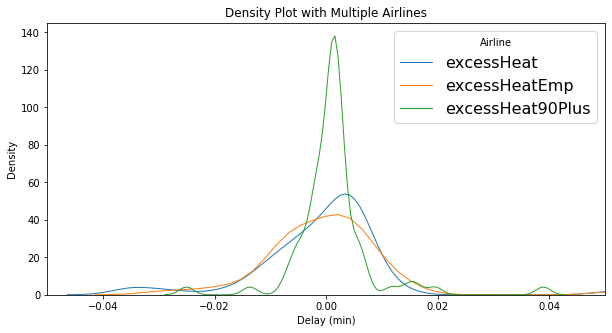

In [154]:
# List of five airlines to plot
weatherVars = list(allResults.index.unique())
plt.figure(figsize = (10, 5))

# Iterate through the five airlines
for weather in ['excessHeat', 'excessHeatEmp', 'excessHeat90Plus']:
    # Subset to the airline
    subset = allResults[(allResults.index == weather) & (allResults.pvals < 0.1)]
    
    # Draw the density plot
    sns.distplot(subset.coeffs, hist = False, kde = True,
                 kde_kws = {'linewidth': 1},
                 label = weather)
    
# Plot formatting

plt.title('Density Plot with Multiple Airlines')
plt.xlabel('Delay (min)')
plt.xlim([-0.05, 0.05])
plt.ylabel('Density')
plt.legend(prop={'size': 16}, title = 'Airline')


In [7]:
def getResults_byInd(outcome, weatherVar, controls):
    equation = outcome + ' ~ ' + weatherVar + '*C(indGroup) + ' + controls

    mod = smf.ols(formula = equation, data = goodsData[~(goodsData.empMx_temp_zipQuarter_95.isna())]).fit() 
    # cov_type='cluster',cov_kwds={'groups': firms})             

    # convert this into a much more condensed version
    coeffs  = pd.DataFrame(mod.params,   columns = ['coeffs'])
    pvalues = pd.DataFrame(mod.pvalues, columns = ['pvals'])


    pvalues = pvalues[pvalues.index.str.contains(weatherVar[0:4])]
    coeffs  = coeffs[coeffs.index.str.contains(weatherVar[0:4])]


    resultsTemp = pd.concat([coeffs,pvalues],axis = 1)

    resultsTemp.loc['upperVariable'] = ['^' + outcome, '*********'] 
    
    return(resultsTemp)

In [8]:
def getResults_bySeason(outcome, weatherVar, controls):
    equation = outcome + ' ~ ' + weatherVar + '*C(qtr) + ' + controls

    mod = smf.ols(formula = equation, data = goodsData[~(goodsData.empMx_temp_zipQuarter_95.isna())]).fit() 
    # cov_type='cluster',cov_kwds={'groups': firms})             

    # convert this into a much more condensed version
    coeffs  = pd.DataFrame(mod.params,   columns = ['coeffs'])
    pvalues = pd.DataFrame(mod.pvalues, columns = ['pvals'])


    pvalues = pvalues[pvalues.index.str.contains(weatherVar[0:4])]
    coeffs  = coeffs[coeffs.index.str.contains(weatherVar[0:4])]


    resultsTemp = pd.concat([coeffs,pvalues],axis = 1)

    resultsTemp.loc['upperVariable'] = ['^' + outcome, '*********'] 
    
    return(resultsTemp)

## Simpler Results
One response across industries and across seasons.

In [26]:
start = time.time()


outcomes = ['lnOpIncNormd', 'lnRevNormd']# , 'lnCostNormd', 'lnStockClose']
weatherVars = ['excessHeat', 'excessHeatEmp','excessHeatMax', 'excessHeat90Plus',
               'excessRain', 'excessRainEmp','excessRainMax', 'excessRainNational',
               'extremeHeatQuarterly', 'extremePrecipQuarterly']


controls = 'C(indSeason) + C(yearQtr) + C(gvkey)' # + C(ageTercile) + C(profitTercile) + C(sizeTercile)'
#  + C(ageTercile) + C(profitTercile) + C(sizeTercile)'

resultList = []
results    = pd.DataFrame()

for weatherVar in weatherVars:
    for outcome in outcomes:
        try:
            print(outcome)

            resultsTemp = getResults(outcome, weatherVar, controls, goodsData)
            print(resultsTemp)

            results = pd.concat([results,resultsTemp], axis = 1)
            print(time.time() - start)
            
            
        except:
            print('No Dice! ' + outcome + "~" + weatherVar)
            pass
    
    
    
resultList.append(results)


allResults_byInd = pd.concat(resultList, axis=0)

lnOpIncNormd
              coeffs     pvals      variable
excessHeat  0.000117  0.485957  lnOpIncNormd
215.75151586532593
lnRevNormd
              coeffs     pvals    variable
excessHeat -0.000912  0.001937  lnRevNormd
467.51522994041443
lnOpIncNormd
                 coeffs     pvals      variable
excessHeatEmp  0.000027  0.881836  lnOpIncNormd
709.3198249340057
lnRevNormd
                 coeffs     pvals    variable
excessHeatEmp -0.001186  0.000251  lnRevNormd
921.1160781383514
lnOpIncNormd
                 coeffs    pvals      variable
excessHeatMax -0.000114  0.45499  lnOpIncNormd
1121.8558130264282
lnRevNormd
                 coeffs     pvals    variable
excessHeatMax -0.001142  0.000022  lnRevNormd
1337.2216250896454
lnOpIncNormd
                    coeffs     pvals      variable
excessHeat90Plus -0.000144  0.056702  lnOpIncNormd
1548.496230840683
lnRevNormd
                    coeffs     pvals    variable
excessHeat90Plus -0.000222  0.095326  lnRevNormd
1734.4297020435333
lnOpI

## By Seasons
Do all of the above on subsamples. Stagger this: do precipitation results first, then for each season.

In [27]:
start = time.time()


outcomes    = ['lnOpIncNormd'] #, 'lnRevNormd'] # , 'lnStockClose']
weatherVars = ['excessHeat', 'excessRain', 'excessHeat90Plus','extremeHeatQuarterly', 'extremePrecipQuarterly']
''''excessHeatEmp','excessHeatMax', 
                'excessRainEmp','excessRainMax', 'excessRainNational','''


''''excessHeat:C(coldest)', 'excessHeatEmp:C(coldest)',
               'excessHeatMax:C(coldest)','excessHeat90Plus:C(hottest)','''

'''toKeep      = goodsData.gvkey.value_counts().index[(goodsData.gvkey.value_counts()  <= 4*19) & \
                                                   (goodsData.gvkey.value_counts()  >  4)]
                                              
'''
quarters    = list(goodsData.qtr.unique())

controls = 'C(indGroup) + C(year) + C(gvkey)' # + C(ageTercile) + C(profitTercile) + C(sizeTercile)'

resultList = []
results    = pd.DataFrame()

for outcome in outcomes:
    for weatherVar in weatherVars:
        for quarter in quarters:
            print(quarter)
            print(goodsData[(goodsData.qtr == quarter)].shape[0])
            
            try:
                print(outcome)
                
                tempData = goodsData[(goodsData.qtr == quarter)]
                
                resultsTemp = getResults(outcome,weatherVar,controls,tempData)
                resultsTemp['quarter'] = quarter
                resultsTemp['indDef']   = 'indGroup'
                resultsTemp['industry'] = 'all'
                resultsTemp['n']        = tempData.shape[0]
                
                
                print(resultsTemp)

                results = pd.concat([results,resultsTemp], axis = 1)
                print(time.time() - start)


            except:
                print('No Dice! ' + outcome + "~" + weatherVar)
                pass
    
    
    
resultList.append(results)

allResults_bySeason = pd.concat(resultList, axis=0)


allResults_bySeason.to_csv('../results/resultsByQtr.csv')



1
25609
lnOpIncNormd
              coeffs    pvals      variable  quarter    indDef industry      n
excessHeat  0.000346  0.40491  lnOpIncNormd        1  indGroup      all  25609
77.81115508079529
2
25922
lnOpIncNormd
             coeffs     pvals      variable  quarter    indDef industry      n
excessHeat  0.00004  0.912231  lnOpIncNormd        2  indGroup      all  25922
148.3356831073761
3
25648
lnOpIncNormd
              coeffs     pvals      variable  quarter    indDef industry  \
excessHeat  0.000155  0.564208  lnOpIncNormd        3  indGroup      all   

                n  
excessHeat  25648  
236.70923399925232
4
25971
lnOpIncNormd
              coeffs     pvals      variable  quarter    indDef industry  \
excessHeat -0.000181  0.606616  lnOpIncNormd        4  indGroup      all   

                n  
excessHeat  25971  
310.2921988964081
1
25609
lnOpIncNormd
              coeffs     pvals      variable  quarter    indDef industry  \
excessRain  0.000356  0.569647  lnOpIncNormd

## By Industries
first do the responses on an ind-by-ind level

In [11]:
start = time.time()


outcomes    = ['lnOpIncNormd', 'lnRevNormd', 'lnCostNormd'] # , 'lnStockClose']
weatherVars = ['extremeHeatDaily','heatDays90Plus','extremeHeatDays_wtd',
              'extremePrecipDaily','precip95National','extremePrecipDays_wtd']


'''['extremeHeatDaily','heatAnomalyDaily','extremeHeatQuarterly','heatAnomalyQuarterly',
               'heatDays90Plus','heat95National','heat99National','extremeHeatDays_wtd','extremeHeatDays_max',
               'extremePrecipDaily','precipAnomalyDaily','extremePrecipQuarterly','precipAnomalyQuarterly',
               'precip95National', 'precip99National','extremePrecipDays_wtd','extremePrecipDays_max']'''

toKeep      = goodsData.gvkey.value_counts().index[(goodsData.gvkey.value_counts()  <= 4*19) & \
                                                   (goodsData.gvkey.value_counts()  >  4)]
                                              

quarters    = list(goodsData.qtr.unique())
industries  = list(goodsData.indGroup.unique())


controls = 'C(indGroup) + C(year) + C(gvkey)  + C(ageTercile) + C(profitTercile) + C(sizeTercile)'

resultList = []
results    = pd.DataFrame()

for weatherVar in weatherVars:
    print(weatherVar, '*****************')
    for outcome in outcomes:
        print('************************')
        for industry in industries:
            print(industry, '**********')

            try:
                print(outcome)

                resultsTemp = getResults(outcome,weatherVar,controls,goodsData[(goodsData.indGroup == industry) & \
                                                (goodsData.gvkey.isin(toKeep))])
                resultsTemp['ind'] = industry
                print(resultsTemp)

                results = pd.concat([results,resultsTemp], axis = 1)
                print(time.time() - start)


            except:
                print('No Dice! ' + outcome + "~" + weatherVar)
                pass
    
    
    
resultList.append(results)


allResults_byIndustry = pd.concat(resultList, axis=0)

extremeHeatDaily *****************
************************
transportUtilities **********
lnOpIncNormd
                         coeffs      pvals                 ind
extremeHeatDaily      -0.000475   0.169392  transportUtilities
upperVariable     ^lnOpIncNormd  *********  transportUtilities
1.7967169284820557
mining **********
lnOpIncNormd
                         coeffs      pvals     ind
extremeHeatDaily       0.000115   0.810643  mining
upperVariable     ^lnOpIncNormd  *********  mining
2.539796829223633
manu **********
lnOpIncNormd
                         coeffs      pvals   ind
extremeHeatDaily       0.000075   0.716943  manu
upperVariable     ^lnOpIncNormd  *********  manu
57.630372047424316
retail **********
lnOpIncNormd
                         coeffs      pvals     ind
extremeHeatDaily       0.001784   0.086507  retail
upperVariable     ^lnOpIncNormd  *********  retail
57.77382016181946
construction **********
lnOpIncNormd
                         coeffs      pvals           

                      coeffs      pvals           ind
heatDays90Plus      0.002479   0.000001  construction
upperVariable   ^lnCostNormd  *********  construction
381.5053160190582
wholesale **********
lnCostNormd
                      coeffs      pvals        ind
heatDays90Plus      0.000383   0.190162  wholesale
upperVariable   ^lnCostNormd  *********  wholesale
381.788006067276
agForFish **********
lnCostNormd
                      coeffs      pvals        ind
heatDays90Plus      -0.00295   0.232042  agForFish
upperVariable   ^lnCostNormd  *********  agForFish
381.8148410320282
extremeHeatDays_wtd *****************
************************
transportUtilities **********
lnOpIncNormd
                            coeffs      pvals                 ind
extremeHeatDays_wtd      -0.000581   0.122018  transportUtilities
upperVariable        ^lnOpIncNormd  *********  transportUtilities
383.8024191856384
mining **********
lnOpIncNormd
                            coeffs      pvals     ind
extrem

                          coeffs      pvals                 ind
extremePrecipDaily     -0.000654   0.508791  transportUtilities
upperVariable       ^lnCostNormd  *********  transportUtilities
675.218875169754
mining **********
lnCostNormd
                          coeffs      pvals     ind
extremePrecipDaily     -0.003156   0.124484  mining
upperVariable       ^lnCostNormd  *********  mining
675.9723329544067
manu **********
lnCostNormd
                          coeffs      pvals   ind
extremePrecipDaily     -0.000045   0.935768  manu
upperVariable       ^lnCostNormd  *********  manu
732.3609299659729
retail **********
lnCostNormd
                          coeffs      pvals     ind
extremePrecipDaily      0.003661   0.084294  retail
upperVariable       ^lnCostNormd  *********  retail
732.5199658870697
construction **********
lnCostNormd
                          coeffs      pvals           ind
extremePrecipDaily      0.002198   0.408678  construction
upperVariable       ^lnCostNormd  *

                            coeffs      pvals           ind
extremePrecipDays_wtd     0.003146   0.268626  construction
upperVariable          ^lnRevNormd  *********  construction
1024.7904670238495
wholesale **********
lnRevNormd
                            coeffs      pvals        ind
extremePrecipDays_wtd    -0.001316   0.381097  wholesale
upperVariable          ^lnRevNormd  *********  wholesale
1025.0589880943298
agForFish **********
lnRevNormd
                            coeffs      pvals        ind
extremePrecipDays_wtd    -0.031116   0.002825  agForFish
upperVariable          ^lnRevNormd  *********  agForFish
1025.086067199707
************************
transportUtilities **********
lnCostNormd
                             coeffs      pvals                 ind
extremePrecipDays_wtd     -0.000854   0.419277  transportUtilities
upperVariable          ^lnCostNormd  *********  transportUtilities
1026.858031988144
mining **********
lnCostNormd
                             coeffs      p

In [13]:
allResults_byIndustry.to_csv("../../data/companyData/allResults_byIndustry.csv")

try by quarter; it seems a little tough to identify effects by industry by season

In [9]:
start = time.time()


outcomes    = ['lnOpIncNormd', 'lnRevNormd', 'lnCostNormd'] # , 'lnStockClose']
weatherVars = ['extremeHeatDaily','heatDays90Plus','extremeHeatDays_wtd',
              'extremePrecipDaily','precip95National','extremePrecipDays_wtd']


'''['extremeHeatDaily','heatAnomalyDaily','extremeHeatQuarterly','heatAnomalyQuarterly',
               'heatDays90Plus','heat95National','heat99National','extremeHeatDays_wtd','extremeHeatDays_max',
               'extremePrecipDaily','precipAnomalyDaily','extremePrecipQuarterly','precipAnomalyQuarterly',
               'precip95National', 'precip99National','extremePrecipDays_wtd','extremePrecipDays_max']'''

toKeep      = goodsData.gvkey.value_counts().index[(goodsData.gvkey.value_counts()  <= 4*19) & \
                                                   (goodsData.gvkey.value_counts()  >  4)]
                                              

quarters    = list(goodsData.qtr.unique())
industries  = list(goodsData.indGroup.unique())


controls = 'C(indGroup) + C(year) + C(gvkey)' #  + C(ageTercile) + C(profitTercile) + C(sizeTercile)'

resultList = []
results    = pd.DataFrame()

for weatherVar in weatherVars:
    print(weatherVar, '*****************')
    for outcome in outcomes:
        print('************************')
        for industry in industries:
            print(industry, '**********')
            for quarter in quarters:
                print(quarter)


                try:
                    print(outcome)

                    resultsTemp = getResults(outcome,weatherVar,controls,goodsData[(goodsData.indGroup == industry) & \
                                                                                   (goodsData.qtr == quarter) & \
                                                    (goodsData.gvkey.isin(toKeep))])
                    resultsTemp['qtr'] = quarter
                    print(resultsTemp)

                    results = pd.concat([results,resultsTemp], axis = 1)
                    print(time.time() - start)


                except:
                    print('No Dice! ' + outcome + "~" + weatherVar)
                    pass
    
    
    
resultList.append(results)


allResults_bySeason = pd.concat(resultList, axis=0)

extremeHeatDaily *****************
************************
transportUtilities **********
1
lnOpIncNormd
                         coeffs      pvals  qtr
extremeHeatDaily       0.000644   0.484792    1
upperVariable     ^lnOpIncNormd  *********    1
0.6401510238647461
2
lnOpIncNormd
                         coeffs      pvals  qtr
extremeHeatDaily      -0.001519   0.062434    2
upperVariable     ^lnOpIncNormd  *********    2
1.2642090320587158
3
lnOpIncNormd
                         coeffs      pvals  qtr
extremeHeatDaily      -0.000921   0.119389    3
upperVariable     ^lnOpIncNormd  *********    3
1.8600459098815918
4
lnOpIncNormd
                         coeffs      pvals  qtr
extremeHeatDaily      -0.000139    0.84956    4
upperVariable     ^lnOpIncNormd  *********    4
2.5531089305877686
mining **********
1
lnOpIncNormd
                         coeffs      pvals  qtr
extremeHeatDaily       0.000392   0.828497    1
upperVariable     ^lnOpIncNormd  *********    1
2.8344109058380127
2


                       coeffs      pvals  qtr
extremeHeatDaily    -0.002805   0.291572    1
upperVariable     ^lnRevNormd  *********    1
190.3756880760193
2
lnRevNormd
                       coeffs      pvals  qtr
extremeHeatDaily      0.00166   0.457238    2
upperVariable     ^lnRevNormd  *********    2
190.47827816009521
3
lnRevNormd
                       coeffs      pvals  qtr
extremeHeatDaily    -0.001242    0.43584    3
upperVariable     ^lnRevNormd  *********    3
190.59735012054443
4
lnRevNormd
                       coeffs      pvals  qtr
extremeHeatDaily     -0.00229   0.283994    4
upperVariable     ^lnRevNormd  *********    4
190.69757890701294
agForFish **********
1
lnRevNormd
                       coeffs      pvals  qtr
extremeHeatDaily     0.004137   0.793985    1
upperVariable     ^lnRevNormd  *********    1
190.7150640487671
2
lnRevNormd
                       coeffs      pvals  qtr
extremeHeatDaily    -0.012563   0.359412    2
upperVariable     ^lnRevNormd  ********

                       coeffs      pvals  qtr
heatDays90Plus      -0.000097   0.664987    3
upperVariable   ^lnOpIncNormd  *********    3
339.6186978816986
4
lnOpIncNormd
                       coeffs      pvals  qtr
heatDays90Plus      -0.000514    0.08418    4
upperVariable   ^lnOpIncNormd  *********    4
360.8245849609375
retail **********
1
lnOpIncNormd
                       coeffs      pvals  qtr
heatDays90Plus       0.005117    0.39419    1
upperVariable   ^lnOpIncNormd  *********    1
360.8967640399933
2
lnOpIncNormd
                       coeffs      pvals  qtr
heatDays90Plus       0.003688   0.142959    2
upperVariable   ^lnOpIncNormd  *********    2
360.9641070365906
3
lnOpIncNormd
                       coeffs      pvals  qtr
heatDays90Plus       0.001017   0.370878    3
upperVariable   ^lnOpIncNormd  *********    3
361.033164024353
4
lnOpIncNormd
                       coeffs      pvals  qtr
heatDays90Plus       0.001669   0.234694    4
upperVariable   ^lnOpIncNormd  *****

                      coeffs      pvals  qtr
heatDays90Plus     -0.000011   0.987462    3
upperVariable   ^lnCostNormd  *********    3
453.9673159122467
4
lnCostNormd
                      coeffs      pvals  qtr
heatDays90Plus       0.00118   0.151319    4
upperVariable   ^lnCostNormd  *********    4
454.8173098564148
mining **********
1
lnCostNormd
                      coeffs      pvals  qtr
heatDays90Plus     -0.001436   0.859776    1
upperVariable   ^lnCostNormd  *********    1
455.16482615470886
2
lnCostNormd
                      coeffs      pvals  qtr
heatDays90Plus     -0.001616   0.528747    2
upperVariable   ^lnCostNormd  *********    2
455.51799607276917
3
lnCostNormd
                      coeffs      pvals  qtr
heatDays90Plus     -0.002057   0.126999    3
upperVariable   ^lnCostNormd  *********    3
455.9002721309662
4
lnCostNormd
                      coeffs      pvals  qtr
heatDays90Plus     -0.002767   0.129844    4
upperVariable   ^lnCostNormd  *********    4
456.253595

                            coeffs      pvals  qtr
extremeHeatDays_wtd       0.002154   0.296749    1
upperVariable        ^lnOpIncNormd  *********    1
613.7781779766083
2
lnOpIncNormd
                            coeffs      pvals  qtr
extremeHeatDays_wtd        0.00287   0.097332    2
upperVariable        ^lnOpIncNormd  *********    2
613.8649771213531
3
lnOpIncNormd
                            coeffs      pvals  qtr
extremeHeatDays_wtd       0.001364    0.27845    3
upperVariable        ^lnOpIncNormd  *********    3
613.9628751277924
4
lnOpIncNormd
                            coeffs      pvals  qtr
extremeHeatDays_wtd        0.00234   0.178481    4
upperVariable        ^lnOpIncNormd  *********    4
614.0797901153564
agForFish **********
1
lnOpIncNormd
                            coeffs      pvals  qtr
extremeHeatDays_wtd       0.010119   0.150147    1
upperVariable        ^lnOpIncNormd  *********    1
614.0998330116272
2
lnOpIncNormd
                            coeffs      pvals  qt

                           coeffs      pvals  qtr
extremeHeatDays_wtd      0.000018   0.979926    3
upperVariable        ^lnCostNormd  *********    3
753.2018659114838
4
lnCostNormd
                           coeffs      pvals  qtr
extremeHeatDays_wtd     -0.000455   0.611431    4
upperVariable        ^lnCostNormd  *********    4
775.4823231697083
retail **********
1
lnCostNormd
                           coeffs      pvals  qtr
extremeHeatDays_wtd      0.006991   0.082195    1
upperVariable        ^lnCostNormd  *********    1
775.5557010173798
2
lnCostNormd
                           coeffs      pvals  qtr
extremeHeatDays_wtd      0.004344   0.188121    2
upperVariable        ^lnCostNormd  *********    2
775.6304290294647
3
lnCostNormd
                           coeffs      pvals  qtr
extremeHeatDays_wtd      0.000015    0.99503    3
upperVariable        ^lnCostNormd  *********    3
775.7032239437103
4
lnCostNormd
                           coeffs      pvals  qtr
extremeHeatDays_wtd   

                         coeffs      pvals  qtr
extremePrecipDaily     0.003844   0.087745    1
upperVariable       ^lnRevNormd  *********    1
864.6911089420319
2
lnRevNormd
                         coeffs      pvals  qtr
extremePrecipDaily     -0.00056   0.796133    2
upperVariable       ^lnRevNormd  *********    2
865.3132970333099
3
lnRevNormd
                         coeffs      pvals  qtr
extremePrecipDaily    -0.001019   0.620205    3
upperVariable       ^lnRevNormd  *********    3
865.9137010574341
4
lnRevNormd
                         coeffs      pvals  qtr
extremePrecipDaily     0.001993   0.347941    4
upperVariable       ^lnRevNormd  *********    4
866.4983332157135
mining **********
1
lnRevNormd
                         coeffs      pvals  qtr
extremePrecipDaily    -0.005558   0.256345    1
upperVariable       ^lnRevNormd  *********    1
866.8492739200592
2
lnRevNormd
                         coeffs      pvals  qtr
extremePrecipDaily    -0.004604   0.242299    2
upperVariab

                          coeffs      pvals  qtr
extremePrecipDaily      0.011152   0.060808    3
upperVariable       ^lnCostNormd  *********    3
1034.3632769584656
4
lnCostNormd
                          coeffs      pvals  qtr
extremePrecipDaily      0.008603   0.230017    4
upperVariable       ^lnCostNormd  *********    4
1034.4086329936981
wholesale **********
1
lnCostNormd
                          coeffs      pvals  qtr
extremePrecipDaily      0.000479   0.903479    1
upperVariable       ^lnCostNormd  *********    1
1034.5956048965454
2
lnCostNormd
                          coeffs      pvals  qtr
extremePrecipDaily      0.001373   0.697411    2
upperVariable       ^lnCostNormd  *********    2
1034.738727092743
3
lnCostNormd
                          coeffs      pvals  qtr
extremePrecipDaily     -0.000861   0.785123    3
upperVariable       ^lnCostNormd  *********    3
1034.8631620407104
4
lnCostNormd
                          coeffs      pvals  qtr
extremePrecipDaily      0.00172

                       coeffs      pvals  qtr
precip95National     0.001466    0.80918    4
upperVariable     ^lnRevNormd  *********    4
1123.6055040359497
manu **********
1
lnRevNormd
                       coeffs      pvals  qtr
precip95National     0.000269    0.89031    1
upperVariable     ^lnRevNormd  *********    1
1144.6622409820557
2
lnRevNormd
                       coeffs      pvals  qtr
precip95National    -0.000459   0.819784    2
upperVariable     ^lnRevNormd  *********    2
1164.2243909835815
3
lnRevNormd
                       coeffs      pvals  qtr
precip95National    -0.005631    0.00312    3
upperVariable     ^lnRevNormd  *********    3
1184.3985130786896
4
lnRevNormd
                       coeffs      pvals  qtr
precip95National     0.001044   0.582023    4
upperVariable     ^lnRevNormd  *********    4
1205.2510488033295
retail **********
1
lnRevNormd
                       coeffs      pvals  qtr
precip95National     0.009772   0.130283    1
upperVariable     ^lnRev

                              coeffs      pvals  qtr
extremePrecipDays_wtd       0.000925   0.508149    1
upperVariable          ^lnOpIncNormd  *********    1
1293.8468918800354
2
lnOpIncNormd
                              coeffs      pvals  qtr
extremePrecipDays_wtd      -0.000528   0.689387    2
upperVariable          ^lnOpIncNormd  *********    2
1295.1718928813934
3
lnOpIncNormd
                              coeffs      pvals  qtr
extremePrecipDays_wtd      -0.001366   0.254356    3
upperVariable          ^lnOpIncNormd  *********    3
1295.883213043213
4
lnOpIncNormd
                              coeffs      pvals  qtr
extremePrecipDays_wtd        0.00133   0.321974    4
upperVariable          ^lnOpIncNormd  *********    4
1296.8005721569061
mining **********
1
lnOpIncNormd
                              coeffs      pvals  qtr
extremePrecipDays_wtd       0.000211   0.937809    1
upperVariable          ^lnOpIncNormd  *********    1
1297.2215337753296
2
lnOpIncNormd
                  

                            coeffs      pvals  qtr
extremePrecipDays_wtd     0.004083   0.317145    3
upperVariable          ^lnRevNormd  *********    3
1460.291698217392
4
lnRevNormd
                            coeffs      pvals  qtr
extremePrecipDays_wtd     0.002295   0.595955    4
upperVariable          ^lnRevNormd  *********    4
1460.4144930839539
construction **********
1
lnRevNormd
                            coeffs      pvals  qtr
extremePrecipDays_wtd     0.005847   0.452187    1
upperVariable          ^lnRevNormd  *********    1
1460.4558718204498
2
lnRevNormd
                            coeffs      pvals  qtr
extremePrecipDays_wtd    -0.001528   0.820237    2
upperVariable          ^lnRevNormd  *********    2
1460.5025351047516
3
lnRevNormd
                            coeffs      pvals  qtr
extremePrecipDays_wtd     0.002773   0.661804    3
upperVariable          ^lnRevNormd  *********    3
1460.5441398620605
4
lnRevNormd
                            coeffs      pvals  qtr
e

In [15]:
allResults_bySeason.to_csv("../../data/companyData/allResults_bySeason.csv")

below we have more on the interactions front. i don't think these are super promising but are worth keeping in line and in mind.

-------------------------

## By Background Climate
first, terciles of this

In [11]:
start = time.time()


outcomes = ['lnOpIncNormd', 'lnRevNormd'] #, 'lnCostNormd'] #, 'lnStockClose']
weatherVars = ['extremeHeatDaily*C(tempTercile)', 'heatDays90Plus*C(tempTercile)', # 'streak90Plus*C(tempTercile)',  # days of extremes
              #'extremeHeatQuarterly*C(tempTercile)', 'extremePrecipQuarterly*C(precipTercile)', # extreme on average
              #'heatAnomalyQuarterly*C(tempTercile)', 'precipAnomalyQuarterly*C(precipTercile)', # quarter above average
              # 'heatAnomalyDaily*C(tempTercile)', 'precipAnomalyDaily*C(precipTercile)', # days above average
              # 'heat95National*C(tempTercile)', # days above 90
              'extremePrecipDaily*C(precipTercile)',
              'extremeHeatDays_wtd*C(tempTercile)', 'extremePrecipDays_wtd*C(precipTercile)']
              #'heat99National*C(tempTercile)','precip99National*C(precipTercile)']


controls = 'C(indGroup):C(qtr) + C(yearQtr) + C(gvkey)' #  + C(ageTercile) + C(profitTercile) + C(sizeTercile)'

resultList = []
results    = pd.DataFrame()
mglResults = pd.DataFrame()


for weatherVar in weatherVars:
    for outcome in outcomes:
        try:
            print(outcome)

            resultsTemp = getResults(outcome, weatherVar, controls, goodsData)
            print(resultsTemp)

            results = pd.concat([results,resultsTemp], axis = 1)
            print(time.time() - start)
            
            # put this into a dataframe
            mglEffects = pd.DataFrame()
            effects    = []
            effects.append(resultsTemp[resultsTemp.index == resultsTemp.index[0]].coeffs[0])
            for coeff in resultsTemp.index[1:-1]:
                effects.append(resultsTemp[resultsTemp.index == resultsTemp.index[0]].coeffs[0] + resultsTemp[resultsTemp.index == coeff].coeffs[0])

            # put these together 
            mglEffects['coeff']   = resultsTemp.index[0:-1]
            mglEffects['effects'] = effects
            print(mglEffects)
            # and stash it for later
            mglResults = pd.concat([mglResults, mglEffects], axis = 1)
            
            
        except:
            print('No Dice! ' + outcome + "~" + weatherVar)
            pass
    
    
    
resultList.append(results)


allResults_byTercile = pd.concat(resultList, axis=0)

lnOpIncNormd
                                             coeffs      pvals
extremeHeatDaily                           0.000727   0.039246
extremeHeatDaily:C(tempTercile)[T.2]      -0.001295   0.003639
extremeHeatDaily:C(tempTercile)[T.3]      -0.000404   0.329318
upperVariable                         ^lnOpIncNormd  *********
247.6093990802765
                                  coeff   effects
0                      extremeHeatDaily  0.000727
1  extremeHeatDaily:C(tempTercile)[T.2] -0.000568
2  extremeHeatDaily:C(tempTercile)[T.3]  0.000323
lnRevNormd
                                           coeffs      pvals
extremeHeatDaily                        -0.000369   0.552856
extremeHeatDaily:C(tempTercile)[T.2]    -0.000865   0.270651
extremeHeatDaily:C(tempTercile)[T.3]    -0.000619   0.396854
upperVariable                         ^lnRevNormd  *********
521.1374042034149
                                  coeff   effects
0                      extremeHeatDaily -0.000369
1  extremeHeatDaily:

# next, do it by just hot/cold, wet/dry

In [13]:
start = time.time()


outcomes = ['lnOpIncNormd', 'lnRevNormd', 'lnCostNormd', 'lnStockClose']
weatherVars = ['extremeHeatDaily*C(tempHalf)', 'extremePrecipDaily*C(precipHalf)', # days of extremes
              'extremeHeatQuarterly*C(tempHalf)', 'extremePrecipQuarterly*C(precipHalf)', # extreme on average
              'heatDays90Plus*C(tempHalf)', 'streak90Plus*C(tempHalf)']


controls = 'C(indGroup):C(qtr) + C(yearQtr) + C(gvkey)' #  + C(ageTercile) + C(profitTercile) + C(sizeTercile)'

resultList = []
results    = pd.DataFrame()
mglResults = pd.DataFrame()


for weatherVar in weatherVars:
    for outcome in outcomes:
        try:
            print(outcome)

            resultsTemp = getResults(outcome, weatherVar, controls, goodsData)
            print(resultsTemp)

            results = pd.concat([results,resultsTemp], axis = 1)
            print(time.time() - start)
            
            # put this into a dataframe
            mglEffects = pd.DataFrame()
            effects    = []
            effects.append(resultsTemp[resultsTemp.index == resultsTemp.index[0]].coeffs[0])
            for coeff in resultsTemp.index[1:-1]:
                effects.append(resultsTemp[resultsTemp.index == resultsTemp.index[0]].coeffs[0] + resultsTemp[resultsTemp.index == coeff].coeffs[0])

            # put these together 
            mglEffects['coeff']   = resultsTemp.index[0:-1]
            mglEffects['effects'] = effects
            print(mglEffects)
            # and stash it for later
            mglResults = pd.concat([mglResults, mglEffects], axis = 1)
            
        except:
            print('No Dice! ' + outcome + "~" + weatherVar)
            pass
    
    
    
resultList.append(results)


allResults_byTercile = pd.concat(resultList, axis=0)

lnOpIncNormd
                                          coeffs      pvals
extremeHeatDaily                        0.000013   0.963066
extremeHeatDaily:C(tempHalf)[T.2]       0.000224    0.49828
upperVariable                      ^lnOpIncNormd  *********
320.30242705345154
                               coeff   effects
0                   extremeHeatDaily  0.000013
1  extremeHeatDaily:C(tempHalf)[T.2]  0.000236
lnRevNormd
                                        coeffs      pvals
extremeHeatDaily                      -0.00068   0.163471
extremeHeatDaily:C(tempHalf)[T.2]    -0.000355   0.541926
upperVariable                      ^lnRevNormd  *********
625.8721640110016
                               coeff   effects
0                   extremeHeatDaily -0.000680
1  extremeHeatDaily:C(tempHalf)[T.2] -0.001035
lnCostNormd
                                         coeffs      pvals
extremeHeatDaily                      -0.000306   0.526869
extremeHeatDaily:C(tempHalf)[T.2]     -0.000732   0.204

                                      coeffs      pvals
streak90Plus                        0.000946   0.866402
streak90Plus:C(tempHalf)[T.2]       0.005686   0.471853
upperVariable                  ^lnOpIncNormd  *********
6283.489735126495
                           coeff   effects
0                   streak90Plus  0.000946
1  streak90Plus:C(tempHalf)[T.2]  0.006633
lnRevNormd
                                    coeffs      pvals
streak90Plus                     -0.015491   0.118353
streak90Plus:C(tempHalf)[T.2]     0.022494   0.106555
upperVariable                  ^lnRevNormd  *********
6652.1100199222565
                           coeff   effects
0                   streak90Plus -0.015491
1  streak90Plus:C(tempHalf)[T.2]  0.007003
lnCostNormd
                                     coeffs      pvals
streak90Plus                       0.012381   0.208292
streak90Plus:C(tempHalf)[T.2]     -0.012644   0.360468
upperVariable                  ^lnCostNormd  *********
6922.329827070236
    

Look at either terciles or halves when defining extremes by industry.

In [15]:
start = time.time()


outcomes = ['lnOpIncNormd', 'lnRevNormd', 'lnCostNormd', 'lnStockClose']

weatherVars = ['extremeHeatDaily*C(tempHalf_byInd)', 'extremePrecipDaily*C(precipHalf_byInd)', # days of extremes
              'extremeHeatQuarterly*C(tempHalf_byInd)', 'extremePrecipQuarterly*C(precipHalf_byInd)', # extreme on average
              'heatDays90Plus*C(tempHalf_byInd)', 'streak90Plus*C(tempHalf_byInd)',
              'extremeHeatDaily*C(tempTercile_byInd)', 'extremePrecipDaily*C(precipTercile_byInd)', # days of extremes
              'extremeHeatQuarterly*C(tempTercile_byInd)', 'extremePrecipQuarterly*C(precipTercile_byInd)', # extreme on average
              'heatDays90Plus*C(tempTercile_byInd)', 'streak90Plus*C(tempTercile_byInd)']


controls = 'C(indGroup):C(qtr) + C(yearQtr) + C(gvkey)' #  + C(ageTercile) + C(profitTercile) + C(sizeTercile)'

resultList = []
results    = pd.DataFrame()
mglResults = pd.DataFrame()


for weatherVar in weatherVars:
    for outcome in outcomes:
        try:
            print(outcome)

            resultsTemp = getResults(outcome, weatherVar, controls, goodsData)
            print(resultsTemp)

            results = pd.concat([results,resultsTemp], axis = 1)
            print(time.time() - start)
            
            # put this into a dataframe
            mglEffects = pd.DataFrame()
            effects    = []
            effects.append(resultsTemp[resultsTemp.index == resultsTemp.index[0]].coeffs[0])
            for coeff in resultsTemp.index[1:-1]:
                effects.append(resultsTemp[resultsTemp.index == resultsTemp.index[0]].coeffs[0] + resultsTemp[resultsTemp.index == coeff].coeffs[0])

            # put these together 
            mglEffects['coeff']   = resultsTemp.index[0:-1]
            mglEffects['effects'] = effects
            print(mglEffects)
            # and stash it for later
            mglResults = pd.concat([mglResults, mglEffects], axis = 1)
            
            
        except:
            print('No Dice! ' + outcome + "~" + weatherVar)
            pass
    
    
    
resultList.append(results)


allResults_byTercile = pd.concat(resultList, axis=0)

lnOpIncNormd
                                                coeffs      pvals
extremeHeatDaily                             -0.000056     0.8384
extremeHeatDaily:C(tempHalf_byInd)[T.2]       0.000328   0.317959
upperVariable                            ^lnOpIncNormd  *********
271.02412724494934
                                     coeff   effects
0                         extremeHeatDaily -0.000056
1  extremeHeatDaily:C(tempHalf_byInd)[T.2]  0.000272
lnRevNormd
                                              coeffs      pvals
extremeHeatDaily                           -0.000706   0.144792
extremeHeatDaily:C(tempHalf_byInd)[T.2]    -0.000319   0.581901
upperVariable                            ^lnRevNormd  *********
587.830372095108
                                     coeff   effects
0                         extremeHeatDaily -0.000706
1  extremeHeatDaily:C(tempHalf_byInd)[T.2] -0.001025
lnCostNormd
                                               coeffs      pvals
extremeHeatDaily         

                                             coeffs      pvals
heatDays90Plus                            -0.000329    0.19324
heatDays90Plus:C(tempHalf_byInd)[T.2]      0.000356   0.134216
upperVariable                          ^lnCostNormd  *********
4806.831122159958
                                   coeff   effects
0                         heatDays90Plus -0.000329
1  heatDays90Plus:C(tempHalf_byInd)[T.2]  0.000027
lnStockClose
                                              coeffs      pvals
heatDays90Plus                              0.000027   0.907822
heatDays90Plus:C(tempHalf_byInd)[T.2]      -0.000016   0.941101
upperVariable                          ^lnStockClose  *********
5059.312667131424
                                   coeff   effects
0                         heatDays90Plus  0.000027
1  heatDays90Plus:C(tempHalf_byInd)[T.2]  0.000011
lnOpIncNormd
                                            coeffs      pvals
streak90Plus                              0.000408   0.942214


                                                      coeffs      pvals
extremeHeatQuarterly                               -0.003419   0.644379
extremeHeatQuarterly:C(tempTercile_byInd)[T.2]     -0.006325   0.550584
extremeHeatQuarterly:C(tempTercile_byInd)[T.3]      0.001832   0.854651
upperVariable                                   ^lnCostNormd  *********
8628.222279310226
                                            coeff   effects
0                            extremeHeatQuarterly -0.003419
1  extremeHeatQuarterly:C(tempTercile_byInd)[T.2] -0.009744
2  extremeHeatQuarterly:C(tempTercile_byInd)[T.3] -0.001587
lnStockClose
                                                       coeffs      pvals
extremeHeatQuarterly                                 0.013771   0.041847
extremeHeatQuarterly:C(tempTercile_byInd)[T.2]      -0.003242   0.737651
extremeHeatQuarterly:C(tempTercile_byInd)[T.3]       0.006807   0.456244
upperVariable                                   ^lnStockClose  *********
8842

## Industries

In [18]:
start = time.time()


# try the marginal effects here
outcome    = 'lnOpIncNormd'
weatherVar = 'extremeHeatDaily'
controls   = 'C(indGroup):C(qtr) + C(yearQtr) + C(gvkey)' #  + C(ageTercile) + C(profitTercile) + C(sizeTercile)'


equation = outcome + ' ~ ' + weatherVar + '*C(indGroup) + ' + controls


mod = smf.ols(formula = equation, data = goodsData[~(goodsData.empMx_temp_zipQuarter_95.isna())]).fit() 

print(time.time() - start)


# convert this into a much more condensed version
coeffs  = pd.DataFrame(mod.params,   columns = ['coeffs'])
pvalues = pd.DataFrame(mod.pvalues, columns = ['pvals'])


pvalues = pvalues[pvalues.index.str.contains(weatherVar[0:4])]
coeffs  = coeffs[coeffs.index.str.contains(weatherVar[0:4])]


258.6618630886078


In [16]:
start = time.time()


outcomes = ['lnOpIncNormd', 'lnRevNormd', 'lnCostNormd', 'lnStockClose']

weatherVars = ['extremeHeatDaily', 'extremePrecipDaily',
               'heatDays90Plus', 'streak90Plus', 
               'heat95National','precip95National',
               'heat99National','precip99National']

controls = 'C(indGroup):C(qtr) + C(yearQtr) + C(gvkey)' #  + C(ageTercile) + C(profitTercile) + C(sizeTercile)'

resultList = []
results    = pd.DataFrame()
mglResults = pd.DataFrame()

for weatherVar in weatherVars:
    for outcome in outcomes:
        try:
            print(outcome)

            resultsTemp = getResults_byInd(outcome, weatherVar, controls)
            print(resultsTemp)

            results = pd.concat([results,resultsTemp], axis = 1)
            print(time.time() - start)
            
            #####
            # put this into a dataframe
            mglEffects = pd.DataFrame()
            effects    = []
            effects.append(resultsTemp[resultsTemp.index == resultsTemp.index[0]].coeffs[0])
            for coeff in resultsTemp.index[1:-1]:
                effects.append(resultsTemp[resultsTemp.index == resultsTemp.index[0]].coeffs[0] + resultsTemp[resultsTemp.index == coeff].coeffs[0])

            # put these together 
            mglEffects['coeff']   = resultsTemp.index[0:-1]
            mglEffects['effects'] = effects
            print(mglEffects)
            # and stash it for later
            mglResults = pd.concat([mglResults, mglEffects], axis = 1)
            
            
        except:
            print('No Dice! ' + outcome + "~" + weatherVar)
            pass
    
    
    
resultList.append(results)


allResults_byInd = pd.concat(resultList, axis=0)

lnOpIncNormd
                                                           coeffs      pvals
extremeHeatDaily                                        -0.002389   0.382099
extremeHeatDaily:C(indGroup)[T.construction]             0.002537   0.383906
extremeHeatDaily:C(indGroup)[T.manu]                     0.002831   0.301701
extremeHeatDaily:C(indGroup)[T.mining]                   0.002219   0.420978
extremeHeatDaily:C(indGroup)[T.retail]                   0.002542   0.378076
extremeHeatDaily:C(indGroup)[T.transportUtilities]       0.001857   0.501196
extremeHeatDaily:C(indGroup)[T.wholesale]                0.002766    0.32654
upperVariable                                       ^lnOpIncNormd  *********
227.9296360015869
                                               coeff   effects
0                                   extremeHeatDaily -0.002389
1       extremeHeatDaily:C(indGroup)[T.construction]  0.000148
2               extremeHeatDaily:C(indGroup)[T.manu]  0.000441
3             extremeHea

                                                           coeffs      pvals
extremePrecipDaily                                       0.006826   0.317433
extremePrecipDaily:C(indGroup)[T.construction]          -0.007568   0.303154
extremePrecipDaily:C(indGroup)[T.manu]                  -0.006322   0.355681
extremePrecipDaily:C(indGroup)[T.mining]                -0.020968   0.002568
extremePrecipDaily:C(indGroup)[T.retail]                 -0.01084   0.133673
extremePrecipDaily:C(indGroup)[T.transportUtili...      -0.006522   0.344768
extremePrecipDaily:C(indGroup)[T.wholesale]             -0.010594   0.133342
upperVariable                                       ^lnStockClose  *********
1927.7569479942322
                                               coeff   effects
0                                 extremePrecipDaily  0.006826
1     extremePrecipDaily:C(indGroup)[T.construction] -0.000743
2             extremePrecipDaily:C(indGroup)[T.manu]  0.000503
3           extremePrecipDaily:C(ind

                                                      coeffs      pvals
streak90Plus                                        0.092194   0.526301
streak90Plus:C(indGroup)[T.construction]            -0.14807    0.34099
streak90Plus:C(indGroup)[T.manu]                   -0.086586   0.552471
streak90Plus:C(indGroup)[T.mining]                 -0.054683   0.710516
streak90Plus:C(indGroup)[T.retail]                 -0.086795   0.567466
streak90Plus:C(indGroup)[T.transportUtilities]     -0.106543   0.467564
streak90Plus:C(indGroup)[T.wholesale]              -0.058772   0.693423
upperVariable                                   ^lnCostNormd  *********
3414.559376001358
                                            coeff   effects
0                                    streak90Plus  0.092194
1        streak90Plus:C(indGroup)[T.construction] -0.055877
2                streak90Plus:C(indGroup)[T.manu]  0.005608
3              streak90Plus:C(indGroup)[T.mining]  0.037510
4              streak90Plus:C(indG

                                                         coeffs      pvals
precip95National                                      -0.023888    0.02589
precip95National:C(indGroup)[T.construction]           0.030871   0.007515
precip95National:C(indGroup)[T.manu]                    0.02319   0.030985
precip95National:C(indGroup)[T.mining]                 0.015687   0.150921
precip95National:C(indGroup)[T.retail]                 0.028072   0.013492
precip95National:C(indGroup)[T.transportUtilities]     0.022149    0.04104
precip95National:C(indGroup)[T.wholesale]              0.021499   0.052344
upperVariable                                       ^lnRevNormd  *********
5002.219018936157
                                               coeff   effects
0                                   precip95National -0.023888
1       precip95National:C(indGroup)[T.construction]  0.006983
2               precip95National:C(indGroup)[T.manu] -0.000698
3             precip95National:C(indGroup)[T.mining] -0

                                                           coeffs      pvals
precip99National                                        -0.067943   0.000234
precip99National:C(indGroup)[T.construction]              0.06953   0.000379
precip99National:C(indGroup)[T.manu]                     0.063745   0.000572
precip99National:C(indGroup)[T.mining]                   0.048317   0.009553
precip99National:C(indGroup)[T.retail]                    0.06288   0.001094
precip99National:C(indGroup)[T.transportUtilities]       0.065982   0.000391
precip99National:C(indGroup)[T.wholesale]                0.063041   0.000859
upperVariable                                       ^lnOpIncNormd  *********
6933.705039024353
                                               coeff   effects
0                                   precip99National -0.067943
1       precip99National:C(indGroup)[T.construction]  0.001587
2               precip99National:C(indGroup)[T.manu] -0.004197
3             precip99National:C(indG

In [55]:
for coeff in resultsTemp.index[1:-1]:
    print(coeff) 

    print(resultsTemp[resultsTemp.index == resultsTemp.index[0]].coeffs[0] + resultsTemp[resultsTemp.index == coeff].coeffs[0])

    # effects.append(resultsTemp[resultsTemp.index == resultsTemp.index[0]].coeffs[0] + resultsTemp[resultsTemp.index == coeff].coeffs[0])


extremePrecipDaily:C(indGroup)[T.construction]
-0.0021882259539254822
extremePrecipDaily:C(indGroup)[T.manu]
-0.0004980278590730244
extremePrecipDaily:C(indGroup)[T.mining]
-0.005818042660938079
extremePrecipDaily:C(indGroup)[T.retail]
-0.001106269870094925
extremePrecipDaily:C(indGroup)[T.transportUtilities]
0.0002471676862046794
extremePrecipDaily:C(indGroup)[T.wholesale]
-0.0016532878032917645


## Seasons
First do this by season, then just check that it's not snow

~(goodsData.qtr == 1)

In [17]:
start = time.time()


outcomes    = ['lnOpIncNormd', 'lnRevNormd', 'lnCostNormd', 'lnStockClose']
weatherVars = ['extremeHeatDaily', 'extremePrecipDaily',
               'heatDays90Plus', 'streak90Plus', 
              'heat95National','precip95National',
              'heat99National','precip99National']


controls = 'C(indGroup):C(qtr) + C(yearQtr) + C(gvkey)' #  + C(ageTercile) + C(profitTercile) + C(sizeTercile)'

resultList = []
results    = pd.DataFrame()

for weatherVar in weatherVars:
    for outcome in outcomes:
        try:
            print(outcome)

            resultsTemp = getResults_bySeason(outcome, weatherVar, controls)
            print(resultsTemp)

            results = pd.concat([results,resultsTemp], axis = 1)
            print(time.time() - start)
            
            
            # put this into a dataframe
            mglEffects = pd.DataFrame()
            effects    = []
            effects.append(resultsTemp[resultsTemp.index == resultsTemp.index[0]].coeffs[0])
            for coeff in resultsTemp.index[1:-1]:
                effects.append(resultsTemp[resultsTemp.index == resultsTemp.index[0]].coeffs[0] + resultsTemp[resultsTemp.index == coeff].coeffs[0])

            # put these together 
            mglEffects['coeff']   = resultsTemp.index[0:-1]
            mglEffects['effects'] = effects
            print(mglEffects)
            # and stash it for later
            mglResults = pd.concat([mglResults, mglEffects], axis = 1)
            
        except:
            print('No Dice! ' + outcome + "~" + weatherVar)
            pass
    
    
    
resultList.append(results)


allResults_bySeason = pd.concat(resultList, axis=0)

lnOpIncNormd
                                     coeffs      pvals
extremeHeatDaily                   0.000318    0.41911
extremeHeatDaily:C(qtr)[T.2]      -0.000045   0.930039
extremeHeatDaily:C(qtr)[T.3]       0.000042   0.928798
extremeHeatDaily:C(qtr)[T.4]       -0.00069   0.168684
upperVariable                 ^lnOpIncNormd  *********
235.44414710998535
                          coeff   effects
0              extremeHeatDaily  0.000318
1  extremeHeatDaily:C(qtr)[T.2]  0.000273
2  extremeHeatDaily:C(qtr)[T.3]  0.000360
3  extremeHeatDaily:C(qtr)[T.4] -0.000372
lnRevNormd
                                   coeffs      pvals
extremeHeatDaily                -0.000512   0.460928
extremeHeatDaily:C(qtr)[T.2]    -0.000452   0.619194
extremeHeatDaily:C(qtr)[T.3]    -0.000246    0.76449
extremeHeatDaily:C(qtr)[T.4]    -0.000931   0.292099
upperVariable                 ^lnRevNormd  *********
472.3508882522583
                          coeff   effects
0              extremeHeatDaily -0.0005

                                 coeffs      pvals
streak90Plus                   0.004143   0.743052
streak90Plus:C(qtr)[T.2]       0.000215     0.9903
streak90Plus:C(qtr)[T.3]       0.008323   0.642892
streak90Plus:C(qtr)[T.4]       0.017172    0.32844
upperVariable             ^lnStockClose  *********
3503.689735174179
                      coeff   effects
0              streak90Plus  0.004143
1  streak90Plus:C(qtr)[T.2]  0.004358
2  streak90Plus:C(qtr)[T.3]  0.012465
3  streak90Plus:C(qtr)[T.4]  0.021315
lnOpIncNormd
No Dice! lnOpIncNormd~heat95National
lnRevNormd
No Dice! lnRevNormd~heat95National
lnCostNormd
No Dice! lnCostNormd~heat95National
lnStockClose
No Dice! lnStockClose~heat95National
lnOpIncNormd
                                     coeffs      pvals
precip95National                  -0.000443   0.486479
precip95National:C(qtr)[T.2]      -0.000496   0.546774
precip95National:C(qtr)[T.3]      -0.001061    0.16426
precip95National:C(qtr)[T.4]      -0.000647   0.405769
uppe

Allow for other season-specific responses

In [4]:
start = time.time()


outcomes = ['lnOpIncNormd', 'lnRevNormd', 'lnCostNormd', 'lnStockClose']


weatherVars = ['extremeHeat*C(qtr)', 'extremePrecip*C(qtr)']


'''['extremeHeat','extremeHeat_wtd','extremePrecip_max','extremeHeat*C(tempTercile)','extremePrecip*C(precipTercile)',
               'extremeHeat_wtd*C(tempTercile)','extremePrecip_wtd*C(precipTercile)','extremeHeat_max*C(tempTercile)',
               'extremePrecip_max*C(precipTercile)']'''


controls = 'C(indGroup):C(qtr) + C(yearQtr) + C(gvkey)' #  + C(ageTercile) + C(profitTercile) + C(sizeTercile)'

resultList = []
results    = pd.DataFrame()

for weatherVar in weatherVars:
    for outcome in outcomes:
        try:
            print(outcome)

            equation = outcome + ' ~ ' + weatherVar + ' + ' + controls

            mod = smf.ols(formula = equation, data = goodsData[~(goodsData.empMx_temp_zipQuarter_95.isna())]).fit() # cov_type='cluster',cov_kwds={'groups': firms})             

            print(time.time() - start) 



            # convert this into a much more condensed version
            coeffs  = pd.DataFrame(mod.params,   columns = ['coeffs'])
            pvalues = pd.DataFrame(mod.pvalues, columns = ['pvals'])



            pvalues = pvalues[pvalues.index.str.contains(weatherVar[0:4])]
            coeffs  = coeffs[coeffs.index.str.contains(weatherVar[0:4])]


            resultsTemp = pd.concat([coeffs,pvalues],axis = 1)

            resultsTemp.loc['upperVariable'] = ['^' + outcome, '*********'] 

            results = pd.concat([results,resultsTemp], axis = 1)

            print(resultsTemp)


            '''print(coeffs)
            print(pvalues)'''
            
        except:
            print('No Dice! ' + outcome + "~" + weatherVar)
            pass
    
    
    
resultList.append(results)


allResults = pd.concat(resultList, axis=0)



lnOpIncNormd
190.25087785720825
                                coeffs      pvals
extremeHeat                   0.006933   0.156387
extremeHeat:C(qtr)[T.2]       0.000408   0.956018
extremeHeat:C(qtr)[T.3]       0.004781   0.475733
extremeHeat:C(qtr)[T.4]      -0.005208   0.442472
upperVariable            ^lnOpIncNormd  *********
lnRevNormd
389.76890897750854
                              coeffs      pvals
extremeHeat                 0.007137   0.408001
extremeHeat:C(qtr)[T.2]     0.004566   0.726396
extremeHeat:C(qtr)[T.3]     0.011664   0.323788
extremeHeat:C(qtr)[T.4]    -0.010005   0.402773
upperVariable            ^lnRevNormd  *********
lnCostNormd
594.483852148056
                               coeffs      pvals
extremeHeat                 -0.005983   0.484468
extremeHeat:C(qtr)[T.2]      0.003277   0.800141
extremeHeat:C(qtr)[T.3]      0.004266   0.716005
extremeHeat:C(qtr)[T.4]     -0.000916   0.938436
upperVariable            ^lnCostNormd  *********
lnStockClose
794.5979180335

--------------------------------------

In [ ]:
smf.ols(formula = 'lnOpIncNormd ~ extremeHeat + C(indGroup):C(qtr) + C(yearQtr) + C(gvkey)', data = goodsData).fit().summary()

In [12]:
allResults.to_csv("../../data/companyData/allResults_precip.csv")

In [ ]:
pvalues

The following are the initial results. This is when we have 3 lags and tercile is defined It roughly seems like:
- higher temperature is beneficial in places at lower levels of temperature
- higher precipitation is still harmful in places at lower levels of precipitation
- high levels of both might be harmful

In [9]:
resultList = []
start = time.time()


outcomes = ['lnOpIncNormd', 'lnRevNormd', 'lnCostNormd', 'lnStockClose']

weatherVars = ['extremeHeat',
               'extremePrecip',
               'heat90Plus',
               'extremeHeat*C(tempTercile)',
               'extremePrecip*C(precipTercile)',
               'C(streak90Plus)',
               'heat90Plus*C(tempTercile)',
               'C(streak90Plus)*C(tempTercile)'
              ]


# 'temp_zipWeek95_99 + lag1_temp_zipWeek95_99 + lag2_temp_zipWeek95_99 ', 
# 'temp_zipMonth95_99 + lag1_temp_zipMonth95_99 + lag2_temp_zipMonth95_99 ',
# 'temp_zipQuarter95_99 + lag1_temp_zipQuarter95_99 + lag2_temp_zipQuarter95_99 ']

controls = 'C(indGroup)*C(qtr) + C(yearQtr) + C(gvkey)' #  + C(ageTercile) + C(profitTercile) + C(sizeTercile)'

for weatherVar in weatherVars:
    print("***************")
    print(weatherVar)
    results = pd.DataFrame()

    for outcome in outcomes:            
        equation = outcome + ' ~ ' + weatherVar + ' + ' + controls
        print(equation)
        
        try:
            firms = goodsData['gvkey']

            mod = smf.ols(formula = equation, data = goodsData).fit() # cov_type='cluster',cov_kwds={'groups': firms})             

            print(time.time() - start) 

            # convert this into a much more condensed version
            coeffs = pd.DataFrame(mod.params,   columns = ['coeffs'])
            pvalues = pd.DataFrame(mod.pvalues, columns = ['pvals'])

            coeffs = coeffs[coeffs.index.str.contains(weatherVar[0:4])]
            pvalues = pvalues[pvalues.index.str.contains(weatherVar[0:4])]

            resultsTemp = pd.concat([coeffs,pvalues],axis = 1)

            resultsTemp.loc['upperVariable'] = ['^' + outcome, '*********'] 

            results = pd.concat([results,resultsTemp], axis = 1)

            print(resultsTemp)
        except:
            print('No Dice! ' + outcome + "~" + weatherVar)
            pass

    resultList.append(results)


allResults = pd.concat(resultList, axis=0)


***************
extremeHeat
lnOpIncNormd ~ extremeHeat + C(indGroup)*C(qtr) + C(yearQtr) + C(gvkey)
30.519735097885132
                      coeffs      pvals
extremeHeat         0.022377   0.559573
upperVariable  ^lnOpIncNormd  *********
lnRevNormd ~ extremeHeat + C(indGroup)*C(qtr) + C(yearQtr) + C(gvkey)
61.67585897445679
                    coeffs      pvals
extremeHeat       0.011931   0.052506
upperVariable  ^lnRevNormd  *********
lnCostNormd ~ extremeHeat + C(indGroup)*C(qtr) + C(yearQtr) + C(gvkey)
90.03048801422119
                     coeffs      pvals
extremeHeat       -0.001617    0.78746
upperVariable  ^lnCostNormd  *********
lnStockClose ~ extremeHeat + C(indGroup)*C(qtr) + C(yearQtr) + C(gvkey)
119.80234003067017
                      coeffs      pvals
extremeHeat         0.011968   0.048972
upperVariable  ^lnStockClose  *********
***************
extremePrecip
lnOpIncNormd ~ extremePrecip + C(indGroup)*C(qtr) + C(yearQtr) + C(gvkey)
146.45761823654175
                   

854.8308899402618
No Dice! lnRevNormd~C(streak90Plus)*C(tempTercile)
lnCostNormd ~ C(streak90Plus)*C(tempTercile) + C(indGroup)*C(qtr) + C(yearQtr) + C(gvkey)
882.2487139701843
No Dice! lnCostNormd~C(streak90Plus)*C(tempTercile)
lnStockClose ~ C(streak90Plus)*C(tempTercile) + C(indGroup)*C(qtr) + C(yearQtr) + C(gvkey)
911.1525580883026
No Dice! lnStockClose~C(streak90Plus)*C(tempTercile)


In [10]:
resultList = []
start = time.time()


outcomes = ['lnOpIncNormd', 'lnRevNormd', 'lnCostNormd', 'lnStockClose']

weatherVars = ['extremeHeat',
               'extremePrecip',
               'heat90Plus',
               'extremeHeat*C(tempTercile)',
               'extremePrecip*C(precipTercile)',
               'C(streak90Plus)',
               'heat90Plus*C(tempTercile)',
               'C(streak90Plus)*C(tempTercile)'
              ]


# 'temp_zipWeek95_99 + lag1_temp_zipWeek95_99 + lag2_temp_zipWeek95_99 ', 
# 'temp_zipMonth95_99 + lag1_temp_zipMonth95_99 + lag2_temp_zipMonth95_99 ',
# 'temp_zipQuarter95_99 + lag1_temp_zipQuarter95_99 + lag2_temp_zipQuarter95_99 ']

controls = 'C(indGroup)*C(qtr) + C(yearQtr) + C(gvkey)  + C(ageTercile) + C(profitTercile) + C(sizeTercile)'

for weatherVar in weatherVars:
    print("***************")
    print(weatherVar)
    results = pd.DataFrame()

    for outcome in outcomes:            
        equation = outcome + ' ~ ' + weatherVar + ' + ' + controls
        print(equation)
        
        try:
            firms = goodsData['gvkey']

            mod = smf.ols(formula = equation, data = goodsData).fit() # cov_type='cluster',cov_kwds={'groups': firms})             

            print(time.time() - start) 

            # convert this into a much more condensed version
            coeffs = pd.DataFrame(mod.params,   columns = ['coeffs'])
            pvalues = pd.DataFrame(mod.pvalues, columns = ['pvals'])

            coeffs = coeffs[coeffs.index.str.contains(weatherVar[0:4])]
            pvalues = pvalues[pvalues.index.str.contains(weatherVar[0:4])]

            resultsTemp = pd.concat([coeffs,pvalues],axis = 1)

            resultsTemp.loc['upperVariable'] = ['^' + outcome, '*********'] 

            results = pd.concat([results,resultsTemp], axis = 1)

            print(resultsTemp)
        except:
            print('No Dice! ' + outcome + "~" + weatherVar)
            pass

    resultList.append(results)


allResults = pd.concat(resultList, axis=0)


***************
extremeHeat
lnOpIncNormd ~ extremeHeat + C(indGroup)*C(qtr) + C(yearQtr) + C(gvkey)  + C(ageTercile) + C(profitTercile) + C(sizeTercile)
45.30226469039917
                      coeffs      pvals
extremeHeat         0.039616   0.298253
upperVariable  ^lnOpIncNormd  *********
lnRevNormd ~ extremeHeat + C(indGroup)*C(qtr) + C(yearQtr) + C(gvkey)  + C(ageTercile) + C(profitTercile) + C(sizeTercile)
98.95867586135864
                    coeffs      pvals
extremeHeat       0.012483   0.040272
upperVariable  ^lnRevNormd  *********
lnCostNormd ~ extremeHeat + C(indGroup)*C(qtr) + C(yearQtr) + C(gvkey)  + C(ageTercile) + C(profitTercile) + C(sizeTercile)
145.75585269927979
                     coeffs      pvals
extremeHeat       -0.002433     0.6809
upperVariable  ^lnCostNormd  *********
lnStockClose ~ extremeHeat + C(indGroup)*C(qtr) + C(yearQtr) + C(gvkey)  + C(ageTercile) + C(profitTercile) + C(sizeTercile)
195.73467874526978
                      coeffs      pvals
extremeHea

1063.5240187644958
No Dice! lnOpIncNormd~C(streak90Plus)*C(tempTercile)
lnRevNormd ~ C(streak90Plus)*C(tempTercile) + C(indGroup)*C(qtr) + C(yearQtr) + C(gvkey)  + C(ageTercile) + C(profitTercile) + C(sizeTercile)
1091.8417406082153
No Dice! lnRevNormd~C(streak90Plus)*C(tempTercile)
lnCostNormd ~ C(streak90Plus)*C(tempTercile) + C(indGroup)*C(qtr) + C(yearQtr) + C(gvkey)  + C(ageTercile) + C(profitTercile) + C(sizeTercile)
1119.3953866958618
No Dice! lnCostNormd~C(streak90Plus)*C(tempTercile)
lnStockClose ~ C(streak90Plus)*C(tempTercile) + C(indGroup)*C(qtr) + C(yearQtr) + C(gvkey)  + C(ageTercile) + C(profitTercile) + C(sizeTercile)
1146.8129496574402
No Dice! lnStockClose~C(streak90Plus)*C(tempTercile)


## Predictions
Take revenue all the way through.

In [149]:
outcome  = 'lnRevNormd'
weather  = 'extremePrecip'
controls = 'C(indGroup):C(qtr) + C(yearQtr) + C(gvkey) + C(ageTercile) + C(profitTercile) + C(sizeTercile)'

equation = outcome + ' ~ ' + weather + ' + ' + controls
 
print(equation)

precipMod = smf.ols(formula = equation, data = goodsData).fit()

print(precipMod.summary())

lnRevNormd ~ extremePrecip + C(indGroup):C(qtr) + C(yearQtr) + C(gvkey) + C(ageTercile) + C(profitTercile) + C(sizeTercile)
                            OLS Regression Results                            
Dep. Variable:             lnRevNormd   R-squared:                       0.731
Model:                            OLS   Adj. R-squared:                  0.723
Method:                 Least Squares   F-statistic:                     85.04
Date:                Sun, 02 Oct 2022   Prob (F-statistic):               0.00
Time:                        18:34:49   Log-Likelihood:                -35628.
No. Observations:               46057   AIC:                         7.411e+04
Df Residuals:                   44628   BIC:                         8.660e+04
Df Model:                        1428                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          t      P>|t

Merge the additional precip data into here.

In [150]:
precipAvg = pd.read_csv("../../data/companyData/precipExtraDays.csv").drop(columns = {'Unnamed: 0'})

In [151]:
precipPreds = goodsData.merge(precipAvg)

precipPreds.loc[precipPreds['qtr'] == 1, 'extremePrecip'] = precipPreds.Q1 + precipPreds.Q4
precipPreds.loc[precipPreds['qtr'] == 2, 'extremePrecip'] = precipPreds.Q2 + precipPreds.Q1
precipPreds.loc[precipPreds['qtr'] == 3, 'extremePrecip'] = precipPreds.Q3 + precipPreds.Q2
precipPreds.loc[precipPreds['qtr'] == 4, 'extremePrecip'] = precipPreds.Q4 + precipPreds.Q3
# precipPreds['extremePrecip'] = 

In [157]:
precipPreds.extremePrecip.describe()

count    45429.000000
mean         0.452746
std          1.397528
min         -3.190476
25%         -0.380952
50%          0.476190
75%          1.476190
max          4.190476
Name: extremePrecip, dtype: float64

In [158]:
precipPreds['changes'] = precipMod.params.extremePrecip*precipPreds.extremePrecip

In [159]:
dirEffects = precipPreds['changes'].groupby(precipPreds.state).mean().reset_index()

In [160]:
dirEffects.head()

state   changes
0    AL -0.033876
1    AR -0.004002
2    AZ  0.034594
3    CA  0.012459
4    CO  0.008108

In [162]:
dirEffects.changes.describe()

count    46.000000
mean     -0.014979
std       0.017611
min      -0.047620
25%      -0.025671
50%      -0.019980
75%      -0.005270
max       0.034594
Name: changes, dtype: float64

(array([1.6820e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

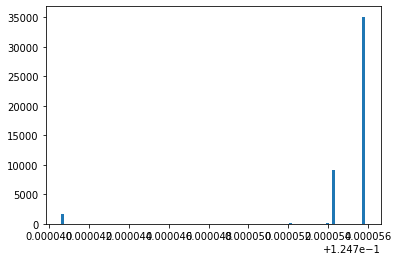

In [37]:
goodsData_moreExtremes = goodsData.copy()
goodsData_moreExtremes['extremeHeat']   += 10
goodsData_moreExtremes['extremePrecip'] += 10

ypred_moreExtremes = tempMod.predict(goodsData_moreExtremes)

plt.hist(ypred_moreExtremes - ypred, bins = 100)



# Indirect Effects
Let's look at the effects on a customer of extremes at its suppliers.

In [27]:
goodsData = pd.read_csv("../../data/companyData/goodsData_largestSupplierData_indirEffects.csv").drop(columns = {'Unnamed: 0'})
goodsData.head()


year  supplier_gvkey  gvkey   salecs   firstYear    lastYear  \
0  2001          147639   1045   95.476  2003-01-01  2008-01-01   
1  2001          147639   1382   33.209  2003-01-01  2015-01-01   
2  2001          147639  10484   37.851  2004-01-01  2011-01-01   
3  2001          147639  10946  166.047  2003-01-01  2003-01-01   
4  2001          147639   1045   95.476  2003-01-01  2008-01-01   

         customer_ind        supplier_ind customer_cstatCompanies  \
0  transportUtilities  transportUtilities      american airlines    
1  transportUtilities  transportUtilities             us airways    
2  transportUtilities  transportUtilities         united airlines   
3  transportUtilities  transportUtilities             us airways    
4  transportUtilities  transportUtilities      american airlines    

  customer_igCompanies  ...  firmQtr    ageQtr   sizeQtr  profitQtr  \
0   american airlines   ...   1045_1  1_2001_1  3_2001_1   2_2001_1   
1          us airways   ...   1382_1  2_2001_1  2_2001_1   2_2001_1   
2       united service  ...  10484_1  2_2001_1  2_2001_1   2_2001_1   
3          us airways   ...  10946_1  1_2001_1  2_2001_1   2_2001_1   
4   american airlines   ...   1045_2  1_2001_2  3_2001_2   2_2001_2   

                     indQtr  supplier_extremeHeat  supplier_heat90Plus  \
0  transportUtilities2001_1                     6                    0   
1  transportUtilities2001_1                     6                    0   
2  transportUtilities2001_1                     6                    0   
3  transportUtilities2001_1                     6                    0   
4  transportUtilities2001_2                     4                    1   

   supplier_extremePrecip  supplierTempTercile  supplierPrecipTercile  
0                       5                    1                      2  
1                       5                    1                      2  
2                       5                    1                      2  
3                       5                    1                      2  
4                       7                    2                      3  

[5 rows x 242 columns]

In [28]:
allWeather_withLags = pd.read_csv("../../data/companyData/allWeather_withLags_allZips.csv").drop(columns = {'Unnamed: 0'})


In [29]:
goodsData.shape

(31446, 242)

In [30]:
np.sum(goodsData.dist > 250)/goodsData.shape[0]

0.7901481905488774

In [31]:
# goodsData = pd.read_csv("../../data/companyData/goodsData_supplierData.csv").drop(columns = {'Unnamed: 0'})
goodsData['year']      = goodsData.year.astype('str').str.slice(0,4).astype('int64')
goodsData['firstYear'] = goodsData.firstYear.astype('str').str.slice(0,4).astype('int64')
goodsData['lastYear']  = goodsData.lastYear.astype('str').str.slice(0,4).astype('int64')


goodsData.columns = goodsData.columns.str.replace("0.95", "Extreme")

print(goodsData.shape, goodsData.columns)

firms = goodsData['gvkey']

(31446, 242) Index(['year', 'supplier_gvkey', 'gvkey', 'salecs', 'firstYear', 'lastYear',
       'customer_ind', 'supplier_ind', 'customer_cstatCompanies',
       'customer_igCompanies',
       ...
       'firmQtr', 'ageQtr', 'sizeQtr', 'profitQtr', 'indQtr',
       'supplier_extremeHeat', 'supplier_heat90Plus', 'supplier_extremePrecip',
       'supplierTempTercile', 'supplierPrecipTercile'],
      dtype='object', length=242)


/Users/brianreed/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  import sys


In [32]:
for col in goodsData.columns:
    print(col)

year
supplier_gvkey
gvkey
salecs
firstYear
lastYear
customer_ind
supplier_ind
customer_cstatCompanies
customer_igCompanies
customer_abi
supplier_cstatCompanies
supplier_igCompanies
supplier_abi
customer_latitude
customer_longitude
customer_zipcode
supplier_latitude
supplier_longitude
supplier_zipcode
dist
totalSuppliers
meanSales
qtr
companyName
curcdq
assets
cash
costGoodsSold
totalInv
netIncome
opInc_afDep
opInc_befDep
totalRevenue
costat
priceClose
add1
addzip
city
state
assetsLast
netIncomeLast
totalRevenueLast
costGoodsSoldLast
totalInvLast
opInc_afDepLast
opInc_befDepLast
priceCloseLast
cashLast
fyearq
assetsLagged
netIncomeLagged
roa_lagged
sic2
indGroup
earliestYear
ageTercile
sizeTercile
profitTercile
datacqtr
datafqtr
fyr
DATE
supplier_precip_annual_50
supplier_precip_annual_95
supplier_precip_annual_99
supplier_precip_zip_50
supplier_precip_zip_95
supplier_precip_zip_99
supplier_precip_zipQuarter_50
supplier_precip_zipQuarter_95
supplier_precip_zipQuarter_99
supplier_temp_an

In [33]:
goodsData['supplierConc'] = goodsData['dist'] > 100

In [34]:
start = time.time()


outcome  = 'lnRevNormd'
weather  = 'supplier_extremePrecip'#*C(supplierConc)'
controls = 'C(indGroup):C(qtr) + C(yearQtr) + C(gvkey) + C(ageTercile) + C(profitTercile) + C(sizeTercile)'

equation = outcome + ' ~ ' + weather + ' + ' + controls
 
print(equation)

precipModIndir = smf.ols(formula = equation, data = goodsData[goodsData.dist < 250]).fit()

print(time.time() - start) 


print(precipModIndir.summary())

lnRevNormd ~ supplier_extremePrecip + C(indGroup):C(qtr) + C(yearQtr) + C(gvkey) + C(ageTercile) + C(profitTercile) + C(sizeTercile)
1.0877931118011475
                            OLS Regression Results                            
Dep. Variable:             lnRevNormd   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.796
Method:                 Least Squares   F-statistic:                     70.47
Date:                Mon, 05 Dec 2022   Prob (F-statistic):               0.00
Time:                        20:56:52   Log-Likelihood:                -3342.2
No. Observations:                6485   AIC:                             7414.
Df Residuals:                    6120   BIC:                             9888.
Df Model:                         364                                         
Covariance Type:            nonrobust                                         
                                                  coef    

In [35]:
start = time.time()

# outcomes = ['lnOpIncNormd', 'lnRevNormd', 'lnCostNormd', 'lnStockClose']

outcome  = 'lnOpIncNormd'
weather  = 'supplier_extremePrecip '
controls = 'C(indGroup):C(qtr) + C(yearQtr) + C(gvkey) + C(ageTercile) + C(profitTercile) + C(sizeTercile)'

equation = outcome + ' ~ ' + weather + ' + ' + controls
 
print(equation)

precipModIndir = smf.ols(formula = equation, data = goodsData).fit()

print(time.time() - start) 


print(precipModIndir.summary())

lnOpIncNormd ~ supplier_extremePrecip  + C(indGroup):C(qtr) + C(yearQtr) + C(gvkey) + C(ageTercile) + C(profitTercile) + C(sizeTercile)
12.117975234985352
                            OLS Regression Results                            
Dep. Variable:           lnOpIncNormd   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.530
Method:                 Least Squares   F-statistic:                     38.00
Date:                Mon, 05 Dec 2022   Prob (F-statistic):               0.00
Time:                        21:03:40   Log-Likelihood:                -2410.2
No. Observations:               31272   AIC:                             6726.
Df Residuals:                   30319   BIC:                         1.468e+04
Df Model:                         952                                         
Covariance Type:            nonrobust                                         
                                                  coef 

In [178]:
precipAvg = pd.read_csv("../../data/companyData/precipExtraDays.csv").\
    drop(columns = {'Unnamed: 0'}).rename(columns = {'zipcode': 'supplier_zipcode'})


precipAvg.head()

variable  supplier_zipcode        Q1        Q2        Q3        Q4
0  pr_hist              1226  0.928571 -0.119048  1.785714  0.547619
1  pr_hist              1434  0.976190 -0.023810  2.023810  1.880952
2  pr_hist              1460  0.976190 -0.023810  2.119048  1.976190
3  pr_hist              1473  0.976190 -0.023810  2.119048  1.976190
4  pr_hist              1507  0.976190 -0.023810  2.023810  1.880952

In [179]:
precipPreds = goodsData.merge(precipAvg)

precipPreds.loc[precipPreds['qtr'] == 1, 'extremePrecip'] = precipPreds.Q1 + precipPreds.Q4
precipPreds.loc[precipPreds['qtr'] == 2, 'extremePrecip'] = precipPreds.Q2 + precipPreds.Q1
precipPreds.loc[precipPreds['qtr'] == 3, 'extremePrecip'] = precipPreds.Q3 + precipPreds.Q2
precipPreds.loc[precipPreds['qtr'] == 4, 'extremePrecip'] = precipPreds.Q4 + precipPreds.Q3
# precipPreds['extremePrecip'] = 

In [180]:
precipPreds.extremePrecip.describe()

count    31446.000000
mean         0.407420
std          1.403588
min         -3.190476
25%         -0.476190
50%          0.476190
75%          1.333333
max          4.190476
Name: extremePrecip, dtype: float64

In [181]:
 precipModIndir.params.supplier_extremePrecip

-0.0011924276629196855

In [183]:
precipPreds['changes'].describe()

count    31446.000000
mean        -0.000486
std          0.001674
min         -0.004997
25%         -0.001590
50%         -0.000568
75%          0.000568
max          0.003804
Name: changes, dtype: float64

In [184]:
precipPreds['changes'] = precipModIndir.params.supplier_extremePrecip*precipPreds.extremePrecip


In [185]:
stateChangesIndir = pd.DataFrame(precipPreds['changes'].groupby(precipPreds.state).mean().reset_index())
stateChangesIndir.rename(columns = {'changes': 'indirChanges'}, inplace = True)

stateChangesIndir.head()

state  indirChanges
0    AL      0.000757
1    AR     -0.000952
2    AZ     -0.000467
3    CA     -0.000306
4    CO     -0.000334

In [193]:
stateChangesIndir.indirChanges.˜stadescribe()

count    45.000000
mean     -0.000524
std       0.000619
min      -0.001847
25%      -0.000857
50%      -0.000550
75%      -0.000338
max       0.001150
Name: indirChanges, dtype: float64

In [221]:
allEffects = dirEffects.merge(stateChangesIndir)

allEffects.sort_values(by = ['changes'], inplace = True)

In [222]:
allEffects.head()

state   changes  indirChanges
16    MA -0.047620     -0.000690
24    NH -0.045911     -0.001847
0     AL -0.033876      0.000757
22    NC -0.033701     -0.000471
7     DE -0.032862     -0.000636

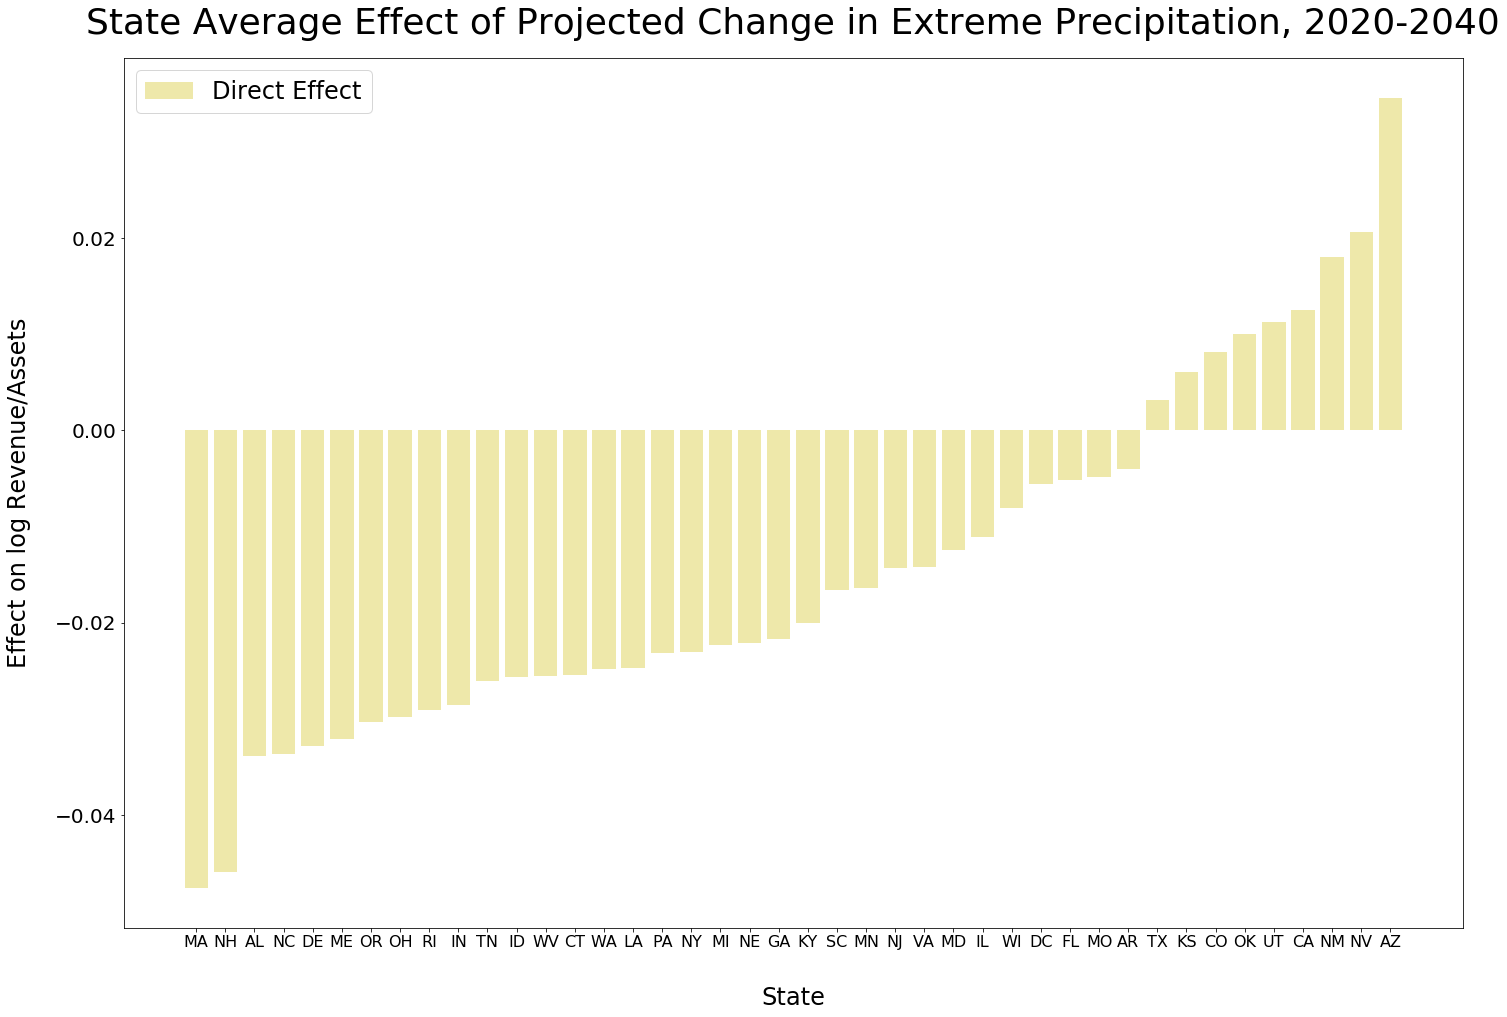

In [258]:
plt.figure(figsize = (24, 16))


plt.bar(allEffects.state,allEffects.changes,      
        label = 'Direct Effect',   color = 'palegoldenrod')
'''plt.bar(allEffects.state,allEffects.indirChanges, 
        label = 'Indirect Effect', color = 'firebrick')'''

plt.title('State Average Effect of Projected Change in Extreme Precipitation, 2020-2040',
          fontsize = 36, pad = 24)

plt.xlabel('State', fontsize = 24, labelpad = 36)
plt.xticks(fontsize=16)

plt.ylabel('Effect on log Revenue/Assets', fontsize = 24, labelpad = 24)
plt.yticks(fontsize=20)

plt.legend(fontsize = 24, loc = 'upper left')
plt.show()

We see the same thing here with temperature: positive correlation overall, with a negative effect on the warmer terciles and a positive effect on the coolest one.

In [131]:
start = time.time()

# outcomes = ['lnOpIncNormd', 'lnRevNormd', 'lnCostNormd', 'lnStockClose']


outcome  = 'lnOpIncNormd'
weather  = 'supplier_heat90Plus'
controls = 'C(indGroup):C(qtr) + C(yearQtr) + C(gvkey) + C(ageTercile) + C(profitTercile) + C(sizeTercile)'

equation = outcome + ' ~ ' + weather + ' + ' + controls
 
print(equation)

tempMod = smf.ols(formula = equation, data = goodsData).fit()

print(time.time() - start) 


print(tempMod.summary())

lnOpIncNormd ~ supplier_heat90Plus + C(indGroup):C(qtr) + C(yearQtr) + C(gvkey) + C(ageTercile) + C(profitTercile) + C(sizeTercile)
11.963567018508911
                            OLS Regression Results                            
Dep. Variable:           lnOpIncNormd   R-squared:                       0.541
Model:                            OLS   Adj. R-squared:                  0.527
Method:                 Least Squares   F-statistic:                     37.58
Date:                Fri, 23 Sep 2022   Prob (F-statistic):               0.00
Time:                        11:19:58   Log-Likelihood:                -73683.
No. Observations:               31272   AIC:                         1.493e+05
Df Residuals:                   30319   BIC:                         1.572e+05
Df Model:                         952                                         
Covariance Type:            nonrobust                                         
                                                  coef    s

In [20]:
start = time.time()

outcome  = 'lnOpIncNormd'
weather  = 'C(supplierTempTercile)*(supplier_heat90Plus)'
controls = 'C(indGroup):C(qtr) + C(yearQtr) + C(gvkey) + C(ageTercile) + C(profitTercile) + C(sizeTercile)'

equation = outcome + ' ~ ' + weather + ' + ' + controls
 
print(equation)

tempMod = smf.ols(formula = equation, data = goodsData).fit()

print(time.time() - start) 


print(tempMod.summary())

lnOpIncNormd ~ C(supplierTempTercile)*(supplier_heat90Plus) + C(indGroup):C(qtr) + C(yearQtr) + C(gvkey) + C(ageTercile) + C(profitTercile) + C(sizeTercile)
12.665775775909424
                            OLS Regression Results                            
Dep. Variable:           lnOpIncNormd   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.530
Method:                 Least Squares   F-statistic:                     37.84
Date:                Sun, 02 Oct 2022   Prob (F-statistic):               0.00
Time:                        12:21:16   Log-Likelihood:                -2410.5
No. Observations:               31272   AIC:                             6735.
Df Residuals:                   30315   BIC:                         1.473e+04
Df Model:                         956                                         
Covariance Type:            nonrobust                                         
                                  

Let's do the same as we did below, making a dataframe that summarizes a lot of the results. For now just do: 
- extreme heat
- extreme precip
- both of above, with breakdown by tercile

In [23]:
resultList = []
start = time.time()


outcomes = ['lnOpIncNormd', 'lnRevNormd', 'lnCostNormd', 'lnStockClose']

weatherVars = ['supplier_extremePrecip',
               'supplier_extremeHeat',
               'supplier_heat90Plus'
              ]


# 'temp_zipWeek95_99 + lag1_temp_zipWeek95_99 + lag2_temp_zipWeek95_99 ', 
# 'temp_zipMonth95_99 + lag1_temp_zipMonth95_99 + lag2_temp_zipMonth95_99 ',
# 'temp_zipQuarter95_99 + lag1_temp_zipQuarter95_99 + lag2_temp_zipQuarter95_99 ']

controls = 'C(indGroup)*C(qtr) + C(yearQtr) + C(gvkey)'

for weatherVar in weatherVars:
    print("***************")
    print(weatherVar)
    results = pd.DataFrame()

    for outcome in outcomes:            
        equation = outcome + ' ~ ' + weatherVar + ' + ' + controls
        print(equation)
        
        try:
            mod = smf.ols(formula = equation, data = goodsData).fit()             

            print(time.time() - start) 

            # convert this into a much more condensed version
            coeffs = pd.DataFrame(mod.params,   columns = ['coeffs'])
            pvalues = pd.DataFrame(mod.pvalues, columns = ['pvals'])

            coeffs = coeffs[coeffs.index.str.contains(weatherVar[0:4])]
            pvalues = pvalues[pvalues.index.str.contains(weatherVar[0:4])]

            resultsTemp = pd.concat([coeffs,pvalues],axis = 1)

            resultsTemp.loc['upperVariable'] = ['^' + outcome, '*********'] 

            results = pd.concat([results,resultsTemp], axis = 1)

            print(resultsTemp)
        except:
            print('No Dice! ' + outcome + "~" + weatherVar)
            pass

    resultList.append(results)


allResults = pd.concat(resultList, axis=0)


***************
supplier_extremePrecip
lnOpIncNormd ~ supplier_extremePrecip + C(indGroup)*C(qtr) + C(yearQtr) + C(gvkey)
10.55065107345581
                               coeffs      pvals
supplier_extremePrecip       -0.00097   0.002604
upperVariable           ^lnOpIncNormd  *********
lnRevNormd ~ supplier_extremePrecip + C(indGroup)*C(qtr) + C(yearQtr) + C(gvkey)
21.316709995269775
                             coeffs      pvals
supplier_extremePrecip    -0.001237   0.010753
upperVariable           ^lnRevNormd  *********
lnCostNormd ~ supplier_extremePrecip + C(indGroup)*C(qtr) + C(yearQtr) + C(gvkey)
32.02339792251587
                              coeffs      pvals
supplier_extremePrecip     -0.000072   0.908139
upperVariable           ^lnCostNormd  *********
lnStockClose ~ supplier_extremePrecip + C(indGroup)*C(qtr) + C(yearQtr) + C(gvkey)
42.44922208786011
                               coeffs      pvals
supplier_extremePrecip      -0.001659   0.005894
upperVariable           ^lnSt

In [21]:
resultList = []
start = time.time()


outcomes = ['lnOpIncNormd', 'lnRevNormd', 'lnCostNormd', 'lnStockClose']

weatherVars = ['supplier_extremePrecip',
               'supplier_extremeHeat',
               'supplier_heat90Plus',
               'supplier_streak90Plus',
               'supplier_extremePrecip*C(supplierPrecipTercile)',
               'supplier_extremeHeat*C(supplierTempTercile)',
               'supplier_heat90Plus*C(supplierTempTercile)',
               'supplier_streak90Plus*C(supplierTempTercile)'
              ]


# 'temp_zipWeek95_99 + lag1_temp_zipWeek95_99 + lag2_temp_zipWeek95_99 ', 
# 'temp_zipMonth95_99 + lag1_temp_zipMonth95_99 + lag2_temp_zipMonth95_99 ',
# 'temp_zipQuarter95_99 + lag1_temp_zipQuarter95_99 + lag2_temp_zipQuarter95_99 ']

controls = 'C(indGroup)*C(qtr) + C(yearQtr) + C(gvkey) + C(ageTercile) + C(profitTercile) + C(sizeTercile)'

for weatherVar in weatherVars:
    print("***************")
    print(weatherVar)
    results = pd.DataFrame()

    for outcome in outcomes:            
        equation = outcome + ' ~ ' + weatherVar + ' + ' + controls
        print(equation)
        
        try:
            mod = smf.ols(formula = equation, data = goodsData).fit()             

            print(time.time() - start) 

            # convert this into a much more condensed version
            coeffs = pd.DataFrame(mod.params,   columns = ['coeffs'])
            pvalues = pd.DataFrame(mod.pvalues, columns = ['pvals'])

            coeffs = coeffs[coeffs.index.str.contains(weatherVar[0:4])]
            pvalues = pvalues[pvalues.index.str.contains(weatherVar[0:4])]

            resultsTemp = pd.concat([coeffs,pvalues],axis = 1)

            resultsTemp.loc['upperVariable'] = ['^' + outcome, '*********'] 

            results = pd.concat([results,resultsTemp], axis = 1)

            print(resultsTemp)
        except:
            print('No Dice! ' + outcome + "~" + weatherVar)
            pass

    resultList.append(results)


allResults = pd.concat(resultList, axis=0)


***************
supplier_extremePrecip
lnOpIncNormd ~ supplier_extremePrecip + C(indGroup)*C(qtr) + C(yearQtr) + C(gvkey) + C(ageTercile) + C(profitTercile) + C(sizeTercile)
12.308876991271973
                               coeffs      pvals
supplier_extremePrecip      -0.000929   0.003705
upperVariable           ^lnOpIncNormd  *********
lnRevNormd ~ supplier_extremePrecip + C(indGroup)*C(qtr) + C(yearQtr) + C(gvkey) + C(ageTercile) + C(profitTercile) + C(sizeTercile)
24.381559133529663
                             coeffs      pvals
supplier_extremePrecip    -0.001177   0.012841
upperVariable           ^lnRevNormd  *********
lnCostNormd ~ supplier_extremePrecip + C(indGroup)*C(qtr) + C(yearQtr) + C(gvkey) + C(ageTercile) + C(profitTercile) + C(sizeTercile)
37.71252918243408
                              coeffs      pvals
supplier_extremePrecip     -0.000032   0.958381
upperVariable           ^lnCostNormd  *********
lnStockClose ~ supplier_extremePrecip + C(indGroup)*C(qtr) + C(yearQtr)

255.54928517341614
                                                       coeffs      pvals
C(supplierTempTercile)[T.2]                          0.028987   0.023556
C(supplierTempTercile)[T.3]                          0.018905   0.217942
supplier_extremeHeat                                 0.000779   0.264861
supplier_extremeHeat:C(supplierTempTercile)[T.2]    -0.000625   0.476897
supplier_extremeHeat:C(supplierTempTercile)[T.3]    -0.001033   0.202316
upperVariable                                     ^lnRevNormd  *********
lnCostNormd ~ supplier_extremeHeat*C(supplierTempTercile) + C(indGroup)*C(qtr) + C(yearQtr) + C(gvkey) + C(ageTercile) + C(profitTercile) + C(sizeTercile)
267.3470849990845
                                                        coeffs      pvals
C(supplierTempTercile)[T.2]                           0.026715   0.109242
C(supplierTempTercile)[T.3]                           0.016512   0.408675
supplier_extremeHeat                                 -0.000423   0.641868
s

# Direct Effects
Look at the effects on the suppliers when they're affected directly.

## Complete Dataset
### At HQs

The below gives us the full, clustered standard errors.

In [54]:
resultList[0]

coeffs      pvals      conc
precip_zipQuarterquant_Extreme           -0.013955   0.001611  _more25%
lag1_precip_zipQuarterquant_Extreme      -0.009473   0.032546  _more25%
lag2_precip_zipQuarterquant_Extreme      -0.003884   0.379477  _more25%
lag3_precip_zipQuarterquant_Extreme      -0.005953   0.178952  _more25%
upperVariable                        ^lnOpIncNormd  *********  _more25%

First, do the basics: days of extreme precipitation and (separately) extreme temperature, with 3 lags. We include a balance of time and industry-specific controls, fewer than are in the other regressions but generally allowing for a time trend, firm-specific trends, industry-seasonal trends, and profit, size, and age characteristics. We don't have time-specific trends across firms or industries but it's not clear that these would really change over the 10 years of the sample.



There are a couple of background facts that I'm relying on here: 
- the 1x year, 1x5 years, etc variables might be too rare to really pick up an effect.
- it's possible that lower tiers, or less extreme extremes, might matter too. may want to try to pick up a lower threshold as well. 
- the normalized variables (divided by lagged assets) seem to be more sensitive / response than just growth and just log-levels. this is likely because of something like the fact that this helps equalize for differences in the size of the firms in a way that neither log nor growth does. 



there are a couple of things to remember with these results:
- the company size/age/profitability terciles don't make a lick of difference
- precipitation seems to matter, period, for cumulative number of days
- temperature might need a longer streak for the effect to happen



a few things come out more in the heterogeneity analyses:
- it seems like the local-relative extremes matter especially at the upper ends of the distributions. this is a little counterintuitive but i think the story is something like the following: we expect that places with higher average temperatures would have higher ''95th percentile events'', and places with lower average temperatures might have lower ''95th percentile events'', that might actually not be that extreme. 
- we would expect the heatBin:extremeTemp(Precip) measure to show an opposite result if the extreme definition is an absolute one and not a relative one (larger effect in places with lower normal temps (precip) // lower effect in places with higher normal temps (precip)) because it's closer to their baseline & closer to what they might expect.
- there's not much with the industry-specific results? it could be that the data are currently too diffuse or too small to really 



questions:
- are there other moments of distributions or other ways to measure shifts in extremes?
- how should i best approach the industry-specific regressions? - separate regressions or interaction terms?
- what mechanisms should i consider? bs consider the role of "input specificity", as judged by patents or r&d. ps consider a few different ones: materiality, defined by value of physical assets/value of total assets; industry specificity; and expectation. 
    - are there any "climate mechanisms" i can examine here, other than just expectations?
    - how can we adapt or incorporate the scc here?



things to push forward on:
- targeting specific industries: either with different lag tiers, or with 
- indirect regressions!
- stock regressions
- extreme convective storms
- counts in disclosures



things that are probably very relevant that i should keep experimenting with:
- measures of concentration: establishment weights, percent of firm w/in 10% (or honestly 70%+) of hq
- extreme temp as 90+, maybe some flood-relative measure of extreme rain?


First, total days of heat and rain.



*AT SOME POINT, WE CAN ADD ADDTL COLUMNS FOR OTHER VARIABLES OF INTEREST TO THIS AS WELL: cost & profit, maybe also stocks [if we do a quarter before, quarter after] thing

In [ ]:
resultList = []

keys = ['_more25%', '_more50%', '_more75%', '']

start = time.time()


for key in keys:
    '##################################################################'
    filename = '../../data/companyData/goodsData_igData' + key + '.csv'
    
    print(filename)

    goodsData = pd.read_csv(filename).drop(columns = {'Unnamed: 0'})

    goodsData.columns = goodsData.columns.str.replace("0.95", "Extreme")

    print(goodsData.shape)

    firms = goodsData['gvkey']



    outcomes = ['lnOpIncNormd', 'lnRevNormd', 'lnCostNormd', 'lnStockClose']

    weatherVars = ['precip_zipQuarterquant_Extreme + lag1_precip_zipQuarterquant_Extreme + lag2_precip_zipQuarterquant_Extreme + lag3_precip_zipQuarterquant_Extreme',
                  'temp5Days_zipQuarterquant_Extreme + lag1_temp5Days_zipQuarterquant_Extreme + lag2_temp5Days_zipQuarterquant_Extreme + lag3_temp5Days_zipQuarterquant_Extreme',
                  'days90Plus + lag1_days90Plus + lag2_days90Plus + lag3_days90Plus',
                  'streak90Plus + lag1_streak90Plus + lag2_streak90Plus + lag3_streak90Plus', 
                  'propAboveTenThou + lag1_propAboveTenThou + lag2_propAboveTenThou + lag3_propAboveTenThou',
                  'propAboveHundredThou + lag1_propAboveHundredThou + lag2_propAboveHundredThou + lag3_propAboveHundredThou',
                  'propAboveMilli + lag1_propAboveMilli + lag2_propAboveMilli + lag3_propAboveMilli']

                  # 'temp_zipWeek95_99 + lag1_temp_zipWeek95_99 + lag2_temp_zipWeek95_99 ', 
                  # 'temp_zipMonth95_99 + lag1_temp_zipMonth95_99 + lag2_temp_zipMonth95_99 ',
                  # 'temp_zipQuarter95_99 + lag1_temp_zipQuarter95_99 + lag2_temp_zipQuarter95_99 ']

    controls = ' + C(indGroup):C(qtr) + C(yearQtr) + C(gvkey) + C(ageTercile) + C(profitTercile) + C(sizeTercile)'

    for weatherVar in weatherVars:
        print("***************")
        results = pd.DataFrame()

        for outcome in outcomes:    
            print(outcome + "~" + weatherVar)
            try:
                mod = smf.ols(formula = outcome + ' ~ ' + weatherVar + controls, data = goodsData).fit()             

                print(time.time() - start) 

                # convert this into a much more condensed version
                coeffs = pd.DataFrame(mod.params,   columns = ['coeffs'])
                pvalues = pd.DataFrame(mod.pvalues, columns = ['pvals'])

                coeffs = coeffs[coeffs.index.str.contains(weatherVar[0:4])]
                pvalues = pvalues[pvalues.index.str.contains(weatherVar[0:4])]

                resultsTemp = pd.concat([coeffs,pvalues],axis = 1)

                resultsTemp.loc['upperVariable'] = ['^' + outcome, '*********'] 

                results = pd.concat([results,resultsTemp], axis = 1)
                results['conc'] = key

                print(resultsTemp)
                
            except:
                print('No Dice! ' + outcome + "~" + weatherVar)
                pass

        resultList.append(results)
        
        
allResults = pd.concat(resultList, axis=0)

allResults.to_csv('../../data/companyData/results.csv')


../../data/companyData/goodsData_igData_more25%.csv


/Users/brianreed/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/brianreed/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: The default value of regex will change from True to False in a future version.
  app.launch_new_instance()


(37942, 892)
***************
lnOpIncNormd~precip_zipQuarterquant_Extreme + lag1_precip_zipQuarterquant_Extreme + lag2_precip_zipQuarterquant_Extreme + lag3_precip_zipQuarterquant_Extreme
No Dice! lnOpIncNormd~precip_zipQuarterquant_Extreme + lag1_precip_zipQuarterquant_Extreme + lag2_precip_zipQuarterquant_Extreme + lag3_precip_zipQuarterquant_Extreme
lnRevNormd~precip_zipQuarterquant_Extreme + lag1_precip_zipQuarterquant_Extreme + lag2_precip_zipQuarterquant_Extreme + lag3_precip_zipQuarterquant_Extreme
No Dice! lnRevNormd~precip_zipQuarterquant_Extreme + lag1_precip_zipQuarterquant_Extreme + lag2_precip_zipQuarterquant_Extreme + lag3_precip_zipQuarterquant_Extreme
lnCostNormd~precip_zipQuarterquant_Extreme + lag1_precip_zipQuarterquant_Extreme + lag2_precip_zipQuarterquant_Extreme + lag3_precip_zipQuarterquant_Extreme
No Dice! lnCostNormd~precip_zipQuarterquant_Extreme + lag1_precip_zipQuarterquant_Extreme + lag2_precip_zipQuarterquant_Extreme + lag3_precip_zipQuarterquant_Extreme
ln

In [12]:
allResults = pd.DataFrame()

for result in resultList:
    if result.shape[1] == 9:
        allResults = pd.concat([allResults,result])
    print(allResults)

                                            coeffs      pvals      conc  \
precip_zipQuarterquant_Extreme           -0.013955   0.001611  _more25%   
lag1_precip_zipQuarterquant_Extreme      -0.009473   0.032546  _more25%   
lag2_precip_zipQuarterquant_Extreme      -0.003884   0.379477  _more25%   
lag3_precip_zipQuarterquant_Extreme      -0.005953   0.178952  _more25%   
upperVariable                        ^lnOpIncNormd  *********  _more25%   

                                          coeffs      pvals        coeffs  \
precip_zipQuarterquant_Extreme          -0.00132    0.17013      -0.00058   
lag1_precip_zipQuarterquant_Extreme    -0.000822   0.394243     -0.000487   
lag2_precip_zipQuarterquant_Extreme    -0.001947   0.043086     -0.002664   
lag3_precip_zipQuarterquant_Extreme    -0.003343   0.000533     -0.003296   
upperVariable                        ^lnRevNormd  *********  ^lnCostNormd   

                                         pvals         coeffs      pvals  
precip_zipQ

In [14]:
allResults.to_csv('../../data/companyData/allResults_byConc.csv')

Try to get the variance-covariance matrix, from https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.RegressionResults.cov_params.html . We can use this in the calculation of MEs.

In [ ]:
precipMod.cov_params()

In [ ]:
start = time.time()

# + C(ageTercile) + C(profitTercile) + C(sizeTercile)
tempMod = smf.ols(formula = 'lnRevNormd ~ temp_zipQuarterquant_Extreme + lag1_temp_zipQuarterquant_Extreme + lag2_temp_zipQuarterquant_Extreme + lag3_temp_zipQuarterquant_Extreme + C(indGroup):C(qtr) + C(yearQtr) + C(gvkey) ', data = goodsData).fit()

print(time.time() - start) 

# convert this into a much more condensed version
coeffs = pd.DataFrame(tempMod.params,   columns = ['coeffs'])
pvalues = pd.DataFrame(tempMod.pvalues, columns = ['pvals'])

coeffs = coeffs[coeffs.index.str.contains('temp')]
pvalues = pvalues[pvalues.index.str.contains('temp')]

results = pd.concat([coeffs,pvalues],axis = 1)


print(results)


These results are influenced by the particular transformation. if we do 1 + the ratio, we have a particular problem with the second period here.

Look at "sustained" heat and rain. We can look at incidence of a heatwave or sustained temperatures above a given amount.

In [ ]:
start = time.time()


precip5DaysMod = smf.ols(formula = 'lnRevNormd ~ precip5Days_zipQuarterquant_Extreme + lag1_precip5Days_zipQuarterquant_Extreme + lag2_precip5Days_zipQuarterquant_Extreme + lag3_precip5Days_zipQuarterquant_Extreme + C(indGroup):C(qtr) + C(yearQtr) + C(gvkey) + C(ageTercile) + C(profitTercile) + C(sizeTercile)', data = goodsData).fit()

print(time.time() - start) 

# convert this into a much more condensed version
coeffs = pd.DataFrame(precip5DaysMod.params,   columns = ['coeffs'])
pvalues = pd.DataFrame(precip5DaysMod.pvalues, columns = ['pvals'])

coeffs = coeffs[coeffs.index.str.contains('precip')]
pvalues = pvalues[pvalues.index.str.contains('precip')]

results = pd.concat([coeffs,pvalues],axis = 1)


print(results)


In [ ]:
start = time.time()


temp5DaysMod = smf.ols(formula = 'lnRevNormd ~ temp5Days_zipQuarterquant_Extreme + lag1_temp5Days_zipQuarterquant_Extreme + lag2_temp5Days_zipQuarterquant_Extreme + lag3_temp5Days_zipQuarterquant_Extreme + C(indGroup):C(qtr) + C(yearQtr) + C(gvkey) + C(ageTercile) + C(profitTercile) + C(sizeTercile)', data = goodsData).fit()

print(time.time() - start) 

# convert this into a much more condensed version
coeffs  = pd.DataFrame(temp5DaysMod.params,  columns = ['coeffs'])
pvalues = pd.DataFrame(temp5DaysMod.pvalues, columns = ['pvals'])

coeffs  = coeffs[coeffs.index.str.contains('temp')]
pvalues = pvalues[pvalues.index.str.contains('temp')]

results = pd.concat([coeffs,pvalues],axis = 1)


print(results)


## Breakouts by tercile

See how the effect varies in places that are background hot // background wet.

Sort of inspired by the BS2016 tercile approach, we divide each place into terciles. I THINK (double check this) that this is based on annual average temperature and precipitation. 



In [ ]:
start = time.time()


precipModTercile = smf.ols(formula = 'lnRevNormd ~ C(precipTercile)*(precip_zipQuarterquant_Extreme + lag1_precip_zipQuarterquant_Extreme + lag2_precip_zipQuarterquant_Extreme + lag3_precip_zipQuarterquant_Extreme) + C(indGroup):C(qtr) + C(yearQtr) + C(gvkey) + C(ageTercile) + C(profitTercile) + C(sizeTercile)', data = goodsData).fit()

print(time.time() - start) 

# convert this into a much more condensed version
coeffs  = pd.DataFrame(precipModTercile.params,  columns = ['coeffs'])
pvalues = pd.DataFrame(precipModTercile.pvalues, columns = ['pvals'])

coeffs  = coeffs[coeffs.index.str.contains('precip')]
pvalues = pvalues[pvalues.index.str.contains('precip')]

results = pd.concat([coeffs,pvalues],axis = 1)


print(results)

In [ ]:
start = time.time()


tempModTercile = smf.ols(formula = 'lnRevNormd ~ C(tempTercile)*(temp_zipQuarterquant_Extreme + lag1_temp_zipQuarterquant_Extreme + lag2_temp_zipQuarterquant_Extreme + lag3_temp_zipQuarterquant_Extreme) + C(indGroup):C(qtr) + C(yearQtr) + C(gvkey) + C(ageTercile) + C(profitTercile) + C(sizeTercile)', data = goodsData).fit()

print(time.time() - start) 

# convert this into a much more condensed version
coeffs  = pd.DataFrame(tempModTercile.params,  columns = ['coeffs'])
pvalues = pd.DataFrame(tempModTercile.pvalues, columns = ['pvals'])

coeffs  = coeffs[coeffs.index.str.contains('temp')]
pvalues = pvalues[pvalues.index.str.contains('temp')]

results = pd.concat([coeffs,pvalues],axis = 1)


print(results)

Now try the sustained effects.

In [ ]:
start = time.time()


precip5DaysModTercile = smf.ols(formula = 'lnRevNormd ~ C(precipTercile)*(precip5Days_zipQuarterquant_Extreme + lag1_precip5Days_zipQuarterquant_Extreme + lag2_precip5Days_zipQuarterquant_Extreme + lag3_precip5Days_zipQuarterquant_Extreme) + C(indGroup):C(qtr) + C(yearQtr) + C(gvkey) + C(ageTercile) + C(profitTercile) + C(sizeTercile)', data = goodsData).fit()

print(time.time() - start) 

# convert this into a much more condensed version
coeffs  = pd.DataFrame(precip5DaysModTercile.params,  columns = ['coeffs'])
pvalues = pd.DataFrame(precip5DaysModTercile.pvalues, columns = ['pvals'])

coeffs  = coeffs[coeffs.index.str.contains('precip')]
pvalues = pvalues[pvalues.index.str.contains('precip')]

results = pd.concat([coeffs,pvalues],axis = 1)


print(results)

In [ ]:
start = time.time()


temp5DaysModTercile = smf.ols(formula = 'lnRevNormd ~ C(tempTercile)*(temp5Days_zipQuarterquant_Extreme + lag1_temp5Days_zipQuarterquant_Extreme + lag2_temp5Days_zipQuarterquant_Extreme + lag3_temp5Days_zipQuarterquant_Extreme) + C(indGroup):C(qtr) + C(yearQtr) + C(gvkey) + C(ageTercile) + C(profitTercile) + C(sizeTercile)', data = goodsData).fit()

print(time.time() - start) 

# convert this into a much more condensed version
coeffs  = pd.DataFrame(temp5DaysModTercile.params,  columns = ['coeffs'])
pvalues = pd.DataFrame(temp5DaysModTercile.pvalues, columns = ['pvals'])

coeffs  = coeffs[coeffs.index.str.contains('temp')]
pvalues = pvalues[pvalues.index.str.contains('temp')]

results = pd.concat([coeffs,pvalues],axis = 1)


print(results)


# Temperature
It seems like we're getting a pretty strong signal on precipitation: more precipitation is bad, and it's bad even (especially?) in places where background level of precipitation is high, maybe because the most extreme tail of it is that much more extreme in these places. We have a little bit more work to do with temperature. 

From the above, we find the following:
    - Temperature does NOT seem to matter on a 1-day fluctuation basis. 
    - Temperature DOES seem to matter on a 5-day moving average case.
    
We can seem to look at the following:
    - Total days above 90F (another extreme; maybe interact with quartiles of avg temperature too)
    - Y/N for whether there was a 7-day streak above 90F, matching PS.
    - Weeks, months, qtr at different t'hold
        - Maybe try different bins as well.


First, try the total number of days that are at least 90F. Weird result is that more days above 90 is associated with better results here. REVISIT THIS.

In [ ]:
start = time.time()


tempDaysAbove90Mod = smf.ols(formula = 'lnRevNormd ~ days90Plus + lag1_days90Plus + lag2_days90Plus + lag3_days90Plus + C(indGroup):C(qtr) + C(yearQtr) + C(gvkey) + C(ageTercile) + C(profitTercile) + C(sizeTercile)', data = goodsData).fit()

print(time.time() - start) 

# convert this into a much more condensed version
coeffs  = pd.DataFrame(tempDaysAbove90Mod.params,  columns = ['coeffs'])
pvalues = pd.DataFrame(tempDaysAbove90Mod.pvalues, columns = ['pvals'])

coeffs  = coeffs[coeffs.index.str.contains('days90')]
pvalues = pvalues[pvalues.index.str.contains('days90')]

results = pd.concat([coeffs,pvalues],axis = 1)


print(results)

If we look at the breakdown by days that are normally below, at, or above average, we see the strongest result is in places that are normally below average. This is a drop of almost 4\%.

In [ ]:
start = time.time()


tempDaysAbove90Mod = smf.ols(formula = 'lnRevNormd ~ C(tempTercile)*(days90Plus + lag1_days90Plus + lag2_days90Plus + lag3_days90Plus) + C(indGroup):C(qtr) + C(yearQtr) + C(gvkey) + C(ageTercile) + C(profitTercile) + C(sizeTercile)', data = goodsData).fit()

print(time.time() - start) 

coeffs  = pd.DataFrame(tempDaysAbove90Mod.params,  columns = ['coeffs'])
pvalues = pd.DataFrame(tempDaysAbove90Mod.pvalues, columns = ['pvals'])

coeffs  = coeffs[coeffs.index.str.contains('days90')]
pvalues = pvalues[pvalues.index.str.contains('days90')]

results = pd.concat([coeffs,pvalues],axis = 1)


print(results)

Now let's try the same things by streaks. The effect sizes are large, but not statistically significantly estimated.

In [ ]:
start = time.time()


tempStreakAbove90Mod = smf.ols(formula = 'lnRevNormd ~ streak90Plus + lag1_streak90Plus + lag2_streak90Plus + lag3_streak90Plus + C(indGroup):C(qtr) + C(yearQtr) + C(gvkey) + C(ageTercile) + C(profitTercile) + C(sizeTercile)', data = goodsData).fit()

print(time.time() - start) 

coeffs  = pd.DataFrame(tempStreakAbove90Mod.params,  columns = ['coeffs'])
pvalues = pd.DataFrame(tempStreakAbove90Mod.pvalues, columns = ['pvals'])

coeffs  = coeffs[coeffs.index.str.contains('streak90')]
pvalues = pvalues[pvalues.index.str.contains('streak90')]

results = pd.concat([coeffs,pvalues],axis = 1)


print(results)

In [ ]:
start = time.time()


tempStreakAbove90Mod_intxn = smf.ols(formula = 'lnRevNormd ~  C(tempTercile)*(streak90Plus + lag1_streak90Plus + lag2_streak90Plus + lag3_streak90Plus) + C(indGroup):C(qtr) + C(yearQtr) + C(gvkey) + C(ageTercile) + C(profitTercile) + C(sizeTercile)', data = goodsData).fit()

print(time.time() - start) 

coeffs  = pd.DataFrame(tempStreakAbove90Mod_intxn.params,  columns = ['coeffs'])
pvalues = pd.DataFrame(tempStreakAbove90Mod_intxn.pvalues, columns = ['pvals'])

coeffs  = coeffs[coeffs.index.str.contains('streak90')]
pvalues = pvalues[pvalues.index.str.contains('streak90')]

results = pd.concat([coeffs,pvalues],axis = 1)


print(results)

Let's try the things by weeks, month, quarter.

In [ ]:
start = time.time()

#  + lag1_temp_zipWeek95_99 + lag2_temp_zipWeek95_99 + lag3_temp_zipWeek95_99
# 

tempWeekMod = smf.ols(formula = 'lnRevNormd ~  (temp_zipWeek95_99 + lag1_temp_zipWeek95_99 + lag2_temp_zipWeek95_99 ) + C(indGroup):C(qtr) + C(yearQtr) + C(gvkey) + C(ageTercile) + C(profitTercile) + C(sizeTercile)', data = goodsData).fit()

print(time.time() - start) 

coeffs  = pd.DataFrame(tempWeekMod.params,  columns = ['coeffs'])
pvalues = pd.DataFrame(tempWeekMod.pvalues, columns = ['pvals'])

coeffs  = coeffs[coeffs.index.str.contains('temp')]
pvalues = pvalues[pvalues.index.str.contains('temp')]

results = pd.concat([coeffs,pvalues],axis = 1)


print(results)

If we break this down by the background temperature of the place, though, it seems like we find a similar effect in the coldest places: a warm week in the coldest places is the most negative, in the quarter concurrent with when it's warmest.


[is this the same effect? other places, did we not see a positive effect of slightly warmer weather in cooler places?]

In [ ]:
start = time.time()

#  + lag1_temp_zipWeek95_99 + lag2_temp_zipWeek95_99 + lag3_temp_zipWeek95_99
# + C(ageTercile) + C(profitTercile) + C(sizeTercile)

tempWeekMod_intxn = smf.ols(formula = 'lnRevNormd ~  C(tempTercile)*(temp_zipWeek95_99 + lag1_temp_zipWeek95_99 + lag2_temp_zipWeek95_99 ) + C(indGroup):C(qtr) + C(yearQtr) + C(gvkey) + C(ageTercile) + C(profitTercile) + C(sizeTercile) ', data = goodsData).fit()

print(time.time() - start) 

coeffs  = pd.DataFrame(tempWeekMod_intxn.params,  columns = ['coeffs'])
pvalues = pd.DataFrame(tempWeekMod_intxn.pvalues, columns = ['pvals'])

coeffs  = coeffs[coeffs.index.str.contains('temp')]
pvalues = pvalues[pvalues.index.str.contains('temp')]

results = pd.concat([coeffs,pvalues],axis = 1)


print(results)

Try months now.

In [ ]:
start = time.time()

#  + lag1_temp_zipMonth95_99 + lag2_temp_zipMonth95_99 + lag3_temp_zipMonth95_99
# 

tempMonthMod = smf.ols(formula = 'lnRevNormd ~  (temp_zipMonth95_99 + lag1_temp_zipMonth95_99 + lag2_temp_zipMonth95_99 ) + C(indGroup):C(qtr) + C(yearQtr) + C(gvkey) + C(ageTercile) + C(profitTercile) + C(sizeTercile)', data = goodsData).fit()

print(time.time() - start) 

coeffs  = pd.DataFrame(tempMonthMod.params,  columns = ['coeffs'])
pvalues = pd.DataFrame(tempMonthMod.pvalues, columns = ['pvals'])

coeffs  = coeffs[coeffs.index.str.contains('temp')]
pvalues = pvalues[pvalues.index.str.contains('temp')]

results = pd.concat([coeffs,pvalues],axis = 1)


print(results)

In [ ]:
start = time.time()

#  + lag1_temp_zipMonth95_99 + lag2_temp_zipMonth95_99 + lag3_temp_zipMonth95_99
# + C(ageTercile) + C(profitTercile) + C(sizeTercile)

tempMonthMod_intxn = smf.ols(formula = 'lnRevNormd ~  C(tempTercile)*(temp_zipMonth95_99 + lag1_temp_zipMonth95_99 + lag2_temp_zipMonth95_99 ) + C(indGroup):C(qtr) + C(yearQtr) + C(gvkey) + C(ageTercile) + C(profitTercile) + C(sizeTercile) ', data = goodsData).fit()

print(time.time() - start) 

coeffs  = pd.DataFrame(tempMonthMod_intxn.params,  columns = ['coeffs'])
pvalues = pd.DataFrame(tempMonthMod_intxn.pvalues, columns = ['pvals'])

coeffs  = coeffs[coeffs.index.str.contains('temp')]
pvalues = pvalues[pvalues.index.str.contains('temp')]

results = pd.concat([coeffs,pvalues],axis = 1)


print(results)

And quarters.

In [ ]:
start = time.time()

#  + lag1_temp_zipWeek95_99 + lag2_temp_zipWeek95_99 + lag3_temp_zipWeek95_99
# + C(ageTercile) + C(profitTercile) + C(sizeTercile)

tempQuarterMod = smf.ols(formula = 'lnRevNormd ~  (temp_zipQuarter95_99 + lag1_temp_zipQuarter95_99 + lag2_temp_zipQuarter95_99 ) + C(indGroup):C(qtr) + C(yearQtr) + C(gvkey) + C(ageTercile) + C(profitTercile) + C(sizeTercile) ', data = goodsData).fit()

print(time.time() - start) 

coeffs  = pd.DataFrame(tempQuarterMod.params,  columns = ['coeffs'])
pvalues = pd.DataFrame(tempQuarterMod.pvalues, columns = ['pvals'])

coeffs  = coeffs[coeffs.index.str.contains('temp')]
pvalues = pvalues[pvalues.index.str.contains('temp')]

results = pd.concat([coeffs,pvalues],axis = 1)


print(results)

In [ ]:
start = time.time()


tempQuarterMod_intxn = smf.ols(formula = 'lnRevNormd ~  C(tempTercile)*(temp_zipQuarter90_95 + lag1_temp_zipQuarter90_95 + lag2_temp_zipQuarter90_95 ) + C(indGroup):C(qtr) + C(yearQtr) + C(gvkey) + C(ageTercile) + C(profitTercile) + C(sizeTercile) ', data = goodsData).fit()

print(time.time() - start) 

coeffs  = pd.DataFrame(tempQuarterMod_intxn.params,  columns = ['coeffs'])
pvalues = pd.DataFrame(tempQuarterMod_intxn.pvalues, columns = ['pvals'])

coeffs  = coeffs[coeffs.index.str.contains('temp')]
pvalues = pvalues[pvalues.index.str.contains('temp')]

results = pd.concat([coeffs,pvalues],axis = 1)


print(results)

## Additional Tests
Now try a few other ones here. 
- Streak of days above 95th percentile, temperature and rain.
- By categories of days: 0-5, 5-10, 10-15, 15+

In [ ]:
start = time.time()


precipStreakMod = smf.ols(formula   = 'lnRevNormd ~ C(wetStreak) + C(lag1_wetStreak) + C(lag2_wetStreak) + C(lag3_wetStreak) + C(indGroup):C(qtr) + C(yearQtr) + C(gvkey) + C(ageTercile) + C(profitTercile) + C(sizeTercile)', data = goodsData).fit()


print(time.time() - start) 

coeffs  = pd.DataFrame(precipStreakMod.params,  columns = ['coeffs'])
pvalues = pd.DataFrame(precipStreakMod.pvalues, columns = ['pvals'])

coeffs  = coeffs[coeffs.index.str.contains('wet')]
pvalues = pvalues[pvalues.index.str.contains('wet')]

results = pd.concat([coeffs,pvalues],axis = 1)


print(results)

In [ ]:
start = time.time()


tempStreakMod = smf.ols(formula   = 'lnRevNormd ~ C(hotStreak) + C(lag1_hotStreak) + C(lag2_hotStreak) + C(lag3_hotStreak) + C(indGroup):C(qtr) + C(yearQtr) + C(gvkey) + C(ageTercile) + C(profitTercile) + C(sizeTercile)', data = goodsData).fit()

print(time.time() - start) 

coeffs  = pd.DataFrame(tempStreakMod.params,  columns = ['coeffs'])
pvalues = pd.DataFrame(tempStreakMod.pvalues, columns = ['pvals'])

coeffs  = coeffs[coeffs.index.str.contains('hot')]
pvalues = pvalues[pvalues.index.str.contains('hot')]

results = pd.concat([coeffs,pvalues],axis = 1)


print(results)

Try with the different breakout categories of what's coming together.

In [ ]:
start = time.time()


precipCatMod = smf.ols(formula   = 'lnRevNormd ~ C(wetDaysCat) + C(lag1_wetDaysCat) + C(lag2_wetDaysCat) + C(lag3_wetDaysCat) + C(indGroup):C(qtr) + C(yearQtr) + C(gvkey) + C(ageTercile) + C(profitTercile) + C(sizeTercile)', data = goodsData).fit() # cov_type  = 'cluster',cov_kwds={'groups': firms},use_t=True)


print(time.time() - start) 

coeffs  = pd.DataFrame(precipCatMod.params,  columns = ['coeffs'])
pvalues = pd.DataFrame(precipCatMod.pvalues, columns = ['pvals'])

coeffs  = coeffs[coeffs.index.str.contains('wet')]
pvalues = pvalues[pvalues.index.str.contains('wet')]

results = pd.concat([coeffs,pvalues],axis = 1)


print(results)

In [ ]:
start = time.time()


tempCatMod = smf.ols(formula   = 'lnRevNormd ~ C(hotDaysCat) + C(lag1_hotDaysCat) + C(lag2_hotDaysCat) + C(lag3_hotDaysCat) + C(indGroup):C(qtr) + C(yearQtr) + C(gvkey) + C(ageTercile) + C(profitTercile) + C(sizeTercile)', data = goodsData).fit()


print(time.time() - start) 


coeffs  = pd.DataFrame(tempCatMod.params,  columns = ['coeffs'])
pvalues = pd.DataFrame(tempCatMod.pvalues, columns = ['pvals'])

coeffs  = coeffs[coeffs.index.str.contains('hot')]
pvalues = pvalues[pvalues.index.str.contains('hot')]

results = pd.concat([coeffs,pvalues],axis = 1)


print(results)

In [ ]:
start = time.time()


tempCatMod_intxn = smf.ols(formula   = 'lnRevNormd ~ C(tempTercile)*(C(hotDaysCat) + C(lag1_hotDaysCat) + C(lag2_hotDaysCat) + C(lag3_hotDaysCat)) + C(indGroup):C(qtr) + C(yearQtr) + C(gvkey) + C(ageTercile) + C(profitTercile) + C(sizeTercile)', data = goodsData).fit()


print(time.time() - start) 


coeffs  = pd.DataFrame(tempCatMod_intxn.params,  columns = ['coeffs'])
pvalues = pd.DataFrame(tempCatMod_intxn.pvalues, columns = ['pvals'])

coeffs  = coeffs[coeffs.index.str.contains('hot')]
pvalues = pvalues[pvalues.index.str.contains('hot')]

results = pd.concat([coeffs,pvalues],axis = 1)


print(results)

# Robustness Checks
Try playing with temperature a little bit more. Look at:
    - interaction with concentration
    - establishment-weighted vars

In [ ]:
start = time.time()


tempStreakConcMod = smf.ols(formula   = 'lnRevNormd ~ C(firmConcTercile)*(C(hotDaysCat) + C(lag1_hotDaysCat) + C(lag2_hotDaysCat) + C(lag3_hotDaysCat)) + C(indGroup):C(qtr) + C(yearQtr) + C(gvkey) + C(ageTercile) + C(profitTercile) + C(sizeTercile)', 
                           data = goodsData)
tempStreakConcRes = tempStreakConcMod.fit() # cov_type  = 'cluster',cov_kwds={'groups': firms},use_t=True)


print(time.time() - start) 

tempStreakConcRes.summary()

Try the temperature as defined by super super hot days, anywhere in the country - 95th percentile anywhere. This will only happen in a few places in , or at least, there will be some geographic skew. But we can control for that by looking at the effect of hot temps given different baselines.

In [ ]:
start = time.time()


tempModAnnual_noControls = smf.ols(formula   = 'lnRevNormd ~ temp_annualquant_Extreme + lag1_temp_annualquant_Extreme + lag2_temp_annualquant_Extreme + lag3_temp_annualquant_Extreme + C(indGroup):C(qtr) + C(yearQtr) + C(gvkey)', data = goodsData)
tempResAnnual_noControls = tempModAnnual_noControls.fit(cov_type  = 'cluster',cov_kwds={'groups': firms},use_t=True)


print(time.time() - start) 

tempResAnnual_noControls.summary()


Let's try the standard interactions, controlling for the background climate in given places.

If we look at the below, we see that the places that are normally coolest are negatively impacted by extreme extremes. Specifically, using an across-the-country cutoff for temperature, we have that the biggest negative effect happens in the places that are normally the lowest-temperature.

This gives some promise that we might find an effect of temperature in some places, depending on expectation or baseline climate.

In [ ]:
start = time.time()


tempEstMod_annual = smf.ols(formula   = 'lnRevNormd ~ C(tempTercile)*(temp_annualquant_Extreme + lag1_temp_annualquant_Extreme + lag2_temp_annualquant_Extreme + lag3_temp_annualquant_Extreme) + C(indGroup):C(qtr) + C(yearQtr) + C(gvkey) + C(ageTercile) + C(profitTercile) + C(sizeTercile)', 
                           data = goodsData)


tempResMod_annual = tempEstMod_annual.fit() # cov_type  = 'cluster',cov_kwds={'groups': firms},use_t=True)


print(time.time() - start) 

tempResMod_annual.summary()

Let's try it by precipitation quartile for comparison's sake.

In [ ]:
start = time.time()


precipEstMod_annual = smf.ols(formula   = 'lnRevNormd ~ C(precipTercile)*(precip_annualquant_Extreme + lag1_precip_annualquant_Extreme + lag2_precip_annualquant_Extreme + lag3_precip_annualquant_Extreme) + C(indGroup):C(qtr) + C(yearQtr) + C(gvkey) + C(ageTercile) + C(profitTercile) + C(sizeTercile)', 
                           data = goodsData)


precipResMod_annual = precipEstMod_annual.fit() # cov_type  = 'cluster',cov_kwds={'groups': firms},use_t=True)


print(time.time() - start) 

precipResMod_annual.summary()

Now let's make sure we have the originals, the OGs, for comparison.

In [ ]:
start = time.time()


tempEstMod_zipQuarter = smf.ols(formula   = 'lnRevNormd ~ C(tempTercile)*(temp_zipQuarterquant_Extreme + lag1_temp_zipQuarterquant_Extreme + lag2_temp_zipQuarterquant_Extreme + lag3_temp_zipQuarterquant_Extreme) + C(indGroup):C(qtr) + C(yearQtr) + C(gvkey) + C(ageTercile) + C(profitTercile) + C(sizeTercile)', 
                           data = goodsData)


tempResMod_zipQuarter = tempEstMod_zipQuarter.fit() # cov_type  = 'cluster',cov_kwds={'groups': firms},use_t=True)


print(time.time() - start) 

tempResMod_zipQuarter.summary()

In [ ]:
start = time.time()


precipEstMod_zipQuarter = smf.ols(formula   = 'lnRevNormd ~ C(precipTercile)*(precip_zipQuarterquant_Extreme + lag1_precip_zipQuarterquant_Extreme + lag2_precip_zipQuarterquant_Extreme + lag3_precip_zipQuarterquant_Extreme) + C(indGroup):C(qtr) + C(yearQtr) + C(gvkey) + C(ageTercile) + C(profitTercile) + C(sizeTercile)', 
                           data = goodsData)


precipResMod_zipQuarter = precipEstMod_zipQuarter.fit() # cov_type  = 'cluster',cov_kwds={'groups': firms},use_t=True)


print(time.time() - start) 

precipResMod_zipQuarter.summary()

# Industry-Specific

Start to do some of the heterogeneity analysis.

In [ ]:
precipMod_byInd       = smf.ols(formula = 'lnRevNormd ~ C(indGroup)*(precip_zipQuarterquant_Extreme + lag1_precip_zipQuarterquant_Extreme + lag2_precip_zipQuarterquant_Extreme + lag3_precip_zipQuarterquant_Extreme) + C(indGroup)*C(qtr) + C(yearQtr) + C(gvkey) + C(ageTercile) + C(profitTercile) + C(sizeTercile)', data = goodsData).fit()
coeff = precipMod_byInd.params
pvals = precipMod_byInd.pvalues


In [ ]:
precipMod_byInd.summary()

In [ ]:
phrase    = 'precip_zipQuarterquant_Extreme'

condition = [s for s in coeff.index if phrase in s]
coeffs_ofInt = coeff[condition]
pvals_ofInt  = pvals[condition] 

results = pd.DataFrame()

# get coeffs, lags, for each of these
lag0   = [s for s in coeffs_ofInt.index if ('lag' not in s)]
# lag0   = ['t']*len(lag0)
coeff0 = coeffs_ofInt[lag0]
pval0  = pvals_ofInt[lag0]
lags0  = ['t']*len(lag0)

lag1   = [s for s in coeffs_ofInt.index if ('lag1' in s)]
coeff1 = coeffs_ofInt[lag1]
pval1  = pvals_ofInt[lag1]
lags1  = ['t-1']*len(lag0)

lag2   = [s for s in coeffs_ofInt.index if ('lag2' in s)]
coeff2 = coeffs_ofInt[lag2]
pval2  = pvals_ofInt[lag2]
lags2  = ['t-2']*len(lag0)

lag3   = [s for s in coeffs_ofInt.index if ('lag3' in s)]
coeff3 = coeffs_ofInt[lag3]
pval3  = pvals_ofInt[lag3]
lags3  = ['t-3']*len(lag3)

allNames = list(itertools.chain(lag0,lag1,lag2,lag3))
intxns   = [char.split(':')[0] for char in allNames]
allCoefs = list(itertools.chain(coeff0,coeff1,coeff2,coeff3))  
allPVals = list(itertools.chain(pval0,pval1,pval2,pval3))  
allLagLabels = list(itertools.chain(lags0,lags1,lags2,lags3))  
coefsWithPVals = []

for i in range(0,len(allCoefs)):
    next = str("%.4f" % allCoefs[i]) + ' (' + str("%.2f" % allPVals[i]) + ')'
    coefsWithPVals.append(next)
    
take2 = pd.DataFrame([intxns,allLagLabels,coefsWithPVals]).T
take2.columns = ['indInteraction','allLagLabels','coefsWithPVals']
take2.pivot(index='indInteraction', columns='allLagLabels', values='coefsWithPVals').reset_index().to_csv('take2.csv')


Now try with the total number of industries as described in the other doc.

In [ ]:
precipTotal_byInd  = smf.ols(formula = 'lnRevNormd ~ C(indGroup)*(extremePrecip) + C(indGroup)*C(qtr) + C(yearQtr) + C(gvkey) + C(ageTercile) + C(profitTercile) + C(sizeTercile)', data = goodsData).fit()
coeff              = precipTotal_byInd.params
pvals              = precipTotal_byInd.pvalues


In [ ]:
precipTotal_byInd.summary()

In [ ]:
phrase    = 'extremePrecip'

condition = [s for s in coeff.index if phrase in s]
coeffs_ofInt = coeff[condition]
pvals_ofInt  = pvals[condition] 


results = pd.DataFrame()


allNames = coeffs_ofInt.index
intxns   = [char.split(':')[0] for char in allNames]
allCoefs = list(coeffs_ofInt)  
allPVals = list(pvals_ofInt)  
coefsWithPVals = []

for i in range(0,len(allCoefs)):
    next = str("%.4f" % allCoefs[i]) + ' (' + str("%.2f" % allPVals[i]) + ')'
    coefsWithPVals.append(next)

print(coefsWithPVals)
    

take3 = pd.DataFrame([intxns,coefsWithPVals]).T
take3.columns = ['indInteraction','coefsWithPVals']

print(take3)

take3.to_csv('take3.csv')

'''take2.pivot(index='indInteraction', columns='allLagLabels', values='coefsWithPVals').reset_index().to_csv('take2.csv')
'''

In [ ]:
Now try this for each regression separately.

Do the same for temperature.

In [ ]:
tempMod_byInd       = smf.ols(formula = 'lnRevNormd ~ C(indGroup)*(temp_zipQuarterquant_Extreme + lag1_temp_zipQuarterquant_Extreme + lag2_temp_zipQuarterquant_Extreme + lag3_temp_zipQuarterquant_Extreme) + C(indGroup):C(qtr) + C(yearQtr) + C(gvkey) + C(ageTercile) + C(profitTercile) + C(sizeTercile)', data = goodsData)
tempMod_byInd_res   = tempMod_byInd.fit(cov_type='cluster',cov_kwds={'groups': firms},use_t=True)


tempMod_byInd_res.summary()


Try just the concurrent quarter:

In [ ]:
precipMod_byInd       = smf.ols(formula = 'lnRevNormd ~ C(indGroup)*(precip_zipQuarterquant_Extreme) + C(indGroup):C(qtr) + C(yearQtr) + C(gvkey) + C(ageTercile) + C(profitTercile) + C(sizeTercile)', data = goodsData)
precipMod_byInd_res   = precipMod_byInd.fit()


precipMod_byInd_res.summary()


Try with the categories.

In [ ]:
hotCat_byInd       = smf.ols(formula = 'lnRevNormd ~ C(indGroup)*(C(hotDaysCat) + C(lag1_hotDaysCat) + C(lag2_hotDaysCat) + C(lag3_hotDaysCat)) + C(indGroup):C(qtr) + C(yearQtr) + C(gvkey) + C(ageTercile) + C(profitTercile) + C(sizeTercile)', data = goodsData)
hotCat_byInd_res   = hotCat_byInd.fit()

hotCat_byInd_res.summary()

In [ ]:
wetCat_byInd       = smf.ols(formula = 'lnRevNormd ~ C(indGroup)*(C(wetDaysCat) + C(lag1_wetDaysCat) + C(lag2_wetDaysCat) + C(lag3_wetDaysCat)) + C(indGroup):C(qtr) + C(yearQtr) + C(gvkey) + C(ageTercile) + C(profitTercile) + C(sizeTercile)', data = goodsData)
wetCat_byInd_res   = wetCat_byInd.fit()

wetCat_byInd_res.summary()




It seems like if we split hairs by dividing things up the last few quarters, everything starts to go a little haywire. The most generous description is something like, we can't separately identify the effects from different quarters, and there's a lot of fairly collinear effects. There are a few less generous descriptions as well, including that there's not necessarily much signal here. 


One of the understated pros of all of this is that the r-squared values are all very high - we're getting great identification here. We could potentially expand the data sample.

Things for Larry tomorrow:
    - emphasis on, here is the specific regression form. here's why i think it is good/bad
    - main precipitation + temperature plot
    - a sense of the heterogeneity, by types of place
    - a little discussion of what to do about temperature: focus on a higher cutoff, the effects in places that aren't quite used to it, and the effects on firms that have more of their operations concentrated in one place
           - the problem with our current definition (zip-quarter) is that for some quarters, we don't have high enough baselines to really register the types of high temperatures 
           - it seems like there might be more variability in precipitation? or at least, more zipcodes seem to trigger it than trigger the temperature threshold
    - some of the industry - intxn results
    - some of the specific industry results
    - discussino of future results: indirect effect results, stock results, by concentration of firm 
    - a discussion of the different time frames: the further back, the less insight we have into what businesses are saying about all of this. the different data sources to mention are: disclosures (8-Ks); PRISM; zipcodes; compustat

----------------------------------

In [ ]:
goodsData.indGroup.unique()

In [ ]:
cutoffVarsYr = ['0.95']  # , ] # ,'1xQtr''1x5Qtrs',
weatherVars  = ['precip_'] # , 'temp5Days_', 'precip5Days_'] # , 'precip_']#, , ] #[,]
statVarsYr   = ['zipQuarterquant_'] #  , , ]  #,'zipQuarterquant_']
outcomeVars  = ['lnRevNormd'] # , 'lnRev', 'lnCost', 'revenueChange', 'costChange']

goodsData = goodsData[~goodsData.lnRev.isna() & ~goodsData.lnCost.isna()] # & ~goodsData.lnCostNormd.isna()]


start = time.time()

results = pd.DataFrame()

i = 0
for outcomeVar in outcomeVars:
    for weatherVar in weatherVars:
        for statVar in statVarsYr:                     
            for cutoffVar in cutoffVarsYr:
                i = i + 1
                indVar = weatherVar + statVar + cutoffVar
                
                
                print(outcomeVar, "~", indVar)


                # find: concurrent ; or lagged supplier data
                X = goodsData.loc[:,((goodsData.columns.str.contains(indVar) & ~goodsData.columns.str.contains('empWt_')) | 
                                                (goodsData.columns.str.contains('indQtr_')) |
                                                (goodsData.columns.str.contains('gvkey_')))] #  | 
                                                (goodsData.columns.str.contains('ageTercile_')) |
                                                # (goodsData.columns.str.contains('sizeTercile_')) |
                                                # (goodsData.columns.str.contains('profitTercile_')))]
                
                
                X = sm.add_constant(X)

                
                firms = goodsData['gvkey']
        

                y = goodsData[outcomeVar]
                
                
                model = sm.OLS(y, X).fit(cov_type='cluster',cov_kwds={'groups': firms},use_t=True)
                coeff = model.params[1:     1 + len(goodsData.columns[goodsData.columns.str.contains(indVar) & ~goodsData.columns.str.contains('empWt_')])]
                pvals = model.pvalues[1:    1 + len(goodsData.columns[goodsData.columns.str.contains(indVar) & ~goodsData.columns.str.contains('empWt_')])]
                errs  = modelResults.bse[1: 1 + len(goodsData.columns[goodsData.columns.str.contains(indVar) & ~goodsData.columns.str.contains('empWt_')])]
                # print(model.summary())
                print(coeff)
                print(pvals)


                results.loc[i,'industry'] = ind

                results.loc[i,'outcomeVar'] = outcomeVar
                results.loc[i,'weatherVar'] = weatherVar

                results.loc[i,'lag0']       = coeff[0]
                results.loc[i,'lag1']       = coeff[1]
                results.loc[i,'lag2']       = coeff[2]
                results.loc[i,'lag3']       = coeff[3]
                results.loc[i,'lag4']       = coeff[4]
                
                
                results.loc[i,'pval0']      = pvals[0]
                results.loc[i,'pval1']      = pvals[1]
                results.loc[i,'pval2']      = pvals[2]
                results.loc[i,'pval3']      = pvals[3]
                results.loc[i,'pval4']      = pvals[4]
                
                
                results.loc[i,'bse0']       = errs[0]
                results.loc[i,'bse1']       = errs[1]
                results.loc[i,'bse2']       = errs[2]
                results.loc[i,'bse3']       = errs[3]
                results.loc[i,'bse4']       = errs[4]

                                
                # results.to_csv("../../data/utilitiesResults_rightInds_noCtrls.csv")
                
                print( time.time() - start)

In [ ]:
weatherVars  = ['hotStreak', 'wetStreak'] # , 'temp5Days_', 'precip5Days_'] # , 'precip_']#, , ] #[,]
outcomeVars  = ['lnRevNormd', 'lnCostNormd'] # , 'lnRev', 'lnCost', 'revenueChange', 'costChange']

goodsData = goodsData[~goodsData.lnRev.isna() & ~goodsData.lnCost.isna()] # & ~goodsData.lnCostNormd.isna()]


start = time.time()

results = pd.DataFrame()

i = 0
for outcomeVar in outcomeVars:
    for weatherVar in weatherVars:
        i = i + 1
        indVar = weatherVar


        print(outcomeVar, "~", indVar)


        # find: concurrent ; or lagged supplier data
        X = goodsData.loc[:,((goodsData.columns.str.contains(indVar) & ~goodsData.columns.str.contains('empWt_')) | 
                                        (goodsData.columns.str.contains('indQtr_')) |
                                        (goodsData.columns.str.contains('gvkey_')))] #  | 
                                        # (goodsData.columns.str.contains('ageTercile_')) |
                                        # (goodsData.columns.str.contains('sizeTercile_')) |
                                        # (goodsData.columns.str.contains('profitTercile_')))]


        X = sm.add_constant(X)
        print(X.columns)

        firms = goodsData['gvkey']


        y = goodsData[outcomeVar]


        model = sm.OLS(y, X).fit(cov_type='cluster',cov_kwds={'groups': firms},use_t=True)
        coeff = model.params[1:     1 + len(goodsData.columns[goodsData.columns.str.contains(indVar) & ~goodsData.columns.str.contains('empWt_')])]
        pvals = model.pvalues[1:    1 + len(goodsData.columns[goodsData.columns.str.contains(indVar) & ~goodsData.columns.str.contains('empWt_')])]
        errs  = modelResults.bse[1: 1 + len(goodsData.columns[goodsData.columns.str.contains(indVar) & ~goodsData.columns.str.contains('empWt_')])]
        # print(model.summary())
        print(coeff)
        print(pvals)


        results.loc[i,'industry'] = ind

        results.loc[i,'outcomeVar'] = outcomeVar
        results.loc[i,'weatherVar'] = weatherVar

        results.loc[i,'lag0']       = coeff[0]
        results.loc[i,'lag1']       = coeff[1]
        results.loc[i,'lag2']       = coeff[2]
        results.loc[i,'lag3']       = coeff[3]
        results.loc[i,'lag4']       = coeff[4]


        results.loc[i,'pval0']      = pvals[0]
        results.loc[i,'pval1']      = pvals[1]
        results.loc[i,'pval2']      = pvals[2]
        results.loc[i,'pval3']      = pvals[3]
        results.loc[i,'pval4']      = pvals[4]


        results.loc[i,'bse0']       = errs[0]
        results.loc[i,'bse1']       = errs[1]
        results.loc[i,'bse2']       = errs[2]
        results.loc[i,'bse3']       = errs[3]
        results.loc[i,'bse4']       = errs[4]


        # results.to_csv("../../data/utilitiesResults_rightInds_noCtrls.csv")

        print( time.time() - start)


In [ ]:
results.to_csv("../../data/utilitiesResults_rightInds.csv")

### Employment-Wtd Weather
Run the regressions using the emp-wtd data.

In [ ]:
cutoffVar   = '0.95'
weatherVar  = 'precip_'
statVar  = 'zipquant_'
outcomeVar  = 'lnRevNormd'

indVar = weatherVar + statVar + cutoffVar


goodsData.columns[goodsData.columns.str.contains(indVar) & goodsData.columns.str.contains('empWt_')] 

In [ ]:
cutoffVar   = '0.95'
weatherVar  = 'precip_'
statVarYr  = 'zipquant_'
outcomeVar  = 'lnRevNormd'

ind = 2


##################
filename = '../../data/companyData/igData_ind' + str(ind) + '.csv'           
goodsData = pd.read_csv(filename).drop(columns = {'Unnamed: 0'})


indVar = weatherVar + statVar + cutoffVar


print(outcomeVar, "~", indVar)


# find: concurrent ; or lagged supplier data
X = goodsData.loc[:,((goodsData.columns.str.contains(indVar) & goodsData.columns.str.contains('empWt_')) | 
                                (goodsData.columns.str.contains('indQtr_')) |
                                (goodsData.columns.str.contains('gvkey_'))  | 
                                (goodsData.columns.str.contains('ageTercile_')) |
                                (goodsData.columns.str.contains('sizeTercile_')) |
                                (goodsData.columns.str.contains('profitTercile_')))]


print(X.columns)

firms = goodsData['gvkey']


y = goodsData[outcomeVar]


model = sm.OLS(y, X).fit(cov_type='cluster',cov_kwds={'groups': firms},use_t=True)
pvals = model.pvalues[0:len(goodsData.columns[goodsData.columns.str.contains(indVar)])]
coeff =  model.params[0:len(goodsData.columns[goodsData.columns.str.contains(indVar)])]

print(model.summary())

In [ ]:
results = pd.read_csv("../../allIndustryResults.csv").drop(columns = {'Unnamed: 0'})
industries = results.industry.unique()
yLim   = 0.01
numCol = 3
padding = 1
xdim = 20
ydim = 40
filePrefix = 'dirEffects'

makePlots(results, industries, filePrefix, yLim)


In [ ]:
def makePlots(results, industries, filePrefix, yLim, numCol = 2, padding = 1, xdim = 20, ydim = 40):
    
    # loop over outcome variables and weather definitions
    weatherVars = results.weatherVar.unique()
    outcomeVars = results.outcomeVar.unique()


    for outcome in outcomeVars:
        for weather in weatherVars:
            # choose the elective parts of this - number of columns and the range of the axes
            numCols = numCol
            yLims   = yLim

            rowNum = len(industries) // numCols + padding
            colNum = numCols

            fig, ax = plt.subplots(rowNum, colNum, sharex='all', sharey='all',
                                  figsize=(xdim,ydim),
                                  constrained_layout=True)

            fig.suptitle('Direct Effects: ' + outcome + ' ~ ' + weather, fontsize=36)



            i = 0
            for ind in industries:
                rowIndex = i // numCols 
                colIndex = i % numCols


                i   = i + 1


                rev = results[(results.outcomeVar == outcome) & (results.weatherVar == weather) & 
                             (results.industry == ind)].reset_index()
                # indName = rev.industryName.unique()[0]
                x   = [0,1,2,3,4]
                y   = [rev.lag0,rev.lag1,rev.lag2,rev.lag3,rev.lag4]


                errors = [rev.bse0,rev.bse1,rev.bse2,rev.bse3,rev.bse4]


                ax[rowIndex, colIndex].errorbar(x,y,yerr = errors, fmt = '.k')
                ax[rowIndex, colIndex].xaxis.grid(False)
                ax[rowIndex, colIndex].yaxis.grid(False)
                ax[rowIndex, colIndex].axhline(y=0)
                ax[rowIndex, colIndex].set_ylim([-yLims, yLims])

                ax[rowIndex, colIndex].yaxis.set_ticks(np.arange(-yLims, yLims + yLims, yLims/2))
                ax[rowIndex, colIndex].xaxis.set_ticks(np.arange(0.0, 5.0, 1.0))

                ax[rowIndex, colIndex].tick_params(axis='both', labelsize = 16)
                ax[rowIndex, colIndex].set_title(ind, fontsize = 24)

            fig.savefig(filePrefix + outcome + weather + '.png')
            fig.show()


                # ax[rowIndex, colIndex].





## Industry-Specific
Go through every famafrench industry and run the regressions above. First do this by days of extremes at hqs.

### HQs

In [ ]:
goodsData = pd.read_csv("../../data/companyData/goodsData_igData.csv").drop(columns = {'Unnamed: 0'})

industries = goodsData.indGroup.unique()

In [ ]:
results

In [ ]:
cutoffVarsYr = ['0.95'] 
weatherVars  = ['precip_'] # , 'temp_'] 
statVarsYr   = ['zipQuarterquant_']
outcomeVars  = ['lnRevNormd'] # , 'lnCostNormd']




start = time.time()

results = pd.DataFrame()

i = 0

for ind in industries:
    print('##########################################################')
    print(ind)
    filename = '../../data/companyData/igData_ind' + str(ind) + '.csv'           
    goodsData = pd.read_csv(filename).drop(columns = {'Unnamed: 0'})
    if goodsData.shape[0] > 0:
    
        for outcomeVar in outcomeVars:
            for weatherVar in weatherVars:
                for statVar in statVarsYr:                     
                    for cutoffVar in cutoffVarsYr:

                        i = i + 1


                        indVar = weatherVar + statVar + cutoffVar


                        print(outcomeVar, "~", indVar)


                        # find: concurrent ; or lagged supplier data
                        X = goodsData.loc[:,(goodsData.columns.str.contains(indVar) & ~goodsData.columns.str.contains('empWt_') & ~goodsData.columns.str.contains('lag4')) | 
                                                        (goodsData.columns.str.contains('indQtr_')) | #  |
                                                        (goodsData.columns.str.contains('gvkey_')) | #  | 
                                                        (goodsData.columns.str.contains('ageTercile_')) |
                                                        (goodsData.columns.str.contains('sizeTercile_')) |
                                                        (goodsData.columns.str.contains('profitTercile_'))]

                        X = sm.add_constant(X)

                        firms = goodsData['gvkey']


                        y = goodsData[outcomeVar]


                        model = sm.OLS(y, X).fit(cov_type='cluster',cov_kwds={'groups': firms},use_t=True)
                        pvals = model.pvalues[1: 1 + len(goodsData.columns[goodsData.columns.str.contains(indVar) & ~goodsData.columns.str.contains('empWt_')])]
                        coeff = model.params[1: 1 + len(goodsData.columns[goodsData.columns.str.contains(indVar)  & ~goodsData.columns.str.contains('empWt_')])]
                        errs  = model.bse[1: 1 + len(goodsData.columns[goodsData.columns.str.contains(indVar)     & ~goodsData.columns.str.contains('empWt_')])]
                
                        '''print(coeff)
                        print(pvals)'''


                        results.loc[i,'industry'] = ind

                        results.loc[i,'outcomeVar'] = outcomeVar
                        results.loc[i,'weatherVar'] = weatherVar

                        # str("%.4f" % allCoefs[i]) + ' (' + str("%.2f" % allPVals[i]) + ')'
                        
                        results.loc[i,'lag0']       = str("%.4f" % coeff[0]) + ' (' + str("%.2f" % pvals[0]) + ')'
                        results.loc[i,'lag1']       = str("%.4f" % coeff[1]) + ' (' + str("%.2f" % pvals[1]) + ')'
                        results.loc[i,'lag2']       = str("%.4f" % coeff[2]) + ' (' + str("%.2f" % pvals[2]) + ')'
                        results.loc[i,'lag3']       = str("%.4f" % coeff[3]) + ' (' + str("%.2f" % pvals[3]) + ')'
                        
                        results.loc[i,'n'] = X.shape[0]
                        # results.loc[i,'lag4']       = coeff[4]

                        '''results.loc[i,'pval0']      = pvals[0]
                        results.loc[i,'pval1']      = pvals[1]
                        results.loc[i,'pval2']      = pvals[2]
                        results.loc[i,'pval3']      = pvals[3]
                        # results.loc[i,'pval4']      = pvals[4]
                        
                        results.loc[i,'bse0']       = errs[0]
                        results.loc[i,'bse1']       = errs[1]
                        results.loc[i,'bse2']       = errs[2]
                        results.loc[i,'bse3']       = errs[3]'''
                        # results.loc[i,'bse4']       = errs[4]


                        results.to_csv("../../allIndustryResults.csv")

                        print( time.time() - start)
                        



In [ ]:
results.to_csv("allIndustryResults.csv")


In [ ]:
print(results)

'''# merge in the industry names
conversionTable = pd.read_csv("../../data/indMapping.csv")
conversionTable.dropna(inplace=True)
conversionTable.reset_index(drop = True, inplace = True)

conversionTable.head()

results = results.merge(conversionTable)

results.to_csv("../../allIndustryResults.csv")
'''

In [ ]:
results

Try this with the streak data.

In [ ]:
weatherVars  = ['hotStreak', 'wetStreak'] 
outcomeVars  = ['lnRevNormd', 'lnCostNormd']


industries = range(1,44)


start = time.time()

results = pd.DataFrame()

i = 0

for ind in industries:
    print('##########################################################')
    print(ind)
    filename = '../../data/companyData/igData_ind' + str(ind) + '.csv'           
    goodsData = pd.read_csv(filename).drop(columns = {'Unnamed: 0'})
    
    if goodsData.shape[0] > 0:
    
        for outcomeVar in outcomeVars:
            for weatherVar in weatherVars:
                i = i + 1


                indVar = weatherVar


                print(outcomeVar, "~", indVar)


                # find: concurrent ; or lagged supplier data
                X = goodsData.loc[:,((goodsData.columns.str.contains(indVar) & ~goodsData.columns.str.contains('empWt_')) | 
                                                (goodsData.columns.str.contains('indQtr_')) |
                                                (goodsData.columns.str.contains('gvkey_'))  | 
                                                (goodsData.columns.str.contains('ageTercile_')) |
                                                (goodsData.columns.str.contains('sizeTercile_')) |
                                                (goodsData.columns.str.contains('profitTercile_')))]
                
                X = sm.add_constant(X)



                firms = goodsData['gvkey']


                y = goodsData[outcomeVar]


                model = sm.OLS(y, X).fit(cov_type='cluster',cov_kwds={'groups': firms},use_t=True)
                pvals = model.pvalues[1: 1 + len(goodsData.columns[goodsData.columns.str.contains(indVar) & ~goodsData.columns.str.contains('empWt_')] )]
                coeff = model.params[1: 1 + len(goodsData.columns[goodsData.columns.str.contains(indVar)  & ~goodsData.columns.str.contains('empWt_')])]
                errs  = model.bse[1: 1 + len(goodsData.columns[goodsData.columns.str.contains(indVar)     & ~goodsData.columns.str.contains('empWt_')])]
                
                '''print(coeff)
                print(pvals)'''


                results.loc[i,'industry'] = ind

                results.loc[i,'outcomeVar'] = outcomeVar
                results.loc[i,'weatherVar'] = weatherVar

                results.loc[i,'lag0']       = coeff[0]
                results.loc[i,'lag1']       = coeff[1]
                results.loc[i,'lag2']       = coeff[2]
                results.loc[i,'lag3']       = coeff[3]
                results.loc[i,'lag4']       = coeff[4]
                
                results.loc[i,'bse0']       = errs[0]
                results.loc[i,'bse1']       = errs[1]
                results.loc[i,'bse2']       = errs[2]
                results.loc[i,'bse3']       = errs[3]
                results.loc[i,'bse4']       = errs[4]

                results.loc[i,'pval0']      = pvals[0]
                results.loc[i,'pval1']      = pvals[1]
                results.loc[i,'pval2']      = pvals[2]
                results.loc[i,'pval3']      = pvals[3]
                results.loc[i,'pval4']      = pvals[4]


                results.to_csv("../../allIndustryResults_streaks.csv")

                print( time.time() - start)
                

# merge in the industry names
conversionTable = pd.read_csv("../../data/indMapping.csv")
conversionTable.dropna(inplace=True)
conversionTable.reset_index(drop = True, inplace = True)

conversionTable.head()

results = results.merge(conversionTable)


results.to_csv("../../allIndustryResults_streaks.csv")

In [ ]:
results.head()

In [ ]:
results = pd.read_csv("../../allIndustryResults_streaks.csv").drop(columns = {'Unnamed: 0'})
results.head()

### Employment Weights

Now do this for the employment-weighted average of the days of extreme weather.

In [ ]:
cutoffVarsYr = ['0.95'] # , '1x5Qtrs', '1x5Yrs'] # '1x5Qtrs',
weatherVars  = ['precip_', 'temp_']        #, 'temp5Days_', 'precip5Days_'] # , 'precip_']#, , ] #[,]
statVarsYr   = ['zipQuarterquant_']
outcomeVars  = ['lnRevNormd', 'lnCostNormd']

industries = range(1,44)

start = time.time()

results = pd.DataFrame()

i = 0



for ind in industries:
    print('##########################################################')
    print(ind)
    filename = '../../data/companyData/igData_ind' + str(ind) + '.csv'           
    goodsData = pd.read_csv(filename).drop(columns = {'Unnamed: 0'})
    if goodsData.shape[0] > 0:


        for outcomeVar in outcomeVars:
            for weatherVar in weatherVars:
                for statVar in statVarsYr:                     
                    for cutoffVar in cutoffVarsYr:

                        i = i + 1



                        '''goodsData = goodsData[~goodsData.lnRev.isna() & 
                                             ~goodsData.lnCost.isna() & 
                                             ~goodsData.revenueChange.isna() & 
                                             ~goodsData.costChange.isna()]'''


                        indVar = weatherVar + statVar + cutoffVar


                        print(outcomeVar, "~", indVar)


                        # find: concurrent ; or lagged supplier data
                        X = goodsData.loc[:,((goodsData.columns.str.contains(indVar) & goodsData.columns.str.contains('empWt_')) | 
                                                        (goodsData.columns.str.contains('indQtr_')) |
                                                        (goodsData.columns.str.contains('gvkey_'))  | 
                                                        (goodsData.columns.str.contains('ageTercile_')) |
                                                        (goodsData.columns.str.contains('sizeTercile_')) |
                                                        (goodsData.columns.str.contains('profitTercile_')))]

                        X = sm.add_constant(X)

                        firms = goodsData['gvkey']


                        y = goodsData[outcomeVar]


                        model = sm.OLS(y, X).fit(cov_type='cluster',cov_kwds={'groups': firms},use_t=True)
                        pvals = model.pvalues[1: 1 + len(goodsData.columns[goodsData.columns.str.contains(indVar) & goodsData.columns.str.contains('empWt_')])]
                        coeff = model.params[1: 1 + len(goodsData.columns[goodsData.columns.str.contains(indVar) & goodsData.columns.str.contains('empWt_')])]
                        errs  = model.bse[1: 1 + len(goodsData.columns[goodsData.columns.str.contains(indVar)  & goodsData.columns.str.contains('empWt_')])]
                
                        '''print(coeff)
                        print(pvals)'''


                        results.loc[i,'industry'] = ind

                        results.loc[i,'outcomeVar'] = outcomeVar
                        results.loc[i,'weatherVar'] = weatherVar

                        results.loc[i,'lag0']       = coeff[0]
                        results.loc[i,'lag1']       = coeff[1]
                        results.loc[i,'lag2']       = coeff[2]
                        results.loc[i,'lag3']       = coeff[3]
                        results.loc[i,'lag4']       = coeff[4]

                        results.loc[i,'bse0']       = errs[0]
                        results.loc[i,'bse1']       = errs[1]
                        results.loc[i,'bse2']       = errs[2]
                        results.loc[i,'bse3']       = errs[3]
                        results.loc[i,'bse4']       = errs[4]

                        results.loc[i,'pval0']      = pvals[0]
                        results.loc[i,'pval1']      = pvals[1]
                        results.loc[i,'pval2']      = pvals[2]
                        results.loc[i,'pval3']      = pvals[3]
                        results.loc[i,'pval4']      = pvals[4]


                        results.to_csv("../../results_byInds_withControls_empWts.csv")

                        print( time.time() - start)
                        

# merge in the industry names
conversionTable = pd.read_csv("../../data/indMapping.csv")
conversionTable.dropna(inplace=True)
conversionTable.reset_index(drop = True, inplace = True)

conversionTable.head()

results = results.merge(conversionTable)  

In [ ]:
results

In [ ]:
# loop over outcome variables and weather definitions
weather = results.weatherVar.unique()
outcome = results.outcomeVar.unique()


for weather in weatherVars:
    for outcome in outcomeVars:
        # choose the elective parts of this - number of columns and the range of the axes
        numCols = 4
        yLims   = 0.1

        industries = results.industryName.unique()
        rowNum = len(industries) // numCols + 1
        colNum = numCols

        fig, ax = plt.subplots(rowNum, colNum, sharex='all', sharey='all',
                              figsize=(20,40),
                              constrained_layout=True)

        fig.suptitle('Direct Effects: ' + outcome + ' ~ ' + weather + ' Employment Weights', fontsize=36)



        i = 0
        for ind in industries:
            rowIndex = i // numCols
            colIndex = i % numCols


            i   = i + 1


            rev = results[(results.outcomeVar == outcome) & (results.weatherVar == weather) & 
                         (results.industryName == ind)].reset_index()
            x   = [0,1,2,3,4]
            y   = [rev.lag0,rev.lag1,rev.lag2,rev.lag3,rev.lag4]


            errors = [rev.bse0,rev.bse1,rev.bse2,rev.bse3,rev.bse4]

            # plt.errorbar(x,y,yerr = errors, fmt = '.k')
            # plt.show()

            '''ax[rowIndex, colIndex].text(0.5, 0.5, str((i, j)),
                                  fontsize=18, ha='center')'''
            ax[rowIndex, colIndex].errorbar(x,y,yerr = errors, fmt = '.k')
            ax[rowIndex, colIndex].xaxis.grid(False)
            ax[rowIndex, colIndex].yaxis.grid(False)
            ax[rowIndex, colIndex].axhline(y=0)
            ax[rowIndex, colIndex].set_ylim([-yLims, yLims])

            ax[rowIndex, colIndex].yaxis.set_ticks(np.arange(-yLims, yLims + 0.1, 0.1))
            ax[rowIndex, colIndex].xaxis.set_ticks(np.arange(0.0, 5.0, 1.0))

            ax[rowIndex, colIndex].tick_params(axis='both', labelsize = 16)
            ax[rowIndex, colIndex].set_title(ind, fontsize = 24)


            # ax[rowIndex, colIndex].
            
        fig.savefig('dirEffects_' + outcome + '_' + weather + '_empWts' + '.png')

# Indirect Effects
This is almost exactly the same but with supplier information in place of the direct company information.

In [ ]:
os.getcwd()

Can alter this so that we're doing it with the employment weights as well.

In [ ]:
cutoffVarsYr = ['0.95'] 
weatherVars  = ['precip_', 'temp_'] 
statVarsYr   = ['zipQuarterquant_']
outcomeVars  = ['lnRevNormd', 'lnCostNormd']


industries = range(1,44)


start = time.time()

results = pd.DataFrame()

i = 0



for ind in industries:
    print('##########################################################')
    print(ind)
    
    filename = "../../data/companyData/supplier_igData_ind" + str(ind) + ".csv"
    goodsData = pd.read_csv(filename).drop(columns = {'Unnamed: 0'})

    if goodsData.shape[0] > 50:
        for outcomeVar in outcomeVars:
            for weatherVar in weatherVars:
                for statVar in statVarsYr:                     
                    for cutoffVar in cutoffVarsYr:

                        i = i + 1

                        indVar = weatherVar + statVar + cutoffVar


                        print(outcomeVar, "~", indVar)


                        # find: concurrent ; or lagged supplier data
                        X = goodsData.loc[:,(((goodsData.columns.str.contains(indVar)) & ~goodsData.columns.str.contains('empWt_')) | 
                                (goodsData.columns.str.contains('indQtr_')) |
                                (goodsData.columns.str.contains('gvkey_')) | #  | 
                                (goodsData.columns.str.contains('ageTercile_')) |
                                (goodsData.columns.str.contains('sizeTercile_')) |
                                (goodsData.columns.str.contains('profitTercile_')) | 
                                (goodsData.columns == 'supplierTercile'))] 
                        
                        X = sm.add_constant(X)

                        print(X.columns)
                        firms = goodsData['gvkey']


                        y = goodsData[outcomeVar]


                        model = sm.OLS(y, X).fit(cov_type='cluster',cov_kwds={'groups': firms},use_t=True)
                        pvals = model.pvalues[1: 1 + len(goodsData.columns[goodsData.columns.str.contains(indVar) & ~goodsData.columns.str.contains('empWt_')] )]
                        coeff = model.params[1: 1 + len(goodsData.columns[goodsData.columns.str.contains(indVar)  & ~goodsData.columns.str.contains('empWt_')])]
                        errs  = model.bse[1: 1 + len(goodsData.columns[goodsData.columns.str.contains(indVar)     & ~goodsData.columns.str.contains('empWt_')])]
                
                        '''print(coeff)
                        print(pvals)'''


                        results.loc[i,'industry'] = ind

                        results.loc[i,'outcomeVar'] = outcomeVar
                        results.loc[i,'weatherVar'] = weatherVar

                        results.loc[i,'lag0']       = coeff[0]
                        results.loc[i,'lag1']       = coeff[1]
                        results.loc[i,'lag2']       = coeff[2]
                        results.loc[i,'lag3']       = coeff[3]
                        results.loc[i,'lag4']       = coeff[4]

                        results.loc[i,'bse0']       = errs[0]
                        results.loc[i,'bse1']       = errs[1]
                        results.loc[i,'bse2']       = errs[2]
                        results.loc[i,'bse3']       = errs[3]
                        results.loc[i,'bse4']       = errs[4]

                        results.loc[i,'pval0']      = pvals[0]
                        results.loc[i,'pval1']      = pvals[1]
                        results.loc[i,'pval2']      = pvals[2]
                        results.loc[i,'pval3']      = pvals[3]
                        results.loc[i,'pval4']      = pvals[4]


                        results.to_csv("../../indirResults_hqs.csv")

                        print( time.time() - start)


# merge in the industry names
conversionTable = pd.read_csv("../../data/indMapping.csv")
conversionTable.dropna(inplace=True)
conversionTable.reset_index(drop = True, inplace = True)

conversionTable.head()

results = results.merge(conversionTable)

results.to_csv("../../indirResults_hqs.csv")


In [ ]:
results = pd.read_csv("../../indirResults_hqs.csv").drop(columns = {'Unnamed: 0'})
print(results.industry.unique())
results.head()


In [ ]:
print(outcome, weather, ind)

rev = results[(results.outcomeVar == outcome) & (results.weatherVar == weather) & 
                         (results.industry == ind)].reset_index()

In [ ]:
# loop over outcome variables and weather definitions
weatherVars = results.weatherVar.unique()
outcomeVars = results.outcomeVar.unique()

industries = [2,17,18,28,31,40,41,42] # results.industryName.unique()

for outcome in outcomeVars:
    for weather in weatherVars:
        # choose the elective parts of this - number of columns and the range of the axes
        numCols = 3
        yLims   = 0.03

        # industries = results.industryName.unique()
        rowNum = len(industries) // numCols + 1
        colNum = numCols

        fig, ax = plt.subplots(rowNum, colNum, sharex='all', sharey='all',
                              figsize=(20,20),
                              constrained_layout=True)

        fig.suptitle('Indirect Effects: ' + outcome + ' ~ ' + weather, fontsize=36)



        i = 0
        for ind in industries:
            rowIndex = i // numCols
            colIndex = i % numCols


            i   = i + 1


            rev = results[(results.outcomeVar == outcome) & (results.weatherVar == weather) & 
                         (results.industry == ind)].reset_index()
            indName = rev.industryName.unique()[0]
            x   = [0,1,2,3,4]
            y   = [rev.lag0,rev.lag1,rev.lag2,rev.lag3,rev.lag4]


            errors = [rev.bse0,rev.bse1,rev.bse2,rev.bse3,rev.bse4]

            # plt.errorbar(x,y,yerr = errors, fmt = '.k')
            # plt.show()

            '''ax[rowIndex, colIndex].text(0.5, 0.5, str((i, j)),
                                  fontsize=18, ha='center')'''
            ax[rowIndex, colIndex].errorbar(x,y,yerr = errors, fmt = '.k')
            ax[rowIndex, colIndex].xaxis.grid(False)
            ax[rowIndex, colIndex].yaxis.grid(False)
            ax[rowIndex, colIndex].axhline(y=0)
            ax[rowIndex, colIndex].set_ylim([-yLims, yLims])

            ax[rowIndex, colIndex].yaxis.set_ticks(np.arange(-yLims, yLims + 0.1, 0.1))
            ax[rowIndex, colIndex].xaxis.set_ticks(np.arange(0.0, 5.0, 1.0))

            ax[rowIndex, colIndex].tick_params(axis='both', labelsize = 16)
            ax[rowIndex, colIndex].set_title(indName, fontsize = 24)


            # ax[rowIndex, colIndex].
    
        fig.savefig('indirEffects_' + outcome + '_' + weather + '.png')




Now do this by streaks - consecutive days with at least 95th percentile temp or rain.

In [ ]:
weatherVars  = ['hotStreak',  'wetStreak']   #[,]
outcomeVars  = ['lnRevNormd', 'lnCostNormd'] # ['revenueChange'] #[, 'costChange']#,'lnCost','lnInc','lnRev']

# if we wanted to do the regressions below for all industries, we would use the following
'''filename = "../../data/companyData/goodsData_supplierData.csv"
goodsData = pd.read_csv(filename).drop(columns = {'Unnamed: 0'})
'''

# goodsData = goodsData[~goodsData.lnRev.isna() & ~goodsData.lnCost.isna() & ~goodsData.lnCostNormd.isna()]
goodsData['scTercile']  = pd.qcut(goodsData['suppliers'], 3, labels=False, duplicates = 'drop')


start = time.time()
results = pd.DataFrame()
i = 0

industries = range(1,44)

for ind in industries:
    filename = "../../data/companyData/supplier_igData_ind" + str(ind) + ".csv"
    goodsData = pd.read_csv(filename).drop(columns = {'Unnamed: 0'})

    if goodsData.shape[0] > 50:

        for outcomeVar in outcomeVars:
            for weatherVar in weatherVars:
                
                i = i + 1
                
                indVar = weatherVar


                print(outcomeVar, "~", indVar)


                # find: concurrent ; or lagged supplier datawet
                X = goodsData.loc[:,(((goodsData.columns.str.contains(indVar))) | 
                                (goodsData.columns.str.contains('indQtr_')) |
                                (goodsData.columns.str.contains('gvkey_')) | #  | 
                                (goodsData.columns.str.contains('ageTercile_')) |
                                (goodsData.columns.str.contains('sizeTercile_')) |
                                (goodsData.columns.str.contains('profitTercile_')) | 
                                (goodsData.columns == 'supplierTercile'))]     

                X = sm.add_constant(X)

                
                firms = goodsData['gvkey']


                y = goodsData[outcomeVar]


                modelResults = sm.OLS(y, X).fit(cov_type='cluster',cov_kwds={'groups': firms},use_t=True)
                pvals = modelResults.pvalues[1: 1 + len(goodsData.columns[goodsData.columns.str.contains(indVar) & goodsData.columns.str.contains('supplier_')])]
                coeff = modelResults.params[1: 1 + len(goodsData.columns[goodsData.columns.str.contains(indVar)  & goodsData.columns.str.contains('supplier_')])]
                errs  = modelResults.bse[1: 1 + len(goodsData.columns[goodsData.columns.str.contains(indVar)  & goodsData.columns.str.contains('supplier_')])]
                
                '''print(coeff)
                print(pvals)'''


                results.loc[i,'industry'] = ind

                results.loc[i,'outcomeVar'] = outcomeVar
                results.loc[i,'weatherVar'] = weatherVar

                results.loc[i,'lag0']       = coeff[0]
                results.loc[i,'lag1']       = coeff[1]
                results.loc[i,'lag2']       = coeff[2]
                results.loc[i,'lag3']       = coeff[3]
                results.loc[i,'lag4']       = coeff[4]
                
                results.loc[i,'bse0']       = errs[0]
                results.loc[i,'bse1']       = errs[1]
                results.loc[i,'bse2']       = errs[2]
                results.loc[i,'bse3']       = errs[3]
                results.loc[i,'bse4']       = errs[4]

                results.loc[i,'pval0']      = pvals[0]
                results.loc[i,'pval1']      = pvals[1]
                results.loc[i,'pval2']      = pvals[2]
                results.loc[i,'pval3']      = pvals[3]
                results.loc[i,'pval4']      = pvals[4]
                
                
                
                print( time.time() - start)

                results.to_csv("../../data/indirResults_hqs_streaks.csv")

# merge in the industry names
conversionTable = pd.read_csv("../../data/indMapping.csv")
conversionTable.dropna(inplace=True)
conversionTable.reset_index(drop = True, inplace = True)

conversionTable.head()

results = results.merge(conversionTable)


results.to_csv("../../data/indirResults_hqs_streaks.csv")


In [ ]:
results = pd.read_csv("../../data/indirResults_hqs_streaks.csv")

In [ ]:
weatherVars = results.weatherVar.unique()
outcomeVars = results.outcomeVar.unique()

industries = [2,17,18,28,31,40,41,42] # results.industryName.unique()

for outcome in outcomeVars:
    for weather in weatherVars:
        # choose the elective parts of this - number of columns and the range of the axes
        numCols = 3
        yLims   = 0.2

        # industries = results.industryName.unique()
        rowNum = len(industries) // numCols + 1
        colNum = numCols

        fig, ax = plt.subplots(rowNum, colNum, sharex='all', sharey='all',
                              figsize=(20,20),
                              constrained_layout=True)

        fig.suptitle('Indirect Effects: ' + outcome + ' ~ ' + weather, fontsize=36)



        i = 0
        for ind in industries:
            rowIndex = i // numCols
            colIndex = i % numCols


            i   = i + 1


            rev = results[(results.outcomeVar == outcome) & (results.weatherVar == weather) & 
                         (results.industry == ind)].reset_index()
            indName = rev.industryName.unique()[0]
            x   = [0,1,2,3,4]
            y   = [rev.lag0,rev.lag1,rev.lag2,rev.lag3,rev.lag4]


            errors = [rev.bse0,rev.bse1,rev.bse2,rev.bse3,rev.bse4]

            # plt.errorbar(x,y,yerr = errors, fmt = '.k')
            # plt.show()

            '''ax[rowIndex, colIndex].text(0.5, 0.5, str((i, j)),
                                  fontsize=18, ha='center')'''
            ax[rowIndex, colIndex].errorbar(x,y,yerr = errors, fmt = '.k')
            ax[rowIndex, colIndex].xaxis.grid(False)
            ax[rowIndex, colIndex].yaxis.grid(False)
            ax[rowIndex, colIndex].axhline(y=0)
            ax[rowIndex, colIndex].set_ylim([-yLims, yLims])

            ax[rowIndex, colIndex].yaxis.set_ticks(np.arange(-yLims, yLims + 0.1, 0.1))
            ax[rowIndex, colIndex].xaxis.set_ticks(np.arange(0.0, 5.0, 1.0))

            ax[rowIndex, colIndex].tick_params(axis='both', labelsize = 16)
            ax[rowIndex, colIndex].set_title(indName, fontsize = 24)

            # ax[rowIndex, colIndex].
    
        fig.savefig('indirEffects_' + outcome + '_' + weather + '.png')













----------------













### Faster and More Heuristic
The below gives us unclustered standard errors, output to a csv file.

In [ ]:
def findSE(X,reg,y):
    N = len(X)
    p = len(X.columns) + 1  # plus one because LinearRegression adds an intercept term

    X_with_intercept = np.empty(shape=(N, p), dtype=np.float)
    X_with_intercept[:, 0] = 1
    X_with_intercept[:, 1:p] = X.values

    y_hat = reg.predict(X)
    residuals = y.values - y_hat
    residual_sum_of_squares = residuals.T @ residuals
    sigma_squared_hat = residual_sum_of_squares / (N - p)
    var_beta_hat = np.linalg.inv(X_with_intercept.T @ X_with_intercept) * sigma_squared_hat

    se0 = var_beta_hat[1, 1] ** 0.5
    se1 = var_beta_hat[2, 2] ** 0.5
    se2 = var_beta_hat[3, 3] ** 0.5
    se3 = var_beta_hat[4, 4] ** 0.5
    se4 = var_beta_hat[5, 5] ** 0.5
    se5 = var_beta_hat[6, 6] ** 0.5
    '''se6 = var_beta_hat[7, 7] ** 0.5
    se7 = var_beta_hat[8, 8] ** 0.5
    se8 = var_beta_hat[9, 9] ** 0.5'''
    return([abs(reg.coef_[0]/se0),abs(reg.coef_[1]/se1),abs(reg.coef_[2]/se2),
            abs(reg.coef_[3]/se3),abs(reg.coef_[4]/se4),abs(reg.coef_[5]/se5)]
          )

'''        
abs(reg.coef_[0]/se0),
          abs(reg.coef_[1]/se1),
          abs(reg.coef_[2]/se2),
          abs(reg.coef_[3]/se3),
          abs(reg.coef_[4]/se4),
          abs(reg.coef_[5]/se5),
          "SE0: ", se0,
          "SE1: ", se1,
          "SE2: ", se2,
          "SE3: ", se3,
          "SE4: ", se4,
          "SE5: ", se5,

'''


'''cutoffVarsYr = ['0.95'] # ,'1xYr']                                    #,'1x5Yrs'] #, ] # ,'1xQtr', '1x5Qtrs'
weatherVars  = ['precip_', 'temp_', 'precip5Days_', 'temp5Days_'] #[,]
statVarsYr   = ['zipquant_','zipQuarterquant_']
outcomeVars  = ['lnRev', 'revenueChange'] # ,'lnCost',  'costChange'] # [,'lnRevNormd','lnCostNormd'] # 'revenueChange' 'costChange',
firmVars     = ['firmQtr_'] # 'gvkey'
'''

# try this by industry
cutoffVarsYr = ['0.95'] # ,'1xYr']                                    #,'1x5Yrs'] #, ] # ,'1xQtr', '1x5Qtrs'
weatherVars  = ['precip_', 'temp_', 'precip5Days_', 'temp5Days_'] #[,]
statVarsYr   = ['ffquant_','indQuarterquant_']
outcomeVars  = ['lnRev', 'revenueChange',  'lnCost',  'costChange'] # [,'lnRevNormd','lnCostNormd'] # 'revenueChange' 'costChange',
firmVars     = ['firmQtr_']


inds = [1, 2, 6, 7, 18, 31, 41, 42]

goodsData = goodsData[~goodsData.lnRev.isna() & ~goodsData.lnCost.isna() &
                      ~goodsData.lnCostNormd.isna() & ~goodsData.lnRevNormd.isna()]

start = time.time()

results = pd.DataFrame()
i = 0
for ind in inds:
    print('#######################################################################################',ind)
    for outcomeVar in outcomeVars:
        for weatherVar in weatherVars:
            for statVar in statVarsYr:                     
                for cutoffVar in cutoffVarsYr:
                    for firmVar in firmVars:
                        tempData = goodsData[goodsData.famafrench == ind]
                        
                        i = i + 1
                        indVar = weatherVar + statVar + cutoffVar


                        print(outcomeVar, "~", indVar, "|", firmVar)


                        # find: concurrent ; or lagged supplier data
                        X = tempData.loc[:,((tempData.columns.str.contains(indVar)) |
                                          (tempData.columns.str.contains('indQtr_')) |
                                          # (goodsData.columns.str.contains('gvkey_'))) |   # &   
                                          # (goodsData.columns.str.contains('firmQtr_'))) |
                                          (tempData.columns.str.contains(firmVar)))] # |
                        '''(tempData.columns.str.contains('ageQtr_')) |
                          (tempData.columns.str.contains('sizeQtr_')) |
                          (tempData.columns.str.contains('profitQtr_'))]   #  & '''

                                          # (goodsData.columns.str.contains('firmQtr_')))       & 
                                        # ~(goodsData.columns.str.contains('lag4')) &
                                                                        # ~(goodsData.columns.str.contains('lag2')) & 


                        X = X[X.columns[(X.sum(axis = 0) >= 4)]]
                        # print(X.columns)
                        firms = tempData['gvkey']


                        y = tempData[outcomeVar]


                        ######################################
                        # fit the model on this subset
                        reg = linear_model.LinearRegression()
                        reg.fit(X,y)


                        # print('Coeff: ' , reg.coef_[0:5], 'SE type (looking >2): ', findSE(X,reg,y))
                        results.loc[i,'ind'] = ind


                        results.loc[i,'outcomeVar'] = outcomeVar
                        results.loc[i,'weatherVar'] = weatherVar
                        results.loc[i,'statVar']    = statVar
                        results.loc[i,'cutoffVar']  = cutoffVar
                        results.loc[i,'firmVar']    = firmVar


                        results.loc[i,'lag0']       = reg.coef_[0]
                        results.loc[i,'lag1']       = reg.coef_[1]
                        results.loc[i,'lag2']       = reg.coef_[2]
                        results.loc[i,'lag3']       = reg.coef_[3]
                        results.loc[i,'lag4']       = reg.coef_[4]



                        seratios = findSE(X,reg,y)

                        results.loc[i,'ratio0']       = seratios[0]
                        results.loc[i,'ratio1']       = seratios[1]
                        results.loc[i,'ratio2']       = seratios[2]
                        results.loc[i,'ratio3']       = seratios[3]
                        results.loc[i,'ratio4']       = seratios[4]

                        # print(results)

                        print(time.time() - start)

                        print('*******************************************************************')
                    
results.to_csv("../../data/results_notNormd.csv")


# merge in the industry names
conversionTable = pd.read_csv("../../data/indMapping.csv")
conversionTable.dropna(inplace=True)
conversionTable.reset_index(drop = True, inplace = True)

conversionTable.head()

results = results.merge(conversionTable)